In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [7]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [6]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [8]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [9]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [10]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [11]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [12]:
'''
app_store_scrapperNtransformer(app_name="Instagram",country="ph",
                           how_many=5000,export_csv_name="instagram_data_ph.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="Instagram",country="ph",\n                           how_many=5000,export_csv_name="instagram_data_ph.csv")\n'

# Basic Data Preparation

In [13]:
# Import scrapped data
instagram_ios_ph_review = pd.read_csv("instagram_data_ph.csv")

In [14]:
# Inspect the data
instagram_ios_ph_review.head()

Unnamed: 0  rating  \
0           0       5   
1           1       4   
2           2       1   
3           3       2   
4           4       1   

                                                                                                                                                                                                    review  \
0  I am very much active and engages with my followers daily but why is it that most of my posts are not showing up on my follower’s home feed? I had my personal acct follow my collection acct and I ...   
1  I suggest that you add pinning tool so it would be easier to attach texts on a subject rather than by long-pressing(most of the time it does not even work). Plus, add trimming tool because it’s ha...   
2  I’ve been on Instagram since 2013 and the algorithm for what posts show up on the explore page gets worse by the year. No matter how many times I mark a post or story with “Not Interested”, it’ll ...   
3  So it all happened last August 7, 2020. I went to Instagram after having a nice dinner, I saw this notification which said “This account is compromised” and then I read the rest in the notificatio...   
4  i don’t like how suggested posts are in my news feed and older posts are kept in a “folder” after i’ve seen them ONCE (even if i just mindlessly skimmed through it). i don’t think we need 2 places...   

                                                    title  \
0                                                  Please   
1                             Suggestions for improvement   
2                                         Explore Page???   
3  I did not hire somebody to make me gain more followers   
4                        AAA don’t like the new update :(   

                  date                 userName  isEdited  
0  2020-02-25 12:13:33                  kriswho     False  
1  2019-08-24 18:31:02         Sakurachanlouryn     False  
2  2020-07-22 15:50:47               qpwoeuryne     False  
3  2020-08-11 08:19:36              curious gay     False  
4  2020-09-02 07:26:13  antonio (heavy Ig user)     False

In [21]:
# Sort by date, only keep data between 2018 and 2021, clean columns
instagram_ios_ph_review_YearMonth = (instagram_ios_ph_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
instagram_ios_ph_review_YearMonth['date'] = pd.to_datetime(instagram_ios_ph_review_YearMonth['date']).dt.floor('d')

# Create year column
instagram_ios_ph_review_YearMonth['year'] = pd.DatetimeIndex(instagram_ios_ph_review_YearMonth['date']).year

# Create month column
instagram_ios_ph_review_YearMonth['month'] = pd.DatetimeIndex(instagram_ios_ph_review_YearMonth['date']).month

In [22]:
# Inspect the dataframe again after cleaning
instagram_ios_ph_review_YearMonth.head()

rating  \
73       5   
74       2   
75       5   
76       5   
77       4   

                                                                                                                                                                                                     review  \
73  It’s been months since you introduced it in Instagram stories but I’ve deleted and redownloaded the app for MANY times already and always update whenever you release new updates. I’ve also reboote...   
74  Hi! Instagram. I don’t know what’s happening lately that whatever I do (e.g. posting on account (#1) stories or following accounts) on this certain account I mainly use, goes to the other account ...   
75                               Can you please make an update where we can see who actually viewed the video you post? Because when I check the views, it only shows the number of views and who LIKED it.   
76  We suggest to put an Camera Icon that can bring us directly to snap all things in short period of time so that we can post stories faster because everything around us have stories to share special...   
77  Pictures are becoming wide when I post it in my story. I'm using an iphone 4s and I can still update my Instagram. It also crash sometimes. I can't go live either but google says version 20.0 can ...   

                                             title       date  \
73           Superzoom option in Instagram Stories 2018-01-03   
74  Something seems off with the instagram stories 2018-01-03   
75                                      Suggestion 2018-01-04   
76            Camera Icon at wallpaper for stories 2018-01-04   
77                              Please notice this 2018-01-07   

              userName  isEdited  year  month  
73            isawgirl     False  2018      1  
74     another_route24     False  2018      1  
75      hdusjbdjjdieje     False  2018      1  
76  Secretealaminmo123     False  2018      1  
77         Ndjdnnsjsja     False  2018      1

# EDA

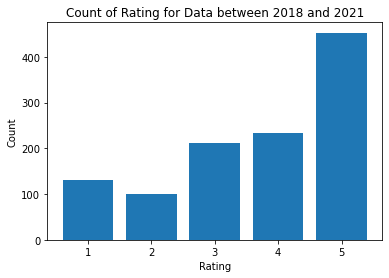

In [23]:
# Plot the count of different ratings for data between 2018 and 2021
instagram_ios_ph_review_score_count = instagram_ios_ph_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(instagram_ios_ph_review_score_count.index,instagram_ios_ph_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

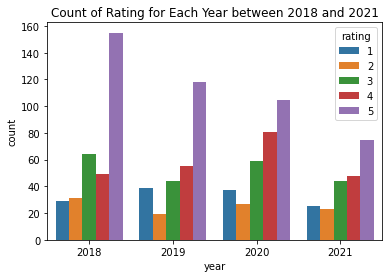

In [24]:
# Plot the count of different ratings for each year
instagram_ios_ph_review_score_count_ByYear = (instagram_ios_ph_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=instagram_ios_ph_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [25]:
# Understand average ratings over year
instagram_ios_ph_review_avg_score_ByYear = (instagram_ios_ph_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

instagram_ios_ph_review_avg_score_ByYear['count'] = instagram_ios_ph_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
instagram_ios_ph_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  3.823171    328
2019  3.705455    275
2020  3.614887    309
2021  3.581395    215

# Dataframe Preparation for Topic Modelling

In [26]:
# Dataframe with data between 2018 and 2021 without score or year filtering
instagram_ios_ph_review_YearMonth.head()

rating  \
73       5   
74       2   
75       5   
76       5   
77       4   

                                                                                                                                                                                                     review  \
73  It’s been months since you introduced it in Instagram stories but I’ve deleted and redownloaded the app for MANY times already and always update whenever you release new updates. I’ve also reboote...   
74  Hi! Instagram. I don’t know what’s happening lately that whatever I do (e.g. posting on account (#1) stories or following accounts) on this certain account I mainly use, goes to the other account ...   
75                               Can you please make an update where we can see who actually viewed the video you post? Because when I check the views, it only shows the number of views and who LIKED it.   
76  We suggest to put an Camera Icon that can bring us directly to snap all things in short period of time so that we can post stories faster because everything around us have stories to share special...   
77  Pictures are becoming wide when I post it in my story. I'm using an iphone 4s and I can still update my Instagram. It also crash sometimes. I can't go live either but google says version 20.0 can ...   

                                             title       date  \
73           Superzoom option in Instagram Stories 2018-01-03   
74  Something seems off with the instagram stories 2018-01-03   
75                                      Suggestion 2018-01-04   
76            Camera Icon at wallpaper for stories 2018-01-04   
77                              Please notice this 2018-01-07   

              userName  isEdited  year  month  
73            isawgirl     False  2018      1  
74     another_route24     False  2018      1  
75      hdusjbdjjdieje     False  2018      1  
76  Secretealaminmo123     False  2018      1  
77         Ndjdnnsjsja     False  2018      1

In [27]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
instagram_ios_ph_review_YearMonth_score1 = instagram_ios_ph_review_YearMonth[instagram_ios_ph_review_YearMonth['rating']==1]
instagram_ios_ph_review_YearMonth_score2 = instagram_ios_ph_review_YearMonth[instagram_ios_ph_review_YearMonth['rating']==2]
instagram_ios_ph_review_YearMonth_score3 = instagram_ios_ph_review_YearMonth[instagram_ios_ph_review_YearMonth['rating']==3]
instagram_ios_ph_review_YearMonth_score4 = instagram_ios_ph_review_YearMonth[instagram_ios_ph_review_YearMonth['rating']==4]
instagram_ios_ph_review_YearMonth_score5 = instagram_ios_ph_review_YearMonth[instagram_ios_ph_review_YearMonth['rating']==5]


In [28]:
# Prepare dataframe for grouped score
instagram_ios_ph_review_YearMonth_score1N2N3 = instagram_ios_ph_review_YearMonth[instagram_ios_ph_review_YearMonth['rating'].isin([1,2,3])]
instagram_ios_ph_review_YearMonth_score4N5 = instagram_ios_ph_review_YearMonth[instagram_ios_ph_review_YearMonth['rating'].isin([4,5])]


In [29]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
instagram_ios_ph_review_YearMonth_2018_score1N2N3 = instagram_ios_ph_review_YearMonth[(instagram_ios_ph_review_YearMonth['year']==2018)&(instagram_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
instagram_ios_ph_review_YearMonth_2019_score1N2N3 = instagram_ios_ph_review_YearMonth[(instagram_ios_ph_review_YearMonth['year']==2019)&(instagram_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
instagram_ios_ph_review_YearMonth_2020_score1N2N3 = instagram_ios_ph_review_YearMonth[(instagram_ios_ph_review_YearMonth['year']==2020)&(instagram_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
instagram_ios_ph_review_YearMonth_2021_score1N2N3 = instagram_ios_ph_review_YearMonth[(instagram_ios_ph_review_YearMonth['year']==2021)&(instagram_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [30]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_ph = instagram_ios_ph_review_YearMonth.review.values.tolist()
review_words_ph = list(sent_to_words(review_ph))
print(review_words_ph[:1])

[['it', 'been', 'months', 'since', 'you', 'introduced', 'it', 'in', 'instagram', 'stories', 'but', 've', 'deleted', 'and', 'redownloaded', 'the', 'app', 'for', 'many', 'times', 'already', 'and', 'always', 'update', 'whenever', 'you', 'release', 'new', 'updates', 've', 'also', 'rebooted', 'my', 'phone', 'recently', 'but', 'still', 'don', 'have', 'the', 'superzoom', 'option', 'in', 'my', 'stories', 'please', 'help', 'and', 'fix']]


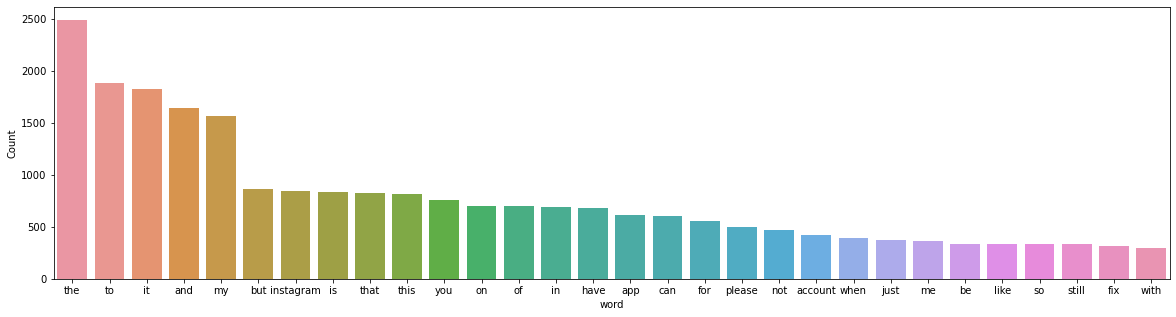

In [31]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph))

In [32]:
# Clean text
review_ph_ready = process_words(review_words_ph)  # processed Text Data! - move to each section

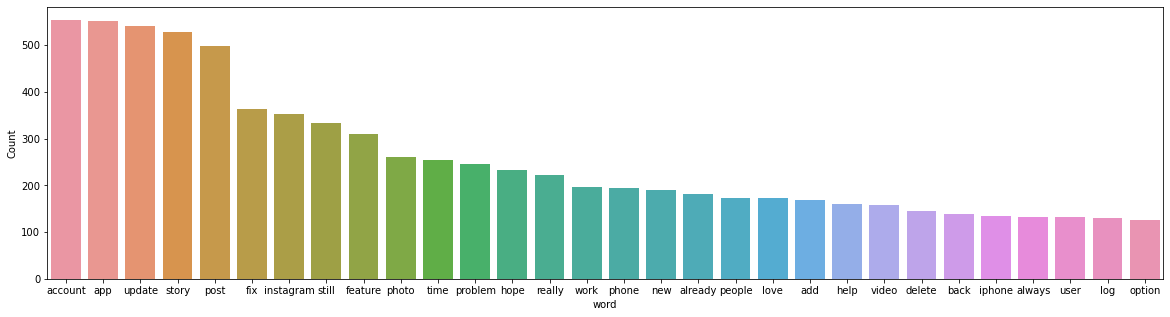

In [33]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready))

In [34]:
# Create Dictionary
id2word_ph = corpora.Dictionary(review_ph_ready)

2021-10-16 01:45:06,650 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:45:06,872 [INFO] gensim.corpora.dictionary - built Dictionary(2277 unique tokens: ['already', 'always', 'app', 'delete', 'fix']...) from 1127 documents (total 23437 corpus positions)
2021-10-16 01:45:06,910 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2277 unique tokens: ['already', 'always', 'app', 'delete', 'fix']...) from 1127 documents (total 23437 corpus positions)", 'datetime': '2021-10-16T01:45:06.874207', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [35]:
# Create Corpus: Term Document Frequency
corpus_ph = [id2word_ph.doc2bow(text) for text in review_ph_ready]

In [36]:
# Training LDA model
model_list_ph, coherence_values_ph = compute_coherence_values(dictionary=id2word_ph, corpus=corpus_ph, 
                                                              texts=review_ph_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 01:45:07,045 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:45:07,047 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:45:07,054 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:45:07,057 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1127 documents, updating model once every 1000 documents, evaluating perplexity every 1127 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:45:07,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1127
2021-10-16 01:45:11,352 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:45:11,357 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"update" + 0.027*"app" + 0.024*"story" + 0.018*"fix" + 0.018*"post" + 0.018*"account" + 0.017*"still" + 0.015*"instagram" + 0.013*"prob

2021-10-16 01:45:22,510 [INFO] gensim.models.ldamodel - topic diff=0.303418, rho=0.403995
2021-10-16 01:45:22,791 [INFO] gensim.models.ldamodel - -6.192 per-word bound, 73.1 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:45:22,798 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1127/1127
2021-10-16 01:45:23,023 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:45:23,026 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.028*"story" + 0.026*"update" + 0.026*"account" + 0.018*"still" + 0.017*"fix" + 0.016*"post" + 0.014*"instagram" + 0.012*"time" + 0.010*"feature"
2021-10-16 01:45:23,028 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"post" + 0.023*"photo" + 0.021*"account" + 0.014*"instagram" + 0.012*"feature" + 0.011*"available" + 0.011*"hope" + 0.011*"people" + 0.011*"really" + 0.011*"picture"
2021-10-16 01:45:23,031 [INFO] gensim.models.l

2021-10-16 01:45:32,699 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.029*"story" + 0.027*"update" + 0.026*"account" + 0.019*"fix" + 0.019*"still" + 0.014*"post" + 0.014*"instagram" + 0.014*"time" + 0.012*"problem"
2021-10-16 01:45:32,702 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.018*"account" + 0.014*"instagram" + 0.013*"feature" + 0.012*"picture" + 0.012*"hope" + 0.011*"really" + 0.011*"people" + 0.010*"available"
2021-10-16 01:45:32,705 [INFO] gensim.models.ldamodel - topic diff=0.201825, rho=0.299786
2021-10-16 01:45:32,989 [INFO] gensim.models.ldamodel - -6.167 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:45:32,992 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1127/1127
2021-10-16 01:45:33,152 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:45:33,158 [INFO] gensim.models.l

2021-10-16 01:45:40,804 [INFO] gensim.models.ldamodel - topic diff=0.164605, rho=0.257113
2021-10-16 01:45:40,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1127
2021-10-16 01:45:42,472 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:45:42,475 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.029*"story" + 0.027*"update" + 0.027*"account" + 0.020*"fix" + 0.019*"still" + 0.014*"time" + 0.014*"post" + 0.014*"instagram" + 0.012*"problem"
2021-10-16 01:45:42,477 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"post" + 0.024*"photo" + 0.018*"account" + 0.015*"instagram" + 0.013*"feature" + 0.012*"picture" + 0.012*"hope" + 0.011*"really" + 0.011*"people" + 0.011*"available"
2021-10-16 01:45:42,479 [INFO] gensim.models.ldamodel - topic diff=0.160838, rho=0.249014
2021-10-16 01:45:42,817 [INFO] gensim.models.ldamodel - -6.159 per-word bound, 71.5 perplexity estimate based on a hel

2021-10-16 01:45:49,892 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.029*"story" + 0.028*"account" + 0.027*"update" + 0.019*"still" + 0.019*"fix" + 0.014*"post" + 0.014*"instagram" + 0.013*"time" + 0.011*"problem"
2021-10-16 01:45:49,894 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.018*"account" + 0.015*"instagram" + 0.013*"feature" + 0.012*"picture" + 0.011*"hope" + 0.011*"available" + 0.011*"people" + 0.011*"really"
2021-10-16 01:45:49,896 [INFO] gensim.models.ldamodel - topic diff=0.139520, rho=0.222900
2021-10-16 01:45:49,898 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1127
2021-10-16 01:45:51,346 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:45:51,350 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.029*"story" + 0.027*"update" + 0.027*"account" + 0.020*"fix" + 0.019*"still" + 0.014*"time" + 0.014*"post" + 0.014*"in

2021-10-16 01:45:58,755 [INFO] gensim.models.ldamodel - topic diff=0.124210, rho=0.199494
2021-10-16 01:45:58,994 [INFO] gensim.models.ldamodel - -6.153 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:45:58,995 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1127/1127
2021-10-16 01:45:59,147 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:45:59,150 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.029*"story" + 0.028*"account" + 0.027*"update" + 0.019*"still" + 0.019*"fix" + 0.014*"post" + 0.014*"instagram" + 0.013*"time" + 0.011*"problem"
2021-10-16 01:45:59,152 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.018*"account" + 0.015*"instagram" + 0.013*"feature" + 0.012*"picture" + 0.011*"hope" + 0.011*"available" + 0.011*"really" + 0.011*"people"
2021-10-16 01:45:59,154 [INFO] gensim.models.

2021-10-16 01:46:08,618 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.029*"story" + 0.028*"account" + 0.027*"update" + 0.020*"fix" + 0.020*"still" + 0.014*"time" + 0.014*"post" + 0.014*"instagram" + 0.012*"problem"
2021-10-16 01:46:08,620 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.017*"account" + 0.015*"instagram" + 0.013*"feature" + 0.012*"picture" + 0.012*"hope" + 0.011*"really" + 0.011*"people" + 0.010*"available"
2021-10-16 01:46:08,621 [INFO] gensim.models.ldamodel - topic diff=0.112006, rho=0.182189
2021-10-16 01:46:08,844 [INFO] gensim.models.ldamodel - -6.150 per-word bound, 71.0 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:46:08,846 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1127/1127
2021-10-16 01:46:09,021 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:46:09,028 [INFO] gensim.models.

2021-10-16 01:46:16,943 [INFO] gensim.models.ldamodel - topic diff=0.103731, rho=0.171179
2021-10-16 01:46:16,945 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1127
2021-10-16 01:46:18,370 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:46:18,372 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.029*"story" + 0.028*"account" + 0.027*"update" + 0.020*"fix" + 0.020*"still" + 0.014*"time" + 0.014*"post" + 0.014*"instagram" + 0.012*"problem"
2021-10-16 01:46:18,373 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.016*"account" + 0.015*"instagram" + 0.013*"feature" + 0.012*"picture" + 0.012*"hope" + 0.011*"really" + 0.011*"people" + 0.010*"available"
2021-10-16 01:46:18,374 [INFO] gensim.models.ldamodel - topic diff=0.102703, rho=0.168725
2021-10-16 01:46:18,531 [INFO] gensim.models.ldamodel - -6.148 per-word bound, 70.9 perplexity estimate based on a hel

2021-10-16 01:46:26,893 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.029*"story" + 0.028*"account" + 0.027*"update" + 0.020*"fix" + 0.020*"still" + 0.014*"post" + 0.014*"instagram" + 0.014*"time" + 0.011*"problem"
2021-10-16 01:46:26,898 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.017*"account" + 0.015*"instagram" + 0.013*"feature" + 0.011*"picture" + 0.011*"hope" + 0.011*"really" + 0.011*"available" + 0.011*"people"
2021-10-16 01:46:26,902 [INFO] gensim.models.ldamodel - topic diff=0.096169, rho=0.159868
2021-10-16 01:46:26,904 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1127
2021-10-16 01:46:28,269 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:46:28,271 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.029*"story" + 0.028*"account" + 0.027*"update" + 0.020*"fix" + 0.020*"still" + 0.014*"time" + 0.014*"post" + 0.014*"in

2021-10-16 01:46:35,393 [INFO] gensim.models.ldamodel - topic diff=0.090438, rho=0.150539
2021-10-16 01:46:35,646 [INFO] gensim.models.ldamodel - -6.145 per-word bound, 70.8 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:46:35,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1127/1127
2021-10-16 01:46:35,820 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:46:35,827 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.029*"story" + 0.029*"account" + 0.027*"update" + 0.020*"fix" + 0.020*"still" + 0.014*"post" + 0.014*"time" + 0.014*"instagram" + 0.011*"problem"
2021-10-16 01:46:35,829 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.016*"account" + 0.015*"instagram" + 0.013*"feature" + 0.011*"picture" + 0.011*"hope" + 0.011*"really" + 0.011*"people" + 0.011*"available"
2021-10-16 01:46:35,830 [INFO] gensim.models.

2021-10-16 01:46:44,911 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.029*"story" + 0.028*"account" + 0.027*"update" + 0.020*"fix" + 0.020*"still" + 0.014*"time" + 0.014*"post" + 0.014*"instagram" + 0.012*"problem"
2021-10-16 01:46:44,919 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"post" + 0.024*"photo" + 0.016*"account" + 0.015*"instagram" + 0.013*"feature" + 0.012*"picture" + 0.012*"hope" + 0.011*"really" + 0.011*"people" + 0.010*"available"
2021-10-16 01:46:44,921 [INFO] gensim.models.ldamodel - topic diff=0.085258, rho=0.142672
2021-10-16 01:46:45,153 [INFO] gensim.models.ldamodel - -6.144 per-word bound, 70.7 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:46:45,156 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1127/1127
2021-10-16 01:46:45,300 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:46:45,302 [INFO] gensim.models.

2021-10-16 01:46:59,674 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"post" + 0.017*"account" + 0.017*"photo" + 0.015*"people" + 0.015*"fix" + 0.014*"put" + 0.014*"story" + 0.014*"feature" + 0.012*"user" + 0.012*"update"
2021-10-16 01:46:59,679 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"app" + 0.028*"video" + 0.019*"message" + 0.018*"fix" + 0.016*"still" + 0.014*"update" + 0.014*"post" + 0.013*"call" + 0.012*"really" + 0.012*"back"
2021-10-16 01:46:59,681 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"account" + 0.023*"app" + 0.021*"update" + 0.018*"instagram" + 0.016*"log" + 0.016*"still" + 0.016*"story" + 0.013*"post" + 0.012*"phone" + 0.012*"feature"
2021-10-16 01:46:59,686 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"post" + 0.031*"story" + 0.023*"update" + 0.021*"app" + 0.019*"instagram" + 0.014*"still" + 0.013*"music" + 0.012*"version" + 0.012*"feature" + 0.011*"already"
2021-10-16 01:46:59,690 [INFO] gensim.models.ldamodel - topic #

2021-10-16 01:47:06,632 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.072*"account" + 0.026*"app" + 0.022*"update" + 0.021*"still" + 0.019*"log" + 0.019*"instagram" + 0.017*"story" + 0.015*"feature" + 0.015*"problem" + 0.014*"phone"
2021-10-16 01:47:06,637 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"story" + 0.029*"update" + 0.024*"post" + 0.020*"instagram" + 0.019*"version" + 0.018*"app" + 0.017*"still" + 0.016*"music" + 0.014*"feature" + 0.013*"already"
2021-10-16 01:47:06,639 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"post" + 0.017*"people" + 0.016*"fix" + 0.015*"account" + 0.014*"user" + 0.013*"feature" + 0.013*"story" + 0.012*"photo" + 0.012*"problem" + 0.012*"follow"
2021-10-16 01:47:06,641 [INFO] gensim.models.ldamodel - topic diff=0.286748, rho=0.441640
2021-10-16 01:47:07,075 [INFO] gensim.models.ldamodel - -6.259 per-word bound, 76.6 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:47:07,111 [INFO] 

2021-10-16 01:47:12,462 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"user" + 0.027*"business" + 0.026*"ipad" + 0.024*"page" + 0.021*"people" + 0.019*"inhumane" + 0.019*"pronoun" + 0.018*"link" + 0.015*"fb" + 0.014*"frustrating"
2021-10-16 01:47:12,467 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"post" + 0.018*"account" + 0.016*"user" + 0.015*"people" + 0.014*"put" + 0.014*"follow" + 0.014*"feature" + 0.014*"fix" + 0.013*"friend" + 0.012*"photo"
2021-10-16 01:47:12,471 [INFO] gensim.models.ldamodel - topic diff=0.201114, rho=0.374582
2021-10-16 01:47:12,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/1127
2021-10-16 01:47:13,882 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:47:13,886 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"story" + 0.032*"update" + 0.021*"instagram" + 0.021*"version" + 0.019*"music" + 0.018*"post" + 0.017*"still" + 0.017*"app" + 0.015*"avai

2021-10-16 01:47:18,029 [INFO] gensim.models.ldamodel - topic diff=0.141141, rho=0.314239
2021-10-16 01:47:18,235 [INFO] gensim.models.ldamodel - -6.145 per-word bound, 70.8 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:47:18,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1127/1127
2021-10-16 01:47:18,424 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:47:18,428 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"photo" + 0.040*"post" + 0.029*"update" + 0.022*"story" + 0.019*"really" + 0.017*"instagram" + 0.017*"picture" + 0.017*"app" + 0.015*"delete" + 0.015*"hope"
2021-10-16 01:47:18,430 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"story" + 0.031*"update" + 0.021*"instagram" + 0.021*"music" + 0.020*"version" + 0.019*"available" + 0.017*"still" + 0.016*"post" + 0.016*"app" + 0.015*"hope"
2021-10-16 01:47:18,431 [INFO] gensim.models.ldamod

2021-10-16 01:47:23,962 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"story" + 0.034*"update" + 0.022*"version" + 0.022*"instagram" + 0.021*"music" + 0.018*"available" + 0.018*"still" + 0.017*"app" + 0.014*"already" + 0.014*"post"
2021-10-16 01:47:23,966 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"send" + 0.020*"hack" + 0.016*"connection" + 0.015*"email" + 0.015*"habit" + 0.015*"suspend" + 0.014*"number" + 0.013*"ig" + 0.012*"selfie" + 0.012*"pandemic"
2021-10-16 01:47:23,969 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"photo" + 0.042*"post" + 0.028*"update" + 0.024*"story" + 0.019*"really" + 0.018*"picture" + 0.017*"instagram" + 0.016*"app" + 0.015*"hope" + 0.014*"delete"
2021-10-16 01:47:23,972 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"post" + 0.016*"follow" + 0.016*"account" + 0.015*"user" + 0.015*"people" + 0.013*"put" + 0.013*"fix" + 0.013*"feature" + 0.012*"time" + 0.012*"friend"
2021-10-16 01:47:23,975 [INFO] gensim.models.ldamo

2021-10-16 01:47:28,107 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.046*"app" + 0.033*"video" + 0.021*"message" + 0.020*"fix" + 0.016*"still" + 0.016*"hope" + 0.015*"really" + 0.015*"crash" + 0.014*"call" + 0.013*"problem"
2021-10-16 01:47:28,110 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"photo" + 0.045*"post" + 0.028*"update" + 0.021*"story" + 0.019*"really" + 0.018*"instagram" + 0.018*"picture" + 0.016*"delete" + 0.015*"app" + 0.015*"hope"
2021-10-16 01:47:28,114 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"account" + 0.026*"app" + 0.022*"story" + 0.021*"still" + 0.020*"update" + 0.019*"instagram" + 0.019*"log" + 0.017*"problem" + 0.015*"time" + 0.015*"fix"
2021-10-16 01:47:28,118 [INFO] gensim.models.ldamodel - topic diff=0.105552, rho=0.257113
2021-10-16 01:47:28,125 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1127
2021-10-16 01:47:29,545 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 11

2021-10-16 01:47:33,157 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"photo" + 0.045*"post" + 0.027*"update" + 0.022*"story" + 0.019*"really" + 0.018*"picture" + 0.017*"instagram" + 0.015*"hope" + 0.015*"app" + 0.015*"delete"
2021-10-16 01:47:33,164 [INFO] gensim.models.ldamodel - topic diff=0.092216, rho=0.234875
2021-10-16 01:47:33,331 [INFO] gensim.models.ldamodel - -6.096 per-word bound, 68.4 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:47:33,333 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1127/1127
2021-10-16 01:47:33,477 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:47:33,484 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"photo" + 0.046*"post" + 0.028*"update" + 0.020*"story" + 0.019*"really" + 0.018*"picture" + 0.018*"instagram" + 0.016*"delete" + 0.015*"app" + 0.015*"hope"
2021-10-16 01:47:33,496 [INFO] gensim.models.ldamode

2021-10-16 01:47:37,463 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1127
2021-10-16 01:47:38,807 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:47:38,822 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"app" + 0.031*"video" + 0.022*"fix" + 0.019*"message" + 0.017*"hope" + 0.016*"still" + 0.015*"crash" + 0.015*"really" + 0.015*"problem" + 0.014*"update"
2021-10-16 01:47:38,829 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"story" + 0.036*"update" + 0.021*"version" + 0.021*"instagram" + 0.021*"music" + 0.019*"available" + 0.018*"still" + 0.017*"app" + 0.015*"fix" + 0.015*"hope"
2021-10-16 01:47:38,835 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"send" + 0.019*"hack" + 0.017*"selfie" + 0.017*"email" + 0.016*"connection" + 0.015*"habit" + 0.015*"suspend" + 0.015*"number" + 0.015*"stop" + 0.014*"work"
2021-10-16 01:47:38,838 [INFO] gensim.models.ldamodel - topic #1 (0.143

2021-10-16 01:47:43,116 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"story" + 0.034*"update" + 0.022*"music" + 0.021*"instagram" + 0.021*"version" + 0.021*"available" + 0.017*"still" + 0.016*"app" + 0.015*"fix" + 0.015*"hope"
2021-10-16 01:47:43,118 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"account" + 0.026*"app" + 0.022*"story" + 0.022*"still" + 0.021*"update" + 0.019*"instagram" + 0.019*"log" + 0.017*"problem" + 0.015*"fix" + 0.015*"time"
2021-10-16 01:47:43,120 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"user" + 0.028*"ipad" + 0.026*"page" + 0.026*"people" + 0.026*"business" + 0.019*"link" + 0.016*"pronoun" + 0.016*"inhumane" + 0.015*"news" + 0.015*"favorite"
2021-10-16 01:47:43,122 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"photo" + 0.047*"post" + 0.027*"update" + 0.020*"story" + 0.019*"really" + 0.018*"picture" + 0.018*"instagram" + 0.016*"delete" + 0.015*"hope" + 0.015*"app"
2021-10-16 01:47:43,124 [INFO] gensim.models.ldamode

2021-10-16 01:47:49,379 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"ipad" + 0.029*"user" + 0.027*"page" + 0.027*"business" + 0.023*"people" + 0.018*"link" + 0.018*"favorite" + 0.015*"news" + 0.014*"pronoun" + 0.014*"inhumane"
2021-10-16 01:47:49,383 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"post" + 0.017*"follow" + 0.016*"account" + 0.016*"user" + 0.015*"people" + 0.014*"put" + 0.013*"feature" + 0.013*"time" + 0.012*"friend" + 0.011*"feed"
2021-10-16 01:47:49,385 [INFO] gensim.models.ldamodel - topic diff=0.074000, rho=0.195639
2021-10-16 01:47:49,643 [INFO] gensim.models.ldamodel - -6.080 per-word bound, 67.6 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:47:49,644 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1127/1127
2021-10-16 01:47:49,779 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:47:49,783 [INFO] gensim.models.ldamodel 

2021-10-16 01:47:54,237 [INFO] gensim.models.ldamodel - topic diff=0.070813, rho=0.188555
2021-10-16 01:47:54,241 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1127
2021-10-16 01:47:55,911 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:47:55,918 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"post" + 0.017*"follow" + 0.016*"account" + 0.016*"user" + 0.015*"people" + 0.014*"put" + 0.013*"feature" + 0.013*"time" + 0.012*"friend" + 0.011*"feed"
2021-10-16 01:47:55,924 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"ipad" + 0.029*"user" + 0.027*"page" + 0.027*"business" + 0.023*"people" + 0.018*"link" + 0.017*"favorite" + 0.015*"news" + 0.014*"pronoun" + 0.014*"inhumane"
2021-10-16 01:47:55,930 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"story" + 0.036*"update" + 0.022*"instagram" + 0.021*"version" + 0.021*"music" + 0.019*"available" + 0.018*"still" + 0.017*"app" + 0.015*

2021-10-16 01:48:00,909 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"photo" + 0.048*"post" + 0.027*"update" + 0.020*"story" + 0.019*"really" + 0.018*"picture" + 0.018*"instagram" + 0.016*"delete" + 0.015*"hope" + 0.015*"app"
2021-10-16 01:48:00,911 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"user" + 0.029*"ipad" + 0.026*"page" + 0.026*"people" + 0.026*"business" + 0.019*"link" + 0.016*"pronoun" + 0.016*"inhumane" + 0.015*"favorite" + 0.015*"news"
2021-10-16 01:48:00,914 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"account" + 0.027*"app" + 0.023*"story" + 0.022*"still" + 0.021*"update" + 0.019*"instagram" + 0.019*"log" + 0.017*"problem" + 0.016*"fix" + 0.015*"time"
2021-10-16 01:48:00,917 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"post" + 0.017*"follow" + 0.017*"account" + 0.016*"user" + 0.015*"put" + 0.014*"people" + 0.014*"feature" + 0.013*"friend" + 0.012*"time" + 0.012*"medium"
2021-10-16 01:48:00,918 [INFO] gensim.models.ldamodel -

2021-10-16 01:48:06,586 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.045*"app" + 0.031*"video" + 0.021*"fix" + 0.019*"message" + 0.017*"hope" + 0.016*"still" + 0.015*"crash" + 0.015*"really" + 0.015*"problem" + 0.013*"love"
2021-10-16 01:48:06,592 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"story" + 0.036*"update" + 0.022*"instagram" + 0.021*"version" + 0.021*"music" + 0.019*"available" + 0.018*"still" + 0.017*"app" + 0.015*"fix" + 0.015*"hope"
2021-10-16 01:48:06,596 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"account" + 0.027*"app" + 0.023*"still" + 0.022*"story" + 0.022*"update" + 0.019*"instagram" + 0.018*"log" + 0.018*"problem" + 0.017*"fix" + 0.016*"time"
2021-10-16 01:48:06,598 [INFO] gensim.models.ldamodel - topic diff=0.063193, rho=0.171179
2021-10-16 01:48:06,791 [INFO] gensim.models.ldamodel - -6.071 per-word bound, 67.2 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:48:06,792 [INFO] gensim.model

2021-10-16 01:48:11,245 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"story" + 0.035*"update" + 0.022*"music" + 0.021*"instagram" + 0.021*"version" + 0.020*"available" + 0.017*"still" + 0.016*"app" + 0.015*"fix" + 0.015*"hope"
2021-10-16 01:48:11,246 [INFO] gensim.models.ldamodel - topic diff=0.061084, rho=0.166373
2021-10-16 01:48:11,248 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1127
2021-10-16 01:48:12,782 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:48:12,789 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"photo" + 0.047*"post" + 0.026*"update" + 0.021*"story" + 0.019*"really" + 0.019*"picture" + 0.017*"instagram" + 0.015*"hope" + 0.015*"delete" + 0.014*"app"
2021-10-16 01:48:12,791 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"post" + 0.017*"follow" + 0.016*"account" + 0.016*"user" + 0.015*"people" + 0.014*"put" + 0.013*"feature" + 0.013*"time" + 0.012*"frie

2021-10-16 01:48:17,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1127/1127
2021-10-16 01:48:17,266 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:48:17,270 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"post" + 0.017*"follow" + 0.017*"account" + 0.016*"user" + 0.015*"put" + 0.014*"people" + 0.014*"feature" + 0.013*"friend" + 0.012*"time" + 0.012*"medium"
2021-10-16 01:48:17,272 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"send" + 0.020*"hack" + 0.019*"selfie" + 0.018*"email" + 0.018*"connection" + 0.018*"stop" + 0.017*"habit" + 0.017*"suspend" + 0.015*"work" + 0.015*"number"
2021-10-16 01:48:17,273 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"account" + 0.027*"app" + 0.023*"story" + 0.022*"still" + 0.021*"update" + 0.019*"instagram" + 0.019*"log" + 0.017*"problem" + 0.016*"fix" + 0.016*"time"
2021-10-16 01:48:17,275 [INFO] gensim.models.ldamodel - topic #5 (0.143): 

2021-10-16 01:48:23,407 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"account" + 0.027*"app" + 0.023*"still" + 0.022*"story" + 0.022*"update" + 0.019*"instagram" + 0.018*"log" + 0.018*"problem" + 0.017*"fix" + 0.016*"time"
2021-10-16 01:48:23,410 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"story" + 0.036*"update" + 0.022*"instagram" + 0.021*"version" + 0.021*"music" + 0.019*"available" + 0.018*"still" + 0.017*"app" + 0.015*"fix" + 0.015*"hope"
2021-10-16 01:48:23,414 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"photo" + 0.048*"post" + 0.026*"update" + 0.021*"story" + 0.019*"really" + 0.019*"picture" + 0.017*"instagram" + 0.015*"hope" + 0.015*"delete" + 0.014*"app"
2021-10-16 01:48:23,417 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"post" + 0.017*"follow" + 0.016*"account" + 0.016*"user" + 0.015*"people" + 0.014*"put" + 0.013*"feature" + 0.013*"friend" + 0.012*"time" + 0.011*"feed"
2021-10-16 01:48:23,420 [INFO] gensim.models.ldamodel - to

2021-10-16 01:48:27,636 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"send" + 0.020*"hack" + 0.019*"selfie" + 0.018*"stop" + 0.018*"email" + 0.018*"connection" + 0.017*"habit" + 0.017*"suspend" + 0.015*"work" + 0.014*"number"
2021-10-16 01:48:27,652 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"account" + 0.027*"app" + 0.023*"story" + 0.022*"still" + 0.021*"update" + 0.019*"instagram" + 0.019*"log" + 0.018*"problem" + 0.016*"fix" + 0.016*"time"
2021-10-16 01:48:27,664 [INFO] gensim.models.ldamodel - topic diff=0.054549, rho=0.150539
2021-10-16 01:48:27,668 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1127
2021-10-16 01:48:29,037 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:48:29,041 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.074*"account" + 0.027*"app" + 0.023*"still" + 0.022*"story" + 0.022*"update" + 0.019*"instagram" + 0.018*"log" + 0.018*"problem" + 0.017*"fix"

2021-10-16 01:48:33,519 [INFO] gensim.models.ldamodel - topic diff=0.052593, rho=0.145668
2021-10-16 01:48:33,769 [INFO] gensim.models.ldamodel - -6.062 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:48:33,770 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1127/1127
2021-10-16 01:48:33,875 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:48:33,881 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.076*"account" + 0.027*"app" + 0.023*"story" + 0.022*"still" + 0.021*"update" + 0.019*"instagram" + 0.019*"log" + 0.018*"problem" + 0.016*"fix" + 0.016*"time"
2021-10-16 01:48:33,883 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"user" + 0.029*"ipad" + 0.026*"page" + 0.026*"people" + 0.026*"business" + 0.019*"link" + 0.016*"pronoun" + 0.016*"inhumane" + 0.015*"favorite" + 0.015*"news"
2021-10-16 01:48:33,885 [INFO] gensim.models.ldamodel

2021-10-16 01:48:38,693 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"ipad" + 0.029*"user" + 0.027*"page" + 0.026*"business" + 0.024*"people" + 0.018*"link" + 0.017*"favorite" + 0.015*"news" + 0.014*"pronoun" + 0.014*"inhumane"
2021-10-16 01:48:38,698 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"send" + 0.019*"hack" + 0.017*"selfie" + 0.017*"email" + 0.017*"stop" + 0.017*"connection" + 0.015*"habit" + 0.015*"suspend" + 0.015*"work" + 0.014*"number"
2021-10-16 01:48:38,704 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"story" + 0.036*"update" + 0.022*"instagram" + 0.021*"music" + 0.021*"version" + 0.020*"available" + 0.018*"still" + 0.017*"app" + 0.015*"fix" + 0.015*"hope"
2021-10-16 01:48:38,707 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"post" + 0.017*"follow" + 0.016*"user" + 0.015*"account" + 0.015*"people" + 0.014*"put" + 0.013*"feature" + 0.013*"friend" + 0.012*"time" + 0.012*"feed"
2021-10-16 01:48:38,717 [INFO] gensim.models.ldamodel

2021-10-16 01:48:50,354 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.034*"post" + 0.020*"fix" + 0.018*"account" + 0.015*"problem" + 0.015*"instagram" + 0.013*"feature" + 0.012*"photo" + 0.012*"app" + 0.011*"hope" + 0.011*"update"
2021-10-16 01:48:50,473 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.056*"story" + 0.031*"update" + 0.025*"app" + 0.023*"problem" + 0.021*"feature" + 0.017*"view" + 0.016*"still" + 0.014*"instagram" + 0.014*"fix" + 0.013*"add"
2021-10-16 01:48:50,519 [INFO] gensim.models.ldamodel - topic diff=8.409968, rho=1.000000
2021-10-16 01:48:50,942 [INFO] gensim.models.ldamodel - -7.933 per-word bound, 244.3 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:48:50,947 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1127/1127
2021-10-16 01:48:51,310 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:48:51,318 [INFO] gensim.models.ldamodel -

2021-10-16 01:48:56,051 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.041*"app" + 0.038*"video" + 0.024*"call" + 0.020*"person" + 0.020*"hope" + 0.020*"back" + 0.019*"fix" + 0.018*"really" + 0.015*"contact" + 0.015*"look"
2021-10-16 01:48:56,053 [INFO] gensim.models.ldamodel - topic diff=0.393808, rho=0.492247
2021-10-16 01:48:56,055 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/1127
2021-10-16 01:48:57,656 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:48:57,662 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"click" + 0.024*"compromise" + 0.019*"background" + 0.017*"someone" + 0.015*"regard" + 0.014*"really" + 0.014*"bring" + 0.014*"send" + 0.014*"matter" + 0.013*"password"
2021-10-16 01:48:57,668 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"account" + 0.036*"update" + 0.033*"app" + 0.029*"instagram" + 0.025*"still" + 0.024*"time" + 0.023*"new" + 0.023*"feature" + 0.015*"

2021-10-16 01:49:01,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1127/1127
2021-10-16 01:49:02,032 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:49:02,037 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.033*"story" + 0.026*"available" + 0.025*"update" + 0.023*"music" + 0.023*"instagram" + 0.019*"version" + 0.018*"post" + 0.018*"region" + 0.018*"work" + 0.018*"still"
2021-10-16 01:49:02,039 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.045*"story" + 0.037*"update" + 0.032*"problem" + 0.029*"app" + 0.029*"time" + 0.024*"feature" + 0.023*"music" + 0.022*"fine" + 0.022*"appear" + 0.022*"already"
2021-10-16 01:49:02,041 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.075*"account" + 0.032*"log" + 0.020*"fix" + 0.018*"follow" + 0.016*"people" + 0.015*"app" + 0.014*"post" + 0.013*"happen" + 0.013*"follower" + 0.012*"help"
2021-10-16 01:49:02,043 [INFO] gensim.models.ldamodel - topic #4 (0.08

2021-10-16 01:49:07,721 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.061*"post" + 0.028*"photo" + 0.024*"feature" + 0.020*"change" + 0.020*"picture" + 0.019*"put" + 0.019*"delete" + 0.018*"medium" + 0.018*"filter" + 0.017*"add"
2021-10-16 01:49:07,729 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.074*"account" + 0.031*"log" + 0.021*"follow" + 0.020*"fix" + 0.016*"people" + 0.015*"app" + 0.014*"post" + 0.014*"follower" + 0.013*"happen" + 0.012*"help"
2021-10-16 01:49:07,731 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.043*"click" + 0.031*"matter" + 0.028*"compromise" + 0.023*"background" + 0.021*"really" + 0.018*"password" + 0.018*"regard" + 0.018*"someone" + 0.018*"send" + 0.016*"bring"
2021-10-16 01:49:07,734 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.071*"story" + 0.063*"post" + 0.031*"share" + 0.026*"like" + 0.025*"highlight" + 0.023*"hide" + 0.022*"friend" + 0.020*"button" + 0.018*"account" + 0.018*"people"
2021-10-16 01:49:07,736 [INFO] gensim.models.

2021-10-16 01:49:12,991 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.029*"story" + 0.028*"update" + 0.028*"available" + 0.026*"music" + 0.024*"instagram" + 0.020*"work" + 0.019*"region" + 0.019*"version" + 0.017*"app" + 0.016*"still"
2021-10-16 01:49:12,993 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"app" + 0.037*"video" + 0.025*"hope" + 0.023*"back" + 0.022*"call" + 0.021*"really" + 0.020*"person" + 0.018*"fix" + 0.018*"user" + 0.017*"search"
2021-10-16 01:49:12,995 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"click" + 0.035*"compromise" + 0.028*"matter" + 0.026*"background" + 0.025*"really" + 0.023*"password" + 0.023*"someone" + 0.017*"send" + 0.017*"regard" + 0.016*"bring"
2021-10-16 01:49:12,996 [INFO] gensim.models.ldamodel - topic diff=0.096372, rho=0.287160
2021-10-16 01:49:12,998 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1127
2021-10-16 01:49:14,708 [INFO] gensim.models.ldamodel - merging changes from 1000 documents int

2021-10-16 01:49:19,041 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.046*"app" + 0.037*"video" + 0.035*"crash" + 0.031*"keep" + 0.030*"post" + 0.020*"upload" + 0.019*"problem" + 0.019*"work" + 0.019*"story" + 0.018*"open"
2021-10-16 01:49:19,043 [INFO] gensim.models.ldamodel - topic diff=0.079983, rho=0.257113
2021-10-16 01:49:19,287 [INFO] gensim.models.ldamodel - -6.109 per-word bound, 69.0 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:49:19,289 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1127/1127
2021-10-16 01:49:19,391 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:49:19,397 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.047*"habit" + 0.038*"heart" + 0.033*"boost" + 0.017*"cheer" + 0.017*"eye" + 0.017*"tedious" + 0.016*"reconnect" + 0.016*"overdue" + 0.016*"decluttering" + 0.016*"entertainment"
2021-10-16 01:49:19,399 [INFO] gensim.models

2021-10-16 01:49:23,231 [INFO] gensim.models.ldamodel - topic diff=0.072910, rho=0.241635
2021-10-16 01:49:23,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/1127
2021-10-16 01:49:24,912 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:49:24,917 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.064*"post" + 0.029*"photo" + 0.025*"feature" + 0.021*"change" + 0.021*"picture" + 0.020*"delete" + 0.019*"put" + 0.019*"medium" + 0.018*"filter" + 0.018*"add"
2021-10-16 01:49:24,920 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.045*"app" + 0.038*"video" + 0.035*"crash" + 0.031*"keep" + 0.031*"post" + 0.021*"problem" + 0.020*"upload" + 0.020*"story" + 0.019*"work" + 0.018*"open"
2021-10-16 01:49:24,921 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.057*"photo" + 0.042*"update" + 0.024*"really" + 0.022*"app" + 0.021*"instagram" + 0.020*"picture" + 0.015*"filter" + 0.015*"love" + 0.015*"upload" + 

2021-10-16 01:49:30,555 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"click" + 0.032*"compromise" + 0.027*"matter" + 0.026*"story" + 0.025*"really" + 0.025*"background" + 0.024*"password" + 0.021*"someone" + 0.017*"send" + 0.017*"regard"
2021-10-16 01:49:30,558 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.046*"habit" + 0.039*"heart" + 0.033*"boost" + 0.017*"cheer" + 0.017*"eye" + 0.017*"tedious" + 0.016*"overdue" + 0.016*"woman" + 0.016*"reconnect" + 0.016*"prioritie"
2021-10-16 01:49:30,560 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.053*"account" + 0.039*"app" + 0.036*"update" + 0.033*"instagram" + 0.030*"still" + 0.028*"time" + 0.021*"feature" + 0.021*"new" + 0.020*"fix" + 0.019*"problem"
2021-10-16 01:49:30,566 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.079*"story" + 0.067*"post" + 0.033*"share" + 0.027*"like" + 0.027*"hide" + 0.027*"highlight" + 0.024*"button" + 0.023*"way" + 0.022*"friend" + 0.019*"option"
2021-10-16 01:49:30,569 [INFO] gensim.m

2021-10-16 01:49:35,942 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"profile" + 0.032*"business" + 0.032*"work" + 0.032*"account" + 0.029*"people" + 0.023*"change" + 0.022*"reshare" + 0.016*"unrestrict" + 0.016*"still" + 0.014*"message"
2021-10-16 01:49:35,946 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.048*"story" + 0.033*"problem" + 0.032*"update" + 0.031*"time" + 0.028*"app" + 0.026*"fine" + 0.026*"music" + 0.019*"appear" + 0.019*"promote" + 0.018*"feature"
2021-10-16 01:49:35,949 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.081*"story" + 0.066*"post" + 0.033*"share" + 0.028*"highlight" + 0.027*"like" + 0.024*"hide" + 0.024*"button" + 0.023*"way" + 0.022*"friend" + 0.019*"option"
2021-10-16 01:49:35,952 [INFO] gensim.models.ldamodel - topic diff=0.058848, rho=0.207941
2021-10-16 01:49:36,304 [INFO] gensim.models.ldamodel - -6.092 per-word bound, 68.2 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:49:36,308 [I

2021-10-16 01:49:40,135 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.080*"story" + 0.066*"post" + 0.033*"share" + 0.028*"like" + 0.028*"hide" + 0.027*"highlight" + 0.025*"way" + 0.024*"button" + 0.022*"friend" + 0.019*"option"
2021-10-16 01:49:40,138 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.030*"update" + 0.029*"available" + 0.027*"music" + 0.027*"story" + 0.025*"instagram" + 0.021*"work" + 0.019*"version" + 0.019*"region" + 0.017*"app" + 0.015*"phone"
2021-10-16 01:49:40,140 [INFO] gensim.models.ldamodel - topic diff=0.055158, rho=0.199494
2021-10-16 01:49:40,142 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1127
2021-10-16 01:49:41,634 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:49:41,640 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.044*"app" + 0.040*"video" + 0.035*"crash" + 0.032*"keep" + 0.032*"post" + 0.021*"problem" + 0.021*"story" + 0.020*"upload" + 0.018*"work" 

2021-10-16 01:49:46,462 [INFO] gensim.models.ldamodel - topic diff=0.051644, rho=0.188555
2021-10-16 01:49:46,748 [INFO] gensim.models.ldamodel - -6.087 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:49:46,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1127/1127
2021-10-16 01:49:46,945 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:49:46,953 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"app" + 0.040*"video" + 0.033*"keep" + 0.033*"crash" + 0.032*"post" + 0.022*"problem" + 0.021*"story" + 0.019*"upload" + 0.018*"well" + 0.017*"open"
2021-10-16 01:49:46,965 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.046*"story" + 0.033*"update" + 0.032*"time" + 0.031*"problem" + 0.029*"app" + 0.027*"music" + 0.027*"fine" + 0.020*"promote" + 0.020*"appear" + 0.018*"feed"
2021-10-16 01:49:46,968 [INFO] gensim.models.ldamodel - topic #8

2021-10-16 01:49:54,448 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:49:54,476 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.050*"story" + 0.034*"update" + 0.031*"time" + 0.030*"problem" + 0.028*"app" + 0.027*"fine" + 0.025*"music" + 0.019*"appear" + 0.019*"promote" + 0.019*"feed"
2021-10-16 01:49:54,489 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.030*"update" + 0.027*"story" + 0.027*"available" + 0.026*"music" + 0.025*"instagram" + 0.020*"work" + 0.020*"version" + 0.018*"app" + 0.017*"region" + 0.017*"iphone"
2021-10-16 01:49:54,524 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.052*"profile" + 0.032*"business" + 0.032*"work" + 0.032*"account" + 0.029*"people" + 0.023*"change" + 0.022*"reshare" + 0.017*"unrestrict" + 0.016*"still" + 0.015*"message"
2021-10-16 01:49:54,547 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"app" + 0.040*"video" + 0.035*"crash" + 0.032*"post" + 0.032*"keep" + 0.

2021-10-16 01:49:59,803 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.066*"post" + 0.031*"photo" + 0.026*"feature" + 0.022*"change" + 0.021*"delete" + 0.021*"picture" + 0.020*"put" + 0.020*"filter" + 0.019*"medium" + 0.019*"add"
2021-10-16 01:49:59,804 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.040*"app" + 0.038*"video" + 0.025*"hope" + 0.024*"back" + 0.022*"really" + 0.022*"call" + 0.020*"person" + 0.019*"user" + 0.017*"search" + 0.017*"fix"
2021-10-16 01:49:59,806 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.077*"account" + 0.033*"log" + 0.022*"follow" + 0.018*"fix" + 0.016*"people" + 0.015*"post" + 0.015*"app" + 0.014*"follower" + 0.012*"help" + 0.012*"happen"
2021-10-16 01:49:59,807 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"click" + 0.031*"compromise" + 0.029*"story" + 0.027*"matter" + 0.025*"really" + 0.025*"password" + 0.024*"background" + 0.021*"regard" + 0.020*"someone" + 0.018*"button"
2021-10-16 01:49:59,808 [INFO] gensim.models.ldamodel 

2021-10-16 01:50:06,842 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.057*"photo" + 0.042*"update" + 0.025*"really" + 0.023*"app" + 0.020*"picture" + 0.020*"instagram" + 0.015*"filter" + 0.015*"upload" + 0.015*"view" + 0.014*"love"
2021-10-16 01:50:06,846 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"app" + 0.041*"video" + 0.035*"crash" + 0.033*"post" + 0.032*"keep" + 0.022*"problem" + 0.022*"story" + 0.020*"upload" + 0.018*"happen" + 0.018*"open"
2021-10-16 01:50:06,849 [INFO] gensim.models.ldamodel - topic diff=0.044582, rho=0.166373
2021-10-16 01:50:07,257 [INFO] gensim.models.ldamodel - -6.079 per-word bound, 67.6 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:50:07,258 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1127/1127
2021-10-16 01:50:07,477 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:50:07,486 [INFO] gensim.models.ldamodel - t

2021-10-16 01:50:12,442 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.077*"account" + 0.033*"log" + 0.022*"follow" + 0.018*"fix" + 0.016*"people" + 0.015*"post" + 0.015*"app" + 0.014*"follower" + 0.012*"help" + 0.012*"happen"
2021-10-16 01:50:12,444 [INFO] gensim.models.ldamodel - topic diff=0.042865, rho=0.161951
2021-10-16 01:50:12,446 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/1127
2021-10-16 01:50:14,110 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:50:14,172 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.039*"habit" + 0.036*"heart" + 0.028*"boost" + 0.016*"directly" + 0.015*"cheer" + 0.015*"eye" + 0.015*"tedious" + 0.013*"tool" + 0.013*"entrepreneur" + 0.013*"reconnect"
2021-10-16 01:50:14,173 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"app" + 0.041*"video" + 0.035*"crash" + 0.033*"post" + 0.032*"keep" + 0.022*"problem" + 0.022*"story" + 0.020*"upload" + 0.018*"hap

2021-10-16 01:50:17,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1127/1127
2021-10-16 01:50:18,023 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:50:18,029 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.077*"account" + 0.032*"log" + 0.022*"follow" + 0.018*"fix" + 0.016*"people" + 0.015*"post" + 0.015*"app" + 0.014*"follower" + 0.012*"happen" + 0.012*"help"
2021-10-16 01:50:18,031 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"photo" + 0.043*"update" + 0.025*"really" + 0.023*"app" + 0.020*"instagram" + 0.020*"picture" + 0.016*"filter" + 0.014*"view" + 0.014*"upload" + 0.014*"love"
2021-10-16 01:50:18,033 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.081*"story" + 0.066*"post" + 0.033*"share" + 0.030*"like" + 0.028*"hide" + 0.028*"highlight" + 0.026*"way" + 0.024*"button" + 0.022*"friend" + 0.020*"option"
2021-10-16 01:50:18,035 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0

2021-10-16 01:50:23,604 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"app" + 0.041*"video" + 0.035*"crash" + 0.033*"post" + 0.033*"keep" + 0.022*"problem" + 0.022*"story" + 0.020*"upload" + 0.018*"happen" + 0.018*"open"
2021-10-16 01:50:23,610 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"profile" + 0.032*"business" + 0.032*"work" + 0.031*"account" + 0.029*"people" + 0.023*"change" + 0.022*"reshare" + 0.017*"unrestrict" + 0.016*"still" + 0.015*"message"
2021-10-16 01:50:23,617 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.030*"update" + 0.028*"available" + 0.027*"music" + 0.027*"story" + 0.025*"instagram" + 0.020*"work" + 0.020*"version" + 0.017*"app" + 0.017*"region" + 0.017*"iphone"
2021-10-16 01:50:23,623 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"click" + 0.030*"matter" + 0.028*"story" + 0.027*"compromise" + 0.024*"regard" + 0.023*"password" + 0.023*"really" + 0.022*"background" + 0.018*"send" + 0.018*"someone"
2021-10-16 01:50:23,624 [INF

2021-10-16 01:50:27,959 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"video" + 0.041*"app" + 0.033*"keep" + 0.033*"crash" + 0.033*"post" + 0.023*"problem" + 0.022*"story" + 0.019*"upload" + 0.018*"well" + 0.017*"open"
2021-10-16 01:50:27,961 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.051*"account" + 0.040*"app" + 0.039*"update" + 0.032*"instagram" + 0.031*"still" + 0.028*"time" + 0.023*"fix" + 0.022*"feature" + 0.021*"problem" + 0.020*"new"
2021-10-16 01:50:27,962 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"habit" + 0.038*"heart" + 0.031*"boost" + 0.017*"cheer" + 0.017*"eye" + 0.017*"tedious" + 0.015*"entrepreneur" + 0.015*"credit" + 0.015*"decluttering" + 0.015*"establish"
2021-10-16 01:50:27,965 [INFO] gensim.models.ldamodel - topic diff=0.038337, rho=0.147239
2021-10-16 01:50:27,966 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1127
2021-10-16 01:50:29,812 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into

2021-10-16 01:50:33,863 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"click" + 0.030*"matter" + 0.028*"story" + 0.028*"compromise" + 0.024*"password" + 0.023*"regard" + 0.023*"really" + 0.022*"background" + 0.018*"send" + 0.018*"someone"
2021-10-16 01:50:33,865 [INFO] gensim.models.ldamodel - topic diff=0.037231, rho=0.142672
2021-10-16 01:50:34,089 [INFO] gensim.models.ldamodel - -6.073 per-word bound, 67.3 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:50:34,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1127/1127
2021-10-16 01:50:34,304 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:50:34,309 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"video" + 0.041*"app" + 0.033*"keep" + 0.033*"crash" + 0.033*"post" + 0.023*"problem" + 0.022*"story" + 0.019*"upload" + 0.018*"well" + 0.018*"open"
2021-10-16 01:50:34,312 [INFO] gensim.models.lda

2021-10-16 01:50:38,185 [INFO] gensim.models.ldamodel - topic diff=0.036232, rho=0.139854
2021-10-16 01:50:38,187 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2277, num_topics=12, decay=0.5, chunksize=1000) in 110.75s', 'datetime': '2021-10-16T01:50:38.187711', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 01:50:38,194 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:50:44,592 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:50:44,674 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1125 virtual documents
2021-10-16 01:50:47,631 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-1

2021-10-16 01:50:55,936 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.083*"music" + 0.082*"available" + 0.043*"region" + 0.036*"story" + 0.023*"always" + 0.020*"log" + 0.018*"click" + 0.017*"instagram" + 0.017*"away" + 0.017*"turn"
2021-10-16 01:50:55,939 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.048*"account" + 0.026*"fix" + 0.023*"log" + 0.019*"instagram" + 0.018*"follow" + 0.017*"still" + 0.016*"post" + 0.016*"problem" + 0.015*"notification" + 0.015*"people"
2021-10-16 01:50:55,942 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.063*"profile" + 0.052*"story" + 0.045*"work" + 0.025*"change" + 0.022*"iphone" + 0.020*"press" + 0.017*"really" + 0.017*"annoy" + 0.017*"post" + 0.016*"kinda"
2021-10-16 01:50:55,944 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.041*"post" + 0.030*"feature" + 0.024*"put" + 0.024*"hope" + 0.021*"instagram" + 0.020*"photo" + 0.019*"user" + 0.015*"picture" + 0.015*"well" + 0.014*"camera"
2021-10-16 01:50:55,947 [INFO] gensim.models.

2021-10-16 01:51:01,507 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.115*"story" + 0.063*"share" + 0.052*"post" + 0.032*"friend" + 0.032*"button" + 0.029*"contact" + 0.029*"bring" + 0.026*"person" + 0.022*"public" + 0.020*"feature"
2021-10-16 01:51:01,515 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.078*"update" + 0.064*"account" + 0.034*"app" + 0.031*"new" + 0.029*"still" + 0.026*"instagram" + 0.025*"fix" + 0.024*"feature" + 0.021*"story" + 0.017*"call"
2021-10-16 01:51:01,524 [INFO] gensim.models.ldamodel - topic diff=0.199257, rho=0.403995
2021-10-16 01:51:01,532 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1127
2021-10-16 01:51:03,657 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:51:03,666 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.060*"app" + 0.031*"update" + 0.030*"time" + 0.023*"work" + 0.022*"fix" + 0.021*"problem" + 0.021*"video" + 0.018*"story" + 0.017*"still" + 0

2021-10-16 01:51:08,453 [INFO] gensim.models.ldamodel - topic diff=0.114885, rho=0.331006
2021-10-16 01:51:08,628 [INFO] gensim.models.ldamodel - -7.192 per-word bound, 146.2 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:51:08,629 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1127/1127
2021-10-16 01:51:08,792 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:51:08,800 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.042*"post" + 0.037*"put" + 0.035*"feature" + 0.029*"photo" + 0.028*"hope" + 0.025*"well" + 0.024*"filter" + 0.022*"user" + 0.020*"comment" + 0.019*"picture"
2021-10-16 01:51:08,803 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.036*"video" + 0.035*"message" + 0.034*"app" + 0.024*"crash" + 0.021*"fix" + 0.019*"work" + 0.018*"post" + 0.017*"story" + 0.016*"today" + 0.014*"connection"
2021-10-16 01:51:08,805 [INFO] gensim.models.ldamodel - topi

2021-10-16 01:51:14,062 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.033*"instagram" + 0.021*"update" + 0.019*"story" + 0.018*"give" + 0.017*"quality" + 0.016*"app" + 0.015*"feel" + 0.014*"ig" + 0.014*"post" + 0.014*"love"
2021-10-16 01:51:14,064 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.075*"look" + 0.052*"timer" + 0.040*"wanna" + 0.038*"bless" + 0.038*"search" + 0.030*"read" + 0.024*"alone" + 0.022*"much" + 0.019*"eye" + 0.017*"user"
2021-10-16 01:51:14,065 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.081*"update" + 0.056*"account" + 0.033*"new" + 0.033*"still" + 0.033*"app" + 0.031*"feature" + 0.029*"fix" + 0.028*"instagram" + 0.025*"story" + 0.016*"love"
2021-10-16 01:51:14,067 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.137*"music" + 0.129*"available" + 0.069*"region" + 0.048*"story" + 0.035*"instagram" + 0.034*"country" + 0.025*"always" + 0.021*"suddenly" + 0.020*"away" + 0.016*"ago"
2021-10-16 01:51:14,068 [INFO] gensim.models.ldamodel - topic #4

2021-10-16 01:51:18,903 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.074*"profile" + 0.054*"story" + 0.037*"iphone" + 0.037*"work" + 0.036*"version" + 0.030*"io" + 0.029*"change" + 0.029*"update" + 0.025*"really" + 0.023*"annoy"
2021-10-16 01:51:18,906 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.078*"account" + 0.036*"post" + 0.023*"people" + 0.020*"like" + 0.019*"really" + 0.019*"hide" + 0.017*"follow" + 0.016*"instagram" + 0.014*"app" + 0.012*"password"
2021-10-16 01:51:18,910 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.131*"story" + 0.066*"share" + 0.059*"post" + 0.030*"bring" + 0.030*"friend" + 0.030*"button" + 0.026*"person" + 0.026*"contact" + 0.025*"click" + 0.021*"public"
2021-10-16 01:51:18,912 [INFO] gensim.models.ldamodel - topic diff=0.070703, rho=0.266057
2021-10-16 01:51:18,916 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1127
2021-10-16 01:51:20,533 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a

2021-10-16 01:51:24,634 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.137*"music" + 0.133*"available" + 0.069*"region" + 0.049*"story" + 0.038*"country" + 0.037*"instagram" + 0.026*"always" + 0.021*"away" + 0.020*"suddenly" + 0.016*"ago"
2021-10-16 01:51:24,639 [INFO] gensim.models.ldamodel - topic diff=0.060853, rho=0.241635
2021-10-16 01:51:24,940 [INFO] gensim.models.ldamodel - -7.139 per-word bound, 141.0 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:51:24,941 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1127/1127
2021-10-16 01:51:25,063 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:51:25,083 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.134*"story" + 0.065*"share" + 0.061*"post" + 0.030*"bring" + 0.030*"button" + 0.030*"friend" + 0.026*"person" + 0.026*"click" + 0.025*"contact" + 0.023*"way"
2021-10-16 01:51:25,086 [INFO] gensim.models.l

2021-10-16 01:51:29,574 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/1127
2021-10-16 01:51:31,295 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:51:31,306 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.078*"profile" + 0.049*"story" + 0.049*"iphone" + 0.037*"io" + 0.036*"work" + 0.035*"version" + 0.030*"update" + 0.027*"change" + 0.024*"really" + 0.020*"annoy"
2021-10-16 01:51:31,309 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.087*"photo" + 0.073*"post" + 0.044*"delete" + 0.030*"picture" + 0.029*"update" + 0.027*"multiple" + 0.021*"edit" + 0.019*"option" + 0.019*"upload" + 0.018*"really"
2021-10-16 01:51:31,312 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.036*"post" + 0.035*"feature" + 0.035*"put" + 0.030*"hope" + 0.027*"photo" + 0.025*"well" + 0.021*"filter" + 0.021*"comment" + 0.019*"picture" + 0.019*"instagram"
2021-10-16 01:51:31,315 [INFO] gensim.models.ldamodel - topic #4

2021-10-16 01:51:36,196 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.059*"account" + 0.036*"log" + 0.025*"fix" + 0.024*"post" + 0.021*"instagram" + 0.019*"people" + 0.019*"follow" + 0.017*"notification" + 0.016*"still" + 0.016*"problem"
2021-10-16 01:51:36,200 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.060*"ui" + 0.058*"someone" + 0.035*"user" + 0.020*"experience" + 0.006*"compatible" + 0.006*"enjoyable" + 0.006*"spend" + 0.006*"jump" + 0.003*"rule" + 0.003*"slowly"
2021-10-16 01:51:36,203 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.138*"music" + 0.137*"available" + 0.075*"region" + 0.048*"story" + 0.040*"country" + 0.039*"instagram" + 0.029*"always" + 0.024*"away" + 0.021*"suddenly" + 0.017*"remove"
2021-10-16 01:51:36,205 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.068*"app" + 0.039*"time" + 0.035*"update" + 0.025*"work" + 0.025*"fix" + 0.022*"problem" + 0.021*"video" + 0.016*"already" + 0.016*"photo" + 0.016*"phone"
2021-10-16 01:51:36,206 [INFO] g

2021-10-16 01:51:42,109 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.088*"photo" + 0.075*"post" + 0.044*"delete" + 0.031*"picture" + 0.028*"update" + 0.027*"multiple" + 0.021*"edit" + 0.019*"option" + 0.019*"upload" + 0.018*"remove"
2021-10-16 01:51:42,110 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.050*"ui" + 0.047*"someone" + 0.032*"user" + 0.024*"experience" + 0.007*"compatible" + 0.007*"enjoyable" + 0.007*"spend" + 0.007*"jump" + 0.004*"slowly" + 0.004*"appearance"
2021-10-16 01:51:42,111 [INFO] gensim.models.ldamodel - topic diff=0.047400, rho=0.199494
2021-10-16 01:51:42,342 [INFO] gensim.models.ldamodel - -7.122 per-word bound, 139.3 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:51:42,343 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1127/1127
2021-10-16 01:51:42,516 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:51:42,547 [INFO] gensi

2021-10-16 01:51:46,698 [INFO] gensim.models.ldamodel - topic diff=0.044590, rho=0.191999
2021-10-16 01:51:46,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/1127
2021-10-16 01:51:48,199 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:51:48,205 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.138*"story" + 0.064*"share" + 0.062*"post" + 0.032*"bring" + 0.029*"button" + 0.028*"friend" + 0.027*"click" + 0.024*"person" + 0.024*"way" + 0.023*"back"
2021-10-16 01:51:48,207 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.072*"download" + 0.066*"version" + 0.053*"ipad" + 0.050*"save" + 0.049*"phone" + 0.028*"io" + 0.025*"happy" + 0.023*"media" + 0.023*"stop" + 0.022*"really"
2021-10-16 01:51:48,209 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.050*"ui" + 0.047*"someone" + 0.034*"user" + 0.029*"experience" + 0.007*"spend" + 0.007*"enjoyable" + 0.007*"jump" + 0.007*"compatible" + 0.004*"appea

2021-10-16 01:51:53,321 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.035*"instagram" + 0.022*"update" + 0.021*"give" + 0.020*"story" + 0.017*"quality" + 0.016*"app" + 0.015*"work" + 0.015*"ig" + 0.015*"love" + 0.014*"feel"
2021-10-16 01:51:53,322 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.084*"highlight" + 0.063*"story" + 0.053*"add" + 0.036*"problem" + 0.035*"send" + 0.031*"still" + 0.026*"feed" + 0.024*"account" + 0.020*"message" + 0.019*"fine"
2021-10-16 01:51:53,325 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.079*"update" + 0.055*"account" + 0.033*"app" + 0.032*"still" + 0.032*"fix" + 0.031*"new" + 0.030*"feature" + 0.027*"instagram" + 0.025*"story" + 0.017*"add"
2021-10-16 01:51:53,327 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.091*"photo" + 0.077*"post" + 0.047*"delete" + 0.030*"picture" + 0.030*"multiple" + 0.028*"update" + 0.021*"edit" + 0.020*"option" + 0.019*"remove" + 0.018*"upload"
2021-10-16 01:51:53,329 [INFO] gensim.models.ldamodel - top

2021-10-16 01:52:00,090 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.062*"account" + 0.037*"log" + 0.025*"fix" + 0.024*"post" + 0.020*"instagram" + 0.020*"follow" + 0.020*"people" + 0.018*"notification" + 0.017*"problem" + 0.016*"still"
2021-10-16 01:52:00,094 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.036*"feature" + 0.035*"put" + 0.032*"post" + 0.031*"hope" + 0.027*"photo" + 0.026*"well" + 0.021*"filter" + 0.021*"comment" + 0.019*"instagram" + 0.018*"picture"
2021-10-16 01:52:00,100 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.138*"story" + 0.064*"share" + 0.062*"post" + 0.032*"bring" + 0.029*"button" + 0.027*"friend" + 0.027*"click" + 0.024*"way" + 0.024*"person" + 0.022*"back"
2021-10-16 01:52:00,103 [INFO] gensim.models.ldamodel - topic diff=0.039843, rho=0.173744
2021-10-16 01:52:00,355 [INFO] gensim.models.ldamodel - -7.114 per-word bound, 138.5 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:52:00,356 [INFO] 

2021-10-16 01:52:05,692 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.072*"download" + 0.068*"version" + 0.052*"phone" + 0.048*"ipad" + 0.046*"save" + 0.028*"io" + 0.028*"stop" + 0.028*"media" + 0.026*"happy" + 0.025*"really"
2021-10-16 01:52:05,693 [INFO] gensim.models.ldamodel - topic diff=0.038143, rho=0.168725
2021-10-16 01:52:05,694 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1127
2021-10-16 01:52:07,088 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:52:07,094 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.034*"instagram" + 0.022*"update" + 0.020*"story" + 0.020*"give" + 0.018*"quality" + 0.017*"app" + 0.016*"love" + 0.015*"feel" + 0.015*"work" + 0.014*"ig"
2021-10-16 01:52:07,096 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.068*"app" + 0.041*"time" + 0.034*"update" + 0.027*"fix" + 0.025*"work" + 0.022*"problem" + 0.019*"video" + 0.017*"phone" + 0.017*"already" + 0.016*"s

2021-10-16 01:52:11,022 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1127/1127
2021-10-16 01:52:11,184 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:52:11,197 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.079*"update" + 0.054*"account" + 0.033*"app" + 0.032*"still" + 0.032*"fix" + 0.031*"new" + 0.030*"feature" + 0.027*"instagram" + 0.025*"story" + 0.017*"add"
2021-10-16 01:52:11,203 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.036*"video" + 0.035*"message" + 0.031*"app" + 0.025*"post" + 0.023*"crash" + 0.021*"caption" + 0.017*"story" + 0.017*"work" + 0.016*"thing" + 0.016*"fix"
2021-10-16 01:52:11,207 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.140*"music" + 0.138*"available" + 0.075*"region" + 0.048*"story" + 0.041*"country" + 0.038*"instagram" + 0.031*"always" + 0.024*"away" + 0.021*"suddenly" + 0.017*"remove"
2021-10-16 01:52:11,208 [INFO] gensim.models.ldamodel - topic #15 (0.

2021-10-16 01:52:15,831 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.074*"download" + 0.065*"version" + 0.052*"ipad" + 0.049*"phone" + 0.048*"save" + 0.027*"stop" + 0.027*"io" + 0.025*"happy" + 0.024*"media" + 0.023*"really"
2021-10-16 01:52:15,833 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.068*"app" + 0.042*"time" + 0.034*"update" + 0.027*"fix" + 0.025*"work" + 0.022*"problem" + 0.019*"video" + 0.017*"phone" + 0.017*"already" + 0.016*"still"
2021-10-16 01:52:15,838 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.080*"update" + 0.052*"account" + 0.032*"new" + 0.032*"still" + 0.032*"feature" + 0.032*"app" + 0.032*"fix" + 0.028*"instagram" + 0.026*"story" + 0.016*"love"
2021-10-16 01:52:15,840 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.059*"view" + 0.046*"still" + 0.044*"feature" + 0.041*"story" + 0.040*"chat" + 0.029*"guy" + 0.028*"put" + 0.028*"friend" + 0.026*"picture" + 0.023*"feed"
2021-10-16 01:52:15,842 [INFO] gensim.models.ldamodel - topic diff=0.03

2021-10-16 01:52:20,442 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.073*"profile" + 0.048*"iphone" + 0.044*"story" + 0.036*"version" + 0.036*"io" + 0.034*"work" + 0.032*"update" + 0.029*"change" + 0.026*"really" + 0.022*"still"
2021-10-16 01:52:20,445 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.057*"ui" + 0.055*"someone" + 0.044*"user" + 0.037*"experience" + 0.006*"spend" + 0.006*"jump" + 0.006*"enjoyable" + 0.006*"compatible" + 0.003*"publicity" + 0.003*"appearance"
2021-10-16 01:52:20,447 [INFO] gensim.models.ldamodel - topic diff=0.033594, rho=0.152274
2021-10-16 01:52:20,449 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/1127
2021-10-16 01:52:22,014 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:52:22,019 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.075*"account" + 0.033*"post" + 0.023*"people" + 0.021*"really" + 0.019*"like" + 0.018*"follow" + 0.017*"hide" + 0.016*"inst

2021-10-16 01:52:26,078 [INFO] gensim.models.ldamodel - topic diff=0.032451, rho=0.147239
2021-10-16 01:52:26,286 [INFO] gensim.models.ldamodel - -7.108 per-word bound, 137.9 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:52:26,292 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1127/1127
2021-10-16 01:52:26,532 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:52:26,560 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.137*"story" + 0.064*"share" + 0.063*"post" + 0.031*"button" + 0.031*"bring" + 0.028*"friend" + 0.028*"click" + 0.026*"way" + 0.025*"person" + 0.024*"contact"
2021-10-16 01:52:26,563 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.073*"profile" + 0.048*"iphone" + 0.044*"story" + 0.036*"io" + 0.036*"version" + 0.034*"work" + 0.032*"update" + 0.029*"change" + 0.026*"really" + 0.022*"still"
2021-10-16 01:52:26,564 [INFO] gensim.models.ldamodel 

2021-10-16 01:52:32,919 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:52:32,935 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.050*"ui" + 0.047*"someone" + 0.043*"experience" + 0.039*"user" + 0.007*"spend" + 0.007*"jump" + 0.007*"enjoyable" + 0.006*"compatible" + 0.006*"secure" + 0.004*"publicity"
2021-10-16 01:52:32,964 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.036*"feature" + 0.035*"put" + 0.032*"hope" + 0.029*"post" + 0.027*"well" + 0.027*"photo" + 0.021*"filter" + 0.021*"comment" + 0.020*"instagram" + 0.018*"camera"
2021-10-16 01:52:32,966 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.088*"highlight" + 0.068*"story" + 0.049*"add" + 0.037*"send" + 0.031*"still" + 0.028*"problem" + 0.024*"feed" + 0.021*"account" + 0.020*"message" + 0.018*"fine"
2021-10-16 01:52:32,979 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.073*"mode" + 0.050*"user" + 0.048*"lose" + 0.033*"dark" + 0.022*"boost" + 0.02

2021-10-16 01:52:38,486 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.055*"view" + 0.048*"still" + 0.045*"chat" + 0.044*"feature" + 0.039*"story" + 0.029*"guy" + 0.028*"put" + 0.028*"friend" + 0.026*"picture" + 0.025*"feed"
2021-10-16 01:52:38,492 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.088*"look" + 0.057*"timer" + 0.040*"wanna" + 0.037*"bless" + 0.037*"search" + 0.031*"read" + 0.028*"much" + 0.027*"alone" + 0.022*"eye" + 0.019*"user"
2021-10-16 01:52:38,494 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.071*"mode" + 0.053*"user" + 0.049*"lose" + 0.029*"dark" + 0.026*"boost" + 0.021*"support" + 0.020*"couple" + 0.019*"blank" + 0.017*"pic" + 0.016*"object"
2021-10-16 01:52:38,496 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.063*"account" + 0.037*"log" + 0.025*"post" + 0.025*"fix" + 0.021*"instagram" + 0.020*"people" + 0.019*"follow" + 0.019*"problem" + 0.017*"notification" + 0.016*"still"
2021-10-16 01:52:38,497 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 01:52:53,355 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.096*"photo" + 0.092*"post" + 0.072*"delete" + 0.057*"multiple" + 0.040*"remove" + 0.037*"edit" + 0.023*"media" + 0.018*"hope" + 0.018*"upload" + 0.017*"update"
2021-10-16 01:52:53,387 [INFO] gensim.models.ldamodel - topic diff=0.515100, rho=0.565504
2021-10-16 01:52:53,390 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/1127
2021-10-16 01:52:54,945 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:52:54,952 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.120*"like" + 0.073*"people" + 0.044*"hide" + 0.032*"ig" + 0.025*"disable" + 0.024*"bar" + 0.021*"world" + 0.019*"option" + 0.017*"number" + 0.017*"eat"
2021-10-16 01:52:54,953 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.084*"work" + 0.046*"turn" + 0.033*"story" + 0.030*"profile" + 0.024*"setting" + 0.024*"camera" + 0.021*"reaction" + 0.019*"restart" + 0.016*"kinda" 

2021-10-16 01:52:59,069 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1127/1127
2021-10-16 01:52:59,226 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:52:59,234 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"cater" + 0.037*"space" + 0.024*"instead" + 0.009*"green" + 0.006*"mess" + 0.006*"game" + 0.004*"online" + 0.003*"push" + 0.003*"understandable" + 0.003*"enjoyable"
2021-10-16 01:52:59,236 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.182*"filter" + 0.064*"connection" + 0.037*"beautiful" + 0.034*"pandemic" + 0.029*"business" + 0.027*"due" + 0.023*"specially" + 0.022*"small" + 0.019*"missing" + 0.018*"freeze"
2021-10-16 01:52:59,238 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.104*"work" + 0.066*"turn" + 0.035*"setting" + 0.034*"profile" + 0.027*"story" + 0.023*"roll" + 0.022*"reaction" + 0.022*"privacy" + 0.021*"give" + 0.021*"phone"
2021-10-16 01:52:59,242 [INFO] gensim.models

2021-10-16 01:53:04,111 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.076*"account" + 0.054*"update" + 0.044*"still" + 0.043*"phone" + 0.043*"app" + 0.043*"feature" + 0.035*"instagram" + 0.034*"new" + 0.022*"log" + 0.020*"work"
2021-10-16 01:53:04,113 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.113*"save" + 0.079*"picture" + 0.065*"camera" + 0.040*"filter" + 0.036*"video" + 0.032*"well" + 0.025*"pic" + 0.021*"hope" + 0.020*"issue" + 0.016*"arrange"
2021-10-16 01:53:04,115 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.051*"click" + 0.045*"change" + 0.037*"bring" + 0.035*"back" + 0.034*"profile" + 0.032*"instagram" + 0.028*"fix" + 0.027*"look" + 0.023*"really" + 0.021*"black"
2021-10-16 01:53:04,117 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.070*"update" + 0.028*"story" + 0.027*"photo" + 0.027*"really" + 0.020*"app" + 0.020*"archive" + 0.020*"great" + 0.019*"instagram" + 0.019*"check" + 0.019*"back"
2021-10-16 01:53:04,120 [INFO] gensim.models.ldamodel - top

2021-10-16 01:53:07,912 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.030*"still" + 0.029*"instagram" + 0.029*"version" + 0.028*"update" + 0.024*"io" + 0.022*"message" + 0.021*"iphone" + 0.020*"work" + 0.019*"hope" + 0.015*"already"
2021-10-16 01:53:07,914 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.092*"account" + 0.031*"post" + 0.022*"fix" + 0.020*"follow" + 0.017*"app" + 0.014*"comment" + 0.013*"password" + 0.013*"time" + 0.013*"still" + 0.012*"problem"
2021-10-16 01:53:07,915 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.067*"post" + 0.040*"photo" + 0.035*"put" + 0.034*"feature" + 0.033*"like" + 0.031*"quality" + 0.026*"hide" + 0.022*"instagram" + 0.021*"video" + 0.020*"user"
2021-10-16 01:53:07,917 [INFO] gensim.models.ldamodel - topic diff=0.082078, rho=0.299786
2021-10-16 01:53:07,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/1127
2021-10-16 01:53:09,341 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mod

2021-10-16 01:53:12,901 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.069*"update" + 0.030*"story" + 0.028*"photo" + 0.025*"really" + 0.021*"back" + 0.021*"archive" + 0.021*"app" + 0.021*"great" + 0.020*"view" + 0.020*"user"
2021-10-16 01:53:12,905 [INFO] gensim.models.ldamodel - topic diff=0.065426, rho=0.266057
2021-10-16 01:53:13,042 [INFO] gensim.models.ldamodel - -7.438 per-word bound, 173.5 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:53:13,044 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1127/1127
2021-10-16 01:53:13,194 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:53:13,202 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.111*"work" + 0.069*"turn" + 0.036*"setting" + 0.033*"profile" + 0.028*"roll" + 0.025*"story" + 0.023*"phone" + 0.022*"privacy" + 0.020*"kinda" + 0.020*"reaction"
2021-10-16 01:53:13,204 [INFO] gensim.models.ldamodel -

2021-10-16 01:53:16,617 [INFO] gensim.models.ldamodel - topic diff=0.056420, rho=0.249014
2021-10-16 01:53:16,621 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/1127
2021-10-16 01:53:17,958 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:53:17,965 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.111*"work" + 0.067*"turn" + 0.034*"setting" + 0.033*"profile" + 0.028*"roll" + 0.026*"story" + 0.023*"phone" + 0.021*"kinda" + 0.021*"restart" + 0.020*"privacy"
2021-10-16 01:53:17,968 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.081*"story" + 0.066*"music" + 0.060*"available" + 0.059*"feature" + 0.051*"update" + 0.047*"highlight" + 0.043*"region" + 0.036*"instagram" + 0.028*"app" + 0.026*"add"
2021-10-16 01:53:17,971 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.070*"update" + 0.031*"story" + 0.029*"photo" + 0.025*"really" + 0.022*"view" + 0.022*"back" + 0.021*"archive" + 0.021*"app" + 0.021

2021-10-16 01:53:21,615 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.107*"story" + 0.083*"post" + 0.046*"share" + 0.025*"thing" + 0.024*"button" + 0.023*"app" + 0.019*"people" + 0.019*"keep" + 0.016*"stop" + 0.015*"crash"
2021-10-16 01:53:21,620 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.064*"app" + 0.032*"update" + 0.032*"time" + 0.030*"fix" + 0.025*"problem" + 0.024*"video" + 0.022*"photo" + 0.020*"help" + 0.019*"work" + 0.018*"show"
2021-10-16 01:53:21,626 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.043*"issue" + 0.037*"support" + 0.030*"sound" + 0.025*"reel" + 0.023*"app" + 0.022*"love" + 0.022*"people" + 0.019*"technical" + 0.019*"luck" + 0.019*"group"
2021-10-16 01:53:21,630 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.100*"chat" + 0.012*"model" + 0.010*"favorite" + 0.004*"sadden" + 0.004*"vote" + 0.004*"absence" + 0.004*"enjoy" + 0.004*"daily" + 0.004*"youtuber" + 0.004*"celebrity"
2021-10-16 01:53:21,638 [INFO] gensim.models.ldamodel - topic #1

2021-10-16 01:53:26,244 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.050*"click" + 0.046*"change" + 0.036*"bring" + 0.034*"profile" + 0.034*"instagram" + 0.033*"back" + 0.032*"fix" + 0.030*"look" + 0.028*"really" + 0.024*"filter"
2021-10-16 01:53:26,247 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.042*"issue" + 0.037*"support" + 0.031*"sound" + 0.023*"love" + 0.022*"reel" + 0.021*"people" + 0.021*"app" + 0.017*"technical" + 0.017*"luck" + 0.017*"group"
2021-10-16 01:53:26,250 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.070*"post" + 0.038*"photo" + 0.037*"quality" + 0.033*"feature" + 0.030*"like" + 0.030*"put" + 0.025*"video" + 0.024*"instagram" + 0.021*"give" + 0.020*"hide"
2021-10-16 01:53:26,252 [INFO] gensim.models.ldamodel - topic diff=0.045794, rho=0.212588
2021-10-16 01:53:26,483 [INFO] gensim.models.ldamodel - -7.409 per-word bound, 170.0 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:53:26,485 [INFO] gensim.m

2021-10-16 01:53:30,075 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.046*"friend" + 0.044*"message" + 0.040*"story" + 0.039*"really" + 0.036*"contact" + 0.036*"user" + 0.030*"suddenly" + 0.030*"read" + 0.028*"person" + 0.028*"close"
2021-10-16 01:53:30,076 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.065*"email" + 0.060*"number" + 0.048*"send" + 0.043*"video" + 0.041*"new" + 0.034*"hour" + 0.030*"disappointed" + 0.028*"day" + 0.027*"old" + 0.027*"enable"
2021-10-16 01:53:30,078 [INFO] gensim.models.ldamodel - topic diff=0.042401, rho=0.203586
2021-10-16 01:53:30,079 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1127
2021-10-16 01:53:31,320 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:53:31,327 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.046*"instead" + 0.034*"cater" + 0.028*"space" + 0.018*"green" + 0.009*"mess" + 0.009*"game" + 0.007*"online" + 0.005*"less" + 0.005*"shove

2021-10-16 01:53:34,706 [INFO] gensim.models.ldamodel - topic diff=0.040363, rho=0.191999
2021-10-16 01:53:34,946 [INFO] gensim.models.ldamodel - -7.401 per-word bound, 169.0 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:53:34,951 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1127/1127
2021-10-16 01:53:35,101 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:53:35,109 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.102*"account" + 0.036*"option" + 0.028*"instagram" + 0.025*"log" + 0.024*"tag" + 0.024*"still" + 0.022*"follower" + 0.018*"help" + 0.017*"restrict" + 0.015*"update"
2021-10-16 01:53:35,111 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.146*"people" + 0.110*"like" + 0.071*"hide" + 0.064*"ig" + 0.044*"disable" + 0.031*"option" + 0.029*"world" + 0.024*"wait" + 0.023*"allow" + 0.022*"bar"
2021-10-16 01:53:35,114 [INFO] gensim.models.ldamodel 

2021-10-16 01:53:39,656 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.044*"friend" + 0.041*"message" + 0.039*"story" + 0.039*"user" + 0.038*"really" + 0.031*"read" + 0.031*"contact" + 0.029*"suddenly" + 0.027*"close" + 0.026*"person"
2021-10-16 01:53:39,658 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.112*"save" + 0.095*"picture" + 0.078*"camera" + 0.039*"filter" + 0.037*"video" + 0.034*"well" + 0.025*"pic" + 0.022*"hope" + 0.021*"issue" + 0.016*"arrange"
2021-10-16 01:53:39,660 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.090*"chat" + 0.015*"model" + 0.013*"favorite" + 0.005*"enjoy" + 0.005*"absence" + 0.005*"sadden" + 0.005*"vote" + 0.005*"artist" + 0.005*"youtuber" + 0.005*"actor"
2021-10-16 01:53:39,662 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.171*"filter" + 0.071*"connection" + 0.043*"internet" + 0.039*"due" + 0.029*"beautiful" + 0.029*"small" + 0.025*"pandemic" + 0.024*"business" + 0.024*"well" + 0.020*"specially"
2021-10-16 01:53:39,663 [INFO] g

2021-10-16 01:53:43,101 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.110*"story" + 0.083*"post" + 0.047*"share" + 0.024*"app" + 0.024*"button" + 0.023*"thing" + 0.019*"keep" + 0.019*"people" + 0.017*"stop" + 0.016*"fix"
2021-10-16 01:53:43,102 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.047*"friend" + 0.042*"message" + 0.040*"story" + 0.040*"user" + 0.039*"really" + 0.036*"contact" + 0.031*"read" + 0.030*"suddenly" + 0.028*"close" + 0.027*"person"
2021-10-16 01:53:43,106 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.064*"app" + 0.032*"time" + 0.031*"update" + 0.030*"fix" + 0.026*"problem" + 0.024*"video" + 0.021*"photo" + 0.020*"help" + 0.019*"show" + 0.018*"work"
2021-10-16 01:53:43,110 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.103*"account" + 0.036*"option" + 0.027*"instagram" + 0.025*"log" + 0.024*"tag" + 0.023*"still" + 0.022*"follower" + 0.018*"help" + 0.017*"restrict" + 0.014*"update"
2021-10-16 01:53:43,117 [INFO] gensim.models.ldamodel - topic

2021-10-16 01:53:48,755 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.170*"filter" + 0.072*"connection" + 0.043*"internet" + 0.039*"due" + 0.029*"beautiful" + 0.029*"small" + 0.026*"well" + 0.025*"pandemic" + 0.024*"business" + 0.020*"specially"
2021-10-16 01:53:48,758 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.076*"story" + 0.071*"music" + 0.064*"available" + 0.053*"feature" + 0.050*"update" + 0.049*"highlight" + 0.046*"region" + 0.039*"instagram" + 0.027*"app" + 0.026*"add"
2021-10-16 01:53:48,760 [INFO] gensim.models.ldamodel - topic diff=0.034038, rho=0.168725
2021-10-16 01:53:49,091 [INFO] gensim.models.ldamodel - -7.393 per-word bound, 168.1 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:53:49,096 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1127/1127
2021-10-16 01:53:49,268 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:53:49,278 [INF

2021-10-16 01:53:52,857 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.149*"people" + 0.110*"like" + 0.071*"hide" + 0.065*"ig" + 0.044*"disable" + 0.031*"option" + 0.030*"world" + 0.023*"wait" + 0.022*"allow" + 0.022*"bar"
2021-10-16 01:53:52,859 [INFO] gensim.models.ldamodel - topic diff=0.032524, rho=0.164118
2021-10-16 01:53:52,862 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/1127
2021-10-16 01:53:54,334 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:53:54,340 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.069*"update" + 0.036*"story" + 0.029*"photo" + 0.027*"view" + 0.024*"really" + 0.024*"back" + 0.022*"app" + 0.021*"archive" + 0.021*"great" + 0.021*"user"
2021-10-16 01:53:54,343 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.075*"story" + 0.071*"music" + 0.065*"available" + 0.053*"feature" + 0.049*"update" + 0.049*"highlight" + 0.047*"region" + 0.039*"instagram" + 0.026*"app"

2021-10-16 01:53:58,360 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1127/1127
2021-10-16 01:53:58,477 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:53:58,483 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.048*"instead" + 0.040*"cater" + 0.033*"space" + 0.015*"green" + 0.008*"mess" + 0.008*"game" + 0.007*"online" + 0.004*"less" + 0.004*"relevant" + 0.004*"timeline"
2021-10-16 01:53:58,486 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.070*"update" + 0.034*"story" + 0.031*"photo" + 0.026*"view" + 0.024*"really" + 0.023*"back" + 0.022*"app" + 0.022*"user" + 0.021*"archive" + 0.021*"great"
2021-10-16 01:53:58,488 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.069*"account" + 0.058*"update" + 0.046*"still" + 0.044*"feature" + 0.043*"app" + 0.042*"phone" + 0.035*"instagram" + 0.029*"new" + 0.027*"story" + 0.022*"log"
2021-10-16 01:53:58,492 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.

2021-10-16 01:54:03,018 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.066*"account" + 0.059*"update" + 0.048*"still" + 0.045*"feature" + 0.042*"app" + 0.042*"phone" + 0.034*"instagram" + 0.031*"new" + 0.028*"story" + 0.021*"log"
2021-10-16 01:54:03,019 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.071*"add" + 0.056*"feature" + 0.038*"remove" + 0.029*"search" + 0.026*"country" + 0.026*"really" + 0.026*"update" + 0.025*"suggestion" + 0.025*"suggest" + 0.023*"hope"
2021-10-16 01:54:03,022 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.071*"post" + 0.038*"photo" + 0.037*"quality" + 0.033*"feature" + 0.031*"like" + 0.031*"put" + 0.026*"video" + 0.025*"instagram" + 0.023*"give" + 0.021*"hide"
2021-10-16 01:54:03,026 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.064*"app" + 0.033*"time" + 0.031*"fix" + 0.031*"update" + 0.026*"problem" + 0.024*"video" + 0.020*"photo" + 0.020*"help" + 0.018*"show" + 0.018*"work"
2021-10-16 01:54:03,028 [INFO] gensim.models.ldamodel - to

2021-10-16 01:54:06,603 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.149*"people" + 0.109*"like" + 0.070*"hide" + 0.064*"ig" + 0.043*"disable" + 0.031*"option" + 0.030*"world" + 0.023*"wait" + 0.022*"allow" + 0.022*"bar"
2021-10-16 01:54:06,605 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.111*"story" + 0.082*"post" + 0.048*"share" + 0.025*"app" + 0.024*"button" + 0.023*"thing" + 0.019*"keep" + 0.018*"people" + 0.017*"stop" + 0.015*"fix"
2021-10-16 01:54:06,607 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.031*"still" + 0.030*"instagram" + 0.028*"update" + 0.027*"version" + 0.027*"message" + 0.026*"io" + 0.022*"hope" + 0.019*"work" + 0.019*"iphone" + 0.016*"already"
2021-10-16 01:54:06,615 [INFO] gensim.models.ldamodel - topic diff=0.029081, rho=0.148861
2021-10-16 01:54:06,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/1127
2021-10-16 01:54:07,935 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 doc

2021-10-16 01:54:11,258 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.127*"post" + 0.116*"photo" + 0.062*"delete" + 0.044*"picture" + 0.040*"multiple" + 0.035*"edit" + 0.035*"upload" + 0.029*"remove" + 0.026*"hope" + 0.022*"add"
2021-10-16 01:54:11,260 [INFO] gensim.models.ldamodel - topic diff=0.028215, rho=0.144147
2021-10-16 01:54:11,472 [INFO] gensim.models.ldamodel - -7.385 per-word bound, 167.2 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:54:11,473 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1127/1127
2021-10-16 01:54:11,589 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:54:11,595 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.093*"account" + 0.032*"post" + 0.024*"fix" + 0.021*"follow" + 0.016*"app" + 0.015*"time" + 0.014*"comment" + 0.014*"password" + 0.013*"problem" + 0.013*"still"
2021-10-16 01:54:11,597 [INFO] gensim.models.ldamodel

2021-10-16 01:54:14,700 [INFO] gensim.models.ldamodel - topic diff=0.027503, rho=0.141242
2021-10-16 01:54:14,708 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1127
2021-10-16 01:54:15,794 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:54:15,804 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.147*"people" + 0.109*"like" + 0.065*"hide" + 0.064*"ig" + 0.039*"disable" + 0.031*"world" + 0.030*"option" + 0.024*"wait" + 0.022*"allow" + 0.021*"bar"
2021-10-16 01:54:15,807 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.171*"filter" + 0.072*"connection" + 0.041*"internet" + 0.039*"due" + 0.031*"well" + 0.030*"beautiful" + 0.028*"small" + 0.025*"pandemic" + 0.024*"business" + 0.020*"specially"
2021-10-16 01:54:15,809 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.069*"update" + 0.037*"story" + 0.029*"photo" + 0.027*"view" + 0.024*"really" + 0.024*"back" + 0.022*"great" + 0.022*"app" + 0.021*"

2021-10-16 01:54:31,242 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.091*"music" + 0.069*"available" + 0.058*"region" + 0.039*"story" + 0.038*"instagram" + 0.019*"put" + 0.017*"feature" + 0.016*"hour" + 0.016*"hope" + 0.015*"ago"
2021-10-16 01:54:31,244 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.058*"story" + 0.045*"profile" + 0.039*"work" + 0.025*"reshare" + 0.024*"post" + 0.023*"account" + 0.022*"message" + 0.019*"black" + 0.016*"recent" + 0.016*"app"
2021-10-16 01:54:31,246 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.048*"issue" + 0.030*"app" + 0.021*"help" + 0.021*"instal" + 0.021*"report" + 0.020*"hack" + 0.020*"instagram" + 0.017*"resolve" + 0.015*"account" + 0.015*"time"
2021-10-16 01:54:31,249 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.050*"app" + 0.032*"update" + 0.026*"problem" + 0.026*"time" + 0.023*"still" + 0.022*"fix" + 0.021*"story" + 0.017*"already" + 0.016*"video" + 0.015*"work"
2021-10-16 01:54:31,250 [INFO] gensim.models.ldamodel 

2021-10-16 01:54:35,765 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.063*"account" + 0.040*"post" + 0.023*"people" + 0.022*"follow" + 0.020*"keep" + 0.017*"app" + 0.015*"feed" + 0.015*"really" + 0.014*"comment" + 0.014*"message"
2021-10-16 01:54:35,771 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.033*"effect" + 0.029*"people" + 0.028*"thing" + 0.026*"messaging" + 0.025*"soon" + 0.022*"react" + 0.022*"question" + 0.020*"delete" + 0.020*"matter" + 0.019*"update"
2021-10-16 01:54:35,773 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.061*"account" + 0.031*"instagram" + 0.023*"different" + 0.023*"still" + 0.022*"fix" + 0.021*"time" + 0.021*"update" + 0.018*"option" + 0.017*"help" + 0.016*"page"
2021-10-16 01:54:35,776 [INFO] gensim.models.ldamodel - topic diff=0.319219, rho=0.441640
2021-10-16 01:54:35,777 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1127
2021-10-16 01:54:37,213 [INFO] gensim.models.ldamodel - merging changes from 1000 documents 

2021-10-16 01:54:40,737 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.046*"story" + 0.033*"post" + 0.023*"account" + 0.022*"problem" + 0.022*"put" + 0.021*"send" + 0.020*"email" + 0.019*"stop" + 0.017*"share" + 0.017*"photo"
2021-10-16 01:54:40,739 [INFO] gensim.models.ldamodel - topic diff=0.143837, rho=0.350780
2021-10-16 01:54:40,919 [INFO] gensim.models.ldamodel - -7.817 per-word bound, 225.4 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:54:40,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1127/1127
2021-10-16 01:54:41,099 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:54:41,106 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.102*"filter" + 0.100*"save" + 0.080*"picture" + 0.070*"medium" + 0.063*"camera" + 0.062*"social" + 0.041*"well" + 0.039*"lose" + 0.030*"mobile" + 0.026*"remove"
2021-10-16 01:54:41,109 [INFO] gensim.models.ldamodel - 

2021-10-16 01:54:44,511 [INFO] gensim.models.ldamodel - topic diff=0.097381, rho=0.314239
2021-10-16 01:54:44,514 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/1127
2021-10-16 01:54:45,847 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:54:45,855 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.113*"filter" + 0.100*"save" + 0.073*"medium" + 0.073*"social" + 0.071*"picture" + 0.067*"camera" + 0.037*"lose" + 0.037*"well" + 0.024*"decide" + 0.024*"mobile"
2021-10-16 01:54:45,857 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.066*"account" + 0.040*"post" + 0.024*"follow" + 0.022*"people" + 0.017*"really" + 0.016*"keep" + 0.016*"comment" + 0.016*"app" + 0.014*"fix" + 0.014*"feed"
2021-10-16 01:54:45,860 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.080*"download" + 0.066*"phone" + 0.057*"app" + 0.053*"connection" + 0.033*"due" + 0.033*"restart" + 0.030*"today" + 0.029*"unfair" + 0.026*"se

2021-10-16 01:54:49,700 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.081*"post" + 0.052*"crash" + 0.049*"tag" + 0.032*"first" + 0.031*"mode" + 0.028*"frustrating" + 0.027*"photo" + 0.027*"medium" + 0.026*"upload" + 0.025*"quality"
2021-10-16 01:54:49,713 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.060*"avail" + 0.059*"facebook" + 0.047*"twitter" + 0.042*"chat" + 0.042*"account" + 0.041*"friend" + 0.038*"connect" + 0.037*"suggest" + 0.035*"receive" + 0.034*"messenger"
2021-10-16 01:54:49,716 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.081*"feature" + 0.055*"phone" + 0.053*"log" + 0.047*"work" + 0.041*"app" + 0.037*"still" + 0.032*"filter" + 0.028*"timer" + 0.025*"love" + 0.023*"great"
2021-10-16 01:54:49,718 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.074*"download" + 0.066*"phone" + 0.060*"app" + 0.060*"connection" + 0.035*"due" + 0.033*"today" + 0.032*"work" + 0.031*"restart" + 0.026*"unfair" + 0.025*"internet"
2021-10-16 01:54:49,720 [INFO] gensim.mo

2021-10-16 01:54:54,595 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.076*"download" + 0.070*"phone" + 0.063*"app" + 0.053*"connection" + 0.032*"work" + 0.032*"due" + 0.030*"restart" + 0.029*"today" + 0.027*"unfair" + 0.027*"internet"
2021-10-16 01:54:54,598 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.067*"account" + 0.040*"post" + 0.024*"follow" + 0.022*"people" + 0.018*"really" + 0.016*"keep" + 0.016*"comment" + 0.015*"app" + 0.014*"fix" + 0.013*"feed"
2021-10-16 01:54:54,603 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.047*"story" + 0.032*"send" + 0.032*"post" + 0.024*"put" + 0.023*"email" + 0.021*"account" + 0.020*"stop" + 0.019*"photo" + 0.018*"problem" + 0.018*"share"
2021-10-16 01:54:54,605 [INFO] gensim.models.ldamodel - topic diff=0.059235, rho=0.249014
2021-10-16 01:54:54,839 [INFO] gensim.models.ldamodel - -7.731 per-word bound, 212.5 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:54:54,840 [INFO] gensim.

2021-10-16 01:54:59,141 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.100*"hide" + 0.079*"like" + 0.079*"update" + 0.074*"option" + 0.051*"people" + 0.046*"instagram" + 0.028*"hate" + 0.026*"ig" + 0.023*"disable" + 0.023*"instead"
2021-10-16 01:54:59,143 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.053*"instagram" + 0.044*"give" + 0.032*"work" + 0.030*"video" + 0.027*"app" + 0.026*"find" + 0.022*"star" + 0.021*"photo" + 0.021*"long" + 0.021*"much"
2021-10-16 01:54:59,145 [INFO] gensim.models.ldamodel - topic diff=0.052595, rho=0.234875
2021-10-16 01:54:59,148 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1127
2021-10-16 01:55:00,783 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:55:00,792 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.054*"gif" + 0.041*"message" + 0.035*"dear" + 0.035*"music" + 0.035*"feature" + 0.033*"country" + 0.032*"business" + 0.030*"amazing" + 0.028*"story

2021-10-16 01:55:03,799 [INFO] gensim.models.ldamodel - topic diff=0.047399, rho=0.217561
2021-10-16 01:55:03,983 [INFO] gensim.models.ldamodel - -7.717 per-word bound, 210.4 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:55:03,985 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1127/1127
2021-10-16 01:55:04,095 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:55:04,102 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.061*"follow" + 0.039*"app" + 0.036*"notify" + 0.032*"notification" + 0.030*"friend" + 0.029*"date" + 0.028*"update" + 0.027*"user" + 0.025*"new" + 0.025*"scroll"
2021-10-16 01:55:04,104 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.098*"prompt" + 0.075*"real" + 0.051*"alone" + 0.019*"send" + 0.015*"pic" + 0.008*"crisp" + 0.008*"awesome" + 0.004*"accidental" + 0.004*"tech" + 0.004*"therefore"
2021-10-16 01:55:04,106 [INFO] gensim.models.lda

2021-10-16 01:55:08,630 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.143*"available" + 0.123*"music" + 0.075*"region" + 0.056*"feature" + 0.051*"story" + 0.045*"instagram" + 0.031*"update" + 0.030*"sticker" + 0.023*"put" + 0.022*"hope"
2021-10-16 01:55:08,632 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.288*"search" + 0.038*"specific" + 0.028*"perfect" + 0.008*"unfollow" + 0.008*"dyslexic" + 0.008*"igtv" + 0.005*"layout" + 0.005*"hear" + 0.004*"wish" + 0.004*"spelling"
2021-10-16 01:55:08,634 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.067*"account" + 0.041*"post" + 0.023*"follow" + 0.021*"people" + 0.019*"really" + 0.017*"comment" + 0.016*"keep" + 0.015*"app" + 0.014*"fix" + 0.013*"instagram"
2021-10-16 01:55:08,635 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.072*"app" + 0.045*"fix" + 0.042*"time" + 0.041*"problem" + 0.039*"update" + 0.034*"still" + 0.022*"work" + 0.018*"already" + 0.017*"story" + 0.016*"iphone"
2021-10-16 01:55:08,637 [INFO] gensim.mo

2021-10-16 01:55:12,280 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.152*"available" + 0.127*"music" + 0.083*"region" + 0.056*"feature" + 0.049*"story" + 0.046*"instagram" + 0.032*"update" + 0.025*"sticker" + 0.024*"put" + 0.024*"allow"
2021-10-16 01:55:12,283 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.058*"update" + 0.035*"version" + 0.034*"io" + 0.033*"still" + 0.028*"iphone" + 0.024*"hope" + 0.019*"error" + 0.017*"fix" + 0.017*"phone" + 0.016*"late"
2021-10-16 01:55:12,285 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.227*"account" + 0.047*"add" + 0.035*"remove" + 0.034*"button" + 0.029*"post" + 0.027*"wish" + 0.026*"appear" + 0.025*"count" + 0.019*"people" + 0.017*"able"
2021-10-16 01:55:12,286 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.087*"feature" + 0.056*"log" + 0.053*"phone" + 0.050*"app" + 0.046*"work" + 0.043*"still" + 0.037*"change" + 0.029*"love" + 0.028*"filter" + 0.026*"timer"
2021-10-16 01:55:12,287 [INFO] gensim.models.ldamodel - topic

2021-10-16 01:55:17,246 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.078*"video" + 0.041*"update" + 0.036*"allow" + 0.032*"story" + 0.026*"post" + 0.025*"choose" + 0.022*"instagram" + 0.022*"version" + 0.019*"bring" + 0.019*"insta"
2021-10-16 01:55:17,248 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.061*"update" + 0.037*"version" + 0.034*"io" + 0.034*"still" + 0.031*"iphone" + 0.023*"hope" + 0.021*"late" + 0.019*"fix" + 0.017*"phone" + 0.017*"instagram"
2021-10-16 01:55:17,249 [INFO] gensim.models.ldamodel - topic diff=0.037513, rho=0.185290
2021-10-16 01:55:17,499 [INFO] gensim.models.ldamodel - -7.702 per-word bound, 208.2 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:55:17,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1127/1127
2021-10-16 01:55:17,667 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:55:17,733 [INFO] gensim.models.ldamode

2021-10-16 01:55:21,504 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.098*"hide" + 0.082*"update" + 0.081*"like" + 0.071*"option" + 0.053*"people" + 0.047*"instagram" + 0.028*"hate" + 0.027*"instead" + 0.025*"ig" + 0.023*"disable"
2021-10-16 01:55:21,505 [INFO] gensim.models.ldamodel - topic diff=0.035711, rho=0.179239
2021-10-16 01:55:21,506 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/1127
2021-10-16 01:55:22,750 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:55:22,757 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.061*"update" + 0.037*"version" + 0.034*"io" + 0.034*"still" + 0.031*"iphone" + 0.023*"hope" + 0.021*"late" + 0.018*"fix" + 0.017*"phone" + 0.017*"error"
2021-10-16 01:55:22,758 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.068*"account" + 0.034*"instagram" + 0.031*"fix" + 0.024*"problem" + 0.024*"different" + 0.021*"already" + 0.021*"option" + 0.019*"page" + 0.019*"

2021-10-16 01:55:26,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1127/1127
2021-10-16 01:55:26,531 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:55:26,542 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.067*"account" + 0.035*"instagram" + 0.030*"fix" + 0.025*"different" + 0.022*"problem" + 0.022*"already" + 0.022*"option" + 0.019*"page" + 0.019*"long" + 0.018*"device"
2021-10-16 01:55:26,546 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.097*"hide" + 0.082*"update" + 0.082*"like" + 0.071*"option" + 0.053*"people" + 0.047*"instagram" + 0.027*"hate" + 0.027*"instead" + 0.025*"ig" + 0.023*"disable"
2021-10-16 01:55:26,548 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.236*"account" + 0.047*"add" + 0.034*"remove" + 0.033*"button" + 0.029*"post" + 0.028*"appear" + 0.026*"wish" + 0.025*"count" + 0.019*"people" + 0.018*"able"
2021-10-16 01:55:26,551 [INFO] gensim.models.ldamodel - topic #

2021-10-16 01:55:32,836 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.092*"story" + 0.072*"profile" + 0.043*"work" + 0.036*"click" + 0.032*"instagram" + 0.032*"able" + 0.029*"app" + 0.029*"black" + 0.028*"reshare" + 0.025*"message"
2021-10-16 01:55:32,837 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.094*"feature" + 0.055*"log" + 0.051*"phone" + 0.048*"app" + 0.046*"still" + 0.044*"work" + 0.040*"change" + 0.029*"already" + 0.028*"love" + 0.025*"filter"
2021-10-16 01:55:32,844 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.061*"update" + 0.037*"version" + 0.034*"io" + 0.034*"still" + 0.031*"iphone" + 0.024*"hope" + 0.021*"late" + 0.018*"fix" + 0.017*"phone" + 0.017*"error"
2021-10-16 01:55:32,846 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.040*"back" + 0.034*"bring" + 0.034*"message" + 0.031*"person" + 0.031*"find" + 0.028*"block" + 0.026*"read" + 0.024*"old" + 0.023*"contact" + 0.022*"text"
2021-10-16 01:55:32,848 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 01:55:36,986 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.096*"prompt" + 0.074*"real" + 0.050*"alone" + 0.023*"pic" + 0.020*"send" + 0.008*"crisp" + 0.008*"awesome" + 0.004*"linus" + 0.004*"tech" + 0.004*"tip"
2021-10-16 01:55:36,989 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.064*"facebook" + 0.059*"avail" + 0.047*"friend" + 0.047*"twitter" + 0.042*"account" + 0.040*"chat" + 0.038*"connect" + 0.036*"messenger" + 0.036*"receive" + 0.034*"suggest"
2021-10-16 01:55:36,991 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.061*"effect" + 0.049*"people" + 0.048*"thing" + 0.033*"delete" + 0.028*"messaging" + 0.027*"soon" + 0.024*"pop" + 0.024*"question" + 0.022*"react" + 0.020*"swipe"
2021-10-16 01:55:36,992 [INFO] gensim.models.ldamodel - topic diff=0.031074, rho=0.159868
2021-10-16 01:55:36,994 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1127
2021-10-16 01:55:38,361 [INFO] gensim.models.ldamodel - merging changes from 1000 documents in

2021-10-16 01:55:42,487 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.040*"back" + 0.034*"bring" + 0.034*"message" + 0.032*"find" + 0.031*"person" + 0.028*"block" + 0.026*"read" + 0.024*"old" + 0.023*"contact" + 0.022*"text"
2021-10-16 01:55:42,488 [INFO] gensim.models.ldamodel - topic diff=0.030039, rho=0.154071
2021-10-16 01:55:42,703 [INFO] gensim.models.ldamodel - -7.690 per-word bound, 206.5 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:55:42,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1127/1127
2021-10-16 01:55:42,845 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:55:42,852 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.085*"share" + 0.071*"post" + 0.065*"setting" + 0.053*"hope" + 0.052*"story" + 0.049*"check" + 0.041*"wait" + 0.038*"confuse" + 0.032*"fix" + 0.028*"immediately"
2021-10-16 01:55:42,853 [INFO] gensim.models.ldamodel - t

2021-10-16 01:55:48,475 [INFO] gensim.models.ldamodel - topic diff=0.028973, rho=0.150539
2021-10-16 01:55:48,478 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1127
2021-10-16 01:55:49,740 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1127 documents
2021-10-16 01:55:49,748 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.067*"account" + 0.041*"post" + 0.024*"follow" + 0.022*"people" + 0.019*"really" + 0.017*"comment" + 0.015*"keep" + 0.015*"app" + 0.014*"fix" + 0.013*"instagram"
2021-10-16 01:55:49,750 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.042*"send" + 0.041*"story" + 0.026*"email" + 0.026*"post" + 0.022*"put" + 0.022*"stop" + 0.021*"account" + 0.020*"photo" + 0.019*"share" + 0.019*"keep"
2021-10-16 01:55:49,752 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.071*"facebook" + 0.052*"avail" + 0.047*"friend" + 0.046*"twitter" + 0.040*"messenger" + 0.039*"account" + 0.039*"connect" + 0.037*"chat" + 0.036*

2021-10-16 01:55:54,110 [INFO] gensim.models.ldamodel - merging changes from 127 documents into a model of 1127 documents
2021-10-16 01:55:54,121 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.059*"follow" + 0.038*"app" + 0.035*"notify" + 0.034*"notification" + 0.032*"date" + 0.030*"friend" + 0.029*"update" + 0.027*"user" + 0.025*"new" + 0.024*"scroll"
2021-10-16 01:55:54,126 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.084*"post" + 0.054*"crash" + 0.049*"tag" + 0.032*"mode" + 0.030*"first" + 0.029*"frustrating" + 0.028*"caption" + 0.025*"medium" + 0.025*"always" + 0.023*"video"
2021-10-16 01:55:54,128 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.072*"facebook" + 0.059*"avail" + 0.047*"twitter" + 0.047*"friend" + 0.042*"account" + 0.040*"chat" + 0.038*"connect" + 0.036*"messenger" + 0.036*"receive" + 0.033*"suggest"
2021-10-16 01:55:54,130 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.065*"account" + 0.034*"instagram" + 0.030*"fix" + 0.025*"different" + 0.022

2021-10-16 01:55:58,794 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.082*"connection" + 0.068*"download" + 0.063*"app" + 0.063*"phone" + 0.057*"internet" + 0.043*"work" + 0.029*"due" + 0.027*"today" + 0.026*"delete" + 0.025*"unfair"
2021-10-16 01:55:58,797 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.094*"story" + 0.071*"profile" + 0.042*"work" + 0.038*"click" + 0.032*"instagram" + 0.032*"able" + 0.029*"app" + 0.029*"black" + 0.028*"reshare" + 0.026*"post"
2021-10-16 01:55:58,799 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.086*"post" + 0.082*"photo" + 0.040*"picture" + 0.033*"delete" + 0.026*"hope" + 0.023*"multiple" + 0.020*"upload" + 0.020*"update" + 0.017*"really" + 0.017*"add"
2021-10-16 01:55:58,802 [INFO] gensim.models.ldamodel - topic diff=0.026825, rho=0.141242
2021-10-16 01:55:59,112 [INFO] gensim.models.ldamodel - -7.686 per-word bound, 206.0 perplexity estimate based on a held-out corpus of 127 documents with 2738 words
2021-10-16 01:55:59,116 [INFO] 

In [37]:
%store model_list_ph
%store coherence_values_ph

Stored 'model_list_ph' (list)
Stored 'coherence_values_ph' (list)


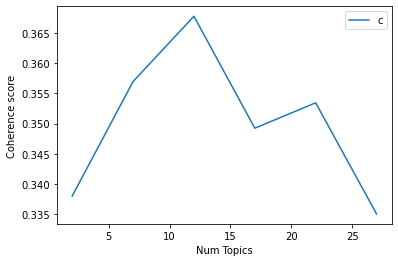

In [38]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.338
index: 1 | Num Topics = 7  has Coherence Value of 0.3569
index: 2 | Num Topics = 12  has Coherence Value of 0.3677
index: 3 | Num Topics = 17  has Coherence Value of 0.3492
index: 4 | Num Topics = 22  has Coherence Value of 0.3534
index: 5 | Num Topics = 27  has Coherence Value of 0.3351


In [40]:
# Select optimal number of topics
optimal_model_ph = model_list_ph[2]

In [41]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph = pyLDAvis.gensim_models.prepare(optimal_model_ph, corpus_ph, id2word_ph)

In [42]:
print("pyLDAVis for overall ph topics:")
vis_ph

pyLDAVis for overall ph topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.149514 -0.150975       1        1  21.699002
10     0.085222 -0.116228       2        1  13.431738
5      0.109200 -0.074188       3        1  12.827863
2      0.122150  0.195332       4        1  11.849545
3      0.094880  0.196922       5        1  10.030178
0      0.077488  0.000575       6        1   7.797386
8     -0.000931  0.074893       7        1   7.583683
9      0.026680 -0.063400       8        1   5.929730
7     -0.030077 -0.019814       9        1   3.987199
11    -0.136511 -0.102494      10        1   2.648310
4     -0.252224  0.038636      11        1   1.480917
1     -0.245390  0.020743      12        1   0.734449, topic_info=           Term        Freq       Total Category  logprob  loglift
21      account  580.000000  580.000000  Default  30.0000  30.0000
16        story  422.000000  422.000000  Default  29.0000  29.0000
32         post  461.000000  461.000000  Default  28.0000  28.0000
69        photo  270.000000  270.000000  Default  27.0000  27.0000
19       update  486.000000  486.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
167       world    0.554068   12.459237  Topic12  -5.7387   1.8009
892     promote    0.327890   19.895726  Topic12  -6.2633   0.8082
969   difficult    0.319769    2.295809  Topic12  -6.2884   2.9426
1793    manager    0.319769    2.519122  Topic12  -6.2884   2.8497
1911     handle    0.319769    2.046542  Topic12  -6.2884   3.0575

[715 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
297       1  0.426683  able
297       2  0.090509  able
297       3  0.219807  able
297       4  0.129298  able
297       8  0.077579  able
...     ...       ...   ...
187       3  0.213737   yet
187       6  0.178114   yet
187      10  0.178114   yet
81        3  0.439288  zoom
81        9  0.585717  zoom

[1038 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 11, 6, 3, 4, 1, 9, 10, 8, 12, 5, 2])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [43]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_ph_score1 = instagram_ios_ph_review_YearMonth_score1.review.values.tolist()
review_words_ph_score1 = list(sent_to_words(review_ph_score1))
print(review_words_ph_score1[:1])

[['hi', 'can', 'download', 'or', 'even', 'see', 'the', 'latest', 'version', 'of', 'the', 'instagram', 've', 'tried', 'many', 'scenarios', 'already', 'to', 'see', 'the', 'latest', 'version', 'but', 'nothing', 'has', 'changed', 'also', 'have', 'the', 'same', 'problem', 'with', 'castillodanii', 'about', 'the', 'font', 'stuff', 'only', 'have', 'the', 'plain', 'and', 'boring', 'font', 'please', 'fix', 'these', 'issues', 'as', 'soon', 'as', 'possible', 'will', 'wait', 'for', 'your', 'response']]


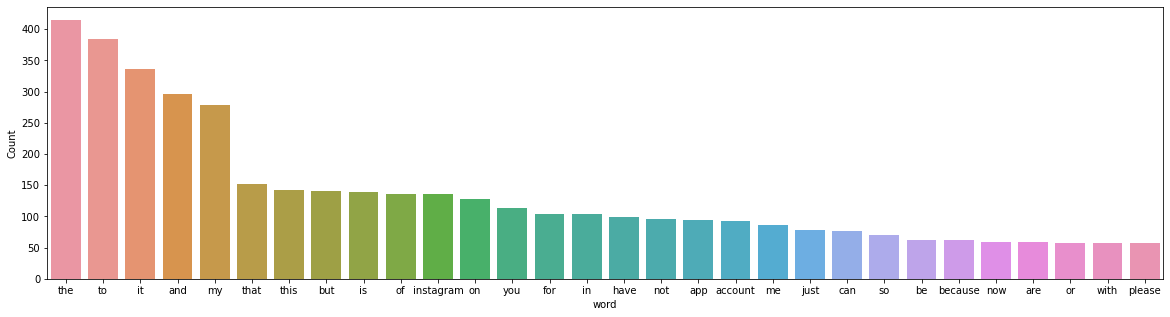

In [44]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1))

In [45]:
# Clean text
review_ph_ready_score1 = process_words(review_words_ph_score1)  # processed Text Data! - move to each section


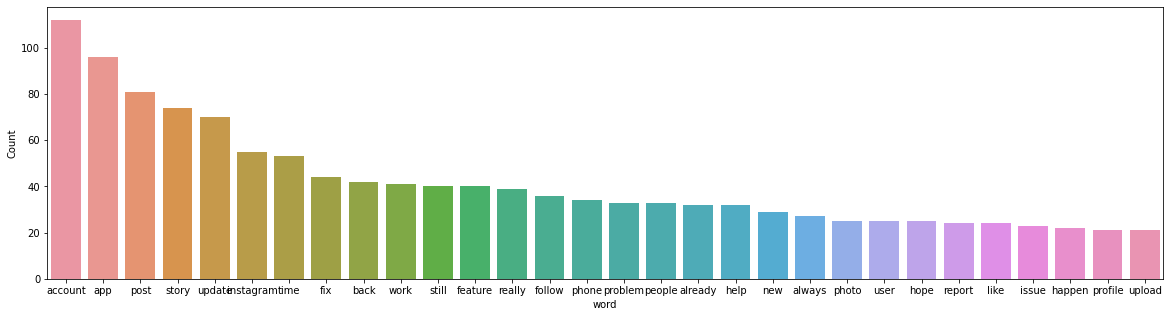

In [46]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1))


In [47]:
# Create Dictionary
id2word_ph_score1 = corpora.Dictionary(review_ph_ready_score1)

2021-10-16 01:56:41,229 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:56:41,256 [INFO] gensim.corpora.dictionary - built Dictionary(1031 unique tokens: ['already', 'boring', 'castillodanii', 'change', 'download']...) from 130 documents (total 4209 corpus positions)
2021-10-16 01:56:41,258 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1031 unique tokens: ['already', 'boring', 'castillodanii', 'change', 'download']...) from 130 documents (total 4209 corpus positions)", 'datetime': '2021-10-16T01:56:41.258262', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [48]:
# Create Corpus: Term Document Frequency
corpus_ph_score1 = [id2word_ph_score1.doc2bow(text) for text in review_ph_ready_score1]

In [49]:
# Training LDA model
model_list_ph_score1, coherence_values_ph_score1 = compute_coherence_values(dictionary=id2word_ph_score1, corpus=corpus_ph_score1, 
                                                              texts=review_ph_ready_score1, limit=30, start=2, step=5)


2021-10-16 01:56:41,307 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:56:41,311 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:56:41,315 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:56:41,322 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 130 documents, updating model once every 130 documents, evaluating perplexity every 130 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:56:41,892 [INFO] gensim.models.ldamodel - -7.500 per-word bound, 181.0 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:56:41,894 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #130/130
2021-10-16 01:56:42,371 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.017*"update" + 0.015*"story" + 0.014*"app" + 0.013*"post" + 0.012*"account" + 0.012*"instagram" + 0.01

2021-10-16 01:56:47,976 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"account" + 0.021*"app" + 0.017*"post" + 0.011*"work" + 0.010*"instagram" + 0.009*"still" + 0.009*"update" + 0.009*"story" + 0.009*"time" + 0.009*"feature"
2021-10-16 01:56:47,978 [INFO] gensim.models.ldamodel - topic diff=0.013469, rho=0.301511
2021-10-16 01:56:48,297 [INFO] gensim.models.ldamodel - -6.462 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:56:48,298 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #130/130
2021-10-16 01:56:48,538 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.020*"story" + 0.018*"update" + 0.016*"app" + 0.014*"post" + 0.013*"fix" + 0.012*"back" + 0.012*"instagram" + 0.012*"time" + 0.011*"really" + 0.009*"upload"
2021-10-16 01:56:48,540 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"account" + 0.021*"app" + 0.017*"post" + 0.011*"work" + 0.010*"instagram" + 0.010*"still" + 0.009*"upd

2021-10-16 01:56:53,539 [INFO] gensim.models.ldamodel - topic diff=0.006781, rho=0.218218
2021-10-16 01:56:53,808 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:56:53,809 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #130/130
2021-10-16 01:56:54,056 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"story" + 0.018*"update" + 0.016*"app" + 0.014*"post" + 0.013*"fix" + 0.012*"back" + 0.012*"instagram" + 0.012*"time" + 0.011*"really" + 0.009*"upload"
2021-10-16 01:56:54,063 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"account" + 0.021*"app" + 0.017*"post" + 0.011*"work" + 0.010*"instagram" + 0.010*"still" + 0.009*"update" + 0.009*"follow" + 0.009*"feature" + 0.009*"time"
2021-10-16 01:56:54,070 [INFO] gensim.models.ldamodel - topic diff=0.005941, rho=0.213201
2021-10-16 01:56:54,343 [INFO] gensim.models.ldamodel - -6.455 per-word bound, 87.7 perplex

2021-10-16 01:56:59,017 [INFO] gensim.models.ldamodel - -6.452 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:56:59,019 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #130/130
2021-10-16 01:56:59,254 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"story" + 0.018*"update" + 0.016*"app" + 0.015*"post" + 0.013*"fix" + 0.012*"back" + 0.012*"time" + 0.012*"instagram" + 0.011*"really" + 0.009*"upload"
2021-10-16 01:56:59,258 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"account" + 0.021*"app" + 0.016*"post" + 0.011*"work" + 0.010*"instagram" + 0.010*"still" + 0.009*"update" + 0.009*"follow" + 0.009*"feature" + 0.009*"time"
2021-10-16 01:56:59,260 [INFO] gensim.models.ldamodel - topic diff=0.003082, rho=0.176777
2021-10-16 01:56:59,503 [INFO] gensim.models.ldamodel - -6.452 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:56:

2021-10-16 01:57:04,820 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #130/130
2021-10-16 01:57:05,146 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"story" + 0.018*"update" + 0.016*"app" + 0.015*"post" + 0.013*"fix" + 0.012*"back" + 0.012*"time" + 0.012*"instagram" + 0.011*"really" + 0.009*"upload"
2021-10-16 01:57:05,148 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"account" + 0.021*"app" + 0.016*"post" + 0.011*"work" + 0.010*"instagram" + 0.010*"still" + 0.009*"follow" + 0.009*"update" + 0.009*"help" + 0.009*"feature"
2021-10-16 01:57:05,150 [INFO] gensim.models.ldamodel - topic diff=0.002043, rho=0.154303
2021-10-16 01:57:05,506 [INFO] gensim.models.ldamodel - -6.451 per-word bound, 87.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:05,507 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #130/130
2021-10-16 01:57:05,731 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"stor

2021-10-16 01:57:10,830 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:57:17,272 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:57:17,327 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 130 virtual documents
2021-10-16 01:57:17,768 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 01:57:17,772 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 01:57:17,783 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:57:17,787 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 130 documents, updating model once every 130 documents, evaluating perplexity every 130 documents, iterating 50x with a con

2021-10-16 01:57:20,920 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"app" + 0.021*"update" + 0.018*"post" + 0.018*"already" + 0.017*"time" + 0.017*"account" + 0.016*"problem" + 0.015*"download" + 0.013*"phone" + 0.012*"instagram"
2021-10-16 01:57:20,923 [INFO] gensim.models.ldamodel - topic diff=0.107055, rho=0.408248
2021-10-16 01:57:21,159 [INFO] gensim.models.ldamodel - -6.661 per-word bound, 101.2 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:21,161 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #130/130
2021-10-16 01:57:21,291 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"app" + 0.032*"account" + 0.020*"post" + 0.018*"work" + 0.016*"fix" + 0.015*"still" + 0.014*"instagram" + 0.013*"update" + 0.012*"time" + 0.010*"like"
2021-10-16 01:57:21,299 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"account" + 0.016*"story" + 0.014*"time" + 0.013*"instagram" + 0.012*"follow" + 0.012*"user" + 0.

2021-10-16 01:57:23,912 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"account" + 0.014*"time" + 0.013*"instagram" + 0.013*"follow" + 0.012*"user" + 0.012*"block" + 0.012*"story" + 0.011*"camera" + 0.011*"lose" + 0.010*"back"
2021-10-16 01:57:23,936 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.018*"update" + 0.014*"really" + 0.012*"back" + 0.011*"especially" + 0.009*"post" + 0.009*"people" + 0.009*"old" + 0.009*"new" + 0.009*"layout" + 0.009*"creator"
2021-10-16 01:57:23,938 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"upload" + 0.013*"post" + 0.012*"problem" + 0.012*"story" + 0.012*"feature" + 0.011*"fix"
2021-10-16 01:57:23,944 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"app" + 0.021*"update" + 0.018*"already" + 0.018*"post" + 0.017*"account" + 0.017*"time" + 0.016*"problem" + 0.015*"download" + 0.013*"phone" + 0.013*"instagram"
2021-10-16 01:57:23,946 [INFO] gensim.models.ldamo

2021-10-16 01:57:26,267 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"upload" + 0.013*"post" + 0.012*"problem" + 0.012*"story" + 0.012*"feature" + 0.011*"fix"
2021-10-16 01:57:26,269 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"app" + 0.022*"update" + 0.019*"already" + 0.018*"post" + 0.017*"time" + 0.017*"account" + 0.017*"problem" + 0.015*"download" + 0.013*"phone" + 0.013*"instagram"
2021-10-16 01:57:26,270 [INFO] gensim.models.ldamodel - topic diff=0.006908, rho=0.242536
2021-10-16 01:57:26,562 [INFO] gensim.models.ldamodel - -6.627 per-word bound, 98.9 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:26,565 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #130/130
2021-10-16 01:57:26,728 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.035*"app" + 0.032*"account" + 0.020*"post" + 0.017*"fix" + 0.017*"work" + 0.015*"still" + 0.014*"

2021-10-16 01:57:29,207 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #130/130
2021-10-16 01:57:29,417 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"post" + 0.013*"upload" + 0.012*"problem" + 0.012*"story" + 0.012*"feature" + 0.011*"fix"
2021-10-16 01:57:29,421 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.035*"app" + 0.032*"account" + 0.020*"post" + 0.017*"fix" + 0.017*"work" + 0.015*"still" + 0.014*"instagram" + 0.013*"update" + 0.013*"time" + 0.010*"like"
2021-10-16 01:57:29,425 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.014*"time" + 0.013*"instagram" + 0.013*"follow" + 0.013*"user" + 0.012*"block" + 0.011*"camera" + 0.011*"lose" + 0.010*"back" + 0.010*"number"
2021-10-16 01:57:29,429 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.024*"email" + 0.023*"account" + 0.016*"app" + 0.013*"send" + 0.012*"log" + 0.011*"always" + 0.010*"update" + 0.009*"video" + 

2021-10-16 01:57:31,654 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"update" + 0.014*"really" + 0.011*"back" + 0.011*"especially" + 0.009*"post" + 0.009*"people" + 0.009*"new" + 0.009*"old" + 0.009*"layout" + 0.009*"creator"
2021-10-16 01:57:31,657 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"post" + 0.013*"upload" + 0.013*"problem" + 0.012*"feature" + 0.012*"story" + 0.011*"fix"
2021-10-16 01:57:31,659 [INFO] gensim.models.ldamodel - topic diff=0.001748, rho=0.188982
2021-10-16 01:57:31,860 [INFO] gensim.models.ldamodel - -6.623 per-word bound, 98.6 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:31,862 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #130/130
2021-10-16 01:57:31,947 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"post" + 0.013*"upload" + 0.013*"

2021-10-16 01:57:33,871 [INFO] gensim.models.ldamodel - -6.623 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:33,873 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #130/130
2021-10-16 01:57:33,994 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"app" + 0.022*"update" + 0.019*"already" + 0.017*"time" + 0.016*"post" + 0.016*"account" + 0.016*"problem" + 0.015*"download" + 0.014*"phone" + 0.013*"instagram"
2021-10-16 01:57:33,997 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.014*"time" + 0.013*"instagram" + 0.013*"follow" + 0.013*"user" + 0.012*"block" + 0.011*"lose" + 0.011*"camera" + 0.010*"back" + 0.010*"number"
2021-10-16 01:57:34,003 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.035*"app" + 0.032*"account" + 0.020*"post" + 0.017*"fix" + 0.017*"work" + 0.015*"still" + 0.014*"instagram" + 0.013*"update" + 0.013*"time" + 0.010*"like"
2021-10-16 01:57:34,006 [INFO]

2021-10-16 01:57:36,169 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"update" + 0.014*"really" + 0.011*"especially" + 0.011*"back" + 0.009*"post" + 0.009*"people" + 0.009*"new" + 0.009*"old" + 0.009*"layout" + 0.009*"creator"
2021-10-16 01:57:36,171 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"post" + 0.013*"upload" + 0.013*"problem" + 0.012*"feature" + 0.012*"story" + 0.011*"fix"
2021-10-16 01:57:36,174 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.035*"app" + 0.032*"account" + 0.020*"post" + 0.017*"fix" + 0.017*"work" + 0.015*"still" + 0.014*"instagram" + 0.013*"update" + 0.013*"time" + 0.010*"like"
2021-10-16 01:57:36,180 [INFO] gensim.models.ldamodel - topic diff=0.000522, rho=0.160128
2021-10-16 01:57:36,381 [INFO] gensim.models.ldamodel - -6.622 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:36,382 [INFO] gensim.model

2021-10-16 01:57:38,035 [INFO] gensim.models.ldamodel - topic diff=0.000298, rho=0.150756
2021-10-16 01:57:38,262 [INFO] gensim.models.ldamodel - -6.622 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:38,263 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #130/130
2021-10-16 01:57:38,398 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"post" + 0.013*"upload" + 0.013*"problem" + 0.012*"feature" + 0.012*"story" + 0.011*"fix"
2021-10-16 01:57:38,402 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.014*"time" + 0.013*"instagram" + 0.013*"follow" + 0.013*"user" + 0.012*"block" + 0.011*"lose" + 0.011*"camera" + 0.010*"back" + 0.010*"number"
2021-10-16 01:57:38,404 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"update" + 0.014*"really" + 0.011*"especially" + 0.011*"back" + 0.009*"post" + 0.009*"people" + 0.

2021-10-16 01:57:40,346 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account" + 0.014*"time" + 0.013*"instagram" + 0.013*"follow" + 0.013*"user" + 0.012*"block" + 0.011*"lose" + 0.011*"camera" + 0.010*"back" + 0.010*"number"
2021-10-16 01:57:40,351 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"story" + 0.025*"post" + 0.016*"back" + 0.014*"app" + 0.012*"view" + 0.011*"account" + 0.010*"instagram" + 0.010*"fix" + 0.010*"people" + 0.009*"really"
2021-10-16 01:57:40,356 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.024*"email" + 0.023*"account" + 0.016*"app" + 0.013*"send" + 0.012*"log" + 0.011*"always" + 0.010*"update" + 0.009*"video" + 0.009*"explore" + 0.009*"country"
2021-10-16 01:57:40,362 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"update" + 0.016*"profile" + 0.014*"time" + 0.013*"link" + 0.013*"post" + 0.013*"upload" + 0.013*"problem" + 0.012*"feature" + 0.012*"story" + 0.011*"fix"
2021-10-16 01:57:40,363 [INFO] gensim.models.ldamodel - topi

2021-10-16 01:57:48,630 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.025*"app" + 0.022*"work" + 0.022*"update" + 0.020*"phone" + 0.018*"story" + 0.015*"instagram" + 0.015*"camera" + 0.013*"version" + 0.013*"restart" + 0.013*"filter"
2021-10-16 01:57:48,631 [INFO] gensim.models.ldamodel - topic diff=0.239644, rho=0.500000
2021-10-16 01:57:48,825 [INFO] gensim.models.ldamodel - -6.842 per-word bound, 114.7 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:48,833 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #130/130
2021-10-16 01:57:48,937 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"account" + 0.035*"app" + 0.018*"instagram" + 0.016*"post" + 0.014*"work" + 0.013*"fix" + 0.013*"still" + 0.013*"update" + 0.012*"follow" + 0.011*"story"
2021-10-16 01:57:48,943 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"account" + 0.026*"block" + 0.023*"time" + 0.021*"app" + 0.015*"post" + 0.014*"action" + 0.013

2021-10-16 01:57:50,745 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #130/130
2021-10-16 01:57:50,857 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.027*"delete" + 0.016*"profile" + 0.015*"upload" + 0.014*"view" + 0.013*"story" + 0.012*"account" + 0.012*"photo" + 0.012*"app" + 0.012*"object" + 0.012*"image"
2021-10-16 01:57:50,860 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"update" + 0.018*"picture" + 0.018*"story" + 0.018*"guideline" + 0.013*"horizontal" + 0.013*"still" + 0.013*"layout" + 0.013*"violate" + 0.013*"profile" + 0.013*"community"
2021-10-16 01:57:50,865 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.034*"account" + 0.029*"story" + 0.021*"time" + 0.017*"follow" + 0.017*"number" + 0.014*"back" + 0.013*"feature" + 0.013*"really" + 0.011*"app" + 0.011*"always"
2021-10-16 01:57:50,867 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.043*"story" + 0.030*"post" + 0.018*"back" + 0.017*"check" + 0.014*"people" + 0.013*"really" + 0.011*"vie

2021-10-16 01:57:52,637 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.027*"delete" + 0.016*"profile" + 0.016*"upload" + 0.014*"view" + 0.013*"story" + 0.012*"account" + 0.012*"photo" + 0.012*"app" + 0.012*"object" + 0.012*"image"
2021-10-16 01:57:52,639 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"back" + 0.017*"put" + 0.014*"hope" + 0.013*"message" + 0.013*"especially" + 0.013*"image" + 0.013*"roll" + 0.012*"really" + 0.010*"new" + 0.010*"update"
2021-10-16 01:57:52,641 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.024*"app" + 0.021*"phone" + 0.021*"work" + 0.021*"update" + 0.017*"story" + 0.015*"instagram" + 0.015*"restart" + 0.015*"change" + 0.015*"version" + 0.015*"camera"
2021-10-16 01:57:52,642 [INFO] gensim.models.ldamodel - topic diff=0.010370, rho=0.258199
2021-10-16 01:57:52,820 [INFO] gensim.models.ldamodel - -6.744 per-word bound, 107.2 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:52,824 [INFO] gen

2021-10-16 01:57:54,535 [INFO] gensim.models.ldamodel - topic diff=0.003563, rho=0.223607
2021-10-16 01:57:54,723 [INFO] gensim.models.ldamodel - -6.742 per-word bound, 107.0 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:54,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #130/130
2021-10-16 01:57:54,889 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"email" + 0.014*"user" + 0.014*"mode" + 0.014*"payment" + 0.014*"avail" + 0.014*"resolution" + 0.014*"reply" + 0.012*"report" + 0.012*"already" + 0.011*"help"
2021-10-16 01:57:54,891 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.034*"post" + 0.023*"account" + 0.022*"update" + 0.017*"instagram" + 0.017*"app" + 0.012*"really" + 0.011*"time" + 0.010*"email" + 0.010*"old" + 0.010*"fix"
2021-10-16 01:57:54,894 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"back" + 0.017*"put" + 0.014*"hope" + 0.013*"message" + 0.013*"especially" + 0.013*"image" + 0.013

2021-10-16 01:57:56,834 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"already" + 0.020*"time" + 0.020*"day" + 0.020*"problem" + 0.018*"feature" + 0.015*"post" + 0.015*"stop" + 0.015*"download" + 0.015*"new" + 0.013*"account"
2021-10-16 01:57:56,837 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"update" + 0.032*"account" + 0.021*"app" + 0.021*"download" + 0.017*"country" + 0.017*"io" + 0.017*"help" + 0.016*"phone" + 0.016*"already" + 0.016*"password"
2021-10-16 01:57:56,840 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"back" + 0.017*"put" + 0.014*"hope" + 0.013*"message" + 0.013*"especially" + 0.013*"image" + 0.013*"roll" + 0.012*"really" + 0.010*"new" + 0.010*"update"
2021-10-16 01:57:56,842 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"account" + 0.026*"block" + 0.023*"time" + 0.021*"app" + 0.015*"post" + 0.015*"action" + 0.014*"caption" + 0.012*"still" + 0.012*"fix" + 0.012*"lift"
2021-10-16 01:57:56,843 [INFO] gensim.models.ldamodel - topi

2021-10-16 01:57:58,769 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.034*"post" + 0.023*"account" + 0.022*"update" + 0.017*"instagram" + 0.017*"app" + 0.012*"really" + 0.011*"time" + 0.010*"email" + 0.010*"old" + 0.010*"fix"
2021-10-16 01:57:58,771 [INFO] gensim.models.ldamodel - topic diff=0.000797, rho=0.179605
2021-10-16 01:57:58,898 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:57:58,900 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #130/130
2021-10-16 01:57:58,977 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"update" + 0.032*"account" + 0.021*"app" + 0.021*"download" + 0.017*"country" + 0.017*"io" + 0.017*"help" + 0.016*"phone" + 0.016*"password" + 0.016*"already"
2021-10-16 01:57:58,980 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"account" + 0.026*"block" + 0.023*"time" + 0.021*"app" + 0.015*"post" + 0.015*"action" + 0.014*"c

2021-10-16 01:58:00,880 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.024*"app" + 0.021*"phone" + 0.021*"work" + 0.020*"update" + 0.017*"story" + 0.015*"instagram" + 0.015*"restart" + 0.015*"change" + 0.015*"version" + 0.015*"camera"
2021-10-16 01:58:00,881 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.044*"story" + 0.029*"post" + 0.018*"back" + 0.017*"check" + 0.014*"people" + 0.013*"really" + 0.012*"viewer" + 0.011*"always" + 0.011*"fix" + 0.010*"available"
2021-10-16 01:58:00,882 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.027*"delete" + 0.016*"profile" + 0.016*"upload" + 0.014*"view" + 0.013*"story" + 0.012*"photo" + 0.012*"account" + 0.012*"app" + 0.012*"object" + 0.012*"image"
2021-10-16 01:58:00,884 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"update" + 0.018*"picture" + 0.018*"story" + 0.018*"guideline" + 0.013*"still" + 0.013*"horizontal" + 0.013*"layout" + 0.013*"violate" + 0.013*"profile" + 0.013*"community"
2021-10-16 01:58:00,886 [INFO] gen

2021-10-16 01:58:02,700 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"account" + 0.026*"block" + 0.023*"time" + 0.021*"app" + 0.015*"post" + 0.015*"action" + 0.014*"caption" + 0.012*"still" + 0.012*"fix" + 0.012*"lift"
2021-10-16 01:58:02,701 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.037*"app" + 0.036*"account" + 0.018*"instagram" + 0.017*"post" + 0.015*"work" + 0.013*"fix" + 0.013*"still" + 0.013*"update" + 0.012*"story" + 0.011*"problem"
2021-10-16 01:58:02,703 [INFO] gensim.models.ldamodel - topic diff=0.000264, rho=0.154303
2021-10-16 01:58:02,902 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:02,903 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #130/130
2021-10-16 01:58:03,040 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"already" + 0.020*"time" + 0.020*"day" + 0.020*"problem" + 0.018*"feature" + 0.015*"post" + 0.015*"stop

2021-10-16 01:58:04,434 [INFO] gensim.models.ldamodel - topic diff=0.000176, rho=0.145865
2021-10-16 01:58:04,607 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:04,609 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #130/130
2021-10-16 01:58:04,757 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"email" + 0.014*"user" + 0.014*"payment" + 0.014*"avail" + 0.014*"mode" + 0.014*"resolution" + 0.014*"reply" + 0.012*"report" + 0.011*"already" + 0.011*"help"
2021-10-16 01:58:04,759 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.027*"delete" + 0.016*"profile" + 0.016*"upload" + 0.014*"view" + 0.013*"story" + 0.012*"photo" + 0.012*"account" + 0.012*"object" + 0.012*"image" + 0.012*"app"
2021-10-16 01:58:04,760 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"account" + 0.026*"block" + 0.023*"time" + 0.021*"app" + 0.015*"post" + 0.015*"action" + 0.01

2021-10-16 01:58:14,024 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.034*"app" + 0.025*"account" + 0.020*"post" + 0.017*"update" + 0.016*"work" + 0.015*"fix" + 0.015*"follow" + 0.015*"like" + 0.014*"still" + 0.013*"instagram"
2021-10-16 01:58:14,025 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.020*"really" + 0.016*"back" + 0.016*"show" + 0.016*"story" + 0.015*"update" + 0.013*"problem" + 0.012*"app" + 0.012*"post" + 0.011*"time" + 0.010*"people"
2021-10-16 01:58:14,027 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"post" + 0.016*"fix" + 0.014*"show" + 0.014*"update" + 0.013*"link" + 0.012*"user" + 0.011*"mode" + 0.011*"avail" + 0.011*"fine" + 0.011*"payment"
2021-10-16 01:58:14,029 [INFO] gensim.models.ldamodel - topic diff=12.315314, rho=1.000000
2021-10-16 01:58:14,198 [INFO] gensim.models.ldamodel - -7.230 per-word bound, 150.2 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:14,200 [INFO] gensim.models.ldamode

2021-10-16 01:58:15,897 [INFO] gensim.models.ldamodel - topic diff=0.119964, rho=0.377964
2021-10-16 01:58:16,088 [INFO] gensim.models.ldamodel - -6.837 per-word bound, 114.3 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:16,093 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #130/130
2021-10-16 01:58:16,180 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"post" + 0.023*"account" + 0.022*"app" + 0.021*"instagram" + 0.021*"update" + 0.020*"time" + 0.020*"really" + 0.018*"always" + 0.014*"explore" + 0.013*"happen"
2021-10-16 01:58:16,182 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.069*"account" + 0.033*"number" + 0.025*"still" + 0.019*"fix" + 0.018*"follow" + 0.018*"password" + 0.015*"back" + 0.015*"activity" + 0.014*"anymore" + 0.011*"change"
2021-10-16 01:58:16,184 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.020*"upload" + 0.019*"work" + 0.016*"time" + 0.015*"object" + 0.015*"story" + 0.015*"photo" 

2021-10-16 01:58:17,982 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"post" + 0.023*"account" + 0.022*"app" + 0.021*"instagram" + 0.021*"time" + 0.021*"update" + 0.020*"really" + 0.019*"always" + 0.014*"explore" + 0.013*"happen"
2021-10-16 01:58:17,999 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.018*"update" + 0.016*"show" + 0.015*"really" + 0.015*"back" + 0.014*"put" + 0.013*"problem" + 0.011*"app" + 0.011*"time" + 0.011*"people" + 0.011*"message"
2021-10-16 01:58:18,006 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.020*"upload" + 0.019*"work" + 0.017*"time" + 0.015*"object" + 0.015*"story" + 0.015*"photo" + 0.015*"image" + 0.015*"profile" + 0.015*"happen" + 0.015*"stop"
2021-10-16 01:58:18,008 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.058*"account" + 0.026*"people" + 0.020*"instagram" + 0.020*"phone" + 0.020*"disabled" + 0.020*"app" + 0.013*"highlight" + 0.013*"social" + 0.013*"work" + 0.013*"happen"
2021-10-16 01:58:18,010 [INFO] gensim.models.lda

2021-10-16 01:58:19,784 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.045*"live" + 0.029*"video" + 0.023*"minute" + 0.023*"really" + 0.023*"hard" + 0.012*"feature" + 0.012*"instagram" + 0.012*"time" + 0.012*"appreciate" + 0.012*"upload"
2021-10-16 01:58:19,786 [INFO] gensim.models.ldamodel - topic diff=0.004803, rho=0.235702
2021-10-16 01:58:19,977 [INFO] gensim.models.ldamodel - -6.814 per-word bound, 112.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:19,978 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #130/130
2021-10-16 01:58:20,134 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.042*"app" + 0.023*"update" + 0.022*"day" + 0.022*"account" + 0.016*"post" + 0.016*"download" + 0.016*"story" + 0.016*"new" + 0.013*"phone" + 0.013*"io"
2021-10-16 01:58:20,136 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.037*"app" + 0.024*"post" + 0.024*"account" + 0.021*"fix" + 0.018*"update" + 0.016*"like" + 0.015*"work

2021-10-16 01:58:22,016 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.021*"update" + 0.021*"story" + 0.021*"filter" + 0.018*"work" + 0.018*"new" + 0.018*"camera" + 0.015*"app" + 0.014*"install" + 0.013*"feature" + 0.011*"photo"
2021-10-16 01:58:22,021 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.035*"post" + 0.027*"fix" + 0.026*"let" + 0.025*"link" + 0.025*"profile" + 0.021*"update" + 0.013*"allow" + 0.013*"show" + 0.013*"user" + 0.013*"avail"
2021-10-16 01:58:22,026 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.058*"account" + 0.026*"people" + 0.020*"instagram" + 0.020*"phone" + 0.020*"disabled" + 0.020*"app" + 0.013*"social" + 0.013*"happen" + 0.013*"sense" + 0.013*"work"
2021-10-16 01:58:22,028 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.039*"story" + 0.031*"post" + 0.020*"back" + 0.018*"people" + 0.018*"check" + 0.013*"ever" + 0.013*"follow" + 0.013*"really" + 0.013*"log" + 0.011*"reason"
2021-10-16 01:58:22,030 [INFO] gensim.models.ldamodel - topic #1

2021-10-16 01:58:24,020 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.042*"app" + 0.023*"update" + 0.022*"account" + 0.022*"day" + 0.016*"post" + 0.016*"download" + 0.016*"story" + 0.016*"new" + 0.013*"phone" + 0.013*"io"
2021-10-16 01:58:24,022 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.018*"update" + 0.016*"show" + 0.015*"really" + 0.015*"back" + 0.014*"put" + 0.013*"problem" + 0.011*"app" + 0.011*"time" + 0.011*"people" + 0.011*"message"
2021-10-16 01:58:24,024 [INFO] gensim.models.ldamodel - topic diff=0.000898, rho=0.185695
2021-10-16 01:58:24,193 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:24,194 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #130/130
2021-10-16 01:58:24,330 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.027*"report" + 0.027*"guideline" + 0.021*"still" + 0.021*"violate" + 0.021*"feedback" + 0.021*"profile" + 0.021*"

2021-10-16 01:58:26,008 [INFO] gensim.models.ldamodel - -6.811 per-word bound, 112.3 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:26,009 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #130/130
2021-10-16 01:58:26,142 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.039*"story" + 0.031*"post" + 0.020*"back" + 0.018*"people" + 0.018*"check" + 0.013*"ever" + 0.013*"follow" + 0.013*"really" + 0.013*"log" + 0.011*"reason"
2021-10-16 01:58:26,143 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.034*"story" + 0.023*"video" + 0.023*"send" + 0.023*"view" + 0.017*"email" + 0.017*"always" + 0.017*"person" + 0.017*"avail" + 0.012*"country" + 0.012*"thing"
2021-10-16 01:58:26,145 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.027*"account" + 0.022*"help" + 0.016*"app" + 0.016*"ask" + 0.016*"problem" + 0.011*"version" + 0.011*"small" + 0.011*"screen" + 0.011*"optimize" + 0.011*"service"
2021-10-16 01:58:26,148 [INFO] gen

2021-10-16 01:58:27,897 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.025*"filter" + 0.022*"update" + 0.022*"story" + 0.022*"camera" + 0.018*"work" + 0.017*"new" + 0.016*"photo" + 0.014*"app" + 0.014*"install" + 0.013*"roll"
2021-10-16 01:58:27,900 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.042*"app" + 0.024*"update" + 0.023*"account" + 0.022*"day" + 0.016*"post" + 0.016*"download" + 0.016*"story" + 0.016*"new" + 0.013*"phone" + 0.013*"io"
2021-10-16 01:58:27,902 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"post" + 0.022*"account" + 0.021*"app" + 0.021*"instagram" + 0.021*"really" + 0.021*"time" + 0.020*"update" + 0.019*"always" + 0.014*"explore" + 0.013*"happen"
2021-10-16 01:58:27,907 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.034*"story" + 0.023*"video" + 0.023*"send" + 0.023*"view" + 0.017*"email" + 0.017*"always" + 0.017*"person" + 0.017*"avail" + 0.012*"country" + 0.012*"thing"
2021-10-16 01:58:27,909 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 01:58:29,652 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.035*"post" + 0.027*"fix" + 0.026*"let" + 0.026*"link" + 0.025*"profile" + 0.021*"update" + 0.013*"allow" + 0.013*"show" + 0.013*"user" + 0.013*"payment"
2021-10-16 01:58:29,653 [INFO] gensim.models.ldamodel - topic diff=0.000340, rho=0.149071
2021-10-16 01:58:29,833 [INFO] gensim.models.ldamodel - -6.810 per-word bound, 112.2 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:29,836 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #130/130
2021-10-16 01:58:29,940 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.035*"post" + 0.027*"fix" + 0.026*"let" + 0.026*"link" + 0.025*"profile" + 0.021*"update" + 0.013*"allow" + 0.013*"show" + 0.013*"user" + 0.013*"payment"
2021-10-16 01:58:29,942 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.020*"upload" + 0.019*"work" + 0.017*"time" + 0.015*"object" + 0.015*"story" + 0.015*"photo" + 0.015*"image" + 0.0

2021-10-16 01:58:32,215 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.058*"account" + 0.026*"people" + 0.020*"instagram" + 0.020*"phone" + 0.020*"disabled" + 0.020*"app" + 0.013*"social" + 0.013*"work" + 0.013*"feature" + 0.013*"log"
2021-10-16 01:58:32,217 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.018*"update" + 0.016*"show" + 0.015*"really" + 0.015*"back" + 0.014*"put" + 0.013*"problem" + 0.011*"app" + 0.011*"time" + 0.011*"people" + 0.011*"message"
2021-10-16 01:58:32,222 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.042*"app" + 0.024*"update" + 0.023*"account" + 0.022*"day" + 0.016*"post" + 0.016*"download" + 0.016*"story" + 0.016*"new" + 0.013*"phone" + 0.013*"io"
2021-10-16 01:58:32,224 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.026*"filter" + 0.023*"story" + 0.023*"update" + 0.022*"camera" + 0.018*"work" + 0.017*"new" + 0.017*"photo" + 0.014*"app" + 0.014*"install" + 0.013*"roll"
2021-10-16 01:58:32,227 [INFO] gensim.models.ldamodel - topic #7 (0

2021-10-16 01:58:42,916 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.028*"update" + 0.023*"new" + 0.019*"stop" + 0.019*"already" + 0.019*"day" + 0.015*"app" + 0.015*"download" + 0.014*"region" + 0.014*"way" + 0.013*"layout"
2021-10-16 01:58:42,918 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.027*"time" + 0.026*"block" + 0.022*"picture" + 0.017*"suspend" + 0.016*"small" + 0.016*"lift" + 0.013*"version" + 0.012*"account" + 0.011*"already" + 0.011*"app"
2021-10-16 01:58:42,919 [INFO] gensim.models.ldamodel - topic diff=0.251197, rho=0.447214
2021-10-16 01:58:43,146 [INFO] gensim.models.ldamodel - -7.002 per-word bound, 128.1 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:43,147 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #130/130
2021-10-16 01:58:43,221 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.022*"time" + 0.019*"live" + 0.019*"profile" + 0.019*"guideline" + 0.018*"post" + 0.017*"really" + 0.017*

2021-10-16 01:58:44,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #130/130
2021-10-16 01:58:44,789 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"account" + 0.025*"post" + 0.024*"app" + 0.023*"instagram" + 0.018*"time" + 0.017*"update" + 0.014*"email" + 0.014*"look" + 0.013*"really" + 0.012*"always"
2021-10-16 01:58:44,791 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.042*"post" + 0.020*"user" + 0.018*"picture" + 0.017*"people" + 0.016*"follow" + 0.016*"show" + 0.015*"story" + 0.013*"app" + 0.013*"ever" + 0.013*"update"
2021-10-16 01:58:44,793 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.034*"story" + 0.031*"app" + 0.027*"back" + 0.024*"update" + 0.014*"time" + 0.014*"still" + 0.014*"give" + 0.014*"feature" + 0.014*"friend" + 0.014*"viewer"
2021-10-16 01:58:44,795 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.052*"account" + 0.032*"app" + 0.019*"problem" + 0.018*"help" + 0.018*"post" + 0.017*"still" + 0.017*"update" + 0.017*"fix" + 0.0

2021-10-16 01:58:46,789 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.032*"number" + 0.027*"account" + 0.023*"lose" + 0.023*"follow" + 0.018*"back" + 0.018*"tiktok" + 0.018*"activity" + 0.018*"time" + 0.018*"already" + 0.018*"feature"
2021-10-16 01:58:46,790 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.052*"account" + 0.032*"app" + 0.019*"problem" + 0.018*"help" + 0.018*"post" + 0.017*"still" + 0.017*"fix" + 0.017*"update" + 0.016*"work" + 0.014*"instagram"
2021-10-16 01:58:46,792 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.051*"post" + 0.025*"story" + 0.022*"back" + 0.021*"check" + 0.021*"really" + 0.019*"app" + 0.018*"put" + 0.015*"caption" + 0.015*"feed" + 0.015*"update"
2021-10-16 01:58:46,793 [INFO] gensim.models.ldamodel - topic diff=0.011424, rho=0.250000
2021-10-16 01:58:47,036 [INFO] gensim.models.ldamodel - -6.903 per-word bound, 119.7 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:47,038 [INFO] gensim.mod

2021-10-16 01:58:48,662 [INFO] gensim.models.ldamodel - topic diff=0.003565, rho=0.218218
2021-10-16 01:58:48,890 [INFO] gensim.models.ldamodel - -6.902 per-word bound, 119.6 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:48,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #130/130
2021-10-16 01:58:49,024 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.029*"especially" + 0.029*"image" + 0.020*"back" + 0.020*"choose" + 0.020*"freedom" + 0.020*"size" + 0.020*"photo" + 0.020*"multiple" + 0.020*"customer" + 0.020*"upload"
2021-10-16 01:58:49,025 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.052*"account" + 0.032*"app" + 0.019*"problem" + 0.018*"help" + 0.018*"post" + 0.017*"still" + 0.017*"fix" + 0.017*"update" + 0.015*"work" + 0.014*"instagram"
2021-10-16 01:58:49,027 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"account" + 0.024*"app" + 0.024*"post" + 0.023*"instagram" + 0.018*"time" + 0.017*"update"

2021-10-16 01:58:50,664 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.036*"story" + 0.031*"app" + 0.028*"back" + 0.024*"update" + 0.014*"time" + 0.014*"still" + 0.014*"give" + 0.014*"feature" + 0.014*"friend" + 0.014*"viewer"
2021-10-16 01:58:50,667 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.032*"number" + 0.027*"account" + 0.023*"lose" + 0.023*"follow" + 0.018*"back" + 0.018*"tiktok" + 0.018*"activity" + 0.018*"time" + 0.018*"already" + 0.018*"feature"
2021-10-16 01:58:50,670 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.027*"camera" + 0.026*"account" + 0.025*"story" + 0.018*"well" + 0.018*"problem" + 0.018*"already" + 0.017*"instagram" + 0.017*"issue" + 0.014*"app" + 0.014*"save"
2021-10-16 01:58:50,672 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"story" + 0.030*"work" + 0.019*"phone" + 0.019*"update" + 0.019*"instagram" + 0.019*"photo" + 0.015*"feature" + 0.015*"filter" + 0.015*"restart" + 0.015*"profile"
2021-10-16 01:58:50,673 [INFO] gensim.mode

2021-10-16 01:58:52,587 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.047*"upload" + 0.033*"profile" + 0.030*"photo" + 0.028*"happen" + 0.027*"comment" + 0.024*"fix" + 0.023*"write" + 0.022*"caption" + 0.022*"block" + 0.020*"problem"
2021-10-16 01:58:52,588 [INFO] gensim.models.ldamodel - topic diff=0.000783, rho=0.176777
2021-10-16 01:58:52,782 [INFO] gensim.models.ldamodel - -6.899 per-word bound, 119.4 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:52,783 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #130/130
2021-10-16 01:58:52,885 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.073*"account" + 0.024*"block" + 0.022*"instagram" + 0.019*"company" + 0.017*"still" + 0.017*"action" + 0.014*"always" + 0.013*"app" + 0.013*"disabled" + 0.013*"report"
2021-10-16 01:58:52,892 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.025*"time" + 0.021*"post" + 0.019*"live" + 0.019*"profile" + 0.019*"guideline" + 0.018*"

2021-10-16 01:58:54,965 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #130/130
2021-10-16 01:58:55,152 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.028*"update" + 0.024*"new" + 0.019*"stop" + 0.019*"already" + 0.019*"day" + 0.014*"app" + 0.014*"download" + 0.014*"region" + 0.014*"way" + 0.014*"layout"
2021-10-16 01:58:55,156 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"story" + 0.030*"work" + 0.019*"phone" + 0.019*"update" + 0.019*"instagram" + 0.019*"photo" + 0.015*"feature" + 0.015*"filter" + 0.015*"restart" + 0.015*"profile"
2021-10-16 01:58:55,160 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.052*"account" + 0.032*"app" + 0.019*"problem" + 0.018*"help" + 0.018*"post" + 0.017*"still" + 0.017*"fix" + 0.017*"update" + 0.015*"work" + 0.014*"instagram"
2021-10-16 01:58:55,162 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.029*"especially" + 0.029*"image" + 0.020*"back" + 0.020*"choose" + 0.020*"freedom" + 0.020*"size" + 0.020*"photo" + 0.0

2021-10-16 01:58:57,403 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.039*"app" + 0.039*"phone" + 0.039*"people" + 0.023*"log" + 0.016*"work" + 0.016*"instagram" + 0.016*"social" + 0.016*"properly" + 0.016*"add" + 0.008*"fix"
2021-10-16 01:58:57,406 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"story" + 0.028*"back" + 0.023*"app" + 0.019*"time" + 0.019*"user" + 0.019*"account" + 0.019*"feature" + 0.019*"view" + 0.019*"follow" + 0.019*"link"
2021-10-16 01:58:57,407 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.053*"app" + 0.044*"download" + 0.044*"io" + 0.035*"time" + 0.035*"update" + 0.026*"help" + 0.026*"phone" + 0.018*"problem" + 0.018*"show" + 0.018*"screen"
2021-10-16 01:58:57,408 [INFO] gensim.models.ldamodel - topic diff=0.000356, rho=0.152499
2021-10-16 01:58:57,669 [INFO] gensim.models.ldamodel - -6.897 per-word bound, 119.2 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:57,671 [INFO] gensim.models.ldamo

2021-10-16 01:58:59,391 [INFO] gensim.models.ldamodel - topic diff=0.000278, rho=0.144338
2021-10-16 01:58:59,555 [INFO] gensim.models.ldamodel - -6.897 per-word bound, 119.2 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:58:59,556 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #130/130
2021-10-16 01:58:59,653 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.042*"post" + 0.020*"user" + 0.018*"picture" + 0.017*"people" + 0.016*"follow" + 0.016*"show" + 0.015*"story" + 0.013*"app" + 0.013*"ever" + 0.013*"update"
2021-10-16 01:58:59,655 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"story" + 0.028*"back" + 0.023*"app" + 0.019*"time" + 0.019*"user" + 0.019*"account" + 0.019*"follow" + 0.019*"view" + 0.019*"feature" + 0.019*"link"
2021-10-16 01:58:59,658 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.028*"update" + 0.024*"new" + 0.019*"stop" + 0.019*"day" + 0.019*"already" + 0.014*"app" + 0.014*"download" + 0

2021-10-16 01:59:12,535 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.031*"post" + 0.021*"people" + 0.017*"country" + 0.017*"available" + 0.016*"pop" + 0.016*"week" + 0.016*"instagram" + 0.014*"sometimes" + 0.013*"account" + 0.012*"less"
2021-10-16 01:59:12,538 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.032*"post" + 0.023*"account" + 0.017*"time" + 0.016*"instagram" + 0.016*"update" + 0.014*"day" + 0.014*"app" + 0.014*"love" + 0.012*"already" + 0.011*"old"
2021-10-16 01:59:12,540 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.037*"account" + 0.029*"user" + 0.023*"password" + 0.016*"payment" + 0.016*"avail" + 0.016*"mode" + 0.015*"back" + 0.015*"phone" + 0.015*"forgot" + 0.015*"already"
2021-10-16 01:59:12,542 [INFO] gensim.models.ldamodel - topic diff=0.310049, rho=0.577350
2021-10-16 01:59:12,799 [INFO] gensim.models.ldamodel - -7.223 per-word bound, 149.3 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:59:12,800 [INFO

2021-10-16 01:59:14,798 [INFO] gensim.models.ldamodel - topic diff=0.104715, rho=0.353553
2021-10-16 01:59:15,055 [INFO] gensim.models.ldamodel - -6.953 per-word bound, 123.9 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:59:15,057 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #130/130
2021-10-16 01:59:15,209 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.030*"post" + 0.022*"people" + 0.015*"country" + 0.015*"available" + 0.015*"pop" + 0.015*"week" + 0.015*"instagram" + 0.015*"sometimes" + 0.015*"account" + 0.015*"less"
2021-10-16 01:59:15,212 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.038*"story" + 0.033*"camera" + 0.028*"filter" + 0.024*"phone" + 0.024*"update" + 0.018*"video" + 0.018*"roll" + 0.015*"feature" + 0.014*"fix" + 0.014*"app"
2021-10-16 01:59:15,214 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"post" + 0.023*"account" + 0.017*"time" + 0.017*"instagram" + 0.017*"day" + 0.016*"love" + 0.

2021-10-16 01:59:17,694 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.048*"post" + 0.043*"story" + 0.028*"back" + 0.024*"really" + 0.022*"check" + 0.021*"suggest" + 0.015*"news" + 0.015*"people" + 0.015*"bring" + 0.015*"explore"
2021-10-16 01:59:17,696 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.034*"account" + 0.030*"time" + 0.030*"block" + 0.020*"lift" + 0.017*"still" + 0.015*"story" + 0.015*"view" + 0.015*"business" + 0.015*"action" + 0.014*"date"
2021-10-16 01:59:17,709 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.025*"always" + 0.025*"explore" + 0.020*"follow" + 0.020*"really" + 0.020*"story" + 0.020*"account" + 0.020*"post" + 0.020*"page" + 0.015*"add" + 0.015*"time"
2021-10-16 01:59:17,711 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.031*"update" + 0.022*"back" + 0.013*"especially" + 0.013*"put" + 0.013*"post" + 0.013*"message" + 0.013*"app" + 0.013*"image" + 0.013*"old" + 0.013*"new"
2021-10-16 01:59:17,713 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 01:59:20,195 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.025*"always" + 0.025*"explore" + 0.020*"follow" + 0.020*"really" + 0.020*"story" + 0.020*"account" + 0.020*"post" + 0.020*"page" + 0.015*"add" + 0.015*"time"
2021-10-16 01:59:20,196 [INFO] gensim.models.ldamodel - topic diff=0.005599, rho=0.229416
2021-10-16 01:59:20,365 [INFO] gensim.models.ldamodel - -6.926 per-word bound, 121.6 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:59:20,367 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #130/130
2021-10-16 01:59:20,557 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.061*"post" + 0.031*"dyslexic" + 0.031*"issue" + 0.016*"recently" + 0.016*"comment" + 0.016*"update" + 0.016*"work" + 0.016*"edit" + 0.016*"various" + 0.016*"photo"
2021-10-16 01:59:20,561 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.047*"block" + 0.038*"company" + 0.027*"comment" + 0.021*"time" + 0.019*"item" + 0.019*"instagram

2021-10-16 01:59:23,096 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.044*"guideline" + 0.033*"story" + 0.033*"violate" + 0.033*"community" + 0.033*"profile" + 0.022*"archived" + 0.022*"report" + 0.022*"inappropriate" + 0.011*"update" + 0.011*"new"
2021-10-16 01:59:23,111 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.036*"account" + 0.035*"app" + 0.029*"help" + 0.022*"update" + 0.018*"instagram" + 0.017*"still" + 0.013*"phone" + 0.012*"fix" + 0.012*"hope" + 0.012*"download"
2021-10-16 01:59:23,118 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.048*"post" + 0.043*"story" + 0.028*"back" + 0.024*"really" + 0.022*"check" + 0.021*"suggest" + 0.015*"news" + 0.015*"explore" + 0.015*"people" + 0.015*"bring"
2021-10-16 01:59:23,136 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"post" + 0.023*"account" + 0.017*"time" + 0.017*"instagram" + 0.017*"day" + 0.016*"love" + 0.015*"update" + 0.013*"already" + 0.012*"app" + 0.012*"email"
2021-10-16 01:59:23,143 [INFO] gensim.mo

2021-10-16 01:59:25,279 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.025*"always" + 0.025*"explore" + 0.020*"follow" + 0.020*"really" + 0.020*"story" + 0.020*"account" + 0.020*"post" + 0.020*"page" + 0.015*"time" + 0.015*"spam"
2021-10-16 01:59:25,282 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.052*"activity" + 0.040*"follow" + 0.039*"version" + 0.026*"small" + 0.026*"optimize" + 0.026*"screen" + 0.026*"johnappleseed" + 0.026*"status" + 0.013*"update" + 0.013*"text"
2021-10-16 01:59:25,286 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.072*"account" + 0.036*"delete" + 0.024*"highlight" + 0.024*"work" + 0.024*"appeal" + 0.024*"feature" + 0.012*"action" + 0.012*"review" + 0.012*"people" + 0.012*"personal"
2021-10-16 01:59:25,287 [INFO] gensim.models.ldamodel - topic diff=0.000592, rho=0.182574
2021-10-16 01:59:25,533 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16

2021-10-16 01:59:27,415 [INFO] gensim.models.ldamodel - topic diff=0.000242, rho=0.169031
2021-10-16 01:59:27,656 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:59:27,657 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #130/130
2021-10-16 01:59:27,930 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.058*"tiktok" + 0.043*"update" + 0.029*"user" + 0.029*"hate" + 0.029*"new" + 0.029*"way" + 0.029*"back" + 0.029*"lose" + 0.015*"app" + 0.015*"photo"
2021-10-16 01:59:27,938 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.030*"app" + 0.030*"follow" + 0.025*"time" + 0.020*"update" + 0.020*"fix" + 0.015*"new" + 0.015*"month" + 0.015*"post" + 0.015*"problem" + 0.015*"instagram"
2021-10-16 01:59:27,941 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.072*"account" + 0.036*"delete" + 0.024*"highlight" + 0.024*"work" + 0.024*"appeal" + 0.024*"feature" + 0.012*"action

2021-10-16 01:59:29,797 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.038*"account" + 0.030*"user" + 0.023*"password" + 0.015*"payment" + 0.015*"avail" + 0.015*"mode" + 0.015*"back" + 0.015*"phone" + 0.015*"forgot" + 0.015*"already"
2021-10-16 01:59:29,802 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"post" + 0.023*"account" + 0.017*"day" + 0.017*"time" + 0.017*"instagram" + 0.016*"love" + 0.015*"update" + 0.013*"already" + 0.012*"app" + 0.012*"email"
2021-10-16 01:59:29,803 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.025*"always" + 0.025*"explore" + 0.020*"follow" + 0.020*"really" + 0.020*"story" + 0.020*"account" + 0.020*"post" + 0.020*"page" + 0.015*"time" + 0.015*"spam"
2021-10-16 01:59:29,806 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.081*"number" + 0.033*"change" + 0.033*"back" + 0.033*"remove" + 0.033*"mobile" + 0.017*"account" + 0.017*"personal" + 0.017*"time" + 0.017*"soon" + 0.017*"put"
2021-10-16 01:59:29,809 [INFO] gensim.models.ldamodel 

2021-10-16 01:59:32,801 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.072*"account" + 0.036*"delete" + 0.024*"highlight" + 0.024*"work" + 0.024*"appeal" + 0.024*"feature" + 0.012*"action" + 0.012*"people" + 0.012*"review" + 0.012*"unexpectedly"
2021-10-16 01:59:32,802 [INFO] gensim.models.ldamodel - topic diff=0.000053, rho=0.147442
2021-10-16 01:59:33,165 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 130 documents with 4209 words
2021-10-16 01:59:33,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #130/130
2021-10-16 01:59:33,324 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.057*"story" + 0.033*"back" + 0.033*"work" + 0.029*"app" + 0.020*"time" + 0.016*"view" + 0.016*"link" + 0.016*"download" + 0.016*"error" + 0.016*"uninstall"
2021-10-16 01:59:33,327 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.081*"number" + 0.033*"change" + 0.033*"back" + 0.033*"remove" + 0.033*"mobile" + 0.017*"a

2021-10-16 01:59:35,748 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:59:43,106 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:59:43,254 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 130 virtual documents


In [50]:
%store model_list_ph_score1
%store coherence_values_ph_score1

Stored 'model_list_ph_score1' (list)
Stored 'coherence_values_ph_score1' (list)


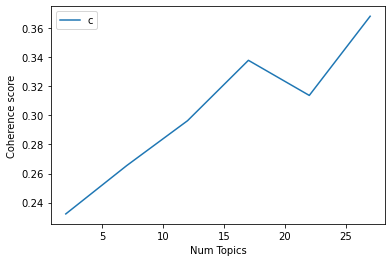

In [51]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2322
index: 1 | Num Topics = 7  has Coherence Value of 0.2654
index: 2 | Num Topics = 12  has Coherence Value of 0.2964
index: 3 | Num Topics = 17  has Coherence Value of 0.3379
index: 4 | Num Topics = 22  has Coherence Value of 0.3138
index: 5 | Num Topics = 27  has Coherence Value of 0.3682


In [53]:
# Select optimal number of topics
optimal_model_ph_score1 = model_list_ph_score1[5]

In [54]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1, corpus_ph_score1, id2word_ph_score1)

In [55]:
print("pyLDAVis for ph topics for score=1:")
vis_ph_score1

pyLDAVis for ph topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.075418 -0.000542       1        1  11.300377
6     -0.115696  0.002940       2        1  11.022177
22    -0.172324 -0.018739       3        1   7.627458
14    -0.107971 -0.036603       4        1   7.393048
5     -0.062875  0.191361       5        1   6.863358
23    -0.117364 -0.074621       6        1   6.268234
18    -0.114272 -0.021138       7        1   4.892142
4      0.078359  0.186927       8        1   4.509033
11    -0.078658  0.034965       9        1   4.168419
25    -0.050360  0.025987      10        1   3.915653
10    -0.064461 -0.086799      11        1   3.876489
26    -0.059173  0.054159      12        1   3.828372
13    -0.012590  0.015963      13        1   3.035860
24    -0.019413  0.016741      14        1   2.807871
1      0.037103 -0.032038      15        1   2.369828
20     0.043712  0.013662      16        1   2.322343
12     0.005372 -0.026621      17        1   1.990309
21     0.080552  0.066566      18        1   1.918869
2      0.070509  0.044243      19        1   1.846304
19     0.054951 -0.114022      20        1   1.688375
0      0.064553 -0.033343      21        1   1.324057
7      0.028311 -0.078184      22        1   1.157965
16     0.134643 -0.030656      23        1   1.004187
9      0.109285  0.020702      24        1   0.847830
17     0.103202 -0.044420      25        1   0.752894
3      0.123483 -0.032864      26        1   0.657991
15     0.116539 -0.043627      27        1   0.610556, topic_info=           Term       Freq      Total Category  logprob  loglift
41      account  94.000000  94.000000  Default  30.0000  30.0000
62         post  66.000000  66.000000  Default  29.0000  29.0000
37       update  56.000000  56.000000  Default  28.0000  28.0000
32        story  62.000000  62.000000  Default  27.0000  27.0000
373      number  14.000000  14.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
462      browse   0.015814   1.560894  Topic27  -7.3933   0.5065
463  connection   0.015814   6.641765  Topic27  -7.3933  -0.9417
32        story   0.015814  62.478894  Topic27  -7.3933  -3.1831
17      version   0.015814  12.380717  Topic27  -7.3933  -1.5644
283     archive   0.015814   5.602391  Topic27  -7.3933  -0.7715

[1438 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
740       1  0.303273  ability
740       8  0.606545  ability
150       1  0.062117     able
150       2  0.062117     able
150       3  0.186350     able
...     ...       ...      ...
395      11  0.620311      yet
684       3  0.624641       yt
40        2  0.338600     zoom
40       13  0.338600     zoom
40       23  0.338600     zoom

[2126 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 23, 15, 6, 24, 19, 5, 12, 26, 11, 27, 14, 25, 2, 21, 13, 22, 3, 20, 1, 8, 17, 10, 18, 4, 16])

## LDA Topic Modelling (Rating = 2)

In [56]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_ph_score2 = instagram_ios_ph_review_YearMonth_score2.review.values.tolist()
review_words_ph_score2 = list(sent_to_words(review_ph_score2))
print(review_words_ph_score2[:1])

[['hi', 'instagram', 'don', 'know', 'what', 'happening', 'lately', 'that', 'whatever', 'do', 'posting', 'on', 'account', 'stories', 'or', 'following', 'accounts', 'on', 'this', 'certain', 'account', 'mainly', 'use', 'goes', 'to', 'the', 'other', 'account', 'and', 'it', 'troublesome', 'especially', 'dont', 'want', 'this', 'content', 'to', 'be', 'seen', 'by', 'others', 'please', 'fix', 'it', 'it', 'seems', 'like', 'bug', 'reinstalling', 'it', 'to', 'see', 'if', 'there', 'anything', 'that', 'will', 'change', 'thank', 'you']]


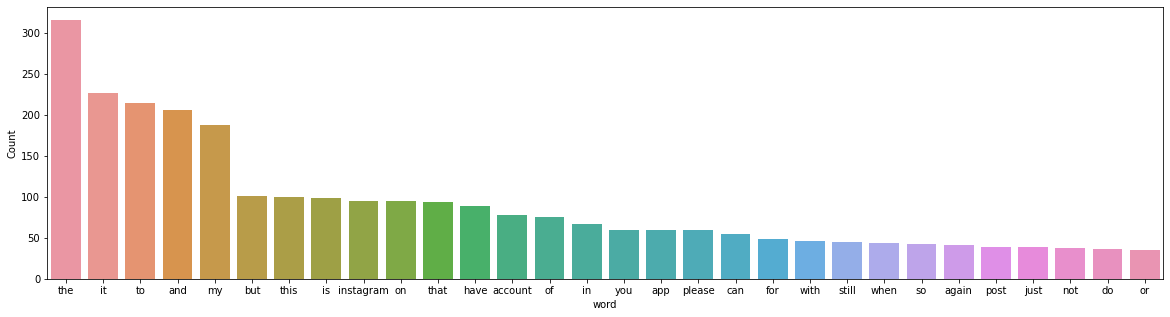

In [57]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score2))

In [58]:
# Clean text
review_ph_ready_score2 = process_words(review_words_ph_score2)  # processed Text Data! - move to each section


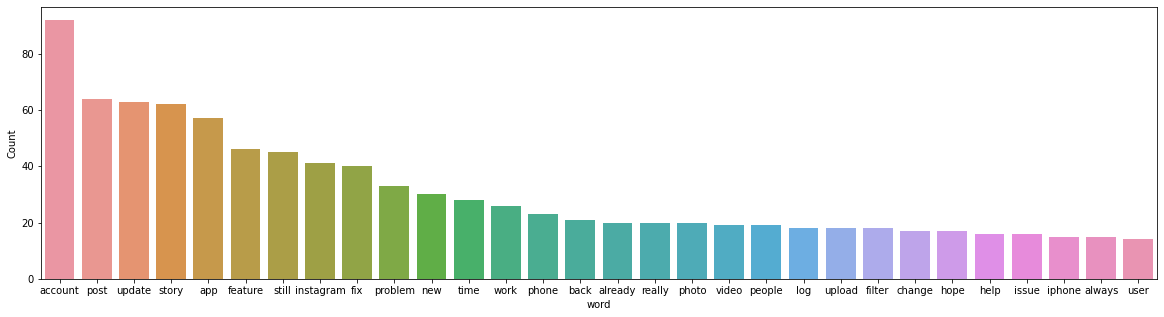

In [59]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score2))


In [60]:
# Create Dictionary
id2word_ph_score2 = corpora.Dictionary(review_ph_ready_score2)

2021-10-16 02:00:04,678 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:00:04,688 [INFO] gensim.corpora.dictionary - built Dictionary(697 unique tokens: ['account', 'bug', 'certain', 'change', 'content']...) from 100 documents (total 2603 corpus positions)
2021-10-16 02:00:04,689 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(697 unique tokens: ['account', 'bug', 'certain', 'change', 'content']...) from 100 documents (total 2603 corpus positions)", 'datetime': '2021-10-16T02:00:04.689932', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [61]:
# Create Corpus: Term Document Frequency
corpus_ph_score2 = [id2word_ph_score2.doc2bow(text) for text in review_ph_ready_score2]

In [62]:
# Training LDA model
model_list_ph_score2, coherence_values_ph_score2 = compute_coherence_values(dictionary=id2word_ph_score2, corpus=corpus_ph_score2, 
                                                              texts=review_ph_ready_score2, limit=30, start=2, step=5)


2021-10-16 02:00:04,730 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:00:04,732 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:00:04,734 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:00:04,735 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 100 documents, updating model once every 100 documents, evaluating perplexity every 100 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:00:05,494 [INFO] gensim.models.ldamodel - -7.121 per-word bound, 139.2 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:05,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #100/100
2021-10-16 02:00:06,001 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"post" + 0.015*"app" + 0.015*"instagram" + 0.014*"photo" + 0.014*"story" + 0.011*"still" + 0.010*"

2021-10-16 02:00:11,005 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"post" + 0.017*"photo" + 0.014*"app" + 0.014*"instagram" + 0.012*"back" + 0.010*"feature" + 0.008*"story" + 0.008*"issue" + 0.008*"work" + 0.007*"happen"
2021-10-16 02:00:11,008 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"account" + 0.026*"update" + 0.024*"story" + 0.020*"post" + 0.019*"app" + 0.017*"still" + 0.016*"feature" + 0.016*"fix" + 0.014*"problem" + 0.012*"instagram"
2021-10-16 02:00:11,017 [INFO] gensim.models.ldamodel - topic diff=0.008156, rho=0.301511
2021-10-16 02:00:11,236 [INFO] gensim.models.ldamodel - -6.129 per-word bound, 70.0 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:11,239 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #100/100
2021-10-16 02:00:11,444 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"post" + 0.017*"photo" + 0.014*"app" + 0.014*"instagram" + 0.012*"back" + 0.010*"feature" + 0.008*

2021-10-16 02:00:15,450 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"post" + 0.017*"photo" + 0.015*"app" + 0.013*"instagram" + 0.012*"back" + 0.009*"feature" + 0.008*"issue" + 0.008*"work" + 0.007*"happen" + 0.007*"story"
2021-10-16 02:00:15,453 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"account" + 0.026*"update" + 0.024*"story" + 0.020*"post" + 0.019*"app" + 0.017*"still" + 0.017*"feature" + 0.016*"fix" + 0.014*"problem" + 0.012*"new"
2021-10-16 02:00:15,460 [INFO] gensim.models.ldamodel - topic diff=0.003144, rho=0.218218
2021-10-16 02:00:15,666 [INFO] gensim.models.ldamodel - -6.126 per-word bound, 69.9 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:15,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #100/100
2021-10-16 02:00:15,823 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"post" + 0.017*"photo" + 0.015*"app" + 0.013*"instagram" + 0.012*"back" + 0.009*"feature" + 0.008*"issue

2021-10-16 02:00:20,177 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"account" + 0.026*"update" + 0.024*"story" + 0.020*"post" + 0.019*"app" + 0.017*"still" + 0.017*"feature" + 0.016*"fix" + 0.014*"problem" + 0.013*"new"
2021-10-16 02:00:20,178 [INFO] gensim.models.ldamodel - topic diff=0.002532, rho=0.179605
2021-10-16 02:00:20,410 [INFO] gensim.models.ldamodel - -6.123 per-word bound, 69.7 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:20,411 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #100/100
2021-10-16 02:00:20,559 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.020*"post" + 0.016*"photo" + 0.015*"app" + 0.013*"instagram" + 0.012*"back" + 0.008*"feature" + 0.008*"work" + 0.008*"issue" + 0.008*"view" + 0.007*"happen"
2021-10-16 02:00:20,563 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"account" + 0.026*"update" + 0.024*"story" + 0.019*"post" + 0.019*"app" + 0.017*"still" + 0.017*"feature"

2021-10-16 02:00:24,797 [INFO] gensim.models.ldamodel - topic diff=0.001185, rho=0.156174
2021-10-16 02:00:25,009 [INFO] gensim.models.ldamodel - -6.123 per-word bound, 69.7 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:25,015 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #100/100
2021-10-16 02:00:25,195 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.021*"post" + 0.016*"photo" + 0.016*"app" + 0.013*"instagram" + 0.012*"back" + 0.008*"work" + 0.008*"feature" + 0.008*"issue" + 0.008*"view" + 0.007*"happen"
2021-10-16 02:00:25,198 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"account" + 0.026*"update" + 0.024*"story" + 0.019*"post" + 0.018*"app" + 0.017*"still" + 0.017*"feature" + 0.016*"fix" + 0.015*"problem" + 0.013*"new"
2021-10-16 02:00:25,200 [INFO] gensim.models.ldamodel - topic diff=0.001162, rho=0.154303
2021-10-16 02:00:25,442 [INFO] gensim.models.ldamodel - -6.123 per-word bound, 69.7 perplexity 

2021-10-16 02:00:29,106 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=697, num_topics=2, decay=0.5, chunksize=1000) in 24.37s', 'datetime': '2021-10-16T02:00:29.106178', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:00:29,110 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:00:34,883 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:00:34,922 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 100 virtual documents
2021-10-16 02:00:35,313 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:00:35,314 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
20

2021-10-16 02:00:37,804 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.017*"app" + 0.016*"people" + 0.015*"story" + 0.014*"update" + 0.014*"instagram" + 0.014*"view" + 0.014*"delete" + 0.013*"still" + 0.013*"follow" + 0.013*"love"
2021-10-16 02:00:37,805 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"update" + 0.027*"app" + 0.020*"story" + 0.018*"problem" + 0.017*"effect" + 0.017*"post" + 0.017*"account" + 0.017*"poll" + 0.014*"device" + 0.014*"phone"
2021-10-16 02:00:37,807 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"account" + 0.043*"feature" + 0.030*"still" + 0.024*"fix" + 0.019*"story" + 0.016*"app" + 0.015*"problem" + 0.014*"new" + 0.013*"instagram" + 0.012*"back"
2021-10-16 02:00:37,807 [INFO] gensim.models.ldamodel - topic diff=0.085084, rho=0.408248
2021-10-16 02:00:37,987 [INFO] gensim.models.ldamodel - -6.344 per-word bound, 81.2 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:37,990 [INFO] gensim.mo

2021-10-16 02:00:39,451 [INFO] gensim.models.ldamodel - topic diff=0.015678, rho=0.301511
2021-10-16 02:00:39,553 [INFO] gensim.models.ldamodel - -6.329 per-word bound, 80.4 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:39,557 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #100/100
2021-10-16 02:00:39,769 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.017*"app" + 0.016*"people" + 0.014*"story" + 0.014*"update" + 0.014*"instagram" + 0.014*"view" + 0.014*"delete" + 0.014*"follow" + 0.014*"love" + 0.014*"still"
2021-10-16 02:00:39,776 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"account" + 0.037*"post" + 0.024*"quality" + 0.023*"photo" + 0.023*"video" + 0.019*"fix" + 0.018*"really" + 0.018*"instagram" + 0.018*"tag" + 0.014*"first"
2021-10-16 02:00:39,781 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.045*"account" + 0.044*"feature" + 0.031*"still" + 0.024*"fix" + 0.020*"story" + 0.017*"problem" + 0.01

2021-10-16 02:00:41,444 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.046*"account" + 0.044*"feature" + 0.031*"still" + 0.024*"fix" + 0.020*"story" + 0.018*"problem" + 0.016*"app" + 0.016*"new" + 0.014*"instagram" + 0.014*"update"
2021-10-16 02:00:41,447 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"update" + 0.031*"post" + 0.019*"account" + 0.017*"issue" + 0.015*"filter" + 0.015*"day" + 0.014*"still" + 0.013*"instagram" + 0.013*"happen" + 0.011*"help"
2021-10-16 02:00:41,449 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"story" + 0.033*"account" + 0.028*"post" + 0.025*"app" + 0.023*"update" + 0.012*"instagram" + 0.012*"already" + 0.011*"fix" + 0.011*"problem" + 0.010*"new"
2021-10-16 02:00:41,452 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"account" + 0.037*"post" + 0.024*"quality" + 0.023*"photo" + 0.023*"video" + 0.019*"fix" + 0.018*"really" + 0.018*"instagram" + 0.018*"tag" + 0.014*"password"
2021-10-16 02:00:41,454 [INFO] gensim.models.ldamod

2021-10-16 02:00:43,188 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.029*"app" + 0.023*"effect" + 0.020*"story" + 0.018*"problem" + 0.017*"post" + 0.017*"poll" + 0.017*"account" + 0.016*"device" + 0.014*"phone"
2021-10-16 02:00:43,189 [INFO] gensim.models.ldamodel - topic diff=0.001785, rho=0.213201
2021-10-16 02:00:43,333 [INFO] gensim.models.ldamodel - -6.325 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:43,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #100/100
2021-10-16 02:00:43,467 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.017*"app" + 0.017*"people" + 0.014*"story" + 0.014*"update" + 0.014*"delete" + 0.014*"view" + 0.014*"love" + 0.014*"follow" + 0.014*"instagram" + 0.014*"still"
2021-10-16 02:00:43,477 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.029*"app" + 0.023*"effect" + 0.020*"story" + 0.018*"problem" + 0.017*"post" + 0.017*"p

2021-10-16 02:00:45,123 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.021*"app" + 0.021*"work" + 0.021*"photo" + 0.018*"instagram" + 0.018*"save" + 0.014*"crash" + 0.014*"post" + 0.013*"story" + 0.013*"time" + 0.011*"video"
2021-10-16 02:00:45,134 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.029*"app" + 0.023*"effect" + 0.020*"story" + 0.018*"problem" + 0.017*"poll" + 0.017*"post" + 0.017*"account" + 0.016*"device" + 0.014*"phone"
2021-10-16 02:00:45,143 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"update" + 0.031*"post" + 0.019*"account" + 0.017*"issue" + 0.015*"day" + 0.015*"filter" + 0.014*"still" + 0.013*"happen" + 0.013*"instagram" + 0.011*"help"
2021-10-16 02:00:45,151 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"account" + 0.044*"feature" + 0.031*"still" + 0.024*"fix" + 0.020*"story" + 0.018*"problem" + 0.016*"app" + 0.016*"new" + 0.014*"update" + 0.014*"instagram"
2021-10-16 02:00:45,168 [INFO] gensim.models.ldamodel - topic

2021-10-16 02:00:46,875 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"story" + 0.032*"account" + 0.028*"post" + 0.025*"app" + 0.023*"update" + 0.012*"instagram" + 0.012*"already" + 0.011*"fix" + 0.011*"problem" + 0.010*"phone"
2021-10-16 02:00:46,883 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"update" + 0.029*"app" + 0.023*"effect" + 0.020*"story" + 0.018*"problem" + 0.017*"poll" + 0.017*"post" + 0.017*"account" + 0.016*"device" + 0.014*"phone"
2021-10-16 02:00:46,884 [INFO] gensim.models.ldamodel - topic diff=0.000502, rho=0.174078
2021-10-16 02:00:47,062 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:47,064 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #100/100
2021-10-16 02:00:47,194 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"story" + 0.032*"account" + 0.028*"post" + 0.025*"app" + 0.023*"update" + 0.012*"instagram" + 0.0

2021-10-16 02:00:48,723 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:48,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #100/100
2021-10-16 02:00:48,812 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.021*"work" + 0.021*"app" + 0.021*"photo" + 0.018*"instagram" + 0.018*"save" + 0.014*"crash" + 0.014*"post" + 0.013*"story" + 0.013*"time" + 0.011*"video"
2021-10-16 02:00:48,816 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"account" + 0.037*"post" + 0.024*"quality" + 0.023*"video" + 0.023*"photo" + 0.019*"fix" + 0.018*"really" + 0.018*"instagram" + 0.018*"tag" + 0.014*"password"
2021-10-16 02:00:48,822 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"account" + 0.044*"feature" + 0.031*"still" + 0.024*"fix" + 0.020*"story" + 0.018*"problem" + 0.017*"new" + 0.016*"app" + 0.014*"update" + 0.014*"instagram"
2021-10-16 02:00:48,829 [INFO] gen

2021-10-16 02:00:50,300 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"update" + 0.031*"post" + 0.019*"account" + 0.017*"issue" + 0.015*"day" + 0.015*"filter" + 0.014*"still" + 0.013*"happen" + 0.013*"instagram" + 0.011*"help"
2021-10-16 02:00:50,301 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"update" + 0.029*"app" + 0.023*"effect" + 0.020*"story" + 0.018*"problem" + 0.017*"poll" + 0.017*"post" + 0.017*"account" + 0.016*"device" + 0.014*"phone"
2021-10-16 02:00:50,302 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.021*"work" + 0.021*"app" + 0.021*"photo" + 0.018*"instagram" + 0.018*"save" + 0.014*"crash" + 0.014*"post" + 0.013*"story" + 0.013*"time" + 0.011*"video"
2021-10-16 02:00:50,303 [INFO] gensim.models.ldamodel - topic diff=0.000142, rho=0.150756
2021-10-16 02:00:50,437 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:50,439 [INFO] gensim.models

2021-10-16 02:00:51,563 [INFO] gensim.models.ldamodel - topic diff=0.000077, rho=0.142857
2021-10-16 02:00:51,704 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:00:51,715 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #100/100
2021-10-16 02:00:51,822 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"account" + 0.037*"post" + 0.024*"quality" + 0.024*"video" + 0.023*"photo" + 0.019*"fix" + 0.018*"really" + 0.018*"instagram" + 0.018*"tag" + 0.014*"password"
2021-10-16 02:00:51,823 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.040*"update" + 0.031*"post" + 0.019*"account" + 0.017*"issue" + 0.015*"day" + 0.015*"filter" + 0.014*"still" + 0.013*"happen" + 0.013*"instagram" + 0.011*"help"
2021-10-16 02:00:51,825 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.017*"app" + 0.017*"people" + 0.014*"story" + 0.014*"update" + 0.014*"upload" + 0.014*"delete" + 0.

2021-10-16 02:01:02,793 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.021*"issue" + 0.020*"back" + 0.015*"post" + 0.015*"happen" + 0.014*"update" + 0.014*"keep" + 0.014*"give" + 0.014*"skyline" + 0.014*"ashby"
2021-10-16 02:01:02,795 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.059*"update" + 0.051*"filter" + 0.027*"app" + 0.024*"account" + 0.024*"poll" + 0.021*"story" + 0.020*"problem" + 0.020*"hope" + 0.015*"show" + 0.015*"effect"
2021-10-16 02:01:02,796 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.030*"still" + 0.020*"work" + 0.018*"crash" + 0.017*"post" + 0.016*"time" + 0.016*"already" + 0.015*"ipad" + 0.015*"version" + 0.015*"instagram" + 0.013*"log"
2021-10-16 02:01:02,797 [INFO] gensim.models.ldamodel - topic diff=0.221916, rho=0.500000
2021-10-16 02:01:03,002 [INFO] gensim.models.ldamodel - -6.551 per-word bound, 93.8 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:03,010 [INFO] gensim.models.ld

2021-10-16 02:01:04,454 [INFO] gensim.models.ldamodel - topic diff=0.046623, rho=0.333333
2021-10-16 02:01:04,591 [INFO] gensim.models.ldamodel - -6.469 per-word bound, 88.6 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:04,594 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #100/100
2021-10-16 02:01:04,697 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"upload" + 0.031*"story" + 0.031*"photo" + 0.027*"log" + 0.018*"really" + 0.018*"feature" + 0.014*"view" + 0.014*"back" + 0.014*"app" + 0.014*"password"
2021-10-16 02:01:04,702 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.060*"update" + 0.052*"filter" + 0.028*"app" + 0.024*"poll" + 0.021*"hope" + 0.020*"account" + 0.020*"problem" + 0.018*"slider" + 0.017*"story" + 0.014*"show"
2021-10-16 02:01:04,704 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.037*"update" + 0.032*"work" + 0.028*"post" + 0.020*"account" + 0.017*"message" + 0.016*"instagram" + 0.016*

2021-10-16 02:01:06,420 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"upload" + 0.031*"story" + 0.031*"photo" + 0.027*"log" + 0.018*"really" + 0.018*"feature" + 0.014*"view" + 0.014*"back" + 0.014*"app" + 0.014*"password"
2021-10-16 02:01:06,422 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.041*"post" + 0.041*"video" + 0.031*"quality" + 0.030*"fix" + 0.028*"story" + 0.026*"account" + 0.025*"instagram" + 0.019*"change" + 0.019*"really" + 0.019*"password"
2021-10-16 02:01:06,423 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.064*"account" + 0.045*"feature" + 0.030*"new" + 0.029*"fix" + 0.029*"still" + 0.028*"update" + 0.026*"story" + 0.020*"instagram" + 0.020*"problem" + 0.015*"version"
2021-10-16 02:01:06,425 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.027*"still" + 0.022*"app" + 0.017*"update" + 0.017*"already" + 0.017*"well" + 0.017*"check" + 0.016*"work" + 0.016*"delete" + 0.015*"instagram" + 0.011*"story"
2021-10-16 02:01:06,426 [INFO] gensim.models.ld

2021-10-16 02:01:08,194 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.031*"feature" + 0.022*"upload" + 0.018*"story" + 0.016*"pic" + 0.016*"inconsistent" + 0.016*"instastory" + 0.016*"medium" + 0.016*"messenger" + 0.016*"buggy" + 0.016*"really"
2021-10-16 02:01:08,198 [INFO] gensim.models.ldamodel - topic diff=0.003585, rho=0.223607
2021-10-16 02:01:08,363 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:08,365 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #100/100
2021-10-16 02:01:08,474 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.027*"still" + 0.022*"app" + 0.017*"update" + 0.017*"already" + 0.017*"well" + 0.017*"check" + 0.016*"work" + 0.016*"delete" + 0.015*"instagram" + 0.011*"story"
2021-10-16 02:01:08,479 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.043*"account" + 0.043*"post" + 0.016*"update" + 0.016*"feed" + 0.016*"suggest" + 0.015*

2021-10-16 02:01:09,820 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #100/100
2021-10-16 02:01:09,862 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"upload" + 0.031*"story" + 0.031*"photo" + 0.027*"log" + 0.018*"really" + 0.018*"feature" + 0.014*"view" + 0.014*"back" + 0.014*"app" + 0.014*"password"
2021-10-16 02:01:09,864 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.065*"account" + 0.045*"feature" + 0.030*"new" + 0.030*"still" + 0.029*"fix" + 0.028*"update" + 0.027*"story" + 0.022*"problem" + 0.020*"instagram" + 0.015*"version"
2021-10-16 02:01:09,865 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.029*"app" + 0.021*"photo" + 0.019*"post" + 0.018*"video" + 0.017*"instagram" + 0.017*"save" + 0.016*"story" + 0.013*"like" + 0.013*"help" + 0.013*"user"
2021-10-16 02:01:09,867 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.021*"issue" + 0.021*"back" + 0.014*"happen" + 0.014*"post" + 0.014*"keep" + 0.014*"update" + 0.014*"give" + 0.

2021-10-16 02:01:11,464 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.021*"issue" + 0.021*"back" + 0.014*"happen" + 0.014*"post" + 0.014*"keep" + 0.014*"update" + 0.014*"give" + 0.014*"install" + 0.014*"filter"
2021-10-16 02:01:11,465 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.031*"feature" + 0.021*"upload" + 0.018*"story" + 0.016*"pic" + 0.016*"instastory" + 0.016*"inconsistent" + 0.016*"medium" + 0.016*"messenger" + 0.016*"buggy" + 0.016*"really"
2021-10-16 02:01:11,469 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.065*"account" + 0.044*"feature" + 0.030*"new" + 0.030*"still" + 0.029*"fix" + 0.028*"update" + 0.027*"story" + 0.022*"problem" + 0.020*"instagram" + 0.015*"version"
2021-10-16 02:01:11,472 [INFO] gensim.models.ldamodel - topic diff=0.001183, rho=0.179605
2021-10-16 02:01:11,639 [INFO] gensim.models.ldamodel - -6.453 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:11,641

2021-10-16 02:01:13,138 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.065*"account" + 0.044*"feature" + 0.030*"new" + 0.030*"still" + 0.029*"fix" + 0.028*"update" + 0.027*"story" + 0.022*"problem" + 0.019*"instagram" + 0.015*"version"
2021-10-16 02:01:13,141 [INFO] gensim.models.ldamodel - topic diff=0.000775, rho=0.166667
2021-10-16 02:01:13,311 [INFO] gensim.models.ldamodel - -6.452 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:13,312 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #100/100
2021-10-16 02:01:13,362 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"upload" + 0.031*"story" + 0.031*"photo" + 0.027*"log" + 0.018*"really" + 0.018*"feature" + 0.014*"view" + 0.014*"back" + 0.014*"app" + 0.014*"password"
2021-10-16 02:01:13,363 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.044*"account" + 0.043*"post" + 0.016*"feed" + 0.016*"suggest" + 0.015*"update" + 0.015*"instagram" 

2021-10-16 02:01:14,707 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #100/100
2021-10-16 02:01:14,808 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.021*"issue" + 0.021*"back" + 0.014*"happen" + 0.014*"keep" + 0.014*"give" + 0.014*"install" + 0.014*"post" + 0.014*"filter" + 0.014*"update"
2021-10-16 02:01:14,811 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.059*"update" + 0.051*"filter" + 0.028*"app" + 0.024*"poll" + 0.021*"hope" + 0.020*"account" + 0.019*"problem" + 0.019*"slider" + 0.016*"story" + 0.014*"show"
2021-10-16 02:01:14,816 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.042*"video" + 0.041*"post" + 0.032*"fix" + 0.031*"quality" + 0.028*"story" + 0.026*"account" + 0.025*"instagram" + 0.019*"change" + 0.019*"really" + 0.019*"password"
2021-10-16 02:01:14,818 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.065*"account" + 0.044*"feature" + 0.030*"new" + 0.030*"still" + 0.029*"fix" + 0.028*"update" + 0.027*"story" + 0.023*"pro

2021-10-16 02:01:16,352 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.029*"app" + 0.021*"photo" + 0.019*"post" + 0.018*"video" + 0.017*"instagram" + 0.017*"save" + 0.016*"story" + 0.013*"user" + 0.013*"like" + 0.013*"fun"
2021-10-16 02:01:16,355 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.039*"account" + 0.029*"app" + 0.028*"story" + 0.026*"post" + 0.018*"update" + 0.017*"people" + 0.016*"time" + 0.015*"feature" + 0.013*"problem" + 0.012*"fix"
2021-10-16 02:01:16,357 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.021*"back" + 0.021*"issue" + 0.014*"happen" + 0.014*"keep" + 0.014*"give" + 0.014*"install" + 0.014*"post" + 0.014*"anymore" + 0.014*"filter"
2021-10-16 02:01:16,361 [INFO] gensim.models.ldamodel - topic diff=0.000354, rho=0.145865
2021-10-16 02:01:16,475 [INFO] gensim.models.ldamodel - -6.452 per-word bound, 87.5 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:16,476 [INFO] gensim.models.ldamode

2021-10-16 02:01:25,574 [INFO] gensim.models.ldamodel - -14.212 per-word bound, 18972.6 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:25,577 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #100/100
2021-10-16 02:01:25,951 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"feature" + 0.039*"account" + 0.032*"still" + 0.023*"story" + 0.021*"problem" + 0.020*"fix" + 0.017*"update" + 0.015*"app" + 0.015*"version" + 0.013*"report"
2021-10-16 02:01:25,955 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"account" + 0.041*"post" + 0.020*"suggest" + 0.020*"feed" + 0.017*"notification" + 0.017*"tag" + 0.016*"first" + 0.015*"still" + 0.014*"wait" + 0.013*"medium"
2021-10-16 02:01:25,957 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.066*"account" + 0.033*"update" + 0.029*"log" + 0.027*"story" + 0.023*"new" + 0.020*"feature" + 0.017*"problem" + 0.016*"app" + 0.014*"hack" + 0.014*"password"
2021-10-16 02:01:25,960 

2021-10-16 02:01:27,698 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.076*"account" + 0.036*"update" + 0.032*"log" + 0.027*"story" + 0.027*"new" + 0.023*"feature" + 0.018*"problem" + 0.014*"app" + 0.014*"hack" + 0.014*"password"
2021-10-16 02:01:27,699 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.031*"issue" + 0.026*"post" + 0.021*"message" + 0.016*"instagram" + 0.016*"account" + 0.016*"update" + 0.016*"support" + 0.016*"help" + 0.011*"work" + 0.011*"read"
2021-10-16 02:01:27,701 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.053*"post" + 0.048*"account" + 0.028*"suggest" + 0.024*"feed" + 0.020*"notification" + 0.020*"first" + 0.016*"tag" + 0.016*"later" + 0.013*"day" + 0.013*"setting"
2021-10-16 02:01:27,704 [INFO] gensim.models.ldamodel - topic diff=0.083777, rho=0.377964
2021-10-16 02:01:27,865 [INFO] gensim.models.ldamodel - -6.566 per-word bound, 94.8 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:27,871 [INFO] g

2021-10-16 02:01:29,163 [INFO] gensim.models.ldamodel - topic diff=0.015989, rho=0.288675
2021-10-16 02:01:29,306 [INFO] gensim.models.ldamodel - -6.553 per-word bound, 93.9 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:29,308 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #100/100
2021-10-16 02:01:29,450 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.041*"account" + 0.039*"story" + 0.036*"app" + 0.031*"update" + 0.021*"post" + 0.019*"new" + 0.019*"work" + 0.015*"filter" + 0.015*"effect" + 0.015*"problem"
2021-10-16 02:01:29,454 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.036*"update" + 0.032*"really" + 0.028*"account" + 0.025*"fix" + 0.021*"post" + 0.021*"instagram" + 0.021*"story" + 0.018*"change" + 0.018*"upload" + 0.014*"app"
2021-10-16 02:01:29,459 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.050*"feature" + 0.038*"account" + 0.036*"still" + 0.024*"story" + 0.024*"problem" + 0.021*"fix" + 0.018

2021-10-16 02:01:30,874 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"filter" + 0.030*"update" + 0.023*"instagram" + 0.023*"phone" + 0.023*"new" + 0.023*"show" + 0.015*"messenger" + 0.015*"love" + 0.015*"medium" + 0.015*"feature"
2021-10-16 02:01:30,882 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.031*"issue" + 0.026*"post" + 0.021*"message" + 0.016*"instagram" + 0.016*"account" + 0.016*"update" + 0.016*"support" + 0.016*"help" + 0.011*"work" + 0.011*"read"
2021-10-16 02:01:30,890 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.053*"post" + 0.049*"account" + 0.028*"suggest" + 0.024*"feed" + 0.020*"notification" + 0.020*"first" + 0.016*"tag" + 0.016*"later" + 0.013*"setting" + 0.013*"day"
2021-10-16 02:01:30,893 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.024*"app" + 0.024*"update" + 0.024*"ashby" + 0.024*"ginza" + 0.024*"skyline" + 0.024*"happen" + 0.024*"filter" + 0.012*"uninstall" + 0.012*"reinstall" + 0.012*"time"
2021-10-16 02:01:30,897 [INFO] gensim.m

2021-10-16 02:01:32,376 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.031*"already" + 0.027*"still" + 0.027*"photo" + 0.027*"music" + 0.024*"update" + 0.023*"story" + 0.018*"feature" + 0.018*"instagram" + 0.018*"new" + 0.014*"bring"
2021-10-16 02:01:32,389 [INFO] gensim.models.ldamodel - topic diff=0.001381, rho=0.208514
2021-10-16 02:01:32,559 [INFO] gensim.models.ldamodel - -6.549 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:32,560 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #100/100
2021-10-16 02:01:32,605 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.023*"app" + 0.023*"instagram" + 0.023*"view" + 0.018*"post" + 0.018*"crash" + 0.018*"story" + 0.014*"video" + 0.014*"reason" + 0.014*"photo" + 0.014*"open"
2021-10-16 02:01:32,607 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.057*"post" + 0.034*"feature" + 0.027*"superzoom" + 0.020*"really" + 0.020*"wish" + 0.020*"still" + 0.

2021-10-16 02:01:34,112 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.023*"app" + 0.023*"instagram" + 0.023*"view" + 0.018*"post" + 0.018*"crash" + 0.018*"story" + 0.014*"video" + 0.014*"reason" + 0.014*"photo" + 0.014*"open"
2021-10-16 02:01:34,120 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.053*"story" + 0.043*"view" + 0.032*"back" + 0.022*"way" + 0.022*"appear" + 0.022*"fun" + 0.011*"love" + 0.011*"look" + 0.011*"really" + 0.011*"internet"
2021-10-16 02:01:34,125 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"filter" + 0.030*"update" + 0.023*"instagram" + 0.023*"phone" + 0.023*"new" + 0.023*"show" + 0.015*"messenger" + 0.015*"love" + 0.015*"medium" + 0.015*"feature"
2021-10-16 02:01:34,129 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.050*"app" + 0.032*"account" + 0.026*"update" + 0.023*"time" + 0.018*"quality" + 0.017*"fix" + 0.015*"post" + 0.014*"save" + 0.014*"photo" + 0.014*"poll"
2021-10-16 02:01:34,133 [INFO] gensim.models.ldamodel - topic #13 (

2021-10-16 02:01:35,871 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.031*"already" + 0.027*"still" + 0.027*"music" + 0.027*"photo" + 0.024*"update" + 0.023*"story" + 0.018*"feature" + 0.018*"instagram" + 0.018*"new" + 0.014*"bring"
2021-10-16 02:01:35,873 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.053*"story" + 0.043*"view" + 0.032*"back" + 0.022*"appear" + 0.022*"way" + 0.022*"fun" + 0.011*"love" + 0.011*"look" + 0.011*"really" + 0.011*"reaction"
2021-10-16 02:01:35,874 [INFO] gensim.models.ldamodel - topic diff=0.000360, rho=0.171499
2021-10-16 02:01:36,155 [INFO] gensim.models.ldamodel - -6.548 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:36,160 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #100/100
2021-10-16 02:01:36,298 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.023*"app" + 0.023*"instagram" + 0.023*"view" + 0.018*"post" + 0.018*"crash" + 0.018*"story" + 0.014*"vid

2021-10-16 02:01:37,723 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #100/100
2021-10-16 02:01:37,835 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.025*"account" + 0.025*"find" + 0.025*"show" + 0.017*"log" + 0.017*"time" + 0.017*"instagram" + 0.017*"app" + 0.017*"open" + 0.017*"hide" + 0.017*"like"
2021-10-16 02:01:37,837 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.077*"account" + 0.036*"update" + 0.032*"log" + 0.027*"story" + 0.027*"new" + 0.023*"feature" + 0.018*"problem" + 0.014*"app" + 0.014*"time" + 0.014*"password"
2021-10-16 02:01:37,844 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.041*"account" + 0.039*"story" + 0.036*"app" + 0.031*"update" + 0.021*"post" + 0.019*"new" + 0.019*"work" + 0.015*"filter" + 0.015*"problem" + 0.015*"effect"
2021-10-16 02:01:37,847 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"filter" + 0.030*"update" + 0.023*"instagram" + 0.023*"phone" + 0.023*"new" + 0.023*"show" + 0.015*"feature" + 0.015*"love" + 0

2021-10-16 02:01:39,444 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.031*"already" + 0.027*"still" + 0.027*"music" + 0.027*"photo" + 0.024*"update" + 0.023*"story" + 0.018*"feature" + 0.018*"instagram" + 0.018*"new" + 0.014*"bring"
2021-10-16 02:01:39,448 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.062*"video" + 0.050*"post" + 0.038*"quality" + 0.038*"account" + 0.025*"immediately" + 0.025*"reason" + 0.025*"fix" + 0.025*"sound" + 0.025*"change" + 0.013*"story"
2021-10-16 02:01:39,450 [INFO] gensim.models.ldamodel - topic diff=0.000108, rho=0.149071
2021-10-16 02:01:39,639 [INFO] gensim.models.ldamodel - -6.548 per-word bound, 93.5 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:39,646 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #100/100
2021-10-16 02:01:39,712 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.025*"account" + 0.025*"find" + 0.025*"show" + 0.017*"log" + 0.017*"time" + 0.017*"instagram" 

2021-10-16 02:01:40,998 [INFO] gensim.models.ldamodel - -6.547 per-word bound, 93.5 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:41,000 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #100/100
2021-10-16 02:01:41,177 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.057*"post" + 0.034*"feature" + 0.027*"superzoom" + 0.021*"really" + 0.021*"wish" + 0.021*"still" + 0.021*"story" + 0.020*"like" + 0.014*"eat" + 0.014*"people"
2021-10-16 02:01:41,179 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.050*"feature" + 0.037*"account" + 0.036*"still" + 0.025*"problem" + 0.024*"story" + 0.021*"fix" + 0.018*"update" + 0.016*"app" + 0.016*"report" + 0.013*"version"
2021-10-16 02:01:41,181 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.036*"update" + 0.032*"really" + 0.028*"account" + 0.025*"fix" + 0.021*"post" + 0.021*"instagram" + 0.021*"story" + 0.018*"change" + 0.018*"upload" + 0.014*"app"
2021-10-16 02:01:41,182 [INF

2021-10-16 02:01:51,463 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.076*"account" + 0.067*"post" + 0.037*"suggest" + 0.033*"follow" + 0.031*"day" + 0.025*"put" + 0.017*"people" + 0.013*"show" + 0.013*"user" + 0.013*"discover"
2021-10-16 02:01:51,465 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.036*"update" + 0.033*"post" + 0.029*"work" + 0.026*"account" + 0.021*"instagram" + 0.018*"issue" + 0.017*"still" + 0.017*"fix" + 0.017*"story" + 0.014*"message"
2021-10-16 02:01:51,467 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.050*"feature" + 0.041*"follow" + 0.033*"app" + 0.025*"focus" + 0.017*"story" + 0.017*"look" + 0.017*"size" + 0.017*"photo" + 0.017*"delete" + 0.017*"vid"
2021-10-16 02:01:51,468 [INFO] gensim.models.ldamodel - topic diff=0.138661, rho=0.447214
2021-10-16 02:01:51,625 [INFO] gensim.models.ldamodel - -6.632 per-word bound, 99.2 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:51,629 [INFO] gensim.model

2021-10-16 02:01:52,872 [INFO] gensim.models.ldamodel - topic diff=0.029973, rho=0.316228
2021-10-16 02:01:53,065 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:53,068 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #100/100
2021-10-16 02:01:53,179 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.084*"post" + 0.031*"like" + 0.023*"really" + 0.023*"suddenly" + 0.023*"feature" + 0.023*"wish" + 0.023*"delete" + 0.022*"day" + 0.016*"instagram" + 0.016*"people"
2021-10-16 02:01:53,182 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.037*"account" + 0.031*"instagram" + 0.025*"work" + 0.025*"setting" + 0.025*"notification" + 0.019*"still" + 0.019*"app" + 0.019*"end" + 0.013*"time" + 0.013*"already"
2021-10-16 02:01:53,184 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.037*"account" + 0.028*"story" + 0.028*"feature" + 0.027*"time" + 0.018*"still" + 0.018*"pic

2021-10-16 02:01:54,570 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.055*"app" + 0.019*"work" + 0.019*"connection" + 0.019*"new" + 0.019*"wonder" + 0.019*"update" + 0.019*"stable" + 0.019*"show" + 0.019*"long" + 0.019*"watch"
2021-10-16 02:01:54,575 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.038*"photo" + 0.027*"upload" + 0.025*"post" + 0.022*"app" + 0.016*"save" + 0.016*"help" + 0.016*"quality" + 0.016*"never" + 0.016*"story" + 0.016*"hope"
2021-10-16 02:01:54,579 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.056*"account" + 0.042*"change" + 0.036*"really" + 0.036*"instagram" + 0.036*"fix" + 0.030*"password" + 0.024*"post" + 0.024*"log" + 0.021*"update" + 0.019*"story"
2021-10-16 02:01:54,583 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.084*"post" + 0.031*"like" + 0.023*"really" + 0.023*"feature" + 0.023*"wish" + 0.023*"suddenly" + 0.023*"delete" + 0.023*"day" + 0.016*"instagram" + 0.016*"people"
2021-10-16 02:01:54,588 [INFO] gensim.models.ldamodel - t

2021-10-16 02:01:55,937 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.038*"photo" + 0.027*"upload" + 0.024*"post" + 0.022*"app" + 0.016*"save" + 0.016*"help" + 0.016*"quality" + 0.016*"never" + 0.016*"story" + 0.016*"hope"
2021-10-16 02:01:55,940 [INFO] gensim.models.ldamodel - topic diff=0.001605, rho=0.218218
2021-10-16 02:01:56,078 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:56,081 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #100/100
2021-10-16 02:01:56,198 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.034*"instagram" + 0.030*"fix" + 0.030*"account" + 0.022*"post" + 0.019*"problem" + 0.015*"update" + 0.015*"feature" + 0.015*"page" + 0.015*"new" + 0.014*"story"
2021-10-16 02:01:56,202 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.050*"feature" + 0.041*"follow" + 0.033*"app" + 0.025*"focus" + 0.017*"vid" + 0.017*"still" + 0.017*"size"

2021-10-16 02:01:57,557 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.055*"app" + 0.019*"work" + 0.019*"connection" + 0.019*"new" + 0.019*"wonder" + 0.019*"update" + 0.019*"stable" + 0.019*"show" + 0.019*"long" + 0.019*"watch"
2021-10-16 02:01:57,558 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.034*"instagram" + 0.030*"fix" + 0.030*"account" + 0.022*"post" + 0.019*"problem" + 0.015*"update" + 0.015*"feature" + 0.015*"page" + 0.015*"new" + 0.014*"story"
2021-10-16 02:01:57,559 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.050*"feature" + 0.041*"follow" + 0.033*"app" + 0.025*"focus" + 0.017*"vid" + 0.017*"still" + 0.017*"size" + 0.017*"story" + 0.017*"photo" + 0.017*"look"
2021-10-16 02:01:57,561 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.065*"post" + 0.052*"tag" + 0.039*"medium" + 0.039*"first" + 0.026*"media" + 0.026*"story" + 0.013*"account" + 0.013*"hate" + 0.013*"video" + 0.013*"excruciate"
2021-10-16 02:01:57,563 [INFO] gensim.models.ldamodel - topic 

2021-10-16 02:01:58,926 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.061*"log" + 0.045*"still" + 0.042*"account" + 0.031*"time" + 0.031*"superzoom" + 0.023*"month" + 0.022*"update" + 0.022*"feature" + 0.016*"already" + 0.016*"open"
2021-10-16 02:01:58,928 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.035*"story" + 0.031*"account" + 0.031*"update" + 0.026*"app" + 0.026*"feature" + 0.021*"still" + 0.016*"show" + 0.016*"new" + 0.016*"already" + 0.016*"screen"
2021-10-16 02:01:58,932 [INFO] gensim.models.ldamodel - topic diff=0.000203, rho=0.176777
2021-10-16 02:01:59,064 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:01:59,065 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #100/100
2021-10-16 02:01:59,218 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.037*"account" + 0.031*"instagram" + 0.025*"work" + 0.025*"setting" + 0.025*"notification" + 0.019*

2021-10-16 02:02:00,464 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:00,471 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #100/100
2021-10-16 02:02:00,572 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.037*"account" + 0.028*"story" + 0.028*"feature" + 0.028*"time" + 0.018*"still" + 0.018*"pic" + 0.018*"inconsistent" + 0.018*"instastory" + 0.018*"experience" + 0.018*"people"
2021-10-16 02:02:00,577 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.026*"problem" + 0.026*"story" + 0.020*"app" + 0.020*"help" + 0.020*"video" + 0.020*"instagram" + 0.020*"back" + 0.020*"account" + 0.020*"anymore" + 0.013*"post"
2021-10-16 02:02:00,579 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.053*"account" + 0.040*"hack" + 0.027*"still" + 0.027*"much" + 0.027*"really" + 0.027*"dumb" + 0.014*"type" + 0.014*"never" + 0.014*"different" + 0.014*"password"
2021-10-16 02:

2021-10-16 02:02:02,001 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.048*"update" + 0.047*"app" + 0.034*"view" + 0.027*"problem" + 0.023*"effect" + 0.023*"filter" + 0.023*"happen" + 0.021*"story" + 0.019*"back" + 0.019*"new"
2021-10-16 02:02:02,002 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.063*"update" + 0.044*"account" + 0.032*"story" + 0.032*"filter" + 0.025*"app" + 0.025*"new" + 0.019*"poll" + 0.019*"quality" + 0.019*"phone" + 0.019*"fix"
2021-10-16 02:02:02,005 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.061*"log" + 0.045*"still" + 0.043*"account" + 0.031*"time" + 0.031*"superzoom" + 0.023*"month" + 0.022*"update" + 0.022*"feature" + 0.016*"already" + 0.016*"open"
2021-10-16 02:02:02,006 [INFO] gensim.models.ldamodel - topic diff=0.000032, rho=0.152499
2021-10-16 02:02:02,201 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:02,203 [INFO] gensim.mode

2021-10-16 02:02:03,327 [INFO] gensim.models.ldamodel - topic diff=0.000015, rho=0.144338
2021-10-16 02:02:03,526 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:03,538 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #100/100
2021-10-16 02:02:03,677 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.061*"log" + 0.045*"still" + 0.043*"account" + 0.031*"time" + 0.031*"superzoom" + 0.023*"month" + 0.022*"update" + 0.022*"feature" + 0.016*"already" + 0.016*"open"
2021-10-16 02:02:03,679 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.026*"problem" + 0.026*"story" + 0.020*"app" + 0.020*"help" + 0.020*"video" + 0.020*"instagram" + 0.020*"back" + 0.020*"account" + 0.020*"anymore" + 0.013*"post"
2021-10-16 02:02:03,683 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.055*"app" + 0.019*"work" + 0.019*"connection" + 0.019*"new" + 0.019*"wonder" + 0.019*"long" + 0.0

2021-10-16 02:02:15,001 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.060*"account" + 0.041*"post" + 0.029*"suggest" + 0.028*"feed" + 0.024*"wait" + 0.024*"page" + 0.023*"update" + 0.018*"link" + 0.018*"day" + 0.018*"still"
2021-10-16 02:02:15,004 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.054*"post" + 0.034*"tag" + 0.033*"effect" + 0.026*"new" + 0.025*"medium" + 0.025*"first" + 0.023*"update" + 0.018*"late" + 0.018*"account" + 0.017*"media"
2021-10-16 02:02:15,011 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.040*"account" + 0.034*"problem" + 0.031*"fix" + 0.024*"still" + 0.020*"story" + 0.019*"time" + 0.018*"work" + 0.018*"quality" + 0.018*"gmail" + 0.018*"audio"
2021-10-16 02:02:15,013 [INFO] gensim.models.ldamodel - topic diff=0.218216, rho=0.577350
2021-10-16 02:02:15,192 [INFO] gensim.models.ldamodel - -6.875 per-word bound, 117.4 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:15,193 [INFO] gensim.models.ldam

2021-10-16 02:02:16,447 [INFO] gensim.models.ldamodel - topic diff=0.069215, rho=0.353553
2021-10-16 02:02:16,581 [INFO] gensim.models.ldamodel - -6.688 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:16,585 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #100/100
2021-10-16 02:02:16,690 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.047*"notification" + 0.047*"account" + 0.036*"end" + 0.024*"stop" + 0.024*"activity" + 0.024*"instagram" + 0.024*"block" + 0.012*"read" + 0.012*"first" + 0.012*"liking"
2021-10-16 02:02:16,692 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.002*"camera" + 0.002*"setting" + 0.002*"instagram" + 0.002*"work" + 0.002*"properly" + 0.002*"well" + 0.002*"reinstall" + 0.002*"next" + 0.002*"order" + 0.002*"automatically"
2021-10-16 02:02:16,693 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.045*"account" + 0.042*"update" + 0.032*"story" + 0.022*"still" + 0.021*"fix"

2021-10-16 02:02:18,365 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.032*"already" + 0.032*"instagram" + 0.027*"update" + 0.026*"still" + 0.026*"new" + 0.020*"ipad" + 0.020*"filter" + 0.020*"find" + 0.020*"friend" + 0.020*"app"
2021-10-16 02:02:18,369 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.059*"account" + 0.041*"post" + 0.030*"suggest" + 0.030*"feed" + 0.024*"wait" + 0.024*"page" + 0.024*"update" + 0.018*"link" + 0.018*"day" + 0.018*"still"
2021-10-16 02:02:18,372 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.029*"story" + 0.029*"appear" + 0.029*"fun" + 0.029*"love" + 0.015*"app" + 0.015*"day" + 0.015*"update" + 0.015*"way" + 0.015*"back" + 0.015*"thing"
2021-10-16 02:02:18,375 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.056*"photo" + 0.037*"quality" + 0.035*"post" + 0.029*"upload" + 0.029*"log" + 0.029*"low" + 0.025*"fix" + 0.019*"account" + 0.019*"follow" + 0.019*"never"
2021-10-16 02:02:18,377 [INFO] gensim.models.ldamodel - topic diff=0.011043, r

2021-10-16 02:02:19,969 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.038*"update" + 0.033*"app" + 0.024*"problem" + 0.024*"profile" + 0.024*"change" + 0.019*"account" + 0.019*"log" + 0.019*"issue" + 0.014*"slider" + 0.014*"device"
2021-10-16 02:02:19,971 [INFO] gensim.models.ldamodel - topic diff=0.003121, rho=0.229416
2021-10-16 02:02:20,186 [INFO] gensim.models.ldamodel - -6.677 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:20,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #100/100
2021-10-16 02:02:20,315 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.048*"notification" + 0.048*"account" + 0.036*"end" + 0.024*"stop" + 0.024*"activity" + 0.024*"instagram" + 0.024*"block" + 0.012*"read" + 0.012*"first" + 0.012*"liking"
2021-10-16 02:02:20,320 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.040*"story" + 0.040*"upload" + 0.032*"app" + 0.031*"update" + 0.024*"phone" + 0.024*"an

2021-10-16 02:02:21,931 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.072*"full" + 0.045*"screen" + 0.045*"size" + 0.035*"app" + 0.033*"update" + 0.030*"nt" + 0.030*"ad" + 0.030*"feedback" + 0.029*"already" + 0.015*"start"
2021-10-16 02:02:21,932 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.058*"account" + 0.038*"upload" + 0.037*"story" + 0.036*"time" + 0.035*"photo" + 0.029*"save" + 0.029*"app" + 0.029*"turn" + 0.028*"superzoom" + 0.023*"feature"
2021-10-16 02:02:21,935 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.045*"feature" + 0.045*"focus" + 0.030*"account" + 0.030*"deactivate" + 0.030*"name" + 0.030*"anytime" + 0.030*"let" + 0.016*"change" + 0.016*"delete" + 0.016*"problem"
2021-10-16 02:02:21,936 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.059*"post" + 0.034*"tag" + 0.034*"effect" + 0.025*"new" + 0.025*"first" + 0.025*"medium" + 0.024*"update" + 0.017*"late" + 0.017*"account" + 0.017*"media"
2021-10-16 02:02:21,938 [INFO] gensim.models.ldamodel - t

2021-10-16 02:02:23,339 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.056*"photo" + 0.037*"quality" + 0.035*"post" + 0.029*"upload" + 0.029*"log" + 0.029*"low" + 0.025*"fix" + 0.019*"account" + 0.019*"follow" + 0.019*"never"
2021-10-16 02:02:23,343 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.046*"view" + 0.046*"story" + 0.033*"problem" + 0.026*"update" + 0.020*"fix" + 0.020*"keep" + 0.020*"app" + 0.020*"upload" + 0.020*"feature" + 0.013*"date"
2021-10-16 02:02:23,362 [INFO] gensim.models.ldamodel - topic diff=0.000620, rho=0.182574
2021-10-16 02:02:23,543 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:23,546 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #100/100
2021-10-16 02:02:23,607 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.034*"issue" + 0.026*"story" + 0.026*"feature" + 0.026*"instagram" + 0.026*"account" + 0.017*"dms" + 0.017*"w

2021-10-16 02:02:24,703 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:24,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #100/100
2021-10-16 02:02:24,787 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.038*"fix" + 0.038*"post" + 0.038*"connection" + 0.038*"bug" + 0.019*"whole" + 0.019*"people" + 0.019*"retry" + 0.019*"whenever" + 0.019*"frustration" + 0.019*"draft"
2021-10-16 02:02:24,794 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.040*"story" + 0.040*"upload" + 0.032*"app" + 0.031*"update" + 0.024*"phone" + 0.024*"anymore" + 0.024*"fix" + 0.023*"really" + 0.016*"account" + 0.016*"back"
2021-10-16 02:02:24,803 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.001*"camera" + 0.001*"setting" + 0.001*"instagram" + 0.001*"work" + 0.001*"properly" + 0.001*"well" + 0.001*"reinstall" + 0.001*"next" + 0.001*"order" + 0.001*"automatically"
2021-10-16

2021-10-16 02:02:25,906 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"full" + 0.044*"screen" + 0.044*"size" + 0.035*"app" + 0.033*"update" + 0.030*"nt" + 0.030*"ad" + 0.030*"feedback" + 0.030*"already" + 0.015*"start"
2021-10-16 02:02:25,917 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.054*"work" + 0.036*"update" + 0.036*"filter" + 0.019*"post" + 0.019*"story" + 0.019*"still" + 0.019*"problem" + 0.019*"become" + 0.019*"account" + 0.019*"switch"
2021-10-16 02:02:25,930 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.056*"photo" + 0.037*"quality" + 0.035*"post" + 0.029*"upload" + 0.029*"log" + 0.029*"low" + 0.025*"fix" + 0.019*"account" + 0.019*"follow" + 0.019*"never"
2021-10-16 02:02:25,931 [INFO] gensim.models.ldamodel - topic diff=0.000188, rho=0.156174
2021-10-16 02:02:26,040 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:26,042 [INFO] gensim.models.l

2021-10-16 02:02:27,067 [INFO] gensim.models.ldamodel - topic diff=0.000094, rho=0.147442
2021-10-16 02:02:27,217 [INFO] gensim.models.ldamodel - -6.674 per-word bound, 102.1 perplexity estimate based on a held-out corpus of 100 documents with 2603 words
2021-10-16 02:02:27,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #100/100
2021-10-16 02:02:27,352 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.050*"post" + 0.025*"app" + 0.025*"like" + 0.025*"add" + 0.025*"story" + 0.017*"instagram" + 0.017*"begin" + 0.017*"video" + 0.017*"feature" + 0.017*"tool"
2021-10-16 02:02:27,356 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.059*"post" + 0.034*"effect" + 0.034*"tag" + 0.025*"new" + 0.025*"medium" + 0.025*"first" + 0.024*"update" + 0.017*"late" + 0.017*"account" + 0.017*"media"
2021-10-16 02:02:27,358 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.054*"account" + 0.040*"filter" + 0.040*"app" + 0.036*"story" + 0.031*"show" + 0.023*"update" + 0.023*"new" + 0

2021-10-16 02:02:33,545 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:02:33,610 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 100 virtual documents


In [63]:
%store model_list_ph_score2
%store coherence_values_ph_score2

Stored 'model_list_ph_score2' (list)
Stored 'coherence_values_ph_score2' (list)


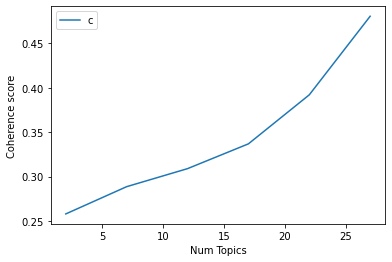

In [64]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [65]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.258
index: 1 | Num Topics = 7  has Coherence Value of 0.2887
index: 2 | Num Topics = 12  has Coherence Value of 0.309
index: 3 | Num Topics = 17  has Coherence Value of 0.3369
index: 4 | Num Topics = 22  has Coherence Value of 0.3921
index: 5 | Num Topics = 27  has Coherence Value of 0.4805


In [66]:
# Select optimal number of topics
optimal_model_ph_score2 = model_list_ph_score2[5]

In [67]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score2 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score2, corpus_ph_score2, id2word_ph_score2)

In [68]:
print("pyLDAVis for ph topics for score=2:")
vis_ph_score2

pyLDAVis for ph topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
25    -0.126183  0.027786       1        1  12.252523
18    -0.112874  0.071877       2        1   8.755877
1     -0.113143  0.045880       3        1   7.458377
19    -0.089831 -0.005475       4        1   6.987985
7      0.026214  0.010089       5        1   5.483103
6     -0.090502 -0.081843       6        1   5.294257
24    -0.105725 -0.034366       7        1   4.869521
16    -0.012508  0.186527       8        1   4.851213
15    -0.078877 -0.032268       9        1   3.891289
0     -0.026681  0.011808      10        1   3.636495
10    -0.001741  0.032734      11        1   3.597771
21    -0.003512 -0.044686      12        1   3.584732
11    -0.010267  0.055218      13        1   3.523939
23    -0.046909 -0.119199      14        1   3.175949
13    -0.073126 -0.086653      15        1   3.103362
20     0.055907 -0.165678      16        1   3.089593
14    -0.007367  0.036029      17        1   2.945478
22     0.047147 -0.032804      18        1   2.365443
4      0.035149  0.067371      19        1   2.213865
8      0.040239  0.040555      20        1   1.753572
3      0.127495  0.085206      21        1   1.728237
12     0.077074  0.063654      22        1   1.638613
5      0.030578  0.008197      23        1   1.251943
26     0.102013 -0.078722      24        1   1.175194
2      0.117155 -0.032586      25        1   1.098458
17     0.120137 -0.014324      26        1   0.136605
9      0.120137 -0.014324      27        1   0.136605, topic_info=        Term       Freq      Total Category  logprob  loglift
0    account  75.000000  75.000000  Default  30.0000  30.0000
12      post  52.000000  52.000000  Default  29.0000  29.0000
14     story  52.000000  52.000000  Default  28.0000  28.0000
252   filter  15.000000  15.000000  Default  27.0000  27.0000
292     work  21.000000  21.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
263     open   0.005102   7.979327  Topic27  -6.5468  -0.7592
0    account   0.005102  75.413239  Topic27  -6.5468  -3.0053
1        bug   0.005102   6.671706  Topic27  -6.5468  -0.5802
2    certain   0.005102   4.034290  Topic27  -6.5468  -0.0772
3     change   0.005102  14.529649  Topic27  -6.5468  -1.3586

[1342 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
216       1  0.310861        able
216       8  0.310861        able
216      12  0.310861        able
458       1  0.618655  absolutely
476       2  0.629152      access
...     ...       ...         ...
168       5  0.306198         yet
168       7  0.153099         yet
168       9  0.153099         yet
168      12  0.153099         yet
200       9  0.664200         zap

[1623 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[26, 19, 2, 20, 8, 7, 25, 17, 16, 1, 11, 22, 12, 24, 14, 21, 15, 23, 5, 9, 4, 13, 6, 27, 3, 18, 10])

## LDA Topic Modelling (Rating = 3)

In [69]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_ph_score3 = instagram_ios_ph_review_YearMonth_score3.review.values.tolist()
review_words_ph_score3 = list(sent_to_words(review_ph_score3))
print(review_words_ph_score3[:1])

[['hi', 'archived', 'few', 'posts', 'few', 'months', 'back', 'and', 'decided', 'to', 'remove', 'instagram', 'when', 'decided', 'redownload', 'however', 'the', 'archived', 'posts', 'are', 'missing', 'and', 'really', 'want', 'to', 'delete', 'those', 'archived', 'posts', 'my', 'profile', 'indicates', 'post', 'but', 'actually', 'there', 'are', 'less', 'are', 'there', 'any', 'ways', 'can', 'correct', 'this']]


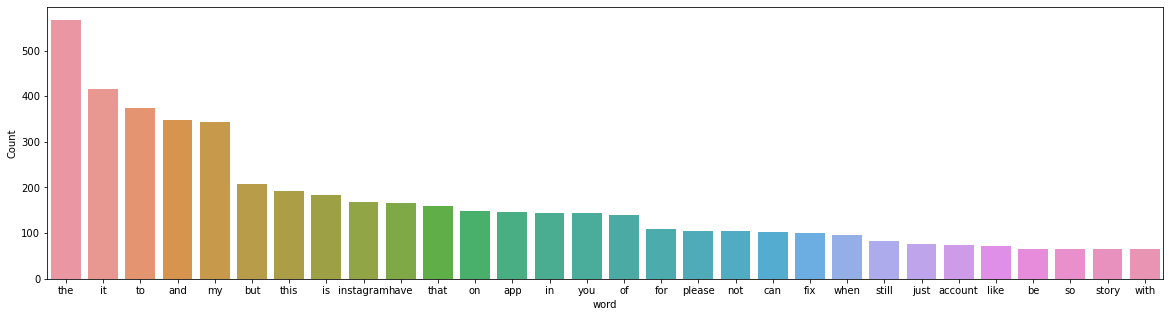

In [70]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score3))

In [71]:
# Clean text
review_ph_ready_score3 = process_words(review_words_ph_score3)  # processed Text Data! - move to each section


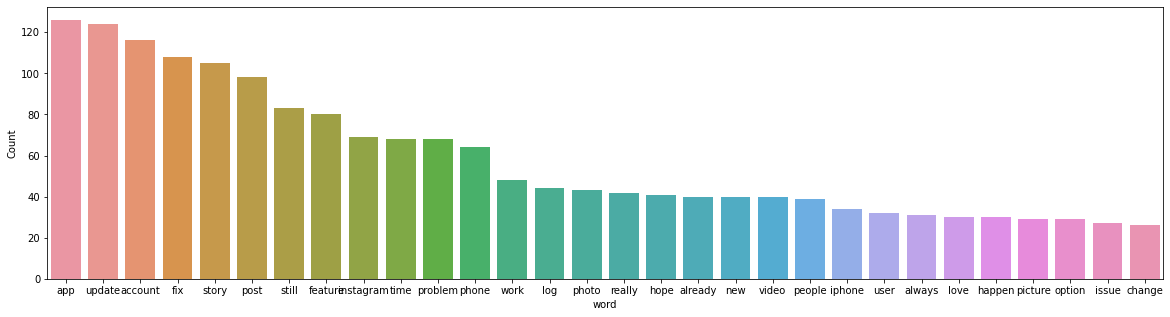

In [72]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score3))


In [73]:
# Create Dictionary
id2word_ph_score3 = corpora.Dictionary(review_ph_ready_score3)

2021-10-16 02:02:54,070 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:02:54,093 [INFO] gensim.corpora.dictionary - built Dictionary(928 unique tokens: ['actually', 'archived', 'back', 'correct', 'decide']...) from 211 documents (total 4873 corpus positions)
2021-10-16 02:02:54,095 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(928 unique tokens: ['actually', 'archived', 'back', 'correct', 'decide']...) from 211 documents (total 4873 corpus positions)", 'datetime': '2021-10-16T02:02:54.095181', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [74]:
# Create Corpus: Term Document Frequency
corpus_ph_score3 = [id2word_ph_score3.doc2bow(text) for text in review_ph_ready_score3]

In [75]:
# Training LDA model
model_list_ph_score3, coherence_values_ph_score3 = compute_coherence_values(dictionary=id2word_ph_score3, corpus=corpus_ph_score3, 
                                                              texts=review_ph_ready_score3, limit=30, start=2, step=5)


2021-10-16 02:02:54,125 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:02:54,128 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:02:54,131 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:02:54,133 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 211 documents, updating model once every 211 documents, evaluating perplexity every 211 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:02:55,158 [INFO] gensim.models.ldamodel - -7.385 per-word bound, 167.1 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:02:55,182 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #211/211
2021-10-16 02:02:55,856 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"account" + 0.025*"app" + 0.021*"update" + 0.018*"still" + 0.018*"fix" + 0.016*"post" + 0.016*"sto

2021-10-16 02:03:07,657 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"update" + 0.023*"fix" + 0.020*"story" + 0.020*"app" + 0.018*"phone" + 0.018*"post" + 0.018*"feature" + 0.013*"time" + 0.013*"instagram" + 0.012*"still"
2021-10-16 02:03:07,661 [INFO] gensim.models.ldamodel - topic diff=0.012206, rho=0.301511
2021-10-16 02:03:08,327 [INFO] gensim.models.ldamodel - -6.172 per-word bound, 72.1 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:03:08,329 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #211/211
2021-10-16 02:03:09,024 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"account" + 0.023*"app" + 0.018*"update" + 0.017*"still" + 0.016*"post" + 0.016*"story" + 0.015*"fix" + 0.013*"problem" + 0.012*"really" + 0.012*"log"
2021-10-16 02:03:09,046 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"update" + 0.023*"fix" + 0.020*"story" + 0.020*"app" + 0.018*"phone" + 0.018*"feature" + 0.018*"post" + 0.

2021-10-16 02:03:19,121 [INFO] gensim.models.ldamodel - topic diff=0.006262, rho=0.218218
2021-10-16 02:03:19,815 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:03:19,816 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #211/211
2021-10-16 02:03:20,246 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"account" + 0.023*"app" + 0.017*"update" + 0.017*"post" + 0.016*"story" + 0.016*"still" + 0.014*"fix" + 0.013*"problem" + 0.012*"really" + 0.012*"log"
2021-10-16 02:03:20,249 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"update" + 0.024*"fix" + 0.021*"app" + 0.021*"story" + 0.019*"feature" + 0.018*"phone" + 0.018*"post" + 0.013*"time" + 0.013*"still" + 0.013*"instagram"
2021-10-16 02:03:20,253 [INFO] gensim.models.ldamodel - topic diff=0.006031, rho=0.213201
2021-10-16 02:03:20,766 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity e

2021-10-16 02:03:30,100 [INFO] gensim.models.ldamodel - -6.163 per-word bound, 71.6 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:03:30,104 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #211/211
2021-10-16 02:03:30,500 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"account" + 0.022*"app" + 0.017*"update" + 0.017*"post" + 0.016*"story" + 0.015*"still" + 0.013*"fix" + 0.013*"problem" + 0.012*"really" + 0.012*"log"
2021-10-16 02:03:30,502 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"update" + 0.024*"fix" + 0.022*"app" + 0.021*"story" + 0.019*"feature" + 0.018*"phone" + 0.017*"post" + 0.014*"still" + 0.014*"time" + 0.013*"instagram"
2021-10-16 02:03:30,507 [INFO] gensim.models.ldamodel - topic diff=0.004563, rho=0.176777
2021-10-16 02:03:30,961 [INFO] gensim.models.ldamodel - -6.163 per-word bound, 71.6 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:03:30,96

2021-10-16 02:03:39,085 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #211/211
2021-10-16 02:03:39,525 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"account" + 0.021*"app" + 0.017*"update" + 0.016*"post" + 0.016*"story" + 0.015*"still" + 0.013*"fix" + 0.013*"problem" + 0.012*"really" + 0.012*"instagram"
2021-10-16 02:03:39,542 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"update" + 0.024*"fix" + 0.023*"app" + 0.021*"story" + 0.019*"feature" + 0.018*"phone" + 0.018*"post" + 0.014*"still" + 0.014*"time" + 0.012*"instagram"
2021-10-16 02:03:39,580 [INFO] gensim.models.ldamodel - topic diff=0.003708, rho=0.154303
2021-10-16 02:03:40,029 [INFO] gensim.models.ldamodel - -6.160 per-word bound, 71.5 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:03:40,031 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #211/211
2021-10-16 02:03:40,381 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"acc

2021-10-16 02:03:47,212 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:03:52,107 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:03:52,141 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 211 virtual documents
2021-10-16 02:03:52,395 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:03:52,429 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:03:52,434 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:03:52,440 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 211 documents, updating model once every 211 documents, evaluating perplexity every 211 documents, iterating 50x with a con

2021-10-16 02:03:56,621 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"story" + 0.025*"phone" + 0.022*"account" + 0.017*"update" + 0.015*"video" + 0.015*"post" + 0.015*"app" + 0.013*"iphone" + 0.012*"fix" + 0.012*"add"
2021-10-16 02:03:56,623 [INFO] gensim.models.ldamodel - topic diff=0.079392, rho=0.408248
2021-10-16 02:03:56,971 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:03:56,973 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #211/211
2021-10-16 02:03:57,242 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"post" + 0.029*"really" + 0.022*"fix" + 0.022*"comment" + 0.015*"hope" + 0.014*"caption" + 0.013*"image" + 0.013*"quality" + 0.012*"picture" + 0.012*"able"
2021-10-16 02:03:57,244 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"still" + 0.022*"app" + 0.021*"update" + 0.021*"fix" + 0.016*"account" + 0.016*"post" + 0.013*"picture" + 

2021-10-16 02:04:00,505 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"account" + 0.022*"log" + 0.017*"password" + 0.016*"update" + 0.016*"app" + 0.015*"story" + 0.014*"feature" + 0.010*"remove" + 0.009*"really" + 0.009*"click"
2021-10-16 02:04:00,546 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"story" + 0.025*"phone" + 0.023*"account" + 0.016*"video" + 0.015*"update" + 0.015*"post" + 0.015*"app" + 0.014*"iphone" + 0.012*"fix" + 0.012*"add"
2021-10-16 02:04:00,558 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.052*"post" + 0.030*"really" + 0.022*"fix" + 0.022*"comment" + 0.016*"image" + 0.015*"hope" + 0.015*"caption" + 0.014*"quality" + 0.013*"able" + 0.012*"picture"
2021-10-16 02:04:00,577 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"still" + 0.022*"app" + 0.021*"update" + 0.020*"fix" + 0.016*"account" + 0.014*"post" + 0.014*"picture" + 0.012*"story" + 0.012*"version" + 0.011*"phone"
2021-10-16 02:04:00,580 [INFO] gensim.models.ldamodel - topic #

2021-10-16 02:04:03,621 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"story" + 0.024*"phone" + 0.023*"account" + 0.016*"video" + 0.015*"post" + 0.015*"app" + 0.014*"update" + 0.014*"iphone" + 0.013*"fix" + 0.012*"add"
2021-10-16 02:04:03,624 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"update" + 0.035*"app" + 0.031*"feature" + 0.026*"fix" + 0.024*"story" + 0.020*"account" + 0.020*"problem" + 0.019*"still" + 0.019*"time" + 0.018*"instagram"
2021-10-16 02:04:03,628 [INFO] gensim.models.ldamodel - topic diff=0.006940, rho=0.242536
2021-10-16 02:04:03,999 [INFO] gensim.models.ldamodel - -6.359 per-word bound, 82.1 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:04,001 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #211/211
2021-10-16 02:04:04,251 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"account" + 0.022*"log" + 0.017*"password" + 0.016*"update" + 0.016*"app" + 0.015*"story" + 0.014*"feat

2021-10-16 02:04:07,377 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #211/211
2021-10-16 02:04:07,706 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"story" + 0.024*"phone" + 0.023*"account" + 0.016*"video" + 0.015*"post" + 0.015*"app" + 0.014*"iphone" + 0.013*"update" + 0.013*"fix" + 0.012*"add"
2021-10-16 02:04:07,708 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"update" + 0.022*"fix" + 0.020*"still" + 0.019*"filter" + 0.018*"app" + 0.015*"problem" + 0.015*"story" + 0.014*"follower" + 0.012*"show" + 0.011*"block"
2021-10-16 02:04:07,710 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.020*"post" + 0.018*"follow" + 0.017*"instagram" + 0.017*"people" + 0.017*"time" + 0.017*"photo" + 0.016*"work" + 0.015*"upload" + 0.014*"app"
2021-10-16 02:04:07,711 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.022*"still" + 0.020*"app" + 0.019*"update" + 0.019*"fix" + 0.016*"account" + 0.014*"picture" + 0.014*"version" + 0.014*"post" + 0

2021-10-16 02:04:11,715 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"story" + 0.023*"phone" + 0.023*"account" + 0.016*"video" + 0.015*"post" + 0.015*"app" + 0.014*"iphone" + 0.013*"fix" + 0.013*"update" + 0.012*"add"
2021-10-16 02:04:11,716 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"update" + 0.021*"fix" + 0.020*"filter" + 0.019*"still" + 0.018*"app" + 0.015*"problem" + 0.014*"follower" + 0.014*"story" + 0.011*"show" + 0.011*"block"
2021-10-16 02:04:11,718 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.020*"post" + 0.018*"follow" + 0.017*"people" + 0.017*"instagram" + 0.017*"photo" + 0.017*"time" + 0.016*"work" + 0.015*"upload" + 0.014*"app"
2021-10-16 02:04:11,719 [INFO] gensim.models.ldamodel - topic diff=0.002650, rho=0.188982
2021-10-16 02:04:12,003 [INFO] gensim.models.ldamodel - -6.354 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:12,005 [INFO] gensim.models.ld

2021-10-16 02:04:14,833 [INFO] gensim.models.ldamodel - topic diff=0.002265, rho=0.174078
2021-10-16 02:04:15,107 [INFO] gensim.models.ldamodel - -6.354 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:15,108 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #211/211
2021-10-16 02:04:15,316 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"story" + 0.023*"phone" + 0.023*"account" + 0.016*"video" + 0.015*"post" + 0.015*"app" + 0.014*"iphone" + 0.013*"fix" + 0.012*"update" + 0.012*"add"
2021-10-16 02:04:15,319 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"update" + 0.021*"fix" + 0.020*"filter" + 0.019*"still" + 0.018*"app" + 0.015*"problem" + 0.014*"follower" + 0.013*"story" + 0.011*"show" + 0.011*"block"
2021-10-16 02:04:15,324 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.054*"post" + 0.030*"really" + 0.022*"comment" + 0.021*"fix" + 0.017*"image" + 0.015*"hope" + 0.015*"caption" + 

2021-10-16 02:04:18,857 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"still" + 0.017*"app" + 0.016*"fix" + 0.016*"version" + 0.015*"account" + 0.015*"update" + 0.015*"picture" + 0.014*"post" + 0.012*"screen" + 0.011*"type"
2021-10-16 02:04:18,863 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.054*"post" + 0.030*"really" + 0.022*"comment" + 0.021*"fix" + 0.017*"image" + 0.015*"hope" + 0.015*"caption" + 0.014*"quality" + 0.014*"able" + 0.012*"picture"
2021-10-16 02:04:18,865 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"account" + 0.022*"log" + 0.017*"password" + 0.016*"update" + 0.016*"app" + 0.015*"story" + 0.014*"feature" + 0.010*"remove" + 0.009*"click" + 0.009*"filter"
2021-10-16 02:04:18,867 [INFO] gensim.models.ldamodel - topic diff=0.001892, rho=0.160128
2021-10-16 02:04:19,300 [INFO] gensim.models.ldamodel - -6.353 per-word bound, 81.7 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:19,301 [INFO] gensim.

2021-10-16 02:04:23,722 [INFO] gensim.models.ldamodel - topic diff=0.001484, rho=0.150756
2021-10-16 02:04:24,098 [INFO] gensim.models.ldamodel - -6.352 per-word bound, 81.7 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:24,100 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #211/211
2021-10-16 02:04:24,343 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"still" + 0.016*"app" + 0.016*"version" + 0.015*"picture" + 0.015*"account" + 0.015*"fix" + 0.014*"post" + 0.014*"update" + 0.012*"screen" + 0.011*"type"
2021-10-16 02:04:24,344 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.023*"update" + 0.021*"filter" + 0.020*"fix" + 0.018*"still" + 0.018*"app" + 0.014*"follower" + 0.013*"problem" + 0.012*"story" + 0.011*"show" + 0.011*"block"
2021-10-16 02:04:24,346 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"account" + 0.022*"log" + 0.017*"password" + 0.016*"update" + 0.016*"app" + 0.015*"story" + 0.014*"fea

2021-10-16 02:04:27,353 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.021*"account" + 0.020*"post" + 0.018*"follow" + 0.017*"people" + 0.017*"instagram" + 0.017*"photo" + 0.016*"time" + 0.016*"work" + 0.015*"upload" + 0.014*"app"
2021-10-16 02:04:27,355 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"still" + 0.016*"version" + 0.016*"app" + 0.016*"picture" + 0.015*"account" + 0.015*"fix" + 0.014*"post" + 0.013*"update" + 0.012*"screen" + 0.011*"type"
2021-10-16 02:04:27,356 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.054*"post" + 0.030*"really" + 0.022*"comment" + 0.020*"fix" + 0.017*"image" + 0.015*"hope" + 0.015*"caption" + 0.014*"quality" + 0.014*"able" + 0.012*"picture"
2021-10-16 02:04:27,359 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"update" + 0.036*"app" + 0.031*"feature" + 0.028*"fix" + 0.027*"story" + 0.022*"account" + 0.022*"problem" + 0.021*"still" + 0.019*"phone" + 0.019*"time"
2021-10-16 02:04:27,362 [INFO] gensim.models.ldamodel - topi

2021-10-16 02:04:37,744 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"phone" + 0.030*"story" + 0.018*"iphone" + 0.017*"account" + 0.017*"appear" + 0.017*"edit" + 0.017*"update" + 0.016*"button" + 0.014*"click" + 0.014*"photo"
2021-10-16 02:04:37,745 [INFO] gensim.models.ldamodel - topic diff=0.181835, rho=0.500000
2021-10-16 02:04:38,225 [INFO] gensim.models.ldamodel - -6.568 per-word bound, 94.9 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:38,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #211/211
2021-10-16 02:04:38,501 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"app" + 0.026*"still" + 0.025*"story" + 0.024*"update" + 0.022*"problem" + 0.022*"fix" + 0.020*"post" + 0.018*"comment" + 0.017*"feature" + 0.016*"crash"
2021-10-16 02:04:38,503 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"phone" + 0.030*"story" + 0.018*"iphone" + 0.017*"account" + 0.017*"appear" + 0.017*"edit" + 0.017*"

2021-10-16 02:04:41,846 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.027*"account" + 0.023*"instagram" + 0.023*"feature" + 0.023*"phone" + 0.021*"post" + 0.018*"work" + 0.018*"user" + 0.017*"update" + 0.017*"story" + 0.014*"add"
2021-10-16 02:04:41,849 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.025*"time" + 0.021*"follow" + 0.020*"people" + 0.018*"post" + 0.018*"account" + 0.017*"photo" + 0.017*"still" + 0.015*"work" + 0.015*"update" + 0.015*"upload"
2021-10-16 02:04:41,851 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"account" + 0.023*"filter" + 0.023*"story" + 0.018*"photo" + 0.017*"app" + 0.013*"update" + 0.013*"video" + 0.013*"feature" + 0.013*"report" + 0.013*"reason"
2021-10-16 02:04:41,853 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"time" + 0.020*"app" + 0.020*"account" + 0.017*"still" + 0.017*"story" + 0.015*"fix" + 0.015*"feature" + 0.015*"video" + 0.015*"issue" + 0.011*"update"
2021-10-16 02:04:41,855 [INFO] gensim.models.ldamodel - to

2021-10-16 02:04:45,098 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"account" + 0.023*"filter" + 0.023*"story" + 0.018*"photo" + 0.018*"app" + 0.013*"update" + 0.013*"video" + 0.013*"feature" + 0.013*"report" + 0.013*"reason"
2021-10-16 02:04:45,099 [INFO] gensim.models.ldamodel - topic diff=0.010797, rho=0.258199
2021-10-16 02:04:45,463 [INFO] gensim.models.ldamodel - -6.504 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:45,465 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #211/211
2021-10-16 02:04:45,731 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.056*"update" + 0.040*"app" + 0.031*"fix" + 0.025*"feature" + 0.020*"still" + 0.019*"new" + 0.019*"story" + 0.019*"problem" + 0.015*"post" + 0.015*"phone"
2021-10-16 02:04:45,733 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.113*"account" + 0.052*"log" + 0.030*"feature" + 0.021*"fix" + 0.019*"change" + 0.014*"still" + 0.013*"lik

2021-10-16 02:04:48,519 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.027*"app" + 0.020*"update" + 0.019*"video" + 0.017*"instagram" + 0.017*"fix" + 0.016*"story" + 0.015*"back" + 0.012*"click" + 0.012*"post" + 0.012*"quality"
2021-10-16 02:04:48,521 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"time" + 0.020*"app" + 0.020*"account" + 0.016*"story" + 0.016*"still" + 0.015*"fix" + 0.015*"feature" + 0.015*"video" + 0.015*"issue" + 0.011*"update"
2021-10-16 02:04:48,524 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"post" + 0.038*"really" + 0.021*"picture" + 0.019*"feature" + 0.018*"fix" + 0.016*"hope" + 0.015*"app" + 0.014*"instagram" + 0.013*"photo" + 0.012*"version"
2021-10-16 02:04:48,527 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.026*"fix" + 0.023*"filter" + 0.020*"still" + 0.019*"follower" + 0.017*"save" + 0.017*"app" + 0.016*"show" + 0.014*"problem" + 0.013*"story" + 0.013*"block"
2021-10-16 02:04:48,529 [INFO] gensim.models.ldamodel - topic #5 (

2021-10-16 02:04:51,451 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"account" + 0.023*"filter" + 0.023*"story" + 0.018*"photo" + 0.018*"app" + 0.013*"update" + 0.013*"video" + 0.013*"feature" + 0.013*"report" + 0.013*"reason"
2021-10-16 02:04:51,455 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"time" + 0.020*"app" + 0.020*"account" + 0.016*"story" + 0.016*"still" + 0.015*"fix" + 0.015*"feature" + 0.015*"video" + 0.015*"issue" + 0.010*"update"
2021-10-16 02:04:51,457 [INFO] gensim.models.ldamodel - topic diff=0.002677, rho=0.196116
2021-10-16 02:04:51,846 [INFO] gensim.models.ldamodel - -6.498 per-word bound, 90.4 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:51,847 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #211/211
2021-10-16 02:04:52,061 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"time" + 0.020*"app" + 0.020*"account" + 0.016*"story" + 0.016*"still" + 0.015*"fix" + 0.015*"featur

2021-10-16 02:04:54,696 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #211/211
2021-10-16 02:04:54,892 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"app" + 0.025*"still" + 0.025*"story" + 0.023*"update" + 0.023*"problem" + 0.022*"fix" + 0.020*"post" + 0.019*"comment" + 0.017*"crash" + 0.015*"feature"
2021-10-16 02:04:54,895 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.027*"app" + 0.020*"update" + 0.019*"video" + 0.017*"instagram" + 0.017*"fix" + 0.016*"story" + 0.015*"back" + 0.012*"quality" + 0.012*"click" + 0.012*"post"
2021-10-16 02:04:54,900 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.118*"account" + 0.059*"log" + 0.030*"feature" + 0.021*"fix" + 0.019*"change" + 0.014*"still" + 0.013*"like" + 0.012*"instagram" + 0.011*"option" + 0.011*"link"
2021-10-16 02:04:54,904 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"post" + 0.038*"really" + 0.022*"picture" + 0.019*"feature" + 0.018*"fix" + 0.016*"hope" + 0.015*"app" + 0.014*"instagra

2021-10-16 02:04:57,771 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.026*"phone" + 0.023*"account" + 0.022*"instagram" + 0.022*"feature" + 0.021*"post" + 0.018*"user" + 0.016*"story" + 0.016*"update" + 0.016*"work" + 0.015*"video"
2021-10-16 02:04:57,781 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.031*"phone" + 0.028*"story" + 0.018*"account" + 0.018*"edit" + 0.018*"button" + 0.018*"iphone" + 0.017*"appear" + 0.015*"click" + 0.015*"photo" + 0.014*"camera"
2021-10-16 02:04:57,789 [INFO] gensim.models.ldamodel - topic diff=0.000945, rho=0.164399
2021-10-16 02:04:58,176 [INFO] gensim.models.ldamodel - -6.496 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:04:58,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #211/211
2021-10-16 02:04:58,387 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.026*"fix" + 0.023*"filter" + 0.020*"still" + 0.019*"follower" + 0.017*"save" + 0.017*"app" + 0.016

2021-10-16 02:05:01,025 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #211/211
2021-10-16 02:05:01,292 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"post" + 0.038*"really" + 0.022*"picture" + 0.019*"feature" + 0.018*"fix" + 0.016*"hope" + 0.015*"app" + 0.014*"instagram" + 0.013*"photo" + 0.012*"version"
2021-10-16 02:05:01,338 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.025*"time" + 0.021*"follow" + 0.020*"people" + 0.019*"post" + 0.017*"photo" + 0.017*"still" + 0.016*"account" + 0.015*"work" + 0.015*"upload" + 0.015*"update"
2021-10-16 02:05:01,340 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.033*"app" + 0.025*"story" + 0.025*"still" + 0.023*"update" + 0.023*"problem" + 0.022*"fix" + 0.020*"post" + 0.019*"comment" + 0.017*"crash" + 0.015*"feature"
2021-10-16 02:05:01,341 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"time" + 0.020*"app" + 0.020*"account" + 0.016*"story" + 0.016*"still" + 0.015*"issue" + 0.015*"fix" + 0.015*"video" +

2021-10-16 02:05:04,230 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.119*"account" + 0.063*"log" + 0.030*"feature" + 0.021*"fix" + 0.019*"change" + 0.013*"like" + 0.013*"still" + 0.012*"instagram" + 0.011*"option" + 0.011*"link"
2021-10-16 02:05:04,231 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.058*"update" + 0.040*"app" + 0.031*"fix" + 0.025*"feature" + 0.021*"still" + 0.021*"new" + 0.019*"story" + 0.019*"problem" + 0.015*"phone" + 0.015*"instagram"
2021-10-16 02:05:04,233 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.027*"app" + 0.020*"update" + 0.019*"video" + 0.017*"instagram" + 0.017*"fix" + 0.016*"story" + 0.015*"back" + 0.013*"quality" + 0.012*"click" + 0.012*"work"
2021-10-16 02:05:04,235 [INFO] gensim.models.ldamodel - topic diff=0.000688, rho=0.144338
2021-10-16 02:05:04,593 [INFO] gensim.models.ldamodel - -6.495 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:04,594 [INFO] gensim.mod

2021-10-16 02:05:13,663 [INFO] gensim.models.ldamodel - topic diff=12.575505, rho=1.000000
2021-10-16 02:05:13,986 [INFO] gensim.models.ldamodel - -6.831 per-word bound, 113.9 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:13,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #211/211
2021-10-16 02:05:14,140 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.043*"add" + 0.033*"account" + 0.031*"feature" + 0.027*"update" + 0.024*"story" + 0.021*"love" + 0.019*"page" + 0.017*"nt" + 0.016*"always" + 0.016*"still"
2021-10-16 02:05:14,142 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.039*"update" + 0.026*"fix" + 0.023*"app" + 0.021*"problem" + 0.021*"post" + 0.020*"new" + 0.018*"always" + 0.018*"phone" + 0.017*"still" + 0.017*"instagram"
2021-10-16 02:05:14,144 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039*"account" + 0.029*"log" + 0.026*"like" + 0.019*"people" + 0.018*"instagram" + 0.015*"follower" + 0.014*

2021-10-16 02:05:16,875 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"account" + 0.024*"story" + 0.024*"work" + 0.023*"feature" + 0.022*"update" + 0.018*"instagram" + 0.016*"post" + 0.016*"fix" + 0.014*"new" + 0.013*"hope"
2021-10-16 02:05:16,876 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.042*"post" + 0.035*"story" + 0.032*"fix" + 0.029*"instagram" + 0.028*"account" + 0.025*"image" + 0.024*"issue" + 0.019*"quality" + 0.016*"share" + 0.015*"photo"
2021-10-16 02:05:16,878 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.031*"fix" + 0.029*"story" + 0.026*"happen" + 0.024*"account" + 0.022*"phone" + 0.021*"still" + 0.019*"really" + 0.016*"app" + 0.016*"change" + 0.016*"camera"
2021-10-16 02:05:16,879 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.035*"app" + 0.031*"feature" + 0.027*"story" + 0.023*"filter" + 0.020*"new" + 0.020*"photo" + 0.020*"account" + 0.018*"update" + 0.014*"well" + 0.014*"love"
2021-10-16 02:05:16,880 [INFO] gensim.models.ldamodel - topic

2021-10-16 02:05:20,035 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.046*"upload" + 0.031*"phone" + 0.027*"video" + 0.027*"story" + 0.024*"photo" + 0.024*"appear" + 0.020*"time" + 0.017*"always" + 0.017*"iphone" + 0.016*"update"
2021-10-16 02:05:20,036 [INFO] gensim.models.ldamodel - topic diff=0.017843, rho=0.277350
2021-10-16 02:05:20,371 [INFO] gensim.models.ldamodel - -6.584 per-word bound, 95.9 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:20,372 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #211/211
2021-10-16 02:05:20,573 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.038*"app" + 0.032*"update" + 0.030*"still" + 0.024*"feature" + 0.023*"already" + 0.023*"fix" + 0.017*"comment" + 0.015*"crash" + 0.015*"reinstall" + 0.014*"story"
2021-10-16 02:05:20,575 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.059*"update" + 0.053*"app" + 0.034*"feature" + 0.023*"still" + 0.021*"fix" + 0.020*"friend" + 0.01

2021-10-16 02:05:23,627 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.034*"feature" + 0.033*"app" + 0.029*"story" + 0.023*"filter" + 0.020*"account" + 0.020*"photo" + 0.020*"new" + 0.017*"update" + 0.015*"love" + 0.014*"well"
2021-10-16 02:05:23,628 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.031*"update" + 0.021*"issue" + 0.021*"time" + 0.016*"fix" + 0.016*"hope" + 0.016*"message" + 0.016*"reply" + 0.016*"app" + 0.016*"camera" + 0.011*"still"
2021-10-16 02:05:23,630 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.035*"fix" + 0.029*"button" + 0.026*"call" + 0.022*"follower" + 0.022*"contact" + 0.017*"different" + 0.017*"hope" + 0.017*"problem" + 0.017*"experience" + 0.015*"user"
2021-10-16 02:05:23,631 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.028*"time" + 0.023*"app" + 0.021*"post" + 0.020*"follow" + 0.020*"people" + 0.015*"instagram" + 0.013*"update" + 0.013*"action" + 0.012*"account" + 0.012*"phone"
2021-10-16 02:05:23,633 [INFO] gensim.models.ldamodel - 

2021-10-16 02:05:26,464 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.030*"feature" + 0.020*"gif" + 0.016*"app" + 0.016*"post" + 0.016*"instagram" + 0.015*"caption" + 0.015*"time" + 0.015*"story" + 0.014*"favorite" + 0.012*"install"
2021-10-16 02:05:26,469 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.035*"fix" + 0.029*"button" + 0.026*"call" + 0.022*"follower" + 0.022*"contact" + 0.017*"different" + 0.017*"hope" + 0.017*"problem" + 0.017*"experience" + 0.015*"user"
2021-10-16 02:05:26,473 [INFO] gensim.models.ldamodel - topic diff=0.003781, rho=0.204124
2021-10-16 02:05:26,808 [INFO] gensim.models.ldamodel - -6.574 per-word bound, 95.3 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:26,815 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #211/211
2021-10-16 02:05:27,090 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.035*"fix" + 0.029*"button" + 0.026*"call" + 0.022*"follower" + 0.022*"contact" + 0.017*"di

2021-10-16 02:05:29,612 [INFO] gensim.models.ldamodel - -6.571 per-word bound, 95.1 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:29,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #211/211
2021-10-16 02:05:29,883 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.033*"update" + 0.026*"fix" + 0.025*"app" + 0.022*"problem" + 0.021*"post" + 0.020*"always" + 0.019*"new" + 0.018*"phone" + 0.016*"still" + 0.013*"time"
2021-10-16 02:05:29,885 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.042*"account" + 0.036*"log" + 0.030*"like" + 0.017*"people" + 0.017*"instagram" + 0.017*"follower" + 0.016*"fix" + 0.014*"suggest" + 0.013*"option" + 0.013*"friend"
2021-10-16 02:05:29,888 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"post" + 0.033*"problem" + 0.030*"story" + 0.022*"log" + 0.020*"account" + 0.018*"people" + 0.014*"add" + 0.014*"option" + 0.014*"photo" + 0.014*"share"
2021-10-16 02:05:29,890 [INFO] gensim

2021-10-16 02:05:32,725 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.028*"time" + 0.022*"app" + 0.021*"post" + 0.020*"follow" + 0.020*"people" + 0.015*"instagram" + 0.013*"update" + 0.013*"action" + 0.012*"account" + 0.012*"phone"
2021-10-16 02:05:32,727 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.030*"feature" + 0.020*"gif" + 0.016*"app" + 0.016*"post" + 0.016*"instagram" + 0.015*"caption" + 0.015*"time" + 0.015*"story" + 0.014*"favorite" + 0.012*"install"
2021-10-16 02:05:32,731 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.062*"update" + 0.053*"app" + 0.034*"feature" + 0.027*"still" + 0.023*"fix" + 0.020*"friend" + 0.019*"already" + 0.018*"story" + 0.018*"phone" + 0.017*"picture"
2021-10-16 02:05:32,732 [INFO] gensim.models.ldamodel - topic diff=0.001690, rho=0.169031
2021-10-16 02:05:33,010 [INFO] gensim.models.ldamodel - -6.569 per-word bound, 94.9 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:33,014 [INFO] 

2021-10-16 02:05:35,669 [INFO] gensim.models.ldamodel - topic diff=0.001583, rho=0.158114
2021-10-16 02:05:36,095 [INFO] gensim.models.ldamodel - -6.568 per-word bound, 94.8 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:36,109 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #211/211
2021-10-16 02:05:36,291 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.068*"upload" + 0.035*"story" + 0.033*"phone" + 0.032*"video" + 0.027*"photo" + 0.023*"time" + 0.021*"appear" + 0.018*"still" + 0.018*"iphone" + 0.016*"always"
2021-10-16 02:05:36,294 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.051*"account" + 0.025*"story" + 0.024*"work" + 0.024*"feature" + 0.023*"update" + 0.020*"instagram" + 0.017*"post" + 0.016*"fix" + 0.014*"new" + 0.013*"hope"
2021-10-16 02:05:36,296 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"fix" + 0.029*"story" + 0.027*"happen" + 0.023*"account" + 0.022*"phone" + 0.021*"still" + 0.019*"re

2021-10-16 02:05:39,732 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"post" + 0.033*"problem" + 0.029*"story" + 0.022*"log" + 0.020*"account" + 0.018*"people" + 0.015*"add" + 0.015*"share" + 0.015*"feed" + 0.015*"photo"
2021-10-16 02:05:39,736 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.028*"time" + 0.022*"app" + 0.021*"post" + 0.021*"follow" + 0.020*"people" + 0.015*"instagram" + 0.013*"update" + 0.013*"action" + 0.012*"account" + 0.011*"phone"
2021-10-16 02:05:39,738 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.031*"update" + 0.021*"time" + 0.021*"issue" + 0.016*"app" + 0.016*"fix" + 0.016*"message" + 0.016*"hope" + 0.016*"reply" + 0.016*"camera" + 0.011*"still"
2021-10-16 02:05:39,740 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.068*"upload" + 0.035*"story" + 0.033*"phone" + 0.032*"video" + 0.027*"photo" + 0.023*"time" + 0.021*"appear" + 0.018*"still" + 0.018*"iphone" + 0.016*"always"
2021-10-16 02:05:39,741 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 02:05:42,630 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"post" + 0.033*"problem" + 0.029*"story" + 0.022*"log" + 0.020*"account" + 0.018*"people" + 0.015*"add" + 0.015*"share" + 0.015*"feed" + 0.015*"photo"
2021-10-16 02:05:42,631 [INFO] gensim.models.ldamodel - topic diff=0.000907, rho=0.140028
2021-10-16 02:05:42,632 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=928, num_topics=17, decay=0.5, chunksize=1000) in 30.16s', 'datetime': '2021-10-16T02:05:42.632735', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:05:42,641 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:05:47,031 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16

2021-10-16 02:05:55,261 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.039*"update" + 0.032*"phone" + 0.029*"text" + 0.023*"iphone" + 0.019*"click" + 0.019*"edit" + 0.018*"app" + 0.018*"story" + 0.017*"time" + 0.015*"green"
2021-10-16 02:05:55,264 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.030*"story" + 0.028*"profile" + 0.024*"account" + 0.021*"delete" + 0.020*"app" + 0.015*"post" + 0.014*"user" + 0.014*"problem" + 0.014*"still" + 0.014*"time"
2021-10-16 02:05:55,273 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.030*"post" + 0.026*"update" + 0.021*"fix" + 0.020*"phone" + 0.019*"problem" + 0.019*"music" + 0.017*"option" + 0.016*"app" + 0.015*"story" + 0.015*"time"
2021-10-16 02:05:55,275 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.042*"story" + 0.032*"problem" + 0.021*"post" + 0.021*"keep" + 0.021*"stop" + 0.021*"motion" + 0.021*"create" + 0.011*"app" + 0.011*"still" + 0.011*"really"
2021-10-16 02:05:55,277 [INFO] gensim.models.ldamodel - topic diff=0.14818

2021-10-16 02:05:58,491 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"follower" + 0.028*"call" + 0.024*"fix" + 0.023*"block" + 0.023*"contact" + 0.020*"filter" + 0.019*"update" + 0.019*"save" + 0.019*"different" + 0.019*"last"
2021-10-16 02:05:58,492 [INFO] gensim.models.ldamodel - topic diff=0.045477, rho=0.301511
2021-10-16 02:05:58,763 [INFO] gensim.models.ldamodel - -6.667 per-word bound, 101.6 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:05:58,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #211/211
2021-10-16 02:05:58,982 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"follower" + 0.028*"call" + 0.024*"fix" + 0.023*"block" + 0.023*"contact" + 0.020*"filter" + 0.019*"update" + 0.019*"save" + 0.019*"different" + 0.019*"last"
2021-10-16 02:05:58,986 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.041*"app" + 0.035*"video" + 0.031*"story" + 0.031*"camera" + 0.023*"phone" + 0.022*"account" + 0.

2021-10-16 02:06:01,759 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.031*"post" + 0.024*"update" + 0.022*"music" + 0.021*"fix" + 0.019*"option" + 0.019*"phone" + 0.019*"problem" + 0.016*"app" + 0.014*"story" + 0.014*"new"
2021-10-16 02:06:01,763 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.030*"story" + 0.028*"profile" + 0.026*"account" + 0.021*"delete" + 0.019*"app" + 0.015*"post" + 0.014*"user" + 0.014*"problem" + 0.014*"still" + 0.014*"time"
2021-10-16 02:06:01,765 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.042*"story" + 0.032*"problem" + 0.021*"post" + 0.021*"motion" + 0.021*"stop" + 0.021*"keep" + 0.021*"create" + 0.011*"app" + 0.011*"still" + 0.011*"really"
2021-10-16 02:06:01,767 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.023*"work" + 0.021*"report" + 0.021*"business" + 0.021*"acct" + 0.021*"account" + 0.019*"phone" + 0.019*"log" + 0.018*"fix" + 0.018*"time" + 0.017*"option"
2021-10-16 02:06:01,769 [INFO] gensim.models.ldamodel - topic #9 (0.045

2021-10-16 02:06:04,298 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.049*"fix" + 0.037*"app" + 0.035*"account" + 0.033*"problem" + 0.021*"photo" + 0.021*"story" + 0.021*"video" + 0.021*"log" + 0.018*"still" + 0.017*"gallery"
2021-10-16 02:06:04,300 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.024*"work" + 0.022*"report" + 0.022*"business" + 0.022*"acct" + 0.018*"time" + 0.017*"option" + 0.017*"screen" + 0.017*"like" + 0.017*"save" + 0.017*"follower"
2021-10-16 02:06:04,304 [INFO] gensim.models.ldamodel - topic diff=0.006619, rho=0.213201
2021-10-16 02:06:04,640 [INFO] gensim.models.ldamodel - -6.644 per-word bound, 100.0 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:04,641 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #211/211
2021-10-16 02:06:04,859 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.036*"filter" + 0.027*"story" + 0.027*"selection" + 0.027*"font" + 0.027*"put" + 0.026*"well" + 0.018*"l

2021-10-16 02:06:07,217 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #211/211
2021-10-16 02:06:07,437 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.032*"post" + 0.024*"update" + 0.022*"music" + 0.021*"fix" + 0.020*"option" + 0.019*"problem" + 0.017*"phone" + 0.016*"app" + 0.014*"new" + 0.014*"follower"
2021-10-16 02:06:07,441 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.053*"update" + 0.045*"feature" + 0.044*"app" + 0.028*"fix" + 0.021*"time" + 0.017*"instagram" + 0.017*"people" + 0.015*"enjoy" + 0.014*"type" + 0.014*"mode"
2021-10-16 02:06:07,446 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.066*"facebook" + 0.054*"account" + 0.042*"change" + 0.033*"connect" + 0.025*"name" + 0.025*"link" + 0.021*"day" + 0.020*"fix" + 0.019*"like" + 0.017*"option"
2021-10-16 02:06:07,451 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.025*"work" + 0.022*"report" + 0.022*"business" + 0.022*"acct" + 0.019*"option" + 0.018*"screen" + 0.018*"like" + 0.018*"save" 

2021-10-16 02:06:10,172 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"post" + 0.040*"photo" + 0.029*"gallery" + 0.029*"account" + 0.019*"instagram" + 0.019*"user" + 0.018*"picture" + 0.018*"acc" + 0.018*"check" + 0.017*"medium"
2021-10-16 02:06:10,178 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.036*"filter" + 0.027*"story" + 0.027*"selection" + 0.027*"font" + 0.027*"put" + 0.026*"well" + 0.018*"love" + 0.018*"feature" + 0.018*"photo" + 0.018*"ig"
2021-10-16 02:06:10,182 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.025*"work" + 0.023*"report" + 0.023*"business" + 0.023*"acct" + 0.021*"option" + 0.018*"screen" + 0.018*"like" + 0.018*"save" + 0.018*"follower" + 0.018*"time"
2021-10-16 02:06:10,184 [INFO] gensim.models.ldamodel - topic diff=0.002910, rho=0.174078
2021-10-16 02:06:10,483 [INFO] gensim.models.ldamodel - -6.639 per-word bound, 99.7 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:10,484 [INFO] gensim.

2021-10-16 02:06:12,841 [INFO] gensim.models.ldamodel - topic diff=0.002456, rho=0.162221
2021-10-16 02:06:13,131 [INFO] gensim.models.ldamodel - -6.638 per-word bound, 99.6 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:13,132 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #211/211
2021-10-16 02:06:13,404 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.052*"update" + 0.046*"feature" + 0.044*"app" + 0.028*"fix" + 0.021*"time" + 0.017*"people" + 0.017*"instagram" + 0.015*"enjoy" + 0.014*"type" + 0.014*"mode"
2021-10-16 02:06:13,406 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.023*"app" + 0.023*"people" + 0.022*"story" + 0.015*"update" + 0.014*"photo" + 0.014*"account" + 0.012*"option" + 0.012*"friend" + 0.012*"password" + 0.012*"conversation"
2021-10-16 02:06:13,408 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"follower" + 0.028*"call" + 0.024*"fix" + 0.023*"contact" + 0.023*"block" + 0.023*"filter

2021-10-16 02:06:16,189 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.025*"work" + 0.023*"report" + 0.023*"business" + 0.023*"acct" + 0.022*"option" + 0.018*"screen" + 0.018*"like" + 0.018*"save" + 0.018*"follower" + 0.018*"time"
2021-10-16 02:06:16,192 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.057*"post" + 0.030*"feature" + 0.028*"button" + 0.027*"hope" + 0.026*"picture" + 0.024*"fix" + 0.018*"update" + 0.018*"translate" + 0.018*"archived" + 0.018*"effect"
2021-10-16 02:06:16,195 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.050*"app" + 0.035*"crash" + 0.031*"still" + 0.030*"fix" + 0.028*"time" + 0.027*"problem" + 0.026*"open" + 0.025*"post" + 0.024*"update" + 0.023*"happen"
2021-10-16 02:06:16,197 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.032*"post" + 0.024*"update" + 0.022*"music" + 0.021*"fix" + 0.020*"option" + 0.019*"problem" + 0.017*"phone" + 0.016*"app" + 0.014*"follower" + 0.014*"new"
2021-10-16 02:06:16,199 [INFO] gensim.models.ldamodel - topi

2021-10-16 02:06:18,780 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.190*"account" + 0.122*"log" + 0.042*"phone" + 0.026*"help" + 0.025*"still" + 0.023*"fix" + 0.022*"story" + 0.021*"instagram" + 0.019*"delete" + 0.017*"feature"
2021-10-16 02:06:18,782 [INFO] gensim.models.ldamodel - topic diff=0.001417, rho=0.142857
2021-10-16 02:06:19,103 [INFO] gensim.models.ldamodel - -6.635 per-word bound, 99.4 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:19,108 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #211/211
2021-10-16 02:06:19,264 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.053*"update" + 0.046*"feature" + 0.044*"app" + 0.027*"fix" + 0.021*"time" + 0.017*"people" + 0.017*"instagram" + 0.015*"enjoy" + 0.014*"type" + 0.014*"mode"
2021-10-16 02:06:19,266 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.036*"filter" + 0.027*"story" + 0.027*"selection" + 0.027*"font" + 0.027*"put" + 0.026*"well" + 0.018*"l

2021-10-16 02:06:31,016 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.037*"post" + 0.036*"picture" + 0.036*"photo" + 0.036*"old" + 0.019*"maintain" + 0.019*"previous" + 0.019*"curation" + 0.019*"miss" + 0.019*"bug" + 0.019*"arrangement"
2021-10-16 02:06:31,018 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.044*"update" + 0.030*"fix" + 0.025*"always" + 0.024*"post" + 0.022*"problem" + 0.022*"app" + 0.019*"feature" + 0.016*"story" + 0.016*"instagram" + 0.016*"new"
2021-10-16 02:06:31,020 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.035*"instagram" + 0.033*"account" + 0.030*"story" + 0.030*"add" + 0.027*"sticker" + 0.024*"fix" + 0.024*"countdown" + 0.019*"problem" + 0.018*"list" + 0.017*"notice"
2021-10-16 02:06:31,022 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.069*"post" + 0.027*"comment" + 0.024*"story" + 0.018*"instagram" + 0.017*"problem" + 0.016*"log" + 0.015*"account" + 0.015*"fix" + 0.015*"image" + 0.014*"well"
2021-10-16 02:06:31,023 [INFO] gensim.model

2021-10-16 02:06:33,920 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.040*"app" + 0.033*"update" + 0.017*"phone" + 0.016*"people" + 0.016*"fix" + 0.015*"still" + 0.014*"really" + 0.014*"call" + 0.014*"picture" + 0.013*"post"
2021-10-16 02:06:33,922 [INFO] gensim.models.ldamodel - topic diff=0.066830, rho=0.333333
2021-10-16 02:06:34,180 [INFO] gensim.models.ldamodel - -6.768 per-word bound, 109.0 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:34,182 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #211/211
2021-10-16 02:06:34,388 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.071*"post" + 0.028*"comment" + 0.024*"story" + 0.019*"instagram" + 0.017*"problem" + 0.016*"log" + 0.016*"image" + 0.016*"account" + 0.015*"fix" + 0.015*"quality"
2021-10-16 02:06:34,390 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.034*"update" + 0.033*"feature" + 0.030*"app" + 0.027*"story" + 0.023*"account" + 0.023*"phone" + 0.019

2021-10-16 02:06:37,112 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.040*"app" + 0.032*"update" + 0.017*"phone" + 0.016*"people" + 0.016*"fix" + 0.015*"still" + 0.014*"really" + 0.014*"call" + 0.014*"picture" + 0.013*"well"
2021-10-16 02:06:37,114 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.034*"app" + 0.025*"audio" + 0.025*"already" + 0.017*"big" + 0.017*"screen" + 0.017*"tool" + 0.017*"business" + 0.017*"always" + 0.017*"hope" + 0.017*"background"
2021-10-16 02:06:37,117 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.053*"phone" + 0.053*"photo" + 0.035*"save" + 0.018*"message" + 0.018*"bother" + 0.018*"post" + 0.018*"caption" + 0.018*"fix" + 0.018*"keep" + 0.018*"put"
2021-10-16 02:06:37,119 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.072*"post" + 0.028*"comment" + 0.024*"story" + 0.020*"instagram" + 0.017*"problem" + 0.016*"log" + 0.016*"image" + 0.016*"account" + 0.015*"fix" + 0.015*"quality"
2021-10-16 02:06:37,121 [INFO] gensim.models.ldamodel - topi

2021-10-16 02:06:39,751 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.049*"account" + 0.042*"feature" + 0.025*"story" + 0.025*"report" + 0.025*"new" + 0.016*"problem" + 0.016*"time" + 0.016*"acct" + 0.016*"log" + 0.014*"update"
2021-10-16 02:06:39,752 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.056*"feature" + 0.040*"update" + 0.034*"still" + 0.027*"show" + 0.024*"filter" + 0.021*"fix" + 0.021*"video" + 0.021*"work" + 0.018*"phone" + 0.016*"app"
2021-10-16 02:06:39,753 [INFO] gensim.models.ldamodel - topic diff=0.004096, rho=0.223607
2021-10-16 02:06:40,027 [INFO] gensim.models.ldamodel - -6.754 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:40,034 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #211/211
2021-10-16 02:06:40,322 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.049*"account" + 0.042*"feature" + 0.025*"story" + 0.025*"report" + 0.025*"new" + 0.016*"problem" + 0.016*"

2021-10-16 02:06:42,804 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #211/211
2021-10-16 02:06:42,991 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.058*"update" + 0.038*"app" + 0.027*"story" + 0.027*"post" + 0.027*"always" + 0.027*"able" + 0.025*"still" + 0.022*"issue" + 0.016*"understand" + 0.016*"comment"
2021-10-16 02:06:42,993 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.041*"really" + 0.035*"log" + 0.028*"experience" + 0.026*"post" + 0.024*"app" + 0.024*"fix" + 0.021*"translate" + 0.021*"acc" + 0.021*"caption" + 0.017*"star"
2021-10-16 02:06:42,995 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.040*"app" + 0.032*"update" + 0.017*"phone" + 0.016*"people" + 0.016*"fix" + 0.015*"still" + 0.014*"really" + 0.014*"call" + 0.014*"picture" + 0.013*"well"
2021-10-16 02:06:42,996 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.037*"post" + 0.037*"photo" + 0.037*"picture" + 0.037*"old" + 0.019*"maintain" + 0.019*"whenever" + 0.019*"bug" + 0.019*"arch

2021-10-16 02:06:45,491 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.065*"account" + 0.030*"log" + 0.024*"option" + 0.024*"multiple" + 0.024*"add" + 0.018*"story" + 0.018*"suggest" + 0.018*"friend" + 0.018*"fix" + 0.018*"post"
2021-10-16 02:06:45,492 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.049*"account" + 0.042*"feature" + 0.025*"story" + 0.025*"report" + 0.025*"new" + 0.016*"problem" + 0.016*"time" + 0.016*"acct" + 0.016*"log" + 0.014*"update"
2021-10-16 02:06:45,493 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.042*"still" + 0.042*"story" + 0.042*"app" + 0.042*"music" + 0.028*"hope" + 0.028*"video" + 0.014*"response" + 0.014*"time" + 0.014*"currently" + 0.014*"crash"
2021-10-16 02:06:45,494 [INFO] gensim.models.ldamodel - topic diff=0.000544, rho=0.179605
2021-10-16 02:06:45,723 [INFO] gensim.models.ldamodel - -6.753 per-word bound, 107.9 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:45,728 [INFO] gensim.mo

2021-10-16 02:06:48,385 [INFO] gensim.models.ldamodel - topic diff=0.000347, rho=0.166667
2021-10-16 02:06:48,690 [INFO] gensim.models.ldamodel - -6.753 per-word bound, 107.9 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:48,692 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #211/211
2021-10-16 02:06:48,899 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.032*"follow" + 0.030*"post" + 0.024*"video" + 0.023*"photo" + 0.022*"work" + 0.022*"update" + 0.021*"notification" + 0.021*"still" + 0.019*"account" + 0.019*"story"
2021-10-16 02:06:48,900 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.052*"app" + 0.035*"story" + 0.028*"option" + 0.025*"instal" + 0.020*"gif" + 0.020*"time" + 0.020*"frame" + 0.018*"click" + 0.017*"account" + 0.017*"still"
2021-10-16 02:06:48,902 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.035*"update" + 0.027*"fix" + 0.022*"app" + 0.022*"instagram" + 0.022*"still" + 0.018*"work" + 0.016

2021-10-16 02:06:51,638 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.037*"post" + 0.037*"photo" + 0.037*"picture" + 0.037*"old" + 0.019*"maintain" + 0.019*"whenever" + 0.019*"bug" + 0.019*"archive" + 0.019*"set" + 0.019*"arrangement"
2021-10-16 02:06:51,641 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.041*"update" + 0.035*"feature" + 0.029*"app" + 0.028*"story" + 0.023*"account" + 0.022*"phone" + 0.021*"time" + 0.021*"already" + 0.021*"still" + 0.017*"fix"
2021-10-16 02:06:51,644 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.038*"account" + 0.029*"story" + 0.029*"selection" + 0.029*"font" + 0.019*"really" + 0.019*"help" + 0.019*"instagram" + 0.019*"rate" + 0.019*"asap" + 0.019*"log"
2021-10-16 02:06:51,646 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.047*"follower" + 0.038*"problem" + 0.038*"story" + 0.038*"different" + 0.028*"fix" + 0.028*"number" + 0.019*"post" + 0.019*"stop" + 0.019*"work" + 0.019*"experience"
2021-10-16 02:06:51,650 [INFO] gensim.models.

2021-10-16 02:06:54,380 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.040*"app" + 0.032*"update" + 0.017*"phone" + 0.016*"people" + 0.016*"fix" + 0.015*"still" + 0.014*"really" + 0.014*"call" + 0.014*"picture" + 0.014*"well"
2021-10-16 02:06:54,382 [INFO] gensim.models.ldamodel - topic diff=0.000203, rho=0.145865
2021-10-16 02:06:54,685 [INFO] gensim.models.ldamodel - -6.752 per-word bound, 107.8 perplexity estimate based on a held-out corpus of 211 documents with 4873 words
2021-10-16 02:06:54,693 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #211/211
2021-10-16 02:06:54,901 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.035*"update" + 0.027*"fix" + 0.022*"app" + 0.022*"instagram" + 0.022*"still" + 0.018*"work" + 0.016*"story" + 0.015*"really" + 0.015*"profile" + 0.014*"new"
2021-10-16 02:06:54,905 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.049*"account" + 0.042*"feature" + 0.025*"story" + 0.025*"report" + 0.025*"new" + 0.016*"problem" + 0.016*"

In [76]:
%store model_list_ph_score3
%store coherence_values_ph_score3

Stored 'model_list_ph_score3' (list)
Stored 'coherence_values_ph_score3' (list)


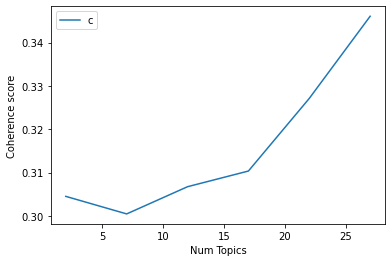

In [77]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [78]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.3045
index: 1 | Num Topics = 7  has Coherence Value of 0.3004
index: 2 | Num Topics = 12  has Coherence Value of 0.3067
index: 3 | Num Topics = 17  has Coherence Value of 0.3103
index: 4 | Num Topics = 22  has Coherence Value of 0.3271
index: 5 | Num Topics = 27  has Coherence Value of 0.3461


In [173]:
# Select optimal number of topics
optimal_model_ph_score3 = model_list_ph_score3[5]

In [174]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score3, corpus_ph_score3, id2word_ph_score3)

In [175]:
print("pyLDAVis for ph topics for score=3:")
vis_ph_score3

pyLDAVis for ph topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
25    -0.059121 -0.006996       1        1  10.660413
21    -0.101955  0.029739       2        1   8.933608
5     -0.086558 -0.055478       3        1   6.714925
2     -0.055770  0.000155       4        1   6.111961
14    -0.102456  0.024272       5        1   5.681306
16    -0.089304  0.017796       6        1   5.204842
26    -0.037635  0.005131       7        1   5.166182
20    -0.073545 -0.000676       8        1   5.105839
8      0.077715  0.151614       9        1   4.332524
13    -0.045164  0.074599      10        1   3.832577
1     -0.071119 -0.082616      11        1   3.738667
18    -0.051686 -0.058801      12        1   3.505458
15    -0.045507  0.006437      13        1   3.436286
22    -0.074609 -0.121321      14        1   3.211228
9     -0.037254  0.007059      15        1   3.133410
24     0.031165  0.158006      16        1   3.001006
12     0.019907  0.095133      17        1   2.805606
17    -0.018396  0.008945      18        1   2.470393
10     0.062740  0.051652      19        1   2.369243
19     0.072967 -0.021731      20        1   2.212893
23     0.076126 -0.107857      21        1   1.839957
0      0.048380  0.007093      22        1   1.590467
6      0.038791  0.015241      23        1   1.573156
11     0.156284  0.009272      24        1   1.305145
4      0.026759 -0.059493      25        1   0.893624
7      0.149751 -0.081011      26        1   0.605124
3      0.189492 -0.066163      27        1   0.564160, topic_info=        Term       Freq      Total Category  logprob  loglift
45   account  98.000000  98.000000  Default  30.0000  30.0000
11      post  82.000000  82.000000  Default  29.0000  29.0000
118    photo  36.000000  36.000000  Default  28.0000  28.0000
38     phone  54.000000  54.000000  Default  27.0000  27.0000
60     story  89.000000  89.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
75   problem   0.018389  58.265936  Topic27  -7.3099  -2.8834
153   always   0.018389  26.887095  Topic27  -7.3099  -2.1101
125  usually   0.018389   2.578337  Topic27  -7.3099   0.2344
737   repeat   0.018389   3.238157  Topic27  -7.3099   0.0066
476    solve   0.018389   4.256038  Topic27  -7.3099  -0.2667

[1513 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
839       7  0.604844    ability
381       3  0.099228       able
381       5  0.099228       able
381       6  0.099228       able
381       8  0.099228       able
...     ...       ...        ...
266      23  0.086022       year
833      24  0.678796  yesterday
352       1  0.464884       zoom
352       5  0.232442       zoom
352      18  0.232442       zoom

[2466 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[26, 22, 6, 3, 15, 17, 27, 21, 9, 14, 2, 19, 16, 23, 10, 25, 13, 18, 11, 20, 24, 1, 7, 12, 5, 8, 4])

## LDA Topic Modelling (Rating = 4)

In [82]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_ph_score4 = instagram_ios_ph_review_YearMonth_score4.review.values.tolist()
review_words_ph_score4 = list(sent_to_words(review_ph_score4))
print(review_words_ph_score4[2:3])

[['my', 'instastory', 'doesn', 'give', 'me', 'super', 'zoom', 'and', 'font', 'is', 'just', 'the', 'regular', 'one', 'hope', 'instagram', 'fix', 'this', 'issue', 'sooner', 'tried', 'reporting', 'several', 'times', 'but', 'think', 'their', 'team', 'doesn', 'give', 'crap', 'about', 'it']]


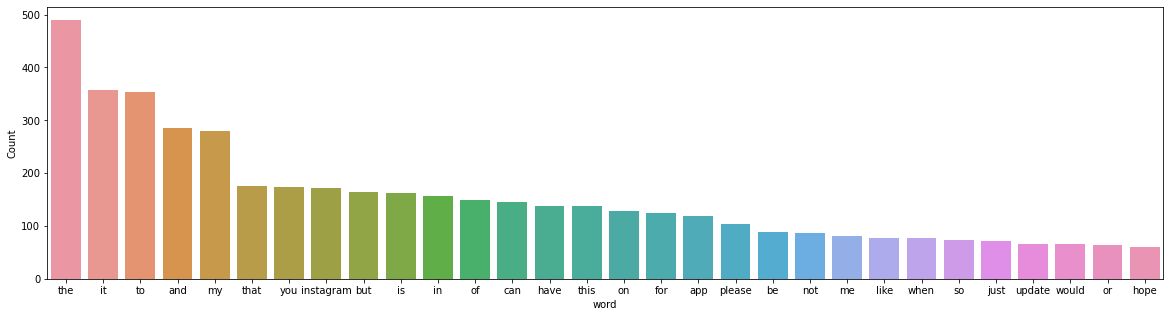

In [83]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score4))

In [84]:
# Clean text
review_ph_ready_score4 = process_words(review_words_ph_score4)  # processed Text Data! - move to each section

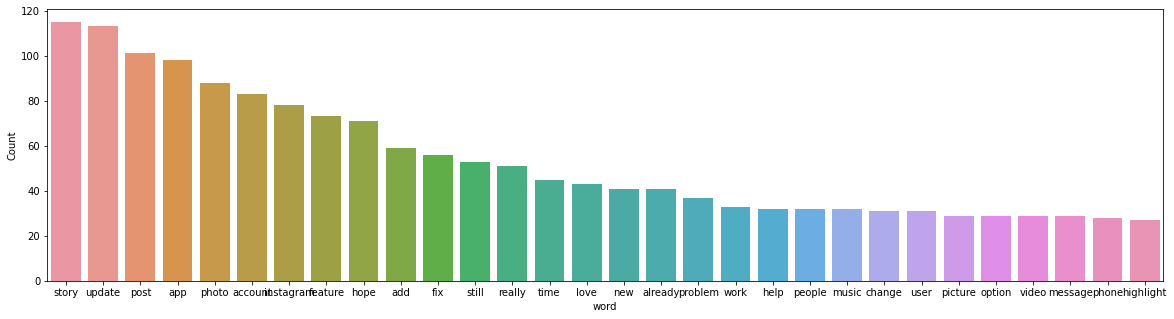

In [85]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score4))


In [86]:
# Create Dictionary
id2word_ph_score4 = corpora.Dictionary(review_ph_ready_score4)

2021-10-16 02:07:19,880 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:07:19,896 [INFO] gensim.corpora.dictionary - built Dictionary(995 unique tokens: ['become', 'crash', 'fix', 'hope', 'iphone']...) from 233 documents (total 4658 corpus positions)
2021-10-16 02:07:19,898 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(995 unique tokens: ['become', 'crash', 'fix', 'hope', 'iphone']...) from 233 documents (total 4658 corpus positions)", 'datetime': '2021-10-16T02:07:19.898084', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [87]:
# Create Corpus: Term Document Frequency
corpus_ph_score4 = [id2word_ph_score4.doc2bow(text) for text in review_ph_ready_score4]

In [88]:
# Training LDA model
model_list_ph_score4, coherence_values_ph_score4 = compute_coherence_values(dictionary=id2word_ph_score4, corpus=corpus_ph_score4, 
                                                              texts=review_ph_ready_score4, limit=30, start=2, step=5)


2021-10-16 02:07:19,921 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:07:19,923 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:07:19,925 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:07:19,927 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 233 documents, updating model once every 233 documents, evaluating perplexity every 233 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:07:20,759 [INFO] gensim.models.ldamodel - -7.473 per-word bound, 177.6 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:07:20,763 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #233/233
2021-10-16 02:07:21,536 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"story" + 0.019*"update" + 0.018*"post" + 0.018*"photo" + 0.016*"app" + 0.014*"fix" + 0.014*"add" 

2021-10-16 02:07:30,883 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"account" + 0.023*"update" + 0.020*"story" + 0.019*"app" + 0.017*"feature" + 0.016*"instagram" + 0.014*"new" + 0.014*"hope" + 0.011*"music" + 0.011*"post"
2021-10-16 02:07:30,889 [INFO] gensim.models.ldamodel - topic diff=0.018784, rho=0.301511
2021-10-16 02:07:31,406 [INFO] gensim.models.ldamodel - -6.272 per-word bound, 77.3 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:07:31,407 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #233/233
2021-10-16 02:07:31,854 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"photo" + 0.026*"post" + 0.022*"story" + 0.017*"update" + 0.016*"app" + 0.013*"add" + 0.012*"instagram" + 0.012*"hope" + 0.012*"fix" + 0.011*"time"
2021-10-16 02:07:31,857 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"account" + 0.023*"update" + 0.020*"story" + 0.019*"app" + 0.018*"feature" + 0.016*"instagram" + 0.014*"new

2021-10-16 02:07:39,415 [INFO] gensim.models.ldamodel - topic diff=0.008623, rho=0.218218
2021-10-16 02:07:39,928 [INFO] gensim.models.ldamodel - -6.261 per-word bound, 76.7 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:07:39,930 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #233/233
2021-10-16 02:07:40,294 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"photo" + 0.029*"post" + 0.021*"story" + 0.017*"update" + 0.016*"app" + 0.013*"add" + 0.012*"hope" + 0.012*"instagram" + 0.011*"time" + 0.011*"fix"
2021-10-16 02:07:40,296 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"account" + 0.024*"update" + 0.020*"story" + 0.019*"app" + 0.018*"feature" + 0.016*"instagram" + 0.015*"new" + 0.013*"hope" + 0.012*"music" + 0.010*"problem"
2021-10-16 02:07:40,297 [INFO] gensim.models.ldamodel - topic diff=0.008194, rho=0.213201
2021-10-16 02:07:40,779 [INFO] gensim.models.ldamodel - -6.260 per-word bound, 76.6 perplexity

2021-10-16 02:07:48,106 [INFO] gensim.models.ldamodel - -6.256 per-word bound, 76.4 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:07:48,108 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #233/233
2021-10-16 02:07:48,428 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"post" + 0.030*"photo" + 0.021*"story" + 0.016*"update" + 0.016*"app" + 0.013*"add" + 0.013*"hope" + 0.012*"really" + 0.012*"instagram" + 0.011*"time"
2021-10-16 02:07:48,433 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"account" + 0.025*"update" + 0.020*"story" + 0.019*"app" + 0.018*"feature" + 0.016*"instagram" + 0.015*"new" + 0.013*"hope" + 0.012*"music" + 0.010*"problem"
2021-10-16 02:07:48,443 [INFO] gensim.models.ldamodel - topic diff=0.004676, rho=0.176777
2021-10-16 02:07:48,897 [INFO] gensim.models.ldamodel - -6.255 per-word bound, 76.4 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:07:

2021-10-16 02:07:56,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #233/233
2021-10-16 02:07:56,490 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"post" + 0.030*"photo" + 0.022*"story" + 0.015*"update" + 0.015*"app" + 0.013*"add" + 0.013*"hope" + 0.013*"really" + 0.012*"instagram" + 0.011*"time"
2021-10-16 02:07:56,497 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"account" + 0.025*"update" + 0.020*"app" + 0.019*"story" + 0.018*"feature" + 0.016*"instagram" + 0.015*"new" + 0.012*"hope" + 0.012*"music" + 0.011*"problem"
2021-10-16 02:07:56,508 [INFO] gensim.models.ldamodel - topic diff=0.003281, rho=0.154303
2021-10-16 02:07:56,988 [INFO] gensim.models.ldamodel - -6.253 per-word bound, 76.3 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:07:56,996 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #233/233
2021-10-16 02:07:57,291 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"post

2021-10-16 02:08:03,543 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:08:08,074 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:08:08,103 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 230 virtual documents
2021-10-16 02:08:08,399 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:08:08,400 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:08:08,403 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:08:08,406 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 233 documents, updating model once every 233 documents, evaluating perplexity every 233 documents, iterating 50x with a con

2021-10-16 02:08:13,325 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"story" + 0.028*"fix" + 0.028*"app" + 0.026*"message" + 0.017*"music" + 0.015*"hope" + 0.015*"love" + 0.015*"account" + 0.014*"instagram" + 0.014*"friend"
2021-10-16 02:08:13,327 [INFO] gensim.models.ldamodel - topic diff=0.085017, rho=0.408248
2021-10-16 02:08:13,792 [INFO] gensim.models.ldamodel - -6.526 per-word bound, 92.2 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:08:13,800 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #233/233
2021-10-16 02:08:14,152 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"new" + 0.026*"account" + 0.025*"update" + 0.022*"highlight" + 0.020*"story" + 0.016*"add" + 0.014*"still" + 0.012*"hope" + 0.011*"love" + 0.011*"follow"
2021-10-16 02:08:14,154 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"update" + 0.030*"story" + 0.027*"app" + 0.023*"post" + 0.018*"still" + 0.018*"feature" + 0.015*"hope"

2021-10-16 02:08:17,297 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.041*"update" + 0.031*"story" + 0.027*"app" + 0.022*"post" + 0.020*"still" + 0.017*"feature" + 0.015*"hope" + 0.014*"iphone" + 0.013*"help" + 0.013*"problem"
2021-10-16 02:08:17,303 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"fix" + 0.029*"story" + 0.028*"app" + 0.027*"message" + 0.021*"music" + 0.016*"feature" + 0.015*"hope" + 0.014*"instagram" + 0.014*"love" + 0.014*"user"
2021-10-16 02:08:17,306 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"photo" + 0.021*"post" + 0.020*"quality" + 0.020*"effect" + 0.014*"video" + 0.014*"app" + 0.013*"time" + 0.012*"upload" + 0.012*"work" + 0.011*"save"
2021-10-16 02:08:17,312 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"new" + 0.026*"account" + 0.026*"update" + 0.023*"highlight" + 0.020*"story" + 0.016*"add" + 0.014*"still" + 0.012*"hope" + 0.011*"old" + 0.011*"thing"
2021-10-16 02:08:17,315 [INFO] gensim.models.ldamodel - topic diff=0.018

2021-10-16 02:08:20,419 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"fix" + 0.028*"story" + 0.028*"app" + 0.026*"message" + 0.025*"music" + 0.018*"feature" + 0.017*"available" + 0.016*"region" + 0.015*"hope" + 0.015*"instagram"
2021-10-16 02:08:20,420 [INFO] gensim.models.ldamodel - topic diff=0.008688, rho=0.242536
2021-10-16 02:08:20,799 [INFO] gensim.models.ldamodel - -6.493 per-word bound, 90.1 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:08:20,811 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #233/233
2021-10-16 02:08:21,026 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"post" + 0.020*"hope" + 0.019*"picture" + 0.017*"account" + 0.016*"delete" + 0.015*"mode" + 0.015*"dark" + 0.015*"feature" + 0.014*"update" + 0.013*"add"
2021-10-16 02:08:21,027 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"instagram" + 0.026*"account" + 0.024*"post" + 0.023*"story" + 0.023*"update" + 0.019*"photo" + 

2021-10-16 02:08:24,052 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"new" + 0.026*"account" + 0.026*"update" + 0.023*"highlight" + 0.020*"story" + 0.016*"add" + 0.014*"still" + 0.012*"hope" + 0.012*"thing" + 0.011*"old"
2021-10-16 02:08:24,056 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"fix" + 0.028*"story" + 0.027*"app" + 0.027*"music" + 0.026*"message" + 0.020*"feature" + 0.019*"available" + 0.017*"region" + 0.015*"instagram" + 0.015*"hope"
2021-10-16 02:08:24,057 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"update" + 0.031*"story" + 0.027*"app" + 0.021*"post" + 0.021*"still" + 0.017*"feature" + 0.016*"hope" + 0.014*"problem" + 0.013*"iphone" + 0.013*"help"
2021-10-16 02:08:24,059 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"post" + 0.020*"hope" + 0.020*"picture" + 0.018*"account" + 0.016*"delete" + 0.015*"mode" + 0.015*"dark" + 0.015*"feature" + 0.014*"update" + 0.013*"add"
2021-10-16 02:08:24,059 [INFO] gensim.models.ldamodel - topic

2021-10-16 02:08:27,041 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"photo" + 0.022*"post" + 0.021*"quality" + 0.021*"effect" + 0.015*"video" + 0.014*"time" + 0.013*"upload" + 0.012*"save" + 0.011*"work" + 0.011*"story"
2021-10-16 02:08:27,045 [INFO] gensim.models.ldamodel - topic diff=0.003170, rho=0.188982
2021-10-16 02:08:27,457 [INFO] gensim.models.ldamodel - -6.485 per-word bound, 89.6 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:08:27,459 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #233/233
2021-10-16 02:08:27,782 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"instagram" + 0.027*"account" + 0.023*"post" + 0.023*"story" + 0.022*"update" + 0.020*"photo" + 0.018*"really" + 0.016*"add" + 0.012*"love" + 0.012*"app"
2021-10-16 02:08:27,785 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"photo" + 0.020*"upload" + 0.019*"post" + 0.014*"hope" + 0.014*"app" + 0.013*"ipad" + 0.013*"time" + 0.0

2021-10-16 02:08:31,808 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"instagram" + 0.027*"account" + 0.023*"post" + 0.023*"story" + 0.022*"update" + 0.020*"photo" + 0.018*"really" + 0.016*"add" + 0.012*"love" + 0.012*"app"
2021-10-16 02:08:31,810 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.028*"photo" + 0.023*"post" + 0.021*"quality" + 0.021*"effect" + 0.015*"video" + 0.014*"time" + 0.013*"upload" + 0.012*"save" + 0.011*"work" + 0.011*"add"
2021-10-16 02:08:31,813 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"post" + 0.021*"picture" + 0.021*"hope" + 0.018*"account" + 0.017*"delete" + 0.016*"mode" + 0.016*"dark" + 0.014*"update" + 0.014*"feature" + 0.013*"add"
2021-10-16 02:08:31,814 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"fix" + 0.029*"music" + 0.028*"story" + 0.027*"app" + 0.026*"message" + 0.021*"feature" + 0.021*"available" + 0.017*"region" + 0.016*"instagram" + 0.014*"hope"
2021-10-16 02:08:31,816 [INFO] gensim.models.ldamodel - topic 

2021-10-16 02:08:34,916 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"update" + 0.031*"story" + 0.027*"app" + 0.021*"post" + 0.021*"still" + 0.016*"feature" + 0.016*"hope" + 0.014*"problem" + 0.014*"help" + 0.013*"iphone"
2021-10-16 02:08:34,918 [INFO] gensim.models.ldamodel - topic diff=0.001643, rho=0.160128
2021-10-16 02:08:35,287 [INFO] gensim.models.ldamodel - -6.483 per-word bound, 89.4 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:08:35,288 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #233/233
2021-10-16 02:08:35,472 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"fix" + 0.029*"music" + 0.028*"story" + 0.027*"app" + 0.026*"message" + 0.022*"feature" + 0.021*"available" + 0.017*"region" + 0.016*"instagram" + 0.014*"hope"
2021-10-16 02:08:35,475 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"update" + 0.031*"story" + 0.027*"app" + 0.021*"post" + 0.021*"still" + 0.016*"feature" + 0.016*"

2021-10-16 02:08:38,415 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"photo" + 0.020*"upload" + 0.019*"post" + 0.014*"app" + 0.014*"hope" + 0.013*"ipad" + 0.013*"time" + 0.012*"love" + 0.011*"delete" + 0.010*"much"
2021-10-16 02:08:38,417 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"fix" + 0.029*"music" + 0.028*"story" + 0.027*"app" + 0.026*"message" + 0.022*"feature" + 0.021*"available" + 0.017*"region" + 0.016*"instagram" + 0.014*"hope"
2021-10-16 02:08:38,419 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"photo" + 0.023*"post" + 0.022*"quality" + 0.022*"effect" + 0.015*"video" + 0.014*"time" + 0.013*"upload" + 0.012*"save" + 0.011*"add" + 0.011*"low"
2021-10-16 02:08:38,422 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.042*"update" + 0.031*"story" + 0.027*"app" + 0.021*"post" + 0.020*"still" + 0.016*"feature" + 0.016*"hope" + 0.014*"problem" + 0.014*"help" + 0.013*"iphone"
2021-10-16 02:08:38,424 [INFO] gensim.models.ldamodel - topic diff=0.001

2021-10-16 02:08:41,558 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"post" + 0.021*"picture" + 0.020*"hope" + 0.018*"account" + 0.017*"delete" + 0.016*"mode" + 0.016*"dark" + 0.014*"update" + 0.013*"feature" + 0.013*"add"
2021-10-16 02:08:41,559 [INFO] gensim.models.ldamodel - topic diff=0.000865, rho=0.141421
2021-10-16 02:08:41,912 [INFO] gensim.models.ldamodel - -6.482 per-word bound, 89.4 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:08:41,913 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #233/233
2021-10-16 02:08:42,160 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"new" + 0.027*"account" + 0.026*"update" + 0.023*"highlight" + 0.021*"story" + 0.016*"add" + 0.014*"still" + 0.012*"hope" + 0.012*"thing" + 0.012*"old"
2021-10-16 02:08:42,162 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"photo" + 0.023*"post" + 0.022*"quality" + 0.022*"effect" + 0.015*"video" + 0.014*"time" + 0.013*"upload

2021-10-16 02:08:51,125 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.022*"effect" + 0.020*"app" + 0.019*"video" + 0.018*"scroll" + 0.017*"save" + 0.015*"story" + 0.015*"fix" + 0.014*"add" + 0.014*"search" + 0.012*"update"
2021-10-16 02:08:51,127 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"new" + 0.031*"highlight" + 0.023*"update" + 0.022*"add" + 0.021*"story" + 0.018*"hope" + 0.017*"fix" + 0.016*"love" + 0.015*"account" + 0.013*"photo"
2021-10-16 02:08:51,129 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.041*"post" + 0.038*"story" + 0.029*"app" + 0.025*"add" + 0.024*"instagram" + 0.019*"update" + 0.018*"problem" + 0.014*"fix" + 0.014*"highlight" + 0.014*"feature"
2021-10-16 02:08:51,131 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.030*"post" + 0.026*"story" + 0.019*"photo" + 0.018*"already" + 0.017*"order" + 0.017*"people" + 0.017*"follow" + 0.017*"option" + 0.017*"feature" + 0.012*"update"
2021-10-16 02:08:51,133 [INFO] gensim.models.ldamodel - topic 

2021-10-16 02:08:54,043 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"feature" + 0.020*"post" + 0.018*"dark" + 0.018*"mode" + 0.016*"update" + 0.016*"account" + 0.016*"picture" + 0.016*"delete" + 0.015*"app" + 0.014*"iphone"
2021-10-16 02:08:54,043 [INFO] gensim.models.ldamodel - topic diff=0.032660, rho=0.316228
2021-10-16 02:08:54,312 [INFO] gensim.models.ldamodel - -6.637 per-word bound, 99.5 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:08:54,314 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #233/233
2021-10-16 02:08:54,551 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"app" + 0.024*"post" + 0.023*"time" + 0.021*"really" + 0.021*"update" + 0.018*"story" + 0.016*"feature" + 0.016*"hope" + 0.016*"phone" + 0.014*"great"
2021-10-16 02:08:54,554 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.035*"new" + 0.030*"highlight" + 0.025*"update" + 0.021*"add" + 0.021*"story" + 0.018*"hope" + 0.018*"fix" + 

2021-10-16 02:08:57,549 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.032*"post" + 0.027*"story" + 0.022*"photo" + 0.020*"order" + 0.019*"option" + 0.018*"already" + 0.018*"people" + 0.018*"follow" + 0.016*"feature" + 0.013*"view"
2021-10-16 02:08:57,551 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"update" + 0.024*"story" + 0.024*"change" + 0.021*"still" + 0.021*"app" + 0.018*"post" + 0.017*"account" + 0.016*"hope" + 0.016*"instagram" + 0.014*"new"
2021-10-16 02:08:57,553 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.036*"crash" + 0.031*"iphone" + 0.026*"version" + 0.026*"help" + 0.024*"fix" + 0.022*"post" + 0.022*"problem" + 0.022*"late" + 0.021*"keep" + 0.018*"time"
2021-10-16 02:08:57,555 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"new" + 0.029*"highlight" + 0.026*"update" + 0.021*"add" + 0.021*"story" + 0.018*"hope" + 0.018*"account" + 0.018*"fix" + 0.016*"love" + 0.013*"photo"
2021-10-16 02:08:57,557 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 02:09:00,549 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"new" + 0.029*"highlight" + 0.027*"update" + 0.021*"add" + 0.021*"story" + 0.018*"account" + 0.018*"hope" + 0.017*"fix" + 0.016*"love" + 0.013*"photo"
2021-10-16 02:09:00,551 [INFO] gensim.models.ldamodel - topic diff=0.004419, rho=0.218218
2021-10-16 02:09:00,905 [INFO] gensim.models.ldamodel - -6.622 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:00,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #233/233
2021-10-16 02:09:01,090 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"message" + 0.034*"account" + 0.025*"story" + 0.020*"user" + 0.019*"fix" + 0.016*"love" + 0.014*"show" + 0.014*"problem" + 0.012*"friend" + 0.012*"phone"
2021-10-16 02:09:01,092 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"update" + 0.024*"story" + 0.023*"change" + 0.021*"still" + 0.021*"app" + 0.018*"post" + 0.017*"account"

2021-10-16 02:09:03,972 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.029*"effect" + 0.021*"save" + 0.019*"video" + 0.019*"scroll" + 0.019*"app" + 0.016*"story" + 0.016*"search" + 0.016*"add" + 0.014*"fix" + 0.013*"update"
2021-10-16 02:09:03,976 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.022*"feature" + 0.020*"post" + 0.018*"dark" + 0.018*"mode" + 0.016*"update" + 0.016*"account" + 0.016*"picture" + 0.016*"delete" + 0.015*"app" + 0.014*"iphone"
2021-10-16 02:09:03,980 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"message" + 0.034*"account" + 0.025*"story" + 0.020*"user" + 0.019*"fix" + 0.016*"love" + 0.014*"show" + 0.014*"problem" + 0.012*"friend" + 0.012*"phone"
2021-10-16 02:09:03,985 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"app" + 0.024*"post" + 0.023*"time" + 0.021*"really" + 0.021*"update" + 0.018*"story" + 0.016*"phone" + 0.016*"hope" + 0.015*"feature" + 0.014*"great"
2021-10-16 02:09:03,986 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 02:09:06,811 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.032*"post" + 0.027*"story" + 0.022*"photo" + 0.020*"order" + 0.019*"option" + 0.018*"already" + 0.018*"follow" + 0.018*"people" + 0.016*"feature" + 0.013*"view"
2021-10-16 02:09:06,812 [INFO] gensim.models.ldamodel - topic diff=0.001729, rho=0.176777
2021-10-16 02:09:07,135 [INFO] gensim.models.ldamodel - -6.617 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:07,140 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #233/233
2021-10-16 02:09:07,384 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"app" + 0.024*"post" + 0.023*"time" + 0.021*"really" + 0.021*"update" + 0.018*"story" + 0.016*"phone" + 0.016*"hope" + 0.015*"feature" + 0.014*"great"
2021-10-16 02:09:07,432 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"effect" + 0.022*"save" + 0.018*"video" + 0.018*"scroll" + 0.018*"app" + 0.017*"story" + 0.017*"search

2021-10-16 02:09:10,413 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.070*"photo" + 0.026*"upload" + 0.022*"app" + 0.016*"video" + 0.015*"hope" + 0.014*"great" + 0.013*"post" + 0.013*"delete" + 0.012*"thing" + 0.012*"really"
2021-10-16 02:09:10,416 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.032*"post" + 0.027*"story" + 0.023*"photo" + 0.020*"order" + 0.019*"option" + 0.018*"already" + 0.018*"follow" + 0.018*"people" + 0.016*"feature" + 0.013*"view"
2021-10-16 02:09:10,418 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.035*"crash" + 0.030*"version" + 0.029*"iphone" + 0.026*"fix" + 0.026*"problem" + 0.025*"help" + 0.024*"late" + 0.022*"post" + 0.021*"keep" + 0.018*"time"
2021-10-16 02:09:10,420 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"app" + 0.024*"post" + 0.024*"time" + 0.021*"update" + 0.021*"really" + 0.018*"story" + 0.016*"phone" + 0.016*"hope" + 0.015*"feature" + 0.014*"great"
2021-10-16 02:09:10,421 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 02:09:13,382 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.032*"post" + 0.027*"story" + 0.023*"photo" + 0.020*"order" + 0.019*"option" + 0.018*"already" + 0.018*"follow" + 0.018*"people" + 0.016*"feature" + 0.013*"view"
2021-10-16 02:09:13,385 [INFO] gensim.models.ldamodel - topic diff=0.001173, rho=0.152499
2021-10-16 02:09:13,656 [INFO] gensim.models.ldamodel - -6.615 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:13,663 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #233/233
2021-10-16 02:09:13,843 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.032*"post" + 0.027*"story" + 0.023*"photo" + 0.020*"order" + 0.019*"option" + 0.018*"already" + 0.018*"follow" + 0.018*"people" + 0.016*"feature" + 0.013*"view"
2021-10-16 02:09:13,847 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.040*"post" + 0.035*"story" + 0.031*"app" + 0.027*"add" + 0.020*"instagram" + 0.017*"feature" + 0.01

2021-10-16 02:09:16,798 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"effect" + 0.022*"save" + 0.019*"video" + 0.019*"scroll" + 0.018*"story" + 0.017*"search" + 0.017*"app" + 0.016*"add" + 0.014*"fix" + 0.013*"update"
2021-10-16 02:09:16,800 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"instagram" + 0.035*"update" + 0.034*"story" + 0.026*"account" + 0.022*"music" + 0.020*"feature" + 0.019*"love" + 0.018*"hope" + 0.018*"really" + 0.016*"fix"
2021-10-16 02:09:16,801 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"message" + 0.034*"account" + 0.025*"story" + 0.020*"user" + 0.019*"fix" + 0.016*"love" + 0.014*"show" + 0.014*"problem" + 0.012*"friend" + 0.012*"phone"
2021-10-16 02:09:16,802 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.022*"feature" + 0.021*"post" + 0.018*"dark" + 0.018*"mode" + 0.016*"update" + 0.016*"delete" + 0.016*"picture" + 0.016*"account" + 0.015*"app" + 0.014*"iphone"
2021-10-16 02:09:16,803 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:09:27,102 [INFO] gensim.models.ldamodel - topic diff=0.222277, rho=0.577350
2021-10-16 02:09:27,442 [INFO] gensim.models.ldamodel - -6.871 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:27,443 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #233/233
2021-10-16 02:09:27,673 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.047*"story" + 0.038*"message" + 0.018*"user" + 0.018*"love" + 0.017*"fix" + 0.016*"friend" + 0.016*"account" + 0.015*"people" + 0.015*"bug" + 0.014*"app"
2021-10-16 02:09:27,674 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.034*"update" + 0.029*"post" + 0.026*"app" + 0.026*"feature" + 0.022*"work" + 0.020*"story" + 0.017*"instagram" + 0.017*"still" + 0.015*"time" + 0.015*"fix"
2021-10-16 02:09:27,675 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.041*"account" + 0.023*"update" + 0.021*"dark" + 0.021*"mode" + 0.021*"app" + 0.019*"feature" + 0.016*"new" + 0.

2021-10-16 02:09:30,220 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.031*"account" + 0.029*"instagram" + 0.028*"story" + 0.025*"really" + 0.021*"add" + 0.019*"filter" + 0.017*"update" + 0.015*"photo" + 0.013*"post" + 0.012*"app"
2021-10-16 02:09:30,223 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.040*"account" + 0.027*"update" + 0.024*"dark" + 0.024*"mode" + 0.023*"app" + 0.016*"feature" + 0.016*"new" + 0.016*"instagram" + 0.015*"software" + 0.014*"iphone"
2021-10-16 02:09:30,225 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.045*"story" + 0.044*"message" + 0.020*"user" + 0.018*"love" + 0.017*"friend" + 0.017*"account" + 0.016*"bug" + 0.015*"people" + 0.015*"fix" + 0.012*"app"
2021-10-16 02:09:30,227 [INFO] gensim.models.ldamodel - topic diff=0.048748, rho=0.333333
2021-10-16 02:09:30,569 [INFO] gensim.models.ldamodel - -6.721 per-word bound, 105.5 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:30,572 [INFO] gensim.m

2021-10-16 02:09:32,884 [INFO] gensim.models.ldamodel - topic diff=0.014101, rho=0.267261
2021-10-16 02:09:33,184 [INFO] gensim.models.ldamodel - -6.710 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:33,185 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #233/233
2021-10-16 02:09:33,423 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"video" + 0.026*"quality" + 0.026*"fix" + 0.021*"story" + 0.020*"app" + 0.017*"show" + 0.017*"wrong" + 0.017*"suddenly" + 0.012*"photo" + 0.012*"post"
2021-10-16 02:09:33,424 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.050*"story" + 0.042*"post" + 0.031*"add" + 0.028*"app" + 0.024*"instagram" + 0.022*"music" + 0.021*"highlight" + 0.017*"update" + 0.015*"available" + 0.014*"great"
2021-10-16 02:09:33,426 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.031*"play" + 0.029*"really" + 0.025*"app" + 0.019*"update" + 0.019*"hope" + 0.015*"memory" + 0.015*"

2021-10-16 02:09:36,303 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.035*"highlight" + 0.032*"love" + 0.026*"photo" + 0.026*"story" + 0.022*"new" + 0.019*"add" + 0.016*"put" + 0.016*"upload" + 0.016*"instagram" + 0.016*"hope"
2021-10-16 02:09:36,307 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"video" + 0.027*"quality" + 0.026*"fix" + 0.021*"story" + 0.020*"app" + 0.017*"show" + 0.017*"wrong" + 0.017*"suddenly" + 0.012*"photo" + 0.012*"post"
2021-10-16 02:09:36,309 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.045*"story" + 0.045*"message" + 0.021*"user" + 0.018*"love" + 0.018*"friend" + 0.018*"account" + 0.016*"people" + 0.015*"bug" + 0.013*"fix" + 0.012*"app"
2021-10-16 02:09:36,311 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.043*"update" + 0.025*"feature" + 0.024*"account" + 0.021*"still" + 0.020*"time" + 0.018*"story" + 0.017*"iphone" + 0.016*"hope" + 0.014*"app" + 0.013*"help"
2021-10-16 02:09:36,312 [INFO] gensim.models.ldamodel - topic diff=0.005

2021-10-16 02:09:39,460 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.050*"story" + 0.042*"post" + 0.031*"add" + 0.028*"app" + 0.024*"instagram" + 0.022*"music" + 0.021*"highlight" + 0.017*"update" + 0.015*"available" + 0.014*"great"
2021-10-16 02:09:39,461 [INFO] gensim.models.ldamodel - topic diff=0.003194, rho=0.200000
2021-10-16 02:09:39,762 [INFO] gensim.models.ldamodel - -6.698 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:39,764 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #233/233
2021-10-16 02:09:39,952 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.032*"account" + 0.029*"instagram" + 0.027*"story" + 0.025*"really" + 0.022*"add" + 0.021*"filter" + 0.017*"update" + 0.016*"photo" + 0.013*"post" + 0.012*"great"
2021-10-16 02:09:39,954 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.054*"update" + 0.043*"account" + 0.021*"new" + 0.020*"change" + 0.018*"story" + 0.016*"post" 

2021-10-16 02:09:42,723 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.050*"story" + 0.042*"post" + 0.031*"add" + 0.028*"app" + 0.024*"instagram" + 0.022*"music" + 0.021*"highlight" + 0.017*"update" + 0.015*"available" + 0.014*"great"
2021-10-16 02:09:42,725 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.043*"photo" + 0.043*"post" + 0.028*"already" + 0.020*"edit" + 0.017*"people" + 0.015*"upload" + 0.015*"change" + 0.013*"story" + 0.013*"really" + 0.012*"hope"
2021-10-16 02:09:42,727 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"video" + 0.028*"quality" + 0.026*"fix" + 0.021*"story" + 0.020*"app" + 0.017*"show" + 0.017*"wrong" + 0.016*"suddenly" + 0.013*"photo" + 0.012*"post"
2021-10-16 02:09:42,729 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.032*"account" + 0.028*"instagram" + 0.026*"story" + 0.025*"really" + 0.022*"add" + 0.021*"filter" + 0.017*"update" + 0.017*"photo" + 0.013*"post" + 0.012*"great"
2021-10-16 02:09:42,732 [INFO] gensim.models.ldamodel 

2021-10-16 02:09:45,948 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.062*"photo" + 0.031*"video" + 0.020*"app" + 0.019*"find" + 0.016*"ipad" + 0.016*"help" + 0.015*"hope" + 0.013*"post" + 0.013*"people" + 0.012*"user"
2021-10-16 02:09:45,950 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.046*"story" + 0.046*"message" + 0.021*"user" + 0.018*"love" + 0.018*"friend" + 0.018*"account" + 0.016*"people" + 0.014*"bug" + 0.013*"fix" + 0.012*"app"
2021-10-16 02:09:45,952 [INFO] gensim.models.ldamodel - topic diff=0.001705, rho=0.166667
2021-10-16 02:09:46,364 [INFO] gensim.models.ldamodel - -6.692 per-word bound, 103.4 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:46,367 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #233/233
2021-10-16 02:09:46,631 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.032*"account" + 0.028*"instagram" + 0.026*"story" + 0.026*"really" + 0.022*"add" + 0.021*"filter" + 0.017*"update" + 0

2021-10-16 02:09:49,825 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #233/233
2021-10-16 02:09:50,073 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.041*"post" + 0.026*"app" + 0.025*"photo" + 0.023*"picture" + 0.022*"delete" + 0.017*"fix" + 0.016*"phone" + 0.016*"download" + 0.015*"hope" + 0.013*"story"
2021-10-16 02:09:50,076 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.041*"account" + 0.029*"update" + 0.025*"dark" + 0.025*"mode" + 0.024*"app" + 0.016*"new" + 0.016*"instagram" + 0.016*"software" + 0.016*"feature" + 0.014*"iphone"
2021-10-16 02:09:50,077 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.032*"play" + 0.030*"really" + 0.026*"app" + 0.020*"update" + 0.019*"hope" + 0.016*"memory" + 0.016*"much" + 0.016*"archive" + 0.016*"happy" + 0.016*"coz"
2021-10-16 02:09:50,081 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"quality" + 0.028*"video" + 0.026*"fix" + 0.021*"story" + 0.020*"app" + 0.017*"show" + 0.017*"wrong" + 0.016*"suddenly" +

2021-10-16 02:09:52,961 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"quality" + 0.028*"video" + 0.026*"fix" + 0.021*"story" + 0.020*"app" + 0.017*"show" + 0.017*"wrong" + 0.016*"suddenly" + 0.013*"photo" + 0.012*"post"
2021-10-16 02:09:52,963 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.043*"photo" + 0.043*"post" + 0.028*"already" + 0.020*"edit" + 0.017*"people" + 0.015*"upload" + 0.015*"change" + 0.013*"story" + 0.013*"really" + 0.012*"hope"
2021-10-16 02:09:52,965 [INFO] gensim.models.ldamodel - topic diff=0.000919, rho=0.145865
2021-10-16 02:09:53,365 [INFO] gensim.models.ldamodel - -6.689 per-word bound, 103.2 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:09:53,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #233/233
2021-10-16 02:09:53,658 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.041*"account" + 0.029*"update" + 0.025*"dark" + 0.025*"mode" + 0.024*"app" + 0.016*"new" + 0.016*"instagr

2021-10-16 02:10:04,077 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #233/233
2021-10-16 02:10:04,743 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.041*"app" + 0.028*"mode" + 0.020*"dark" + 0.020*"option" + 0.016*"feature" + 0.015*"update" + 0.014*"problem" + 0.014*"thing" + 0.014*"user" + 0.012*"video"
2021-10-16 02:10:04,746 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.025*"post" + 0.020*"instagram" + 0.017*"app" + 0.016*"work" + 0.016*"story" + 0.015*"user" + 0.015*"ipad" + 0.015*"give" + 0.013*"tea" + 0.013*"look"
2021-10-16 02:10:04,749 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.040*"story" + 0.033*"update" + 0.027*"feature" + 0.025*"post" + 0.020*"work" + 0.020*"app" + 0.018*"really" + 0.016*"people" + 0.015*"add" + 0.015*"already"
2021-10-16 02:10:04,751 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.040*"instagram" + 0.025*"fix" + 0.020*"hope" + 0.019*"feature" + 0.018*"give" + 0.016*"account" + 0.015*"love" + 0.013*"update" + 0.01

2021-10-16 02:10:08,041 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.039*"photo" + 0.021*"comment" + 0.019*"update" + 0.017*"play" + 0.015*"notification" + 0.015*"add" + 0.015*"fix" + 0.015*"love" + 0.013*"people" + 0.013*"help"
2021-10-16 02:10:08,044 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.042*"account" + 0.027*"post" + 0.027*"people" + 0.027*"feed" + 0.020*"photo" + 0.018*"already" + 0.013*"hope" + 0.013*"option" + 0.013*"soon" + 0.013*"follow"
2021-10-16 02:10:08,045 [INFO] gensim.models.ldamodel - topic diff=0.089022, rho=0.377964
2021-10-16 02:10:08,426 [INFO] gensim.models.ldamodel - -6.836 per-word bound, 114.2 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:08,427 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #233/233
2021-10-16 02:10:08,682 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.068*"story" + 0.041*"instagram" + 0.038*"add" + 0.036*"highlight" + 0.031*"app" + 0.028*"post" + 0.02

2021-10-16 02:10:11,682 [INFO] gensim.models.ldamodel - -6.800 per-word bound, 111.5 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:11,683 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #233/233
2021-10-16 02:10:11,957 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"post" + 0.031*"photo" + 0.029*"add" + 0.027*"effect" + 0.025*"video" + 0.023*"save" + 0.022*"quality" + 0.022*"story" + 0.016*"already" + 0.014*"work"
2021-10-16 02:10:11,959 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"story" + 0.038*"update" + 0.031*"feature" + 0.025*"post" + 0.022*"work" + 0.019*"app" + 0.018*"really" + 0.018*"already" + 0.018*"phone" + 0.016*"problem"
2021-10-16 02:10:11,961 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.035*"photo" + 0.032*"update" + 0.028*"really" + 0.026*"story" + 0.023*"post" + 0.022*"instagram" + 0.014*"add" + 0.014*"hour" + 0.012*"great" + 0.011*"love"
2021-10-16 02:10:11,963 [INFO] gensim.

2021-10-16 02:10:14,987 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"post" + 0.032*"photo" + 0.029*"add" + 0.026*"effect" + 0.026*"video" + 0.023*"story" + 0.023*"save" + 0.022*"quality" + 0.015*"already" + 0.014*"work"
2021-10-16 02:10:14,989 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.042*"photo" + 0.023*"comment" + 0.019*"play" + 0.017*"update" + 0.015*"love" + 0.015*"fix" + 0.014*"people" + 0.014*"help" + 0.014*"share" + 0.014*"add"
2021-10-16 02:10:14,990 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.042*"highlight" + 0.030*"new" + 0.024*"account" + 0.024*"story" + 0.024*"hope" + 0.024*"photo" + 0.018*"option" + 0.018*"update" + 0.018*"love" + 0.012*"profile"
2021-10-16 02:10:14,992 [INFO] gensim.models.ldamodel - topic diff=0.011245, rho=0.235702
2021-10-16 02:10:15,322 [INFO] gensim.models.ldamodel - -6.779 per-word bound, 109.8 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:15,323 [INFO] gensim.models.

2021-10-16 02:10:17,826 [INFO] gensim.models.ldamodel - topic diff=0.007138, rho=0.208514
2021-10-16 02:10:18,150 [INFO] gensim.models.ldamodel - -6.769 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:18,152 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #233/233
2021-10-16 02:10:18,355 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.036*"photo" + 0.032*"update" + 0.029*"really" + 0.022*"post" + 0.022*"story" + 0.020*"instagram" + 0.014*"add" + 0.014*"hour" + 0.011*"great" + 0.011*"love"
2021-10-16 02:10:18,357 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.033*"photo" + 0.025*"app" + 0.018*"work" + 0.018*"time" + 0.015*"enter" + 0.015*"caption" + 0.015*"filter" + 0.014*"post" + 0.011*"quality" + 0.010*"great"
2021-10-16 02:10:18,361 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.039*"photo" + 0.034*"filter" + 0.027*"post" + 0.018*"upload" + 0.015*"hope" + 0.013*"time" + 0.013*"edit" +

2021-10-16 02:10:21,189 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.057*"account" + 0.035*"update" + 0.026*"message" + 0.026*"new" + 0.022*"always" + 0.017*"post" + 0.017*"problem" + 0.013*"icon" + 0.013*"look" + 0.013*"hope"
2021-10-16 02:10:21,191 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.042*"photo" + 0.024*"comment" + 0.019*"play" + 0.017*"update" + 0.015*"love" + 0.015*"fix" + 0.014*"people" + 0.014*"help" + 0.014*"share" + 0.013*"add"
2021-10-16 02:10:21,192 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.039*"account" + 0.022*"follow" + 0.018*"person" + 0.017*"feature" + 0.017*"bring" + 0.017*"password" + 0.017*"click" + 0.017*"pronoun" + 0.017*"remove" + 0.017*"change"
2021-10-16 02:10:21,194 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.042*"app" + 0.036*"mode" + 0.029*"dark" + 0.026*"option" + 0.019*"update" + 0.016*"feature" + 0.016*"user" + 0.015*"hope" + 0.014*"problem" + 0.013*"thing"
2021-10-16 02:10:21,195 [INFO] gensim.models.ldamodel - t

2021-10-16 02:10:23,896 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.042*"highlight" + 0.030*"new" + 0.024*"account" + 0.024*"story" + 0.024*"hope" + 0.024*"photo" + 0.018*"update" + 0.018*"option" + 0.018*"love" + 0.012*"profile"
2021-10-16 02:10:23,897 [INFO] gensim.models.ldamodel - topic diff=0.003110, rho=0.171499
2021-10-16 02:10:24,318 [INFO] gensim.models.ldamodel - -6.760 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:24,319 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #233/233
2021-10-16 02:10:24,494 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.042*"highlight" + 0.030*"new" + 0.024*"account" + 0.024*"story" + 0.024*"hope" + 0.024*"photo" + 0.018*"update" + 0.018*"option" + 0.018*"love" + 0.012*"profile"
2021-10-16 02:10:24,497 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.025*"post" + 0.021*"instagram" + 0.019*"app" + 0.019*"work" + 0.019*"ipad" + 0.019*"give" + 0.01

2021-10-16 02:10:27,435 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.041*"new" + 0.032*"account" + 0.031*"feature" + 0.030*"instagram" + 0.029*"story" + 0.027*"add" + 0.023*"highlight" + 0.019*"update" + 0.018*"archive" + 0.014*"old"
2021-10-16 02:10:27,437 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.053*"message" + 0.031*"app" + 0.027*"story" + 0.024*"great" + 0.023*"love" + 0.022*"search" + 0.019*"user" + 0.019*"friend" + 0.019*"messenger" + 0.018*"add"
2021-10-16 02:10:27,439 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.043*"account" + 0.029*"feed" + 0.029*"people" + 0.029*"post" + 0.022*"photo" + 0.018*"already" + 0.015*"blocker" + 0.015*"follow" + 0.015*"option" + 0.015*"cover"
2021-10-16 02:10:27,440 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.059*"music" + 0.045*"story" + 0.040*"update" + 0.039*"available" + 0.027*"feature" + 0.026*"hope" + 0.025*"instagram" + 0.024*"put" + 0.024*"region" + 0.023*"post"
2021-10-16 02:10:27,441 [INFO] gensim.models

2021-10-16 02:10:30,327 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.042*"app" + 0.036*"mode" + 0.029*"dark" + 0.026*"option" + 0.019*"update" + 0.016*"feature" + 0.016*"user" + 0.015*"hope" + 0.014*"problem" + 0.013*"thing"
2021-10-16 02:10:30,329 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.060*"update" + 0.047*"account" + 0.027*"instagram" + 0.026*"still" + 0.021*"feature" + 0.020*"app" + 0.019*"version" + 0.019*"story" + 0.017*"change" + 0.014*"time"
2021-10-16 02:10:30,332 [INFO] gensim.models.ldamodel - topic diff=0.001487, rho=0.149071
2021-10-16 02:10:30,621 [INFO] gensim.models.ldamodel - -6.755 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:30,624 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #233/233
2021-10-16 02:10:30,941 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.036*"photo" + 0.032*"update" + 0.029*"really" + 0.022*"post" + 0.021*"story" + 0.020*"instagram" +

2021-10-16 02:10:33,585 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #233/233
2021-10-16 02:10:33,814 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.039*"account" + 0.022*"follow" + 0.018*"person" + 0.017*"feature" + 0.017*"bring" + 0.017*"pronoun" + 0.017*"click" + 0.017*"remove" + 0.017*"password" + 0.017*"language"
2021-10-16 02:10:33,817 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.036*"photo" + 0.032*"update" + 0.029*"really" + 0.022*"post" + 0.021*"story" + 0.020*"instagram" + 0.014*"add" + 0.014*"hour" + 0.011*"great" + 0.011*"follow"
2021-10-16 02:10:33,820 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.060*"update" + 0.047*"account" + 0.027*"instagram" + 0.026*"still" + 0.021*"feature" + 0.020*"app" + 0.019*"version" + 0.019*"story" + 0.017*"change" + 0.014*"time"
2021-10-16 02:10:33,823 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.053*"message" + 0.031*"app" + 0.027*"story" + 0.024*"great" + 0.023*"love" + 0.022*"search" + 0.019*"use

2021-10-16 02:10:45,714 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.028*"new" + 0.028*"account" + 0.020*"ipad" + 0.020*"user" + 0.019*"really" + 0.019*"story" + 0.019*"great" + 0.019*"bot" + 0.019*"timer" + 0.019*"photo"
2021-10-16 02:10:45,716 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.038*"add" + 0.024*"picture" + 0.023*"comment" + 0.021*"friend" + 0.018*"like" + 0.018*"message" + 0.018*"post" + 0.018*"number" + 0.018*"already" + 0.018*"hope"
2021-10-16 02:10:45,717 [INFO] gensim.models.ldamodel - topic diff=0.161951, rho=0.447214
2021-10-16 02:10:46,061 [INFO] gensim.models.ldamodel - -6.954 per-word bound, 124.0 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:46,063 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #233/233
2021-10-16 02:10:46,318 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.036*"update" + 0.032*"effect" + 0.023*"follow" + 0.023*"save" + 0.021*"instagram" + 0.019*"work" + 0.019*

2021-10-16 02:10:49,970 [INFO] gensim.models.ldamodel - -6.879 per-word bound, 117.7 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:49,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #233/233
2021-10-16 02:10:50,188 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.043*"app" + 0.030*"music" + 0.028*"work" + 0.028*"fix" + 0.025*"hope" + 0.024*"post" + 0.020*"story" + 0.019*"sticker" + 0.019*"update" + 0.019*"really"
2021-10-16 02:10:50,191 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.053*"photo" + 0.029*"story" + 0.022*"hope" + 0.022*"new" + 0.019*"post" + 0.019*"love" + 0.018*"update" + 0.016*"still" + 0.016*"remove" + 0.013*"friend"
2021-10-16 02:10:50,194 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.029*"new" + 0.029*"account" + 0.020*"ipad" + 0.020*"user" + 0.020*"really" + 0.020*"great" + 0.020*"timer" + 0.020*"bot" + 0.020*"photo" + 0.018*"story"
2021-10-16 02:10:50,197 [INFO] gensim.models.ldamo

2021-10-16 02:10:53,438 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.068*"highlight" + 0.054*"add" + 0.051*"story" + 0.046*"time" + 0.034*"feature" + 0.022*"app" + 0.022*"post" + 0.019*"photo" + 0.019*"instagram" + 0.017*"update"
2021-10-16 02:10:53,440 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.050*"update" + 0.027*"story" + 0.021*"account" + 0.021*"feature" + 0.021*"still" + 0.015*"time" + 0.015*"help" + 0.014*"already" + 0.013*"version" + 0.013*"late"
2021-10-16 02:10:53,446 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.037*"post" + 0.021*"hide" + 0.021*"feature" + 0.021*"set" + 0.021*"story" + 0.021*"update" + 0.016*"able" + 0.016*"instagram" + 0.016*"always" + 0.016*"help"
2021-10-16 02:10:53,447 [INFO] gensim.models.ldamodel - topic diff=0.013390, rho=0.250000
2021-10-16 02:10:53,853 [INFO] gensim.models.ldamodel - -6.862 per-word bound, 116.3 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:53,855 [INFO] gen

2021-10-16 02:10:56,821 [INFO] gensim.models.ldamodel - topic diff=0.005956, rho=0.218218
2021-10-16 02:10:57,136 [INFO] gensim.models.ldamodel - -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:10:57,142 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #233/233
2021-10-16 02:10:57,429 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.067*"highlight" + 0.054*"add" + 0.053*"story" + 0.047*"time" + 0.033*"feature" + 0.024*"post" + 0.022*"app" + 0.020*"instagram" + 0.019*"photo" + 0.019*"first"
2021-10-16 02:10:57,438 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.059*"music" + 0.056*"feature" + 0.054*"available" + 0.036*"region" + 0.035*"hope" + 0.031*"account" + 0.030*"country" + 0.024*"story" + 0.019*"update" + 0.017*"fix"
2021-10-16 02:10:57,440 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.037*"update" + 0.033*"effect" + 0.024*"follow" + 0.024*"save" + 0.020*"instagram" + 0.019*"wor

2021-10-16 02:11:00,950 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.039*"change" + 0.037*"update" + 0.032*"story" + 0.032*"fix" + 0.029*"already" + 0.024*"setting" + 0.024*"delete" + 0.024*"iphone" + 0.024*"install" + 0.024*"phone"
2021-10-16 02:11:00,952 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.049*"update" + 0.027*"story" + 0.021*"account" + 0.021*"feature" + 0.021*"still" + 0.015*"time" + 0.015*"help" + 0.014*"already" + 0.013*"version" + 0.013*"late"
2021-10-16 02:11:00,957 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.034*"account" + 0.033*"story" + 0.033*"update" + 0.032*"really" + 0.028*"filter" + 0.026*"instagram" + 0.017*"add" + 0.016*"day" + 0.012*"hour" + 0.012*"mean"
2021-10-16 02:11:00,964 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.036*"photo" + 0.023*"love" + 0.022*"post" + 0.022*"upload" + 0.021*"rearrange" + 0.016*"feed" + 0.016*"feature" + 0.015*"hope" + 0.015*"especially" + 0.015*"instagram"
2021-10-16 02:11:00,966 [INFO] gensim.mod

2021-10-16 02:11:03,958 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.073*"post" + 0.063*"account" + 0.031*"new" + 0.025*"picture" + 0.022*"update" + 0.022*"photo" + 0.017*"story" + 0.013*"suggest" + 0.013*"look" + 0.011*"allow"
2021-10-16 02:11:03,959 [INFO] gensim.models.ldamodel - topic diff=0.002521, rho=0.176777
2021-10-16 02:11:04,304 [INFO] gensim.models.ldamodel - -6.843 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:11:04,306 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #233/233
2021-10-16 02:11:04,513 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.067*"highlight" + 0.055*"story" + 0.053*"add" + 0.048*"time" + 0.033*"feature" + 0.024*"post" + 0.022*"app" + 0.020*"instagram" + 0.019*"photo" + 0.019*"first"
2021-10-16 02:11:04,520 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.043*"app" + 0.029*"fix" + 0.029*"work" + 0.026*"music" + 0.025*"hope" + 0.024*"post" + 0.024*"stick

2021-10-16 02:11:07,455 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.050*"post" + 0.033*"video" + 0.028*"add" + 0.022*"photo" + 0.017*"wrong" + 0.017*"crash" + 0.017*"show" + 0.017*"fix" + 0.017*"already" + 0.017*"quality"
2021-10-16 02:11:07,468 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.040*"story" + 0.031*"love" + 0.031*"account" + 0.026*"message" + 0.020*"list" + 0.020*"people" + 0.016*"archive" + 0.016*"already" + 0.016*"follower" + 0.014*"great"
2021-10-16 02:11:07,470 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.034*"account" + 0.033*"story" + 0.033*"update" + 0.032*"really" + 0.028*"filter" + 0.026*"instagram" + 0.017*"add" + 0.016*"day" + 0.012*"violate" + 0.012*"hour"
2021-10-16 02:11:07,497 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.036*"photo" + 0.023*"love" + 0.022*"post" + 0.022*"upload" + 0.022*"rearrange" + 0.016*"feed" + 0.016*"feature" + 0.015*"hope" + 0.015*"especially" + 0.015*"filter"
2021-10-16 02:11:07,499 [INFO] gensim.models.ldam

2021-10-16 02:11:10,991 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.037*"photo" + 0.024*"love" + 0.022*"upload" + 0.022*"rearrange" + 0.022*"post" + 0.017*"feed" + 0.016*"hope" + 0.015*"especially" + 0.015*"filter" + 0.015*"great"
2021-10-16 02:11:10,994 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.040*"story" + 0.031*"love" + 0.031*"account" + 0.026*"message" + 0.020*"list" + 0.020*"people" + 0.016*"archive" + 0.016*"already" + 0.016*"follower" + 0.014*"great"
2021-10-16 02:11:10,995 [INFO] gensim.models.ldamodel - topic diff=0.001173, rho=0.152499
2021-10-16 02:11:11,355 [INFO] gensim.models.ldamodel - -6.840 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:11:11,356 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #233/233
2021-10-16 02:11:11,557 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.030*"new" + 0.030*"account" + 0.020*"ipad" + 0.020*"user" + 0.020*"really" + 0.020*"photo" 

2021-10-16 02:11:14,329 [INFO] gensim.models.ldamodel - -6.840 per-word bound, 114.5 perplexity estimate based on a held-out corpus of 233 documents with 4658 words
2021-10-16 02:11:14,330 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #233/233
2021-10-16 02:11:14,493 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.030*"new" + 0.030*"account" + 0.020*"ipad" + 0.020*"user" + 0.020*"really" + 0.020*"photo" + 0.020*"timer" + 0.020*"great" + 0.020*"bot" + 0.012*"story"
2021-10-16 02:11:14,496 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.031*"hope" + 0.027*"story" + 0.022*"update" + 0.018*"app" + 0.018*"really" + 0.018*"people" + 0.018*"phone" + 0.013*"post" + 0.013*"feature" + 0.013*"video"
2021-10-16 02:11:14,499 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.038*"update" + 0.033*"effect" + 0.024*"follow" + 0.024*"save" + 0.020*"instagram" + 0.019*"great" + 0.019*"work" + 0.019*"screen" + 0.019*"ipad" + 0.019*"look"
2021-10-16 02:11:14,501 [INFO] gensim.m

In [89]:
%store model_list_ph_score4
%store coherence_values_ph_score4

Stored 'model_list_ph_score4' (list)
Stored 'coherence_values_ph_score4' (list)


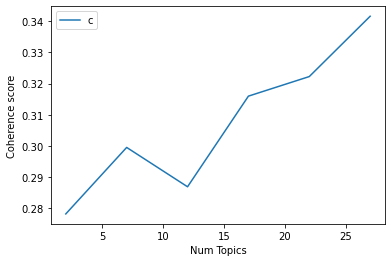

In [90]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [91]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  27

index: 0 | Num Topics = 2  has Coherence Value of 0.2783
index: 1 | Num Topics = 7  has Coherence Value of 0.2996
index: 2 | Num Topics = 12  has Coherence Value of 0.287
index: 3 | Num Topics = 17  has Coherence Value of 0.316
index: 4 | Num Topics = 22  has Coherence Value of 0.3223
index: 5 | Num Topics = 27  has Coherence Value of 0.3416


In [92]:
# Select optimal number of topics
optimal_model_ph_score4 = model_list_ph_score4[5]

In [93]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score4 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score4, corpus_ph_score4, id2word_ph_score4)

In [94]:
print("pyLDAVis for ph topics for score=4:")
vis_ph_score4

pyLDAVis for ph topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.148940 -0.128780       1        1  7.298872
13    -0.058674 -0.006678       2        1  6.216723
5      0.055478 -0.029656       3        1  5.553575
11     0.021404  0.036248       4        1  5.404589
24    -0.135309  0.027743       5        1  5.320580
12     0.020684  0.031622       6        1  5.147408
1     -0.091788  0.032415       7        1  4.778202
3      0.076659  0.114616       8        1  4.666607
6      0.004576  0.082290       9        1  4.607117
16     0.098102 -0.004664      10        1  4.437947
23    -0.061057 -0.038360      11        1  4.299925
4     -0.012122 -0.050020      12        1  4.029569
10     0.056217  0.044273      13        1  3.930991
26    -0.127774 -0.000271      14        1  3.719593
21    -0.058314 -0.079061      15        1  3.704870
18    -0.110590 -0.112764      16        1  3.458810
8      0.031932 -0.041155      17        1  3.338411
0      0.045360 -0.140711      18        1  3.104714
17     0.062943  0.045538      19        1  3.046351
9      0.139450 -0.030233      20        1  2.091959
20    -0.007260 -0.002811      21        1  2.090571
2      0.049602 -0.021865      22        1  2.069823
14    -0.063919  0.035958      23        1  2.056880
19    -0.065422 -0.043115      24        1  1.992453
22     0.012176  0.139558      25        1  1.444461
25     0.038075  0.112314      26        1  1.099634
7     -0.069366  0.027572      27        1  1.089365, topic_info=          Term       Freq      Total Category  logprob  loglift
87     account  69.000000  69.000000  Default  30.0000  30.0000
31       photo  75.000000  75.000000  Default  29.0000  29.0000
7         post  84.000000  84.000000  Default  28.0000  28.0000
77     feature  60.000000  60.000000  Default  27.0000  27.0000
421      music  27.000000  27.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
9        still   0.652633  44.638791  Topic27  -4.3535   0.2942
10       story   1.250365  96.685616  Topic27  -3.7033   0.1715
74         app   0.943088  82.223497  Topic27  -3.9854   0.0515
11      update   0.728528  94.845091  Topic27  -4.2435  -0.3494
41   instagram   0.636543  65.716765  Topic27  -4.3785  -0.1175

[1518 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
587      26  0.701599      abiut
347       1  0.170348       able
347       3  0.085174       able
347       5  0.085174       able
347       6  0.085174       able
...     ...       ...        ...
206      12  0.812452  yesterday
72        3  0.508946        yet
72       22  0.254473        yet
72       25  0.254473        yet
51       27  0.707537       zoom

[2445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 14, 6, 12, 25, 13, 2, 4, 7, 17, 24, 5, 11, 27, 22, 19, 9, 1, 18, 10, 21, 3, 15, 20, 23, 26, 8])

## LDA Topic Modelling (Rating = 5)

In [95]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_ph_score5 = instagram_ios_ph_review_YearMonth_score5.review.values.tolist()
review_words_ph_score5 = list(sent_to_words(review_ph_score5))
print(review_words_ph_score5[:1])

[['it', 'been', 'months', 'since', 'you', 'introduced', 'it', 'in', 'instagram', 'stories', 'but', 've', 'deleted', 'and', 'redownloaded', 'the', 'app', 'for', 'many', 'times', 'already', 'and', 'always', 'update', 'whenever', 'you', 'release', 'new', 'updates', 've', 'also', 'rebooted', 'my', 'phone', 'recently', 'but', 'still', 'don', 'have', 'the', 'superzoom', 'option', 'in', 'my', 'stories', 'please', 'help', 'and', 'fix']]


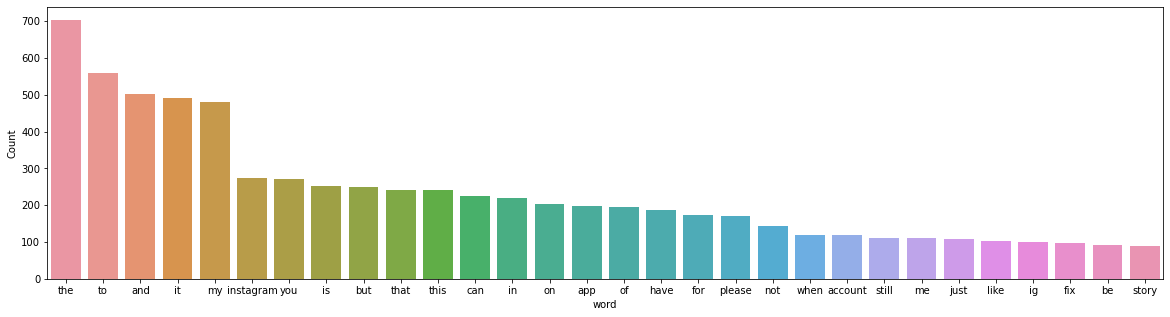

In [96]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score5))

In [97]:
# Clean text
review_ph_ready_score5 = process_words(review_words_ph_score5)  # processed Text Data! - move to each section

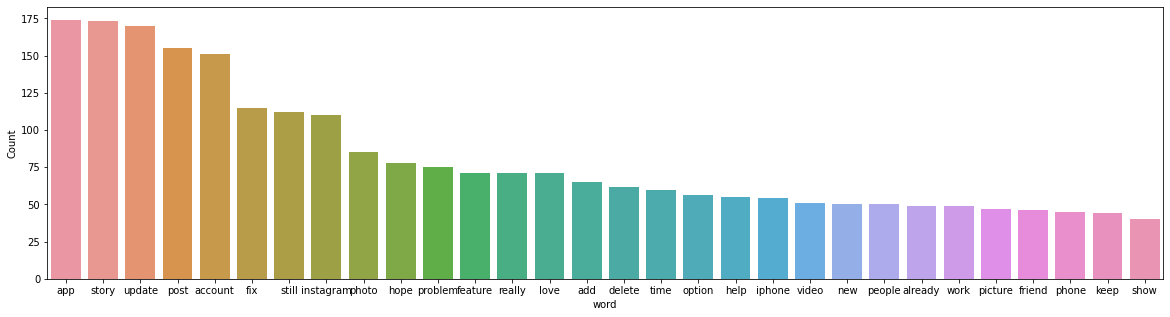

In [98]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score5))


In [99]:
# Create Dictionary
id2word_ph_score5 = corpora.Dictionary(review_ph_ready_score5)

2021-10-16 02:11:42,848 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:11:42,869 [INFO] gensim.corpora.dictionary - built Dictionary(1305 unique tokens: ['already', 'always', 'app', 'delete', 'fix']...) from 453 documents (total 7094 corpus positions)
2021-10-16 02:11:42,871 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1305 unique tokens: ['already', 'always', 'app', 'delete', 'fix']...) from 453 documents (total 7094 corpus positions)", 'datetime': '2021-10-16T02:11:42.871286', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [100]:
# Create Corpus: Term Document Frequency
corpus_ph_score5 = [id2word_ph_score5.doc2bow(text) for text in review_ph_ready_score5]

In [101]:
# Training LDA model
model_list_ph_score5, coherence_values_ph_score5 = compute_coherence_values(dictionary=id2word_ph_score5, corpus=corpus_ph_score5, 
                                                              texts=review_ph_ready_score5, limit=30, start=2, step=5)


2021-10-16 02:11:42,899 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:11:42,901 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:11:42,903 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:11:42,905 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 453 documents, updating model once every 453 documents, evaluating perplexity every 453 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:11:44,399 [INFO] gensim.models.ldamodel - -7.733 per-word bound, 212.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:11:44,401 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #453/453
2021-10-16 02:11:45,995 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"app" + 0.020*"story" + 0.020*"account" + 0.018*"still" + 0.018*"fix" + 0.018*"update" + 0.015*"in

2021-10-16 02:12:02,561 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.023*"update" + 0.021*"still" + 0.021*"fix" + 0.020*"story" + 0.017*"account" + 0.015*"instagram" + 0.015*"problem" + 0.014*"feature" + 0.011*"iphone"
2021-10-16 02:12:02,565 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"post" + 0.021*"story" + 0.019*"account" + 0.018*"photo" + 0.017*"update" + 0.013*"hope" + 0.011*"instagram" + 0.011*"app" + 0.009*"delete" + 0.009*"love"
2021-10-16 02:12:02,572 [INFO] gensim.models.ldamodel - topic diff=0.019564, rho=0.301511
2021-10-16 02:12:03,185 [INFO] gensim.models.ldamodel - -6.366 per-word bound, 82.5 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:12:03,189 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #453/453
2021-10-16 02:12:03,674 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.024*"update" + 0.022*"still" + 0.021*"fix" + 0.020*"story" + 0.017*"account" + 0.015*

2021-10-16 02:12:16,862 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"app" + 0.025*"update" + 0.022*"still" + 0.022*"fix" + 0.020*"story" + 0.017*"account" + 0.016*"problem" + 0.016*"instagram" + 0.014*"feature" + 0.012*"iphone"
2021-10-16 02:12:16,864 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"post" + 0.022*"story" + 0.020*"account" + 0.019*"photo" + 0.015*"update" + 0.013*"hope" + 0.010*"instagram" + 0.010*"add" + 0.009*"love" + 0.009*"delete"
2021-10-16 02:12:16,865 [INFO] gensim.models.ldamodel - topic diff=0.010550, rho=0.218218
2021-10-16 02:12:17,707 [INFO] gensim.models.ldamodel - -6.354 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:12:17,727 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #453/453
2021-10-16 02:12:18,357 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"app" + 0.025*"update" + 0.022*"still" + 0.022*"fix" + 0.019*"story" + 0.017*"account" + 0.016*

2021-10-16 02:12:32,298 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"app" + 0.026*"update" + 0.022*"still" + 0.022*"fix" + 0.019*"story" + 0.017*"account" + 0.017*"problem" + 0.016*"instagram" + 0.013*"feature" + 0.012*"iphone"
2021-10-16 02:12:32,303 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"post" + 0.023*"story" + 0.019*"account" + 0.019*"photo" + 0.014*"update" + 0.014*"hope" + 0.011*"add" + 0.010*"instagram" + 0.010*"really" + 0.009*"option"
2021-10-16 02:12:32,308 [INFO] gensim.models.ldamodel - topic diff=0.010053, rho=0.179605
2021-10-16 02:12:33,487 [INFO] gensim.models.ldamodel - -6.345 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:12:33,489 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #453/453
2021-10-16 02:12:34,232 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"app" + 0.026*"update" + 0.022*"still" + 0.022*"fix" + 0.018*"story" + 0.017*"account" + 0.01

2021-10-16 02:12:49,615 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"app" + 0.026*"update" + 0.023*"still" + 0.022*"fix" + 0.018*"story" + 0.017*"account" + 0.017*"problem" + 0.016*"instagram" + 0.013*"feature" + 0.013*"iphone"
2021-10-16 02:12:49,619 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"post" + 0.024*"story" + 0.019*"account" + 0.019*"photo" + 0.014*"update" + 0.014*"hope" + 0.012*"add" + 0.010*"really" + 0.010*"instagram" + 0.009*"option"
2021-10-16 02:12:49,621 [INFO] gensim.models.ldamodel - topic diff=0.006280, rho=0.156174
2021-10-16 02:12:50,626 [INFO] gensim.models.ldamodel - -6.338 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:12:50,639 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #453/453
2021-10-16 02:12:51,428 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"app" + 0.027*"update" + 0.023*"still" + 0.022*"fix" + 0.018*"story" + 0.017*"account" + 0.01

2021-10-16 02:13:07,542 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"app" + 0.027*"update" + 0.023*"still" + 0.022*"fix" + 0.018*"account" + 0.017*"problem" + 0.017*"story" + 0.016*"instagram" + 0.013*"iphone" + 0.012*"feature"
2021-10-16 02:13:07,553 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"post" + 0.025*"story" + 0.019*"photo" + 0.019*"account" + 0.014*"hope" + 0.013*"update" + 0.012*"add" + 0.010*"really" + 0.010*"instagram" + 0.010*"option"
2021-10-16 02:13:07,562 [INFO] gensim.models.ldamodel - topic diff=0.004099, rho=0.140028
2021-10-16 02:13:07,578 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1305, num_topics=2, decay=0.5, chunksize=1000) in 84.67s', 'datetime': '2021-10-16T02:13:07.577294', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:13:07,590 [INFO] gensim.topic_coherence.probability_estim

2021-10-16 02:13:21,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #453/453
2021-10-16 02:13:22,393 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.025*"app" + 0.017*"video" + 0.015*"delete" + 0.014*"hope" + 0.013*"post" + 0.012*"update" + 0.011*"add" + 0.010*"well" + 0.009*"people" + 0.009*"show"
2021-10-16 02:13:22,395 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"post" + 0.019*"story" + 0.018*"really" + 0.015*"still" + 0.015*"add" + 0.013*"photo" + 0.012*"fix" + 0.011*"picture" + 0.011*"feature" + 0.010*"hope"
2021-10-16 02:13:22,399 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"account" + 0.027*"story" + 0.021*"update" + 0.020*"log" + 0.020*"feature" + 0.019*"still" + 0.018*"instagram" + 0.017*"option" + 0.014*"fix" + 0.013*"already"
2021-10-16 02:13:22,401 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"update" + 0.025*"photo" + 0.018*"story" + 0.018*"app" + 0.016*"account" + 0.015*"post" + 0.014*"instagram" + 0.013*"multiple" 

2021-10-16 02:13:30,385 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"app" + 0.035*"story" + 0.030*"post" + 0.027*"update" + 0.021*"fix" + 0.014*"time" + 0.013*"still" + 0.012*"hope" + 0.011*"instagram" + 0.011*"already"
2021-10-16 02:13:30,388 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"app" + 0.015*"video" + 0.013*"delete" + 0.013*"hope" + 0.013*"post" + 0.010*"update" + 0.010*"well" + 0.010*"people" + 0.010*"show" + 0.009*"add"
2021-10-16 02:13:30,389 [INFO] gensim.models.ldamodel - topic diff=0.024776, rho=0.301511
2021-10-16 02:13:31,114 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:13:31,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #453/453
2021-10-16 02:13:31,858 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"app" + 0.035*"story" + 0.029*"post" + 0.027*"update" + 0.021*"fix" + 0.015*"time" + 0.013*"still" + 0.012*"hop

2021-10-16 02:13:38,927 [INFO] gensim.models.ldamodel - -6.605 per-word bound, 97.4 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:13:38,929 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #453/453
2021-10-16 02:13:39,548 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"post" + 0.019*"really" + 0.018*"story" + 0.016*"add" + 0.015*"picture" + 0.013*"photo" + 0.013*"still" + 0.011*"hope" + 0.011*"fix" + 0.010*"feature"
2021-10-16 02:13:39,552 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"app" + 0.014*"video" + 0.013*"post" + 0.011*"hope" + 0.011*"delete" + 0.010*"people" + 0.010*"well" + 0.010*"show" + 0.009*"update" + 0.008*"archive"
2021-10-16 02:13:39,554 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"update" + 0.029*"photo" + 0.018*"story" + 0.017*"app" + 0.016*"account" + 0.016*"post" + 0.014*"multiple" + 0.014*"delete" + 0.013*"instagram" + 0.012*"highlight"
2021-10-16 02:13:39,555 [INFO] gen

2021-10-16 02:13:45,755 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"post" + 0.019*"really" + 0.018*"story" + 0.017*"add" + 0.015*"picture" + 0.013*"photo" + 0.012*"still" + 0.012*"hope" + 0.011*"fix" + 0.010*"feature"
2021-10-16 02:13:45,756 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"app" + 0.013*"video" + 0.013*"post" + 0.010*"people" + 0.010*"hope" + 0.010*"well" + 0.010*"delete" + 0.010*"show" + 0.009*"update" + 0.008*"archive"
2021-10-16 02:13:45,758 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"app" + 0.036*"story" + 0.029*"update" + 0.028*"post" + 0.022*"fix" + 0.016*"time" + 0.014*"still" + 0.012*"already" + 0.011*"hope" + 0.011*"instagram"
2021-10-16 02:13:45,759 [INFO] gensim.models.ldamodel - topic diff=0.006510, rho=0.213201
2021-10-16 02:13:46,315 [INFO] gensim.models.ldamodel - -6.598 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:13:46,316 [INFO] gensim.models.ldamode

2021-10-16 02:13:52,170 [INFO] gensim.models.ldamodel - topic diff=0.004462, rho=0.192450
2021-10-16 02:13:52,962 [INFO] gensim.models.ldamodel - -6.595 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:13:52,964 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #453/453
2021-10-16 02:13:53,546 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"post" + 0.018*"really" + 0.018*"story" + 0.017*"add" + 0.016*"picture" + 0.013*"photo" + 0.012*"still" + 0.012*"hope" + 0.011*"fix" + 0.010*"feature"
2021-10-16 02:13:53,548 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"app" + 0.036*"story" + 0.029*"update" + 0.028*"post" + 0.022*"fix" + 0.016*"time" + 0.014*"still" + 0.012*"already" + 0.011*"hope" + 0.011*"instagram"
2021-10-16 02:13:53,550 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"app" + 0.013*"post" + 0.013*"video" + 0.010*"people" + 0.010*"well" + 0.010*"show" + 0.010*"hope" + 0.010*

2021-10-16 02:14:00,299 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"post" + 0.018*"really" + 0.018*"story" + 0.018*"add" + 0.016*"picture" + 0.013*"photo" + 0.012*"still" + 0.012*"hope" + 0.011*"fix" + 0.010*"feature"
2021-10-16 02:14:00,303 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"post" + 0.019*"quality" + 0.019*"app" + 0.018*"photo" + 0.018*"video" + 0.017*"love" + 0.014*"well" + 0.013*"instagram" + 0.012*"really" + 0.012*"back"
2021-10-16 02:14:00,306 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"problem" + 0.027*"account" + 0.027*"fix" + 0.023*"still" + 0.020*"update" + 0.017*"instagram" + 0.016*"app" + 0.016*"iphone" + 0.014*"really" + 0.012*"follow"
2021-10-16 02:14:00,308 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"account" + 0.027*"story" + 0.023*"log" + 0.022*"update" + 0.021*"feature" + 0.020*"still" + 0.018*"instagram" + 0.016*"option" + 0.013*"help" + 0.013*"new"
2021-10-16 02:14:00,315 [INFO] gensim.models.ldamodel - top

2021-10-16 02:14:07,882 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"update" + 0.031*"photo" + 0.018*"app" + 0.017*"post" + 0.017*"story" + 0.015*"delete" + 0.015*"account" + 0.015*"multiple" + 0.014*"instagram" + 0.013*"highlight"
2021-10-16 02:14:07,883 [INFO] gensim.models.ldamodel - topic diff=0.002812, rho=0.162221
2021-10-16 02:14:08,648 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:14:08,649 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #453/453
2021-10-16 02:14:09,164 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"post" + 0.020*"quality" + 0.019*"app" + 0.019*"photo" + 0.018*"video" + 0.017*"love" + 0.014*"well" + 0.013*"instagram" + 0.012*"really" + 0.012*"back"
2021-10-16 02:14:09,166 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"problem" + 0.027*"account" + 0.027*"fix" + 0.023*"still" + 0.020*"update" + 0.017*"instagram

2021-10-16 02:14:15,780 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"post" + 0.020*"quality" + 0.019*"app" + 0.019*"photo" + 0.018*"video" + 0.017*"love" + 0.014*"well" + 0.013*"instagram" + 0.012*"really" + 0.012*"back"
2021-10-16 02:14:15,781 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.024*"app" + 0.013*"post" + 0.012*"video" + 0.011*"people" + 0.010*"well" + 0.010*"show" + 0.010*"hope" + 0.009*"delete" + 0.009*"play" + 0.009*"archive"
2021-10-16 02:14:15,783 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.035*"post" + 0.019*"add" + 0.018*"story" + 0.018*"really" + 0.016*"picture" + 0.013*"photo" + 0.012*"still" + 0.012*"hope" + 0.011*"fix" + 0.010*"feature"
2021-10-16 02:14:15,784 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"app" + 0.036*"story" + 0.030*"update" + 0.027*"post" + 0.022*"fix" + 0.016*"time" + 0.014*"still" + 0.012*"already" + 0.011*"phone" + 0.011*"hope"
2021-10-16 02:14:15,785 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033

2021-10-16 02:14:22,249 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"problem" + 0.027*"fix" + 0.026*"account" + 0.022*"still" + 0.021*"update" + 0.017*"instagram" + 0.016*"app" + 0.016*"iphone" + 0.014*"really" + 0.012*"follow"
2021-10-16 02:14:22,254 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"post" + 0.019*"add" + 0.018*"really" + 0.018*"story" + 0.016*"picture" + 0.013*"photo" + 0.012*"still" + 0.012*"hope" + 0.011*"fix" + 0.010*"feature"
2021-10-16 02:14:22,255 [INFO] gensim.models.ldamodel - topic diff=0.002348, rho=0.142857
2021-10-16 02:14:22,967 [INFO] gensim.models.ldamodel - -6.587 per-word bound, 96.1 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:14:22,969 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #453/453
2021-10-16 02:14:23,530 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"post" + 0.019*"add" + 0.018*"really" + 0.018*"story" + 0.016*"picture" + 0.013*"photo" + 0.012*"st

2021-10-16 02:14:35,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #453/453
2021-10-16 02:14:36,090 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.030*"post" + 0.017*"really" + 0.016*"update" + 0.015*"back" + 0.013*"app" + 0.012*"much" + 0.011*"love" + 0.011*"instagram" + 0.010*"look" + 0.010*"follow"
2021-10-16 02:14:36,092 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"update" + 0.020*"photo" + 0.019*"story" + 0.016*"filter" + 0.011*"account" + 0.011*"post" + 0.011*"friend" + 0.010*"save" + 0.010*"instagram" + 0.010*"problem"
2021-10-16 02:14:36,098 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.056*"app" + 0.047*"story" + 0.026*"update" + 0.022*"post" + 0.021*"fix" + 0.017*"time" + 0.015*"hope" + 0.013*"still" + 0.011*"love" + 0.011*"already"
2021-10-16 02:14:36,104 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.043*"instagram" + 0.032*"music" + 0.024*"love" + 0.022*"story" + 0.020*"photo" + 0.019*"still" + 0.018*"update" + 0.013*"app" + 0

2021-10-16 02:14:43,352 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.049*"post" + 0.021*"update" + 0.019*"account" + 0.018*"log" + 0.016*"fix" + 0.016*"photo" + 0.015*"delete" + 0.015*"story" + 0.014*"picture" + 0.014*"app"
2021-10-16 02:14:43,354 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"app" + 0.039*"update" + 0.022*"highlight" + 0.018*"fix" + 0.018*"account" + 0.017*"phone" + 0.016*"iphone" + 0.016*"still" + 0.016*"story" + 0.015*"instagram"
2021-10-16 02:14:43,356 [INFO] gensim.models.ldamodel - topic diff=0.043211, rho=0.333333
2021-10-16 02:14:44,286 [INFO] gensim.models.ldamodel - -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:14:44,290 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #453/453
2021-10-16 02:14:44,752 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"post" + 0.016*"really" + 0.015*"update" + 0.015*"back" + 0.013*"app" + 0.012*"follower" + 0.011*"

2021-10-16 02:14:50,048 [INFO] gensim.models.ldamodel - -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:14:50,050 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #453/453
2021-10-16 02:14:50,529 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.029*"update" + 0.022*"photo" + 0.018*"filter" + 0.014*"story" + 0.012*"save" + 0.012*"friend" + 0.011*"account" + 0.010*"picture" + 0.010*"post" + 0.010*"instagram"
2021-10-16 02:14:50,531 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.039*"app" + 0.039*"update" + 0.023*"highlight" + 0.021*"iphone" + 0.019*"fix" + 0.018*"account" + 0.017*"phone" + 0.017*"story" + 0.017*"still" + 0.015*"instagram"
2021-10-16 02:14:50,537 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.042*"account" + 0.021*"password" + 0.020*"post" + 0.013*"profile" + 0.012*"delete" + 0.012*"photo" + 0.012*"long" + 0.012*"fix" + 0.011*"app" + 0.011*"feed"
2021-10-16 02:14:50,539 

2021-10-16 02:14:56,733 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.042*"account" + 0.037*"story" + 0.024*"feature" + 0.024*"new" + 0.022*"still" + 0.020*"report" + 0.019*"share" + 0.018*"update" + 0.018*"already" + 0.017*"able"
2021-10-16 02:14:56,739 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.039*"update" + 0.039*"app" + 0.023*"highlight" + 0.021*"iphone" + 0.020*"fix" + 0.019*"account" + 0.017*"still" + 0.017*"story" + 0.016*"phone" + 0.015*"instagram"
2021-10-16 02:14:56,745 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"post" + 0.025*"really" + 0.021*"add" + 0.020*"hope" + 0.018*"feature" + 0.015*"friend" + 0.014*"story" + 0.014*"people" + 0.013*"still" + 0.012*"follow"
2021-10-16 02:14:56,752 [INFO] gensim.models.ldamodel - topic diff=0.007663, rho=0.223607
2021-10-16 02:14:57,334 [INFO] gensim.models.ldamodel - -6.751 per-word bound, 107.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:14:57,342 [INFO] gen

2021-10-16 02:15:02,692 [INFO] gensim.models.ldamodel - topic diff=0.005321, rho=0.200000
2021-10-16 02:15:03,426 [INFO] gensim.models.ldamodel - -6.746 per-word bound, 107.3 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:15:03,427 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #453/453
2021-10-16 02:15:03,989 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"account" + 0.016*"feature" + 0.014*"category" + 0.013*"user" + 0.012*"post" + 0.012*"hope" + 0.011*"app" + 0.011*"always" + 0.011*"find" + 0.011*"instagram"
2021-10-16 02:15:04,035 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.029*"update" + 0.023*"photo" + 0.017*"filter" + 0.014*"story" + 0.013*"save" + 0.012*"friend" + 0.011*"account" + 0.011*"picture" + 0.010*"instagram" + 0.010*"post"
2021-10-16 02:15:04,039 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.039*"update" + 0.039*"app" + 0.023*"highlight" + 0.022*"iphone" + 0.020*"fix" + 0.019*"account

2021-10-16 02:15:10,028 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"post" + 0.015*"really" + 0.015*"back" + 0.015*"update" + 0.013*"follower" + 0.013*"app" + 0.011*"much" + 0.011*"look" + 0.011*"follow" + 0.010*"photo"
2021-10-16 02:15:10,034 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"post" + 0.025*"really" + 0.023*"add" + 0.020*"hope" + 0.018*"feature" + 0.015*"people" + 0.015*"friend" + 0.014*"story" + 0.014*"follow" + 0.013*"still"
2021-10-16 02:15:10,039 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.061*"app" + 0.053*"story" + 0.039*"update" + 0.024*"fix" + 0.022*"post" + 0.021*"still" + 0.018*"time" + 0.018*"already" + 0.018*"problem" + 0.015*"iphone"
2021-10-16 02:15:10,041 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.047*"instagram" + 0.038*"music" + 0.027*"love" + 0.022*"photo" + 0.021*"story" + 0.017*"still" + 0.015*"update" + 0.013*"available" + 0.013*"option" + 0.013*"region"
2021-10-16 02:15:10,042 [INFO] gensim.models.ldamodel - topi

2021-10-16 02:15:15,919 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.061*"app" + 0.052*"story" + 0.039*"update" + 0.025*"fix" + 0.023*"still" + 0.022*"post" + 0.019*"problem" + 0.019*"already" + 0.019*"time" + 0.015*"iphone"
2021-10-16 02:15:15,921 [INFO] gensim.models.ldamodel - topic diff=0.003485, rho=0.166667
2021-10-16 02:15:16,642 [INFO] gensim.models.ldamodel - -6.737 per-word bound, 106.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:15:16,662 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #453/453
2021-10-16 02:15:17,075 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"post" + 0.016*"really" + 0.015*"back" + 0.015*"update" + 0.013*"follower" + 0.013*"app" + 0.011*"much" + 0.011*"look" + 0.011*"follow" + 0.011*"photo"
2021-10-16 02:15:17,115 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.043*"account" + 0.036*"story" + 0.025*"feature" + 0.024*"new" + 0.020*"report" + 0.020*"share" + 0.020*"still

2021-10-16 02:15:23,144 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"post" + 0.025*"really" + 0.023*"add" + 0.020*"hope" + 0.019*"feature" + 0.015*"people" + 0.015*"friend" + 0.015*"follow" + 0.014*"story" + 0.013*"option"
2021-10-16 02:15:23,149 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.039*"app" + 0.039*"update" + 0.023*"highlight" + 0.022*"iphone" + 0.020*"fix" + 0.019*"account" + 0.016*"still" + 0.016*"video" + 0.016*"story" + 0.016*"phone"
2021-10-16 02:15:23,153 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.053*"post" + 0.021*"photo" + 0.019*"account" + 0.019*"log" + 0.019*"update" + 0.018*"delete" + 0.016*"picture" + 0.013*"like" + 0.013*"fix" + 0.012*"option"
2021-10-16 02:15:23,157 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"account" + 0.021*"password" + 0.020*"post" + 0.017*"profile" + 0.013*"page" + 0.013*"photo" + 0.012*"long" + 0.011*"block" + 0.011*"feed" + 0.011*"tag"
2021-10-16 02:15:23,162 [INFO] gensim.models.ldamodel - topic

2021-10-16 02:15:28,563 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.053*"post" + 0.021*"photo" + 0.019*"account" + 0.019*"log" + 0.019*"delete" + 0.018*"update" + 0.016*"picture" + 0.013*"like" + 0.012*"fix" + 0.012*"option"
2021-10-16 02:15:28,566 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"post" + 0.024*"really" + 0.023*"add" + 0.020*"hope" + 0.019*"feature" + 0.015*"follow" + 0.015*"people" + 0.015*"friend" + 0.014*"story" + 0.013*"option"
2021-10-16 02:15:28,568 [INFO] gensim.models.ldamodel - topic diff=0.002452, rho=0.145865
2021-10-16 02:15:29,321 [INFO] gensim.models.ldamodel - -6.732 per-word bound, 106.3 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:15:29,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #453/453
2021-10-16 02:15:29,841 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.020*"video" + 0.017*"add" + 0.016*"app" + 0.015*"photo" + 0.014*"story" + 0.013*"hope" + 0.011*"thing" +

2021-10-16 02:15:41,815 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #453/453
2021-10-16 02:15:42,736 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.031*"account" + 0.027*"story" + 0.024*"update" + 0.022*"still" + 0.020*"instagram" + 0.019*"option" + 0.015*"log" + 0.015*"app" + 0.015*"already" + 0.014*"feature"
2021-10-16 02:15:42,739 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"app" + 0.024*"video" + 0.018*"really" + 0.017*"hope" + 0.017*"photo" + 0.015*"story" + 0.015*"still" + 0.014*"problem" + 0.012*"update" + 0.011*"always"
2021-10-16 02:15:42,742 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.031*"update" + 0.022*"photo" + 0.020*"account" + 0.018*"story" + 0.016*"post" + 0.015*"problem" + 0.012*"app" + 0.012*"work" + 0.012*"hope" + 0.011*"delete"
2021-10-16 02:15:42,744 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.015*"account" + 0.015*"help" + 0.014*"hope" + 0.014*"look" + 0.014*"old" + 0.014*"one" + 0.014*"back" + 0.014*"love" + 0.

2021-10-16 02:15:48,587 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.046*"story" + 0.032*"share" + 0.031*"post" + 0.027*"send" + 0.023*"button" + 0.023*"account" + 0.015*"archive" + 0.014*"option" + 0.014*"people" + 0.013*"ask"
2021-10-16 02:15:48,591 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"update" + 0.027*"photo" + 0.026*"account" + 0.024*"post" + 0.019*"multiple" + 0.018*"delete" + 0.016*"hope" + 0.016*"story" + 0.014*"follow" + 0.014*"problem"
2021-10-16 02:15:48,593 [INFO] gensim.models.ldamodel - topic diff=0.075839, rho=0.377964
2021-10-16 02:15:49,333 [INFO] gensim.models.ldamodel - -6.859 per-word bound, 116.0 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:15:49,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #453/453
2021-10-16 02:15:49,803 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.036*"account" + 0.033*"highlight" + 0.023*"password" + 0.021*"feature" + 0.019*"add" + 0.013*"tell

2021-10-16 02:15:55,338 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #453/453
2021-10-16 02:15:55,818 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.040*"account" + 0.029*"profile" + 0.014*"fix" + 0.012*"black" + 0.012*"post" + 0.012*"app" + 0.011*"upload" + 0.011*"tag" + 0.011*"option" + 0.011*"wrong"
2021-10-16 02:15:55,821 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.054*"post" + 0.042*"video" + 0.031*"quality" + 0.027*"add" + 0.025*"edit" + 0.024*"picture" + 0.021*"instagram" + 0.020*"really" + 0.019*"fix" + 0.017*"photo"
2021-10-16 02:15:55,827 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.044*"app" + 0.044*"update" + 0.026*"account" + 0.025*"story" + 0.022*"still" + 0.021*"phone" + 0.020*"instagram" + 0.020*"fix" + 0.015*"really" + 0.014*"love"
2021-10-16 02:15:55,830 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.047*"instagram" + 0.046*"music" + 0.035*"love" + 0.032*"story" + 0.023*"app" + 0.021*"friend" + 0.018*"photo" + 0.014*"availa

2021-10-16 02:16:01,811 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.047*"account" + 0.042*"log" + 0.028*"story" + 0.026*"still" + 0.022*"option" + 0.021*"instagram" + 0.018*"update" + 0.018*"feature" + 0.014*"always" + 0.014*"open"
2021-10-16 02:16:01,814 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.045*"update" + 0.044*"app" + 0.025*"story" + 0.024*"account" + 0.022*"still" + 0.021*"instagram" + 0.021*"phone" + 0.020*"fix" + 0.015*"love" + 0.015*"really"
2021-10-16 02:16:01,816 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"account" + 0.030*"highlight" + 0.025*"password" + 0.020*"add" + 0.018*"feature" + 0.014*"tell" + 0.014*"reset" + 0.012*"app" + 0.011*"user" + 0.011*"update"
2021-10-16 02:16:01,819 [INFO] gensim.models.ldamodel - topic diff=0.010500, rho=0.235702
2021-10-16 02:16:02,435 [INFO] gensim.models.ldamodel - -6.816 per-word bound, 112.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:16:02,440 [INFO] g

2021-10-16 02:16:07,820 [INFO] gensim.models.ldamodel - topic diff=0.006560, rho=0.208514
2021-10-16 02:16:08,495 [INFO] gensim.models.ldamodel - -6.810 per-word bound, 112.2 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:16:08,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #453/453
2021-10-16 02:16:08,950 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.036*"story" + 0.022*"still" + 0.020*"post" + 0.018*"option" + 0.014*"photo" + 0.013*"save" + 0.013*"archive" + 0.013*"love" + 0.012*"really" + 0.012*"time"
2021-10-16 02:16:08,952 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.055*"post" + 0.042*"video" + 0.031*"quality" + 0.030*"add" + 0.027*"picture" + 0.025*"edit" + 0.024*"instagram" + 0.021*"really" + 0.018*"photo" + 0.018*"fix"
2021-10-16 02:16:08,955 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.038*"problem" + 0.026*"account" + 0.024*"fix" + 0.022*"really" + 0.018*"iphone" + 0.018*"still" + 0.018*"

2021-10-16 02:16:15,717 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.031*"update" + 0.031*"post" + 0.030*"account" + 0.027*"photo" + 0.022*"multiple" + 0.019*"add" + 0.019*"hope" + 0.018*"delete" + 0.018*"follow" + 0.016*"story"
2021-10-16 02:16:15,719 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.048*"instagram" + 0.047*"music" + 0.036*"love" + 0.031*"story" + 0.023*"app" + 0.023*"friend" + 0.018*"photo" + 0.016*"region" + 0.015*"available" + 0.013*"hope"
2021-10-16 02:16:15,721 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.042*"story" + 0.036*"share" + 0.033*"send" + 0.031*"post" + 0.026*"account" + 0.024*"button" + 0.015*"ask" + 0.014*"people" + 0.012*"option" + 0.012*"add"
2021-10-16 02:16:15,722 [INFO] gensim.models.ldamodel - topic diff=0.004317, rho=0.185695
2021-10-16 02:16:16,640 [INFO] gensim.models.ldamodel - -6.803 per-word bound, 111.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:16:16,661 [INFO] gensim.m

2021-10-16 02:16:21,726 [INFO] gensim.models.ldamodel - topic diff=0.003448, rho=0.171499
2021-10-16 02:16:22,311 [INFO] gensim.models.ldamodel - -6.799 per-word bound, 111.4 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:16:22,313 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #453/453
2021-10-16 02:16:22,714 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.038*"problem" + 0.026*"account" + 0.025*"fix" + 0.022*"really" + 0.018*"iphone" + 0.018*"still" + 0.018*"hope" + 0.016*"app" + 0.016*"notification" + 0.016*"follow"
2021-10-16 02:16:22,716 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.042*"story" + 0.036*"share" + 0.033*"send" + 0.031*"post" + 0.026*"account" + 0.024*"button" + 0.015*"ask" + 0.014*"people" + 0.012*"option" + 0.012*"add"
2021-10-16 02:16:22,718 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.050*"account" + 0.044*"log" + 0.030*"still" + 0.023*"story" + 0.022*"option" + 0.021*"instagram" + 0

2021-10-16 02:16:29,655 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.019*"app" + 0.019*"work" + 0.019*"never" + 0.014*"people" + 0.014*"inhumane" + 0.014*"medium" + 0.014*"social" + 0.014*"well" + 0.014*"ever" + 0.009*"instagram"
2021-10-16 02:16:29,659 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.036*"story" + 0.023*"still" + 0.019*"post" + 0.019*"option" + 0.014*"archive" + 0.014*"save" + 0.013*"photo" + 0.013*"time" + 0.012*"love" + 0.011*"really"
2021-10-16 02:16:29,661 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"post" + 0.031*"update" + 0.030*"account" + 0.028*"photo" + 0.023*"multiple" + 0.020*"add" + 0.019*"hope" + 0.019*"delete" + 0.018*"follow" + 0.016*"story"
2021-10-16 02:16:29,669 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.036*"post" + 0.033*"story" + 0.023*"hope" + 0.018*"view" + 0.016*"fix" + 0.014*"well" + 0.014*"react" + 0.014*"back" + 0.014*"viewer" + 0.013*"show"
2021-10-16 02:16:29,674 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 02:16:36,062 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.032*"video" + 0.031*"app" + 0.025*"photo" + 0.019*"really" + 0.013*"hope" + 0.013*"play" + 0.013*"always" + 0.013*"photography" + 0.013*"share" + 0.010*"update"
2021-10-16 02:16:36,063 [INFO] gensim.models.ldamodel - topic diff=0.002417, rho=0.149071
2021-10-16 02:16:36,723 [INFO] gensim.models.ldamodel - -6.792 per-word bound, 110.8 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:16:36,726 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #453/453
2021-10-16 02:16:37,260 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.050*"account" + 0.044*"log" + 0.032*"still" + 0.022*"option" + 0.020*"story" + 0.020*"instagram" + 0.018*"update" + 0.017*"help" + 0.016*"open" + 0.016*"time"
2021-10-16 02:16:37,269 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"post" + 0.031*"account" + 0.031*"update" + 0.028*"photo" + 0.023*"multiple" + 0.020*"add" + 0.01

2021-10-16 02:16:43,249 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.049*"update" + 0.047*"app" + 0.025*"story" + 0.022*"account" + 0.022*"phone" + 0.021*"instagram" + 0.020*"fix" + 0.020*"still" + 0.018*"love" + 0.015*"back"
2021-10-16 02:16:43,267 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"account" + 0.039*"profile" + 0.020*"black" + 0.017*"fix" + 0.012*"wrong" + 0.012*"app" + 0.012*"page" + 0.012*"upload" + 0.011*"post" + 0.011*"screen"
2021-10-16 02:16:43,276 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.019*"app" + 0.019*"work" + 0.019*"never" + 0.014*"people" + 0.014*"inhumane" + 0.014*"ever" + 0.014*"medium" + 0.014*"social" + 0.014*"well" + 0.009*"instagram"
2021-10-16 02:16:43,301 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.036*"story" + 0.023*"still" + 0.019*"option" + 0.018*"post" + 0.014*"archive" + 0.014*"save" + 0.013*"time" + 0.013*"photo" + 0.012*"love" + 0.011*"really"
2021-10-16 02:16:43,303 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 02:16:55,828 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.037*"account" + 0.029*"share" + 0.025*"story" + 0.024*"log" + 0.022*"fix" + 0.020*"report" + 0.019*"option" + 0.018*"update" + 0.017*"problem" + 0.014*"feature"
2021-10-16 02:16:55,830 [INFO] gensim.models.ldamodel - topic diff=0.123089, rho=0.447214
2021-10-16 02:16:56,468 [INFO] gensim.models.ldamodel - -7.044 per-word bound, 132.0 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:16:56,469 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #453/453
2021-10-16 02:16:56,916 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.048*"post" + 0.041*"picture" + 0.035*"add" + 0.032*"delete" + 0.031*"photo" + 0.031*"option" + 0.030*"story" + 0.028*"update" + 0.026*"multiple" + 0.025*"hope"
2021-10-16 02:16:56,948 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.050*"music" + 0.039*"instagram" + 0.037*"story" + 0.019*"filter" + 0.017*"update" + 0.017*"feature" 

2021-10-16 02:17:02,241 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.028*"app" + 0.027*"account" + 0.019*"work" + 0.018*"story" + 0.017*"upload" + 0.016*"problem" + 0.013*"filter" + 0.012*"add" + 0.011*"video" + 0.011*"put"
2021-10-16 02:17:02,246 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.021*"video" + 0.020*"password" + 0.018*"account" + 0.018*"feature" + 0.018*"post" + 0.013*"update" + 0.013*"fix" + 0.013*"forgot" + 0.013*"wish" + 0.013*"always"
2021-10-16 02:17:02,301 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.059*"music" + 0.040*"instagram" + 0.038*"story" + 0.022*"filter" + 0.018*"feature" + 0.016*"update" + 0.015*"country" + 0.015*"still" + 0.014*"love" + 0.013*"work"
2021-10-16 02:17:02,315 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.057*"app" + 0.033*"phone" + 0.030*"account" + 0.027*"update" + 0.027*"still" + 0.024*"fix" + 0.020*"story" + 0.016*"keep" + 0.014*"crash" + 0.013*"feature"
2021-10-16 02:17:02,318 [INFO] gensim.models.ldamodel - to

2021-10-16 02:17:07,697 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.040*"quality" + 0.035*"post" + 0.028*"video" + 0.021*"photo" + 0.021*"love" + 0.019*"really" + 0.018*"upload" + 0.017*"app" + 0.016*"fix" + 0.016*"well"
2021-10-16 02:17:07,698 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.062*"app" + 0.022*"post" + 0.020*"fix" + 0.016*"update" + 0.015*"hope" + 0.014*"time" + 0.013*"story" + 0.012*"work" + 0.012*"log" + 0.011*"still"
2021-10-16 02:17:07,699 [INFO] gensim.models.ldamodel - topic diff=0.018000, rho=0.250000
2021-10-16 02:17:08,279 [INFO] gensim.models.ldamodel - -6.947 per-word bound, 123.4 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:17:08,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #453/453
2021-10-16 02:17:08,717 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.040*"account" + 0.034*"share" + 0.028*"log" + 0.025*"story" + 0.023*"fix" + 0.022*"report" + 0.021*"problem" + 0.019*"op

2021-10-16 02:17:14,117 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #453/453
2021-10-16 02:17:14,701 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.029*"app" + 0.029*"account" + 0.020*"work" + 0.019*"story" + 0.017*"upload" + 0.017*"problem" + 0.012*"add" + 0.012*"filter" + 0.011*"instagram" + 0.011*"video"
2021-10-16 02:17:14,707 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"account" + 0.037*"share" + 0.028*"log" + 0.024*"story" + 0.023*"fix" + 0.022*"report" + 0.022*"problem" + 0.019*"option" + 0.017*"update" + 0.016*"always"
2021-10-16 02:17:14,709 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.025*"post" + 0.023*"really" + 0.017*"photo" + 0.015*"love" + 0.015*"account" + 0.015*"instagram" + 0.015*"option" + 0.015*"privacy" + 0.015*"people" + 0.012*"delete"
2021-10-16 02:17:14,711 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.034*"story" + 0.027*"post" + 0.022*"people" + 0.018*"account" + 0.018*"share" + 0.014*"option" + 0.013*"update

2021-10-16 02:17:20,311 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.027*"story" + 0.025*"time" + 0.024*"save" + 0.020*"still" + 0.019*"post" + 0.018*"camera" + 0.014*"maybe" + 0.014*"business" + 0.013*"archive" + 0.011*"feature"
2021-10-16 02:17:20,318 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.040*"post" + 0.018*"photo" + 0.017*"app" + 0.017*"fix" + 0.016*"still" + 0.016*"help" + 0.016*"hope" + 0.013*"account" + 0.013*"option" + 0.012*"delete"
2021-10-16 02:17:20,321 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.070*"account" + 0.035*"post" + 0.029*"story" + 0.025*"follow" + 0.020*"fix" + 0.015*"already" + 0.015*"still" + 0.015*"friend" + 0.013*"day" + 0.013*"happen"
2021-10-16 02:17:20,323 [INFO] gensim.models.ldamodel - topic diff=0.007033, rho=0.192450
2021-10-16 02:17:20,870 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:17:20,872 [INFO] gensim.model

2021-10-16 02:17:25,580 [INFO] gensim.models.ldamodel - topic diff=0.005668, rho=0.176777
2021-10-16 02:17:26,205 [INFO] gensim.models.ldamodel - -6.919 per-word bound, 121.0 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:17:26,206 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #453/453
2021-10-16 02:17:26,631 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.069*"highlight" + 0.039*"story" + 0.035*"post" + 0.028*"view" + 0.019*"update" + 0.018*"people" + 0.016*"option" + 0.016*"friend" + 0.016*"react" + 0.013*"show"
2021-10-16 02:17:26,635 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.063*"post" + 0.061*"photo" + 0.051*"picture" + 0.042*"add" + 0.038*"delete" + 0.035*"multiple" + 0.030*"option" + 0.027*"story" + 0.027*"update" + 0.027*"change"
2021-10-16 02:17:26,640 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"really" + 0.039*"add" + 0.023*"instagram" + 0.022*"app" + 0.020*"conversation" + 0.020*"not

2021-10-16 02:17:33,507 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.061*"app" + 0.036*"phone" + 0.029*"account" + 0.028*"fix" + 0.027*"still" + 0.025*"update" + 0.022*"keep" + 0.018*"story" + 0.016*"crash" + 0.014*"notification"
2021-10-16 02:17:33,509 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.042*"share" + 0.041*"account" + 0.033*"log" + 0.024*"story" + 0.023*"problem" + 0.022*"report" + 0.022*"fix" + 0.020*"always" + 0.020*"option" + 0.015*"update"
2021-10-16 02:17:33,511 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.025*"keep" + 0.020*"put" + 0.018*"app" + 0.016*"love" + 0.016*"account" + 0.016*"reply" + 0.015*"guy" + 0.015*"hope" + 0.012*"picture" + 0.011*"well"
2021-10-16 02:17:33,513 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.041*"post" + 0.019*"photo" + 0.016*"app" + 0.016*"help" + 0.015*"hope" + 0.015*"still" + 0.014*"fix" + 0.013*"account" + 0.013*"option" + 0.013*"like"
2021-10-16 02:17:33,515 [INFO] gensim.models.ldamodel - topic diff=0.004

2021-10-16 02:17:38,788 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.065*"app" + 0.023*"post" + 0.020*"fix" + 0.015*"update" + 0.015*"hope" + 0.014*"time" + 0.013*"work" + 0.013*"problem" + 0.012*"always" + 0.011*"open"
2021-10-16 02:17:38,790 [INFO] gensim.models.ldamodel - topic diff=0.003843, rho=0.152499
2021-10-16 02:17:39,581 [INFO] gensim.models.ldamodel - -6.909 per-word bound, 120.2 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:17:39,582 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #453/453
2021-10-16 02:17:39,995 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.027*"story" + 0.019*"love" + 0.019*"instagram" + 0.017*"post" + 0.017*"really" + 0.014*"look" + 0.014*"people" + 0.014*"app" + 0.014*"update" + 0.012*"follower"
2021-10-16 02:17:39,996 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.029*"app" + 0.026*"send" + 0.022*"story" + 0.018*"really" + 0.018*"add" + 0.018*"friend" + 0.017*"hope" + 0.0

2021-10-16 02:17:45,210 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.030*"fix" + 0.020*"report" + 0.020*"still" + 0.020*"wrong" + 0.020*"help" + 0.020*"effect" + 0.010*"response" + 0.010*"sign" + 0.010*"work" + 0.010*"delete"
2021-10-16 02:17:45,212 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.026*"photo" + 0.025*"update" + 0.022*"page" + 0.017*"story" + 0.016*"profile" + 0.016*"instagram" + 0.014*"delete" + 0.013*"app" + 0.013*"user" + 0.013*"group"
2021-10-16 02:17:45,214 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.055*"really" + 0.039*"add" + 0.023*"instagram" + 0.022*"app" + 0.020*"conversation" + 0.020*"notify" + 0.020*"account" + 0.019*"update" + 0.018*"fix" + 0.017*"search"
2021-10-16 02:17:45,215 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.043*"share" + 0.042*"account" + 0.035*"log" + 0.024*"story" + 0.023*"problem" + 0.023*"report" + 0.021*"fix" + 0.020*"option" + 0.020*"always" + 0.014*"button"
2021-10-16 02:17:45,216 [INFO] gensim.models.ldamod

2021-10-16 02:17:57,955 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.033*"account" + 0.032*"story" + 0.023*"option" + 0.022*"app" + 0.022*"log" + 0.021*"problem" + 0.021*"happen" + 0.021*"share" + 0.020*"report" + 0.019*"still"
2021-10-16 02:17:57,973 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.047*"share" + 0.045*"post" + 0.037*"story" + 0.026*"app" + 0.021*"hope" + 0.020*"allow" + 0.017*"feature" + 0.017*"people" + 0.014*"friend" + 0.014*"update"
2021-10-16 02:17:57,998 [INFO] gensim.models.ldamodel - topic diff=0.143141, rho=0.577350
2021-10-16 02:17:58,587 [INFO] gensim.models.ldamodel - -7.210 per-word bound, 148.1 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:17:58,591 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #453/453
2021-10-16 02:17:59,019 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.037*"app" + 0.035*"post" + 0.024*"keep" + 0.021*"fix" + 0.020*"account" + 0.019*"photo" + 0.018*"still" 

2021-10-16 02:18:03,916 [INFO] gensim.models.ldamodel - -7.052 per-word bound, 132.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:18:03,920 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #453/453
2021-10-16 02:18:04,364 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.056*"app" + 0.045*"story" + 0.030*"update" + 0.024*"hope" + 0.022*"post" + 0.021*"fix" + 0.017*"still" + 0.017*"already" + 0.017*"love" + 0.016*"phone"
2021-10-16 02:18:04,366 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.026*"find" + 0.021*"app" + 0.018*"whenever" + 0.016*"archive" + 0.014*"instagram" + 0.014*"keep" + 0.013*"always" + 0.013*"problem" + 0.012*"highlight" + 0.012*"story"
2021-10-16 02:18:04,368 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.049*"account" + 0.040*"log" + 0.028*"problem" + 0.026*"upload" + 0.023*"work" + 0.016*"app" + 0.014*"fix" + 0.013*"filter" + 0.012*"time" + 0.012*"always"
2021-10-16 02:18:04,372 [INFO] gensi

2021-10-16 02:18:09,759 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.033*"picture" + 0.031*"really" + 0.025*"post" + 0.021*"still" + 0.020*"fix" + 0.020*"add" + 0.020*"save" + 0.017*"feature" + 0.015*"photo" + 0.014*"follow"
2021-10-16 02:18:09,761 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.049*"post" + 0.027*"account" + 0.026*"problem" + 0.025*"instagram" + 0.017*"app" + 0.016*"video" + 0.014*"help" + 0.014*"day" + 0.014*"delete" + 0.013*"picture"
2021-10-16 02:18:09,764 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.049*"account" + 0.045*"log" + 0.027*"problem" + 0.026*"upload" + 0.023*"work" + 0.015*"app" + 0.014*"fix" + 0.012*"always" + 0.012*"filter" + 0.012*"time"
2021-10-16 02:18:09,765 [INFO] gensim.models.ldamodel - topic diff=0.022815, rho=0.267261
2021-10-16 02:18:10,507 [INFO] gensim.models.ldamodel - -7.010 per-word bound, 128.9 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:18:10,508 [INFO] gensim.model

2021-10-16 02:18:15,106 [INFO] gensim.models.ldamodel - topic diff=0.012403, rho=0.229416
2021-10-16 02:18:15,663 [INFO] gensim.models.ldamodel - -6.996 per-word bound, 127.7 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:18:15,666 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #453/453
2021-10-16 02:18:16,125 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.056*"app" + 0.043*"story" + 0.029*"update" + 0.026*"hope" + 0.022*"post" + 0.021*"fix" + 0.020*"phone" + 0.018*"already" + 0.018*"still" + 0.017*"friend"
2021-10-16 02:18:16,127 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.029*"problem" + 0.026*"post" + 0.025*"fix" + 0.022*"instagram" + 0.018*"people" + 0.018*"work" + 0.017*"filter" + 0.017*"account" + 0.015*"really" + 0.015*"love"
2021-10-16 02:18:16,129 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.027*"find" + 0.020*"app" + 0.020*"whenever" + 0.016*"archive" + 0.016*"instagram" + 0.014*"always" + 0.0

2021-10-16 02:18:21,503 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.023*"post" + 0.023*"well" + 0.023*"edit" + 0.023*"effect" + 0.023*"fix" + 0.023*"remove" + 0.023*"thing" + 0.012*"publishing" + 0.012*"photo" + 0.012*"work"
2021-10-16 02:18:21,504 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.033*"picture" + 0.031*"really" + 0.025*"post" + 0.021*"fix" + 0.021*"add" + 0.021*"save" + 0.019*"still" + 0.017*"feature" + 0.015*"photo" + 0.014*"follow"
2021-10-16 02:18:21,506 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.042*"quality" + 0.042*"video" + 0.025*"story" + 0.023*"post" + 0.021*"photo" + 0.019*"hope" + 0.019*"really" + 0.019*"love" + 0.017*"app" + 0.015*"upload"
2021-10-16 02:18:21,507 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.091*"share" + 0.067*"post" + 0.061*"story" + 0.029*"friend" + 0.023*"account" + 0.022*"facebook" + 0.020*"hope" + 0.019*"button" + 0.018*"app" + 0.018*"allow"
2021-10-16 02:18:21,508 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 02:18:26,461 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.026*"app" + 0.026*"photo" + 0.022*"add" + 0.019*"really" + 0.016*"feed" + 0.016*"post" + 0.014*"great" + 0.012*"profile" + 0.012*"send" + 0.011*"story"
2021-10-16 02:18:26,465 [INFO] gensim.models.ldamodel - topic diff=0.004680, rho=0.182574
2021-10-16 02:18:27,007 [INFO] gensim.models.ldamodel - -6.981 per-word bound, 126.3 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:18:27,009 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #453/453
2021-10-16 02:18:27,416 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.029*"problem" + 0.026*"post" + 0.025*"fix" + 0.022*"instagram" + 0.018*"people" + 0.018*"work" + 0.018*"filter" + 0.016*"account" + 0.015*"really" + 0.015*"anymore"
2021-10-16 02:18:27,418 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.033*"picture" + 0.031*"really" + 0.025*"post" + 0.021*"fix" + 0.021*"add" + 0.021*"save" + 0.019*"stil

2021-10-16 02:18:32,647 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.026*"app" + 0.026*"photo" + 0.022*"add" + 0.019*"really" + 0.016*"feed" + 0.016*"post" + 0.014*"great" + 0.012*"profile" + 0.012*"send" + 0.011*"story"
2021-10-16 02:18:32,654 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.040*"account" + 0.023*"password" + 0.018*"message" + 0.018*"instagram" + 0.017*"time" + 0.014*"delete" + 0.014*"forgot" + 0.014*"people" + 0.014*"year" + 0.014*"number"
2021-10-16 02:18:32,659 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.050*"app" + 0.041*"phone" + 0.036*"update" + 0.034*"still" + 0.022*"account" + 0.015*"log" + 0.015*"notification" + 0.014*"iphone" + 0.014*"help" + 0.014*"superzoom"
2021-10-16 02:18:32,664 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.033*"app" + 0.020*"add" + 0.018*"really" + 0.018*"love" + 0.018*"great" + 0.018*"pop" + 0.017*"delete" + 0.012*"video" + 0.012*"story" + 0.012*"put"
2021-10-16 02:18:32,668 [INFO] gensim.models.ldamodel - to

2021-10-16 02:18:37,763 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.094*"share" + 0.069*"story" + 0.066*"post" + 0.033*"friend" + 0.026*"account" + 0.022*"facebook" + 0.019*"hope" + 0.018*"button" + 0.017*"app" + 0.017*"allow"
2021-10-16 02:18:37,765 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.026*"app" + 0.026*"photo" + 0.023*"add" + 0.019*"really" + 0.017*"feed" + 0.016*"post" + 0.014*"great" + 0.012*"profile" + 0.012*"send" + 0.011*"story"
2021-10-16 02:18:37,767 [INFO] gensim.models.ldamodel - topic diff=0.002519, rho=0.156174
2021-10-16 02:18:38,367 [INFO] gensim.models.ldamodel - -6.972 per-word bound, 125.6 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:18:38,368 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #453/453
2021-10-16 02:18:38,763 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.033*"app" + 0.020*"add" + 0.018*"really" + 0.018*"love" + 0.018*"great" + 0.018*"pop" + 0.016*"delete" + 0.0

2021-10-16 02:18:43,330 [INFO] gensim.models.ldamodel - -6.971 per-word bound, 125.4 perplexity estimate based on a held-out corpus of 453 documents with 7094 words
2021-10-16 02:18:43,331 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #453/453
2021-10-16 02:18:43,738 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.050*"post" + 0.026*"problem" + 0.026*"instagram" + 0.024*"account" + 0.017*"app" + 0.016*"video" + 0.015*"day" + 0.015*"delete" + 0.015*"help" + 0.013*"picture"
2021-10-16 02:18:43,739 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.055*"account" + 0.049*"log" + 0.028*"problem" + 0.028*"upload" + 0.024*"work" + 0.015*"always" + 0.015*"fix" + 0.014*"filter" + 0.013*"ask" + 0.013*"able"
2021-10-16 02:18:43,741 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.031*"problem" + 0.030*"app" + 0.030*"really" + 0.028*"notification" + 0.026*"iphone" + 0.023*"fix" + 0.023*"account" + 0.021*"story" + 0.019*"still" + 0.016*"new"
2021-10-16 02:18:43,742 [INFO]

2021-10-16 02:18:52,338 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:18:52,397 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 453 virtual documents


In [102]:
%store model_list_ph_score5
%store coherence_values_ph_score5

Stored 'model_list_ph_score5' (list)
Stored 'coherence_values_ph_score5' (list)


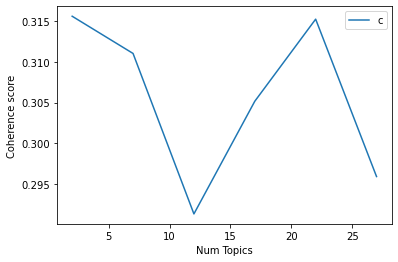

In [103]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [104]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3156
index: 1 | Num Topics = 7  has Coherence Value of 0.3111
index: 2 | Num Topics = 12  has Coherence Value of 0.2913
index: 3 | Num Topics = 17  has Coherence Value of 0.3052
index: 4 | Num Topics = 22  has Coherence Value of 0.3153
index: 5 | Num Topics = 27  has Coherence Value of 0.2959


In [105]:
# Select optimal number of topics
optimal_model_ph_score5 = model_list_ph_score5[4]

In [106]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score5 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score5, corpus_ph_score5, id2word_ph_score5)

In [107]:
print("pyLDAVis for ph topics for score=5:")
vis_ph_score5

pyLDAVis for ph topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.232570 -0.016416       1        1  9.092387
9     -0.135944  0.062433       2        1  8.836744
6     -0.067969  0.034671       3        1  7.555258
17    -0.058075 -0.013556       4        1  6.886059
18    -0.005510  0.032740       5        1  6.436648
10    -0.000588 -0.043024       6        1  6.380684
19     0.000972 -0.244959       7        1  6.095239
5     -0.102138  0.004763       8        1  5.010593
0     -0.014536  0.045984       9        1  4.821508
7     -0.058605  0.045915      10        1  4.382085
20     0.053209  0.073386      11        1  4.210509
2      0.012089  0.004707      12        1  4.148759
13     0.062992 -0.128380      13        1  3.966228
12     0.093147 -0.077027      14        1  3.738815
1     -0.037495 -0.050500      15        1  3.409297
4      0.053152 -0.032958      16        1  3.258655
3      0.036818  0.037384      17        1  3.135320
8      0.035573  0.014369      18        1  2.397674
15     0.083260 -0.028032      19        1  2.391637
21     0.092790  0.115564      20        1  1.935192
11     0.144314  0.040408      21        1  1.119837
14     0.045113  0.122529      22        1  0.790873, topic_info=         Term        Freq       Total Category  logprob  loglift
47      photo   73.000000   73.000000  Default  30.0000  30.0000
25       post  132.000000  132.000000  Default  29.0000  29.0000
2         app  151.000000  151.000000  Default  28.0000  28.0000
92  highlight   32.000000   32.000000  Default  27.0000  27.0000
72     really   60.000000   60.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
27      video    0.584643   43.428589  Topic22  -4.5640   0.5319
15      still    1.143922   97.920958  Topic22  -3.8928   0.3901
3      delete    0.584664   53.819414  Topic22  -4.5639   0.3174
18       time    0.584663   52.110219  Topic22  -4.5639   0.3497
50    problem    0.584663   65.747392  Topic22  -4.5639   0.1172

[1379 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
791      17  0.616816     abd
147       1  0.042089    able
147       2  0.042089    able
147       4  0.252534    able
147       7  0.084178    able
...     ...       ...     ...
1122     15  0.617930   yucky
964       5  0.593791  zenith
59        1  0.584215    zoom
59        6  0.194738    zoom
59       19  0.194738    zoom

[2551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 10, 7, 18, 19, 11, 20, 6, 1, 8, 21, 3, 14, 13, 2, 5, 4, 9, 16, 22, 12, 15])

## LDA Topic Modelling (Rating = 1,2,3)

In [108]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_ph_score1N2N3 = instagram_ios_ph_review_YearMonth_score1N2N3.review.values.tolist()
review_words_ph_score1N2N3 = list(sent_to_words(review_ph_score1N2N3))
print(review_words_ph_score1N2N3[:1])

[['hi', 'instagram', 'don', 'know', 'what', 'happening', 'lately', 'that', 'whatever', 'do', 'posting', 'on', 'account', 'stories', 'or', 'following', 'accounts', 'on', 'this', 'certain', 'account', 'mainly', 'use', 'goes', 'to', 'the', 'other', 'account', 'and', 'it', 'troublesome', 'especially', 'dont', 'want', 'this', 'content', 'to', 'be', 'seen', 'by', 'others', 'please', 'fix', 'it', 'it', 'seems', 'like', 'bug', 'reinstalling', 'it', 'to', 'see', 'if', 'there', 'anything', 'that', 'will', 'change', 'thank', 'you']]


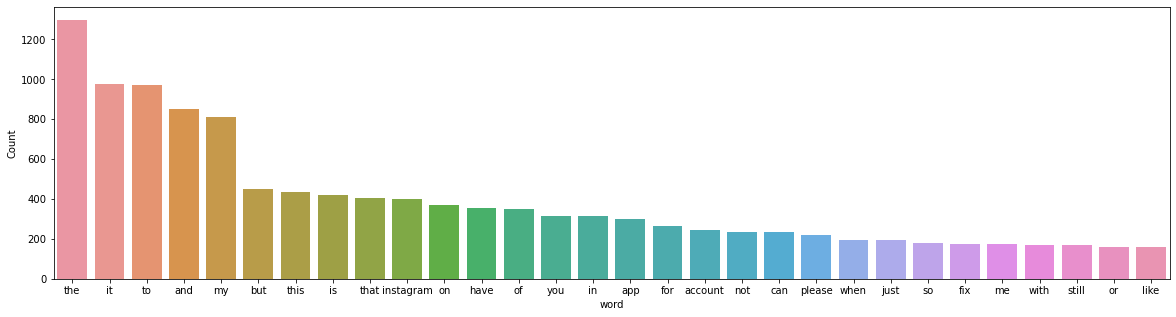

In [109]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1N2N3))

In [110]:
# Clean text
review_ph_ready_score1N2N3 = process_words(review_words_ph_score1N2N3)  # processed Text Data! - move to each section

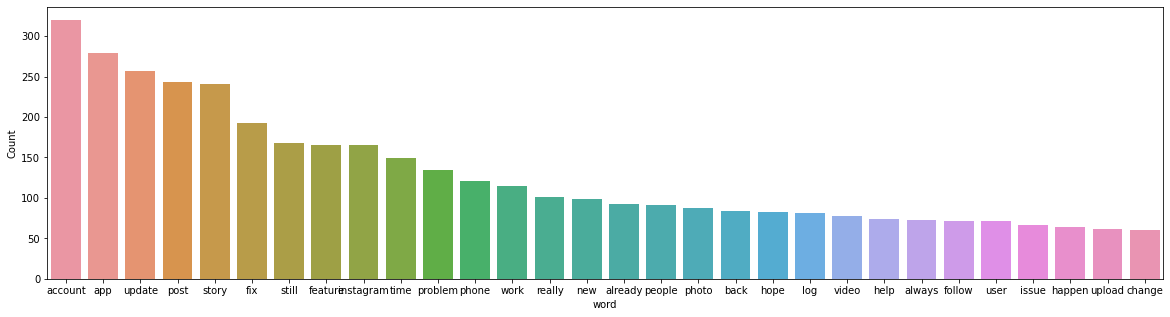

In [111]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1N2N3))


In [112]:
# Create Dictionary
id2word_ph_score1N2N3 = corpora.Dictionary(review_ph_ready_score1N2N3)

2021-10-16 02:19:18,608 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:19:18,675 [INFO] gensim.corpora.dictionary - built Dictionary(1581 unique tokens: ['account', 'bug', 'certain', 'change', 'content']...) from 441 documents (total 11685 corpus positions)
2021-10-16 02:19:18,678 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1581 unique tokens: ['account', 'bug', 'certain', 'change', 'content']...) from 441 documents (total 11685 corpus positions)", 'datetime': '2021-10-16T02:19:18.678316', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [113]:
# Create Corpus: Term Document Frequency
corpus_ph_score1N2N3 = [id2word_ph_score1N2N3.doc2bow(text) for text in review_ph_ready_score1N2N3]

In [114]:
# Training LDA model
model_list_ph_score1N2N3, coherence_values_ph_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_score1N2N3, corpus=corpus_ph_score1N2N3, 
                                                              texts=review_ph_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:19:18,748 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:19:18,751 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:19:18,754 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:19:18,759 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 441 documents, updating model once every 441 documents, evaluating perplexity every 441 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:19:20,500 [INFO] gensim.models.ldamodel - -7.867 per-word bound, 233.5 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:19:20,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #441/441
2021-10-16 02:19:21,858 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.019*"update" + 0.016*"app" + 0.015*"story" + 0.012*"fix" + 0.012*"problem" + 0.011*"in

2021-10-16 02:19:41,860 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"account" + 0.025*"app" + 0.022*"story" + 0.021*"update" + 0.019*"feature" + 0.018*"fix" + 0.017*"still" + 0.016*"instagram" + 0.013*"time" + 0.013*"problem"
2021-10-16 02:19:41,862 [INFO] gensim.models.ldamodel - topic diff=0.015705, rho=0.301511
2021-10-16 02:19:42,758 [INFO] gensim.models.ldamodel - -6.368 per-word bound, 82.6 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:19:42,760 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #441/441
2021-10-16 02:19:43,532 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"post" + 0.017*"update" + 0.014*"app" + 0.013*"story" + 0.012*"really" + 0.010*"back" + 0.009*"user" + 0.009*"photo" + 0.009*"fix" + 0.008*"people"
2021-10-16 02:19:43,535 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"account" + 0.025*"app" + 0.022*"story" + 0.021*"update" + 0.019*"feature" + 0.018*"fix" + 0.018*"still

2021-10-16 02:20:02,009 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"account" + 0.026*"app" + 0.022*"story" + 0.022*"update" + 0.019*"fix" + 0.019*"feature" + 0.018*"still" + 0.016*"instagram" + 0.014*"problem" + 0.014*"time"
2021-10-16 02:20:02,010 [INFO] gensim.models.ldamodel - topic diff=0.009277, rho=0.218218
2021-10-16 02:20:03,002 [INFO] gensim.models.ldamodel - -6.360 per-word bound, 82.2 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:20:03,004 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #441/441
2021-10-16 02:20:03,808 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"post" + 0.016*"update" + 0.013*"app" + 0.012*"really" + 0.012*"story" + 0.010*"back" + 0.009*"user" + 0.009*"follow" + 0.009*"people" + 0.009*"photo"
2021-10-16 02:20:03,868 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"account" + 0.026*"app" + 0.022*"story" + 0.022*"update" + 0.019*"fix" + 0.019*"feature" + 0.018*"st

2021-10-16 02:20:19,940 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"account" + 0.026*"app" + 0.022*"update" + 0.022*"story" + 0.019*"fix" + 0.019*"still" + 0.018*"feature" + 0.016*"instagram" + 0.015*"problem" + 0.014*"time"
2021-10-16 02:20:19,944 [INFO] gensim.models.ldamodel - topic diff=0.006828, rho=0.179605
2021-10-16 02:20:20,854 [INFO] gensim.models.ldamodel - -6.356 per-word bound, 81.9 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:20:20,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #441/441
2021-10-16 02:20:21,497 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.015*"update" + 0.013*"really" + 0.012*"app" + 0.012*"story" + 0.010*"back" + 0.010*"follow" + 0.010*"user" + 0.009*"people" + 0.009*"photo"
2021-10-16 02:20:21,505 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"account" + 0.026*"app" + 0.022*"update" + 0.022*"story" + 0.019*"fix" + 0.019*"still" + 0.018*"feat

2021-10-16 02:20:36,253 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"account" + 0.027*"app" + 0.022*"update" + 0.022*"story" + 0.020*"fix" + 0.019*"still" + 0.018*"feature" + 0.016*"instagram" + 0.015*"problem" + 0.014*"time"
2021-10-16 02:20:36,265 [INFO] gensim.models.ldamodel - topic diff=0.005989, rho=0.156174
2021-10-16 02:20:37,198 [INFO] gensim.models.ldamodel - -6.352 per-word bound, 81.7 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:20:37,200 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #441/441
2021-10-16 02:20:37,888 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.015*"update" + 0.013*"really" + 0.012*"app" + 0.011*"story" + 0.010*"back" + 0.010*"follow" + 0.010*"people" + 0.010*"user" + 0.008*"photo"
2021-10-16 02:20:37,890 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"account" + 0.027*"app" + 0.022*"update" + 0.022*"story" + 0.020*"fix" + 0.019*"still" + 0.018*"feat

2021-10-16 02:20:52,570 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"account" + 0.027*"app" + 0.022*"update" + 0.022*"story" + 0.020*"fix" + 0.019*"still" + 0.018*"feature" + 0.016*"instagram" + 0.015*"problem" + 0.014*"time"
2021-10-16 02:20:52,572 [INFO] gensim.models.ldamodel - topic diff=0.004961, rho=0.140028
2021-10-16 02:20:52,575 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1581, num_topics=2, decay=0.5, chunksize=1000) in 93.82s', 'datetime': '2021-10-16T02:20:52.575231', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:20:52,580 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:20:56,670 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
202

2021-10-16 02:21:05,893 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"follow" + 0.024*"app" + 0.021*"account" + 0.020*"still" + 0.016*"time" + 0.015*"update" + 0.012*"block" + 0.010*"people" + 0.009*"user" + 0.009*"download"
2021-10-16 02:21:05,906 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"app" + 0.023*"story" + 0.021*"fix" + 0.021*"post" + 0.020*"update" + 0.012*"really" + 0.012*"time" + 0.010*"account" + 0.010*"instagram" + 0.009*"hope"
2021-10-16 02:21:05,910 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.058*"account" + 0.025*"feature" + 0.024*"app" + 0.022*"story" + 0.021*"update" + 0.019*"instagram" + 0.018*"fix" + 0.017*"still" + 0.016*"post" + 0.015*"problem"
2021-10-16 02:21:05,912 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"post" + 0.024*"app" + 0.023*"story" + 0.020*"still" + 0.018*"work" + 0.016*"update" + 0.014*"instagram" + 0.014*"account" + 0.013*"fix" + 0.013*"screen"
2021-10-16 02:21:05,913 [INFO] gensim.models.ldamodel - top

2021-10-16 02:21:13,132 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"follow" + 0.024*"app" + 0.020*"account" + 0.018*"still" + 0.017*"block" + 0.016*"time" + 0.014*"update" + 0.011*"people" + 0.011*"user" + 0.010*"action"
2021-10-16 02:21:13,134 [INFO] gensim.models.ldamodel - topic diff=0.031128, rho=0.301511
2021-10-16 02:21:13,916 [INFO] gensim.models.ldamodel - -6.554 per-word bound, 94.0 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:21:13,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #441/441
2021-10-16 02:21:14,556 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"app" + 0.023*"story" + 0.022*"post" + 0.022*"fix" + 0.020*"update" + 0.012*"really" + 0.011*"time" + 0.010*"crash" + 0.010*"hope" + 0.009*"instagram"
2021-10-16 02:21:14,558 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"post" + 0.021*"update" + 0.016*"suggest" + 0.014*"story" + 0.013*"user" + 0.013*"phone" + 0.013*"really

2021-10-16 02:21:21,777 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"account" + 0.026*"feature" + 0.023*"app" + 0.023*"story" + 0.023*"update" + 0.020*"still" + 0.020*"fix" + 0.019*"instagram" + 0.017*"problem" + 0.016*"post"
2021-10-16 02:21:21,789 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"post" + 0.021*"update" + 0.017*"suggest" + 0.013*"user" + 0.013*"really" + 0.013*"story" + 0.013*"phone" + 0.012*"instagram" + 0.011*"back" + 0.009*"feed"
2021-10-16 02:21:21,804 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"app" + 0.024*"story" + 0.023*"post" + 0.022*"fix" + 0.020*"update" + 0.012*"really" + 0.011*"time" + 0.011*"crash" + 0.010*"always" + 0.009*"hope"
2021-10-16 02:21:21,808 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"app" + 0.023*"post" + 0.022*"story" + 0.019*"work" + 0.016*"still" + 0.015*"screen" + 0.014*"update" + 0.014*"version" + 0.013*"instagram" + 0.012*"video"
2021-10-16 02:21:21,815 [INFO] gensim.models.ldamodel - topic 

2021-10-16 02:21:28,817 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"follow" + 0.023*"block" + 0.022*"app" + 0.021*"account" + 0.017*"still" + 0.016*"time" + 0.013*"people" + 0.013*"action" + 0.012*"update" + 0.011*"user"
2021-10-16 02:21:28,820 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.024*"story" + 0.023*"post" + 0.022*"fix" + 0.020*"update" + 0.012*"really" + 0.011*"crash" + 0.011*"time" + 0.010*"instagram" + 0.010*"always"
2021-10-16 02:21:28,821 [INFO] gensim.models.ldamodel - topic diff=0.009238, rho=0.213201
2021-10-16 02:21:29,649 [INFO] gensim.models.ldamodel - -6.535 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:21:29,651 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #441/441
2021-10-16 02:21:30,212 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"account" + 0.027*"feature" + 0.024*"update" + 0.023*"app" + 0.023*"story" + 0.021*"still" + 0.020*"fi

2021-10-16 02:21:37,778 [INFO] gensim.models.ldamodel - -6.531 per-word bound, 92.5 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:21:37,783 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #441/441
2021-10-16 02:21:38,462 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"feature" + 0.014*"put" + 0.010*"translate" + 0.009*"well" + 0.009*"caption" + 0.009*"filter" + 0.007*"video" + 0.007*"back" + 0.007*"message" + 0.007*"help"
2021-10-16 02:21:38,464 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.034*"app" + 0.023*"story" + 0.023*"post" + 0.022*"fix" + 0.020*"update" + 0.012*"really" + 0.011*"crash" + 0.011*"time" + 0.010*"phone" + 0.010*"instagram"
2021-10-16 02:21:38,465 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"post" + 0.021*"update" + 0.018*"suggest" + 0.014*"really" + 0.014*"user" + 0.013*"story" + 0.012*"phone" + 0.011*"back" + 0.011*"instagram" + 0.010*"follow"
2021-10-16 02:21:38,467 [INFO] 

2021-10-16 02:21:44,952 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"account" + 0.028*"feature" + 0.025*"update" + 0.023*"app" + 0.023*"story" + 0.021*"still" + 0.020*"instagram" + 0.020*"fix" + 0.019*"problem" + 0.015*"phone"
2021-10-16 02:21:44,955 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"post" + 0.022*"update" + 0.018*"suggest" + 0.014*"really" + 0.014*"user" + 0.013*"story" + 0.012*"phone" + 0.012*"back" + 0.011*"instagram" + 0.010*"follow"
2021-10-16 02:21:44,957 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.034*"app" + 0.023*"story" + 0.023*"post" + 0.022*"fix" + 0.020*"update" + 0.012*"really" + 0.011*"crash" + 0.010*"time" + 0.010*"phone" + 0.010*"instagram"
2021-10-16 02:21:44,958 [INFO] gensim.models.ldamodel - topic diff=0.005594, rho=0.174078
2021-10-16 02:21:45,702 [INFO] gensim.models.ldamodel - -6.526 per-word bound, 92.2 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:21:45,708 [INFO] gensi

2021-10-16 02:21:52,035 [INFO] gensim.models.ldamodel - topic diff=0.004706, rho=0.162221
2021-10-16 02:21:52,816 [INFO] gensim.models.ldamodel - -6.523 per-word bound, 92.0 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:21:52,818 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #441/441
2021-10-16 02:21:53,406 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"account" + 0.028*"feature" + 0.025*"update" + 0.023*"app" + 0.023*"story" + 0.021*"still" + 0.020*"instagram" + 0.020*"fix" + 0.019*"problem" + 0.015*"phone"
2021-10-16 02:21:53,408 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"upload" + 0.022*"photo" + 0.020*"update" + 0.018*"post" + 0.017*"video" + 0.016*"story" + 0.014*"change" + 0.011*"time" + 0.010*"picture" + 0.010*"fix"
2021-10-16 02:21:53,409 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"app" + 0.023*"story" + 0.023*"post" + 0.022*"fix" + 0.021*"update" + 0.012*"really" + 0.011*"cra

2021-10-16 02:22:00,045 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"account" + 0.028*"feature" + 0.025*"update" + 0.023*"story" + 0.023*"app" + 0.021*"still" + 0.020*"instagram" + 0.020*"fix" + 0.019*"problem" + 0.016*"log"
2021-10-16 02:22:00,047 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"feature" + 0.014*"put" + 0.011*"translate" + 0.009*"caption" + 0.009*"well" + 0.009*"filter" + 0.007*"video" + 0.007*"message" + 0.007*"show" + 0.007*"focus"
2021-10-16 02:22:00,051 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"app" + 0.023*"post" + 0.023*"story" + 0.022*"fix" + 0.021*"update" + 0.012*"really" + 0.011*"crash" + 0.011*"check" + 0.011*"phone" + 0.010*"instagram"
2021-10-16 02:22:00,054 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"app" + 0.024*"post" + 0.021*"story" + 0.017*"work" + 0.017*"screen" + 0.014*"version" + 0.013*"still" + 0.013*"instagram" + 0.013*"video" + 0.012*"view"
2021-10-16 02:22:00,058 [INFO] gensim.models.ldamodel - t

2021-10-16 02:22:06,780 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"account" + 0.028*"feature" + 0.025*"update" + 0.023*"story" + 0.023*"app" + 0.021*"still" + 0.020*"instagram" + 0.019*"fix" + 0.019*"problem" + 0.016*"log"
2021-10-16 02:22:06,783 [INFO] gensim.models.ldamodel - topic diff=0.003368, rho=0.142857
2021-10-16 02:22:07,540 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:22:07,543 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #441/441
2021-10-16 02:22:08,163 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"account" + 0.028*"feature" + 0.025*"update" + 0.023*"story" + 0.023*"app" + 0.021*"still" + 0.020*"instagram" + 0.019*"fix" + 0.019*"problem" + 0.016*"log"
2021-10-16 02:22:08,165 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"upload" + 0.022*"photo" + 0.020*"update" + 0.018*"post" + 0.017*"video" + 0.016*"story" + 0.01

2021-10-16 02:22:20,923 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.033*"upload" + 0.029*"update" + 0.024*"photo" + 0.019*"app" + 0.018*"story" + 0.016*"video" + 0.015*"work" + 0.014*"problem" + 0.014*"post" + 0.013*"new"
2021-10-16 02:22:20,925 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.026*"app" + 0.025*"time" + 0.025*"fix" + 0.023*"update" + 0.013*"post" + 0.012*"instagram" + 0.012*"account" + 0.012*"feature" + 0.011*"problem" + 0.011*"still"
2021-10-16 02:22:20,927 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.041*"feature" + 0.029*"story" + 0.020*"still" + 0.019*"update" + 0.017*"app" + 0.015*"fix" + 0.012*"add" + 0.011*"already" + 0.011*"option" + 0.010*"instagram"
2021-10-16 02:22:20,928 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.033*"app" + 0.027*"story" + 0.025*"post" + 0.021*"update" + 0.021*"account" + 0.017*"really" + 0.016*"fix" + 0.012*"time" + 0.010*"instagram" + 0.009*"back"
2021-10-16 02:22:20,929 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:22:27,939 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.044*"feature" + 0.029*"story" + 0.020*"still" + 0.019*"update" + 0.016*"app" + 0.015*"fix" + 0.012*"add" + 0.012*"option" + 0.012*"already" + 0.011*"problem"
2021-10-16 02:22:27,941 [INFO] gensim.models.ldamodel - topic diff=0.065653, rho=0.333333
2021-10-16 02:22:28,703 [INFO] gensim.models.ldamodel - -6.663 per-word bound, 101.3 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:22:28,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #441/441
2021-10-16 02:22:29,271 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"post" + 0.019*"instagram" + 0.019*"back" + 0.016*"feature" + 0.014*"quality" + 0.011*"update" + 0.011*"change" + 0.011*"old" + 0.010*"activity" + 0.010*"guideline"
2021-10-16 02:22:29,273 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.044*"feature" + 0.029*"story" + 0.020*"still" + 0.019*"update" + 0.016*"app" + 0.015*"fix" + 0

2021-10-16 02:22:36,595 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.039*"post" + 0.020*"phone" + 0.019*"log" + 0.016*"app" + 0.016*"feed" + 0.014*"delete" + 0.013*"instagram" + 0.013*"account" + 0.013*"problem" + 0.012*"suggest"
2021-10-16 02:22:36,650 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"post" + 0.018*"instagram" + 0.018*"back" + 0.015*"feature" + 0.013*"quality" + 0.011*"update" + 0.011*"old" + 0.011*"activity" + 0.011*"guideline" + 0.011*"change"
2021-10-16 02:22:36,665 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.024*"app" + 0.023*"issue" + 0.023*"still" + 0.020*"day" + 0.020*"account" + 0.020*"follow" + 0.018*"email" + 0.016*"open" + 0.014*"report" + 0.014*"work"
2021-10-16 02:22:36,667 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.019*"send" + 0.018*"video" + 0.016*"error" + 0.013*"email" + 0.010*"object" + 0.010*"story" + 0.009*"reset" + 0.009*"password" + 0.008*"internet" + 0.008*"connection"
2021-10-16 02:22:36,669 [INFO] gensim.models.

2021-10-16 02:22:43,451 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.019*"send" + 0.018*"video" + 0.016*"error" + 0.013*"email" + 0.010*"object" + 0.010*"story" + 0.009*"reset" + 0.009*"disappointing" + 0.009*"password" + 0.008*"internet"
2021-10-16 02:22:43,454 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.028*"update" + 0.023*"music" + 0.021*"account" + 0.021*"people" + 0.018*"instagram" + 0.017*"always" + 0.017*"story" + 0.016*"still" + 0.013*"region" + 0.013*"available"
2021-10-16 02:22:43,456 [INFO] gensim.models.ldamodel - topic diff=0.011560, rho=0.223607
2021-10-16 02:22:44,107 [INFO] gensim.models.ldamodel - -6.634 per-word bound, 99.3 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:22:44,108 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #441/441
2021-10-16 02:22:44,658 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.027*"app" + 0.026*"time" + 0.026*"update" + 0.025*"fix" + 0.015*"post" + 0.012*

2021-10-16 02:22:50,706 [INFO] gensim.models.ldamodel - -6.629 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:22:50,707 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #441/441
2021-10-16 02:22:51,301 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"post" + 0.019*"back" + 0.017*"instagram" + 0.015*"feature" + 0.012*"quality" + 0.011*"activity" + 0.011*"guideline" + 0.011*"everytime" + 0.011*"old" + 0.011*"change"
2021-10-16 02:22:51,302 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.031*"post" + 0.026*"story" + 0.023*"version" + 0.019*"update" + 0.017*"still" + 0.015*"account" + 0.014*"click" + 0.013*"instagram" + 0.013*"ipad" + 0.011*"screen"
2021-10-16 02:22:51,306 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.047*"feature" + 0.031*"story" + 0.022*"update" + 0.021*"still" + 0.016*"app" + 0.016*"fix" + 0.014*"add" + 0.014*"problem" + 0.013*"option" + 0.012*"already"
2021-10-16 02:22:

2021-10-16 02:22:58,074 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.082*"account" + 0.030*"feature" + 0.027*"story" + 0.022*"update" + 0.021*"instagram" + 0.021*"still" + 0.020*"fix" + 0.019*"app" + 0.018*"new" + 0.016*"problem"
2021-10-16 02:22:58,076 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.048*"feature" + 0.031*"story" + 0.022*"update" + 0.021*"still" + 0.016*"app" + 0.016*"fix" + 0.014*"add" + 0.014*"problem" + 0.013*"option" + 0.012*"already"
2021-10-16 02:22:58,080 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.027*"app" + 0.026*"time" + 0.026*"update" + 0.025*"fix" + 0.015*"post" + 0.012*"block" + 0.012*"like" + 0.011*"problem" + 0.011*"still" + 0.010*"instagram"
2021-10-16 02:22:58,082 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.027*"app" + 0.027*"post" + 0.022*"phone" + 0.016*"follow" + 0.015*"open" + 0.012*"time" + 0.012*"work" + 0.012*"people" + 0.012*"happen" + 0.012*"instagram"
2021-10-16 02:22:58,084 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:23:04,862 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.024*"account" + 0.024*"email" + 0.023*"issue" + 0.023*"still" + 0.023*"app" + 0.022*"follow" + 0.021*"day" + 0.018*"open" + 0.015*"report" + 0.013*"work"
2021-10-16 02:23:04,868 [INFO] gensim.models.ldamodel - topic diff=0.004489, rho=0.166667
2021-10-16 02:23:05,543 [INFO] gensim.models.ldamodel - -6.621 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:23:05,544 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #441/441
2021-10-16 02:23:06,100 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.027*"app" + 0.026*"time" + 0.026*"update" + 0.025*"fix" + 0.016*"post" + 0.012*"block" + 0.012*"like" + 0.011*"still" + 0.011*"problem" + 0.010*"instagram"
2021-10-16 02:23:06,174 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.027*"app" + 0.027*"post" + 0.022*"phone" + 0.016*"follow" + 0.015*"open" + 0.012*"time" + 0.012*"work" + 0.012

2021-10-16 02:23:12,710 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.031*"post" + 0.024*"version" + 0.023*"story" + 0.019*"update" + 0.017*"still" + 0.015*"account" + 0.015*"click" + 0.013*"ipad" + 0.013*"instagram" + 0.011*"screen"
2021-10-16 02:23:12,711 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.027*"app" + 0.026*"time" + 0.026*"update" + 0.025*"fix" + 0.016*"post" + 0.013*"block" + 0.012*"like" + 0.011*"still" + 0.011*"problem" + 0.010*"instagram"
2021-10-16 02:23:12,714 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"post" + 0.019*"instagram" + 0.019*"back" + 0.015*"feature" + 0.012*"quality" + 0.011*"activity" + 0.011*"guideline" + 0.011*"everytime" + 0.011*"old" + 0.010*"change"
2021-10-16 02:23:12,716 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.027*"app" + 0.027*"post" + 0.022*"phone" + 0.016*"follow" + 0.016*"open" + 0.012*"time" + 0.012*"save" + 0.012*"people" + 0.012*"happen" + 0.012*"photo"
2021-10-16 02:23:12,719 [INFO] gensim.models.ldamo

2021-10-16 02:23:19,965 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.027*"app" + 0.027*"post" + 0.022*"phone" + 0.016*"follow" + 0.016*"open" + 0.012*"save" + 0.012*"time" + 0.012*"people" + 0.012*"happen" + 0.012*"photo"
2021-10-16 02:23:19,981 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.019*"post" + 0.019*"instagram" + 0.018*"back" + 0.015*"feature" + 0.011*"quality" + 0.011*"guideline" + 0.011*"activity" + 0.011*"everytime" + 0.011*"old" + 0.011*"change"
2021-10-16 02:23:20,003 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"app" + 0.030*"story" + 0.026*"post" + 0.019*"update" + 0.019*"really" + 0.017*"account" + 0.016*"fix" + 0.011*"back" + 0.011*"friend" + 0.010*"time"
2021-10-16 02:23:20,010 [INFO] gensim.models.ldamodel - topic diff=0.002944, rho=0.145865
2021-10-16 02:23:20,722 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:23:20,723 [INFO] gensim.

2021-10-16 02:23:32,416 [INFO] gensim.models.ldamodel - -11.614 per-word bound, 3133.7 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:23:32,418 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #441/441
2021-10-16 02:23:33,571 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"account" + 0.029*"app" + 0.027*"still" + 0.024*"problem" + 0.024*"update" + 0.019*"feature" + 0.019*"story" + 0.018*"fix" + 0.017*"time" + 0.017*"work"
2021-10-16 02:23:33,572 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.016*"time" + 0.016*"video" + 0.015*"log" + 0.013*"feature" + 0.011*"fix" + 0.010*"story" + 0.010*"instagram" + 0.009*"issue" + 0.009*"account" + 0.009*"instastory"
2021-10-16 02:23:33,574 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.027*"instagram" + 0.018*"post" + 0.018*"follower" + 0.016*"account" + 0.016*"feature" + 0.013*"profile" + 0.012*"different" + 0.012*"guideline" + 0.012*"update" + 0.011*"issue"
2021-10-16

2021-10-16 02:23:40,221 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.060*"upload" + 0.028*"photo" + 0.026*"video" + 0.024*"story" + 0.020*"update" + 0.016*"quality" + 0.015*"image" + 0.015*"instagram" + 0.014*"really" + 0.012*"problem"
2021-10-16 02:23:40,223 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.034*"account" + 0.031*"app" + 0.020*"open" + 0.017*"follow" + 0.014*"still" + 0.012*"post" + 0.011*"user" + 0.010*"issue" + 0.010*"people" + 0.010*"follower"
2021-10-16 02:23:40,226 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.025*"story" + 0.024*"app" + 0.020*"post" + 0.018*"feature" + 0.018*"photo" + 0.016*"still" + 0.012*"button" + 0.012*"help" + 0.011*"phone" + 0.011*"fix"
2021-10-16 02:23:40,227 [INFO] gensim.models.ldamodel - topic diff=0.131597, rho=0.377964
2021-10-16 02:23:40,858 [INFO] gensim.models.ldamodel - -6.760 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:23:40,860 [INFO] gensim.

2021-10-16 02:23:46,124 [INFO] gensim.models.ldamodel - topic diff=0.042586, rho=0.288675
2021-10-16 02:23:46,908 [INFO] gensim.models.ldamodel - -6.722 per-word bound, 105.6 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:23:46,915 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #441/441
2021-10-16 02:23:47,456 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.044*"account" + 0.037*"still" + 0.037*"update" + 0.033*"app" + 0.032*"feature" + 0.026*"problem" + 0.023*"fix" + 0.022*"time" + 0.022*"story" + 0.018*"new"
2021-10-16 02:23:47,458 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.023*"people" + 0.021*"feature" + 0.019*"update" + 0.018*"post" + 0.016*"story" + 0.016*"like" + 0.015*"photo" + 0.014*"app" + 0.013*"especially" + 0.012*"friend"
2021-10-16 02:23:47,459 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.025*"post" + 0.022*"update" + 0.016*"story" + 0.014*"follow" + 0.012*"way" + 0.012*"day" + 0.011*"i

2021-10-16 02:23:53,953 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.070*"account" + 0.024*"story" + 0.021*"feature" + 0.019*"post" + 0.018*"phone" + 0.018*"instagram" + 0.015*"fix" + 0.015*"app" + 0.014*"new" + 0.012*"issue"
2021-10-16 02:23:53,954 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.030*"account" + 0.020*"filter" + 0.015*"log" + 0.015*"put" + 0.015*"user" + 0.015*"cellular" + 0.011*"always" + 0.010*"photo" + 0.010*"well" + 0.010*"feature"
2021-10-16 02:23:53,956 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.044*"account" + 0.038*"update" + 0.037*"still" + 0.033*"app" + 0.033*"feature" + 0.026*"problem" + 0.023*"time" + 0.022*"fix" + 0.021*"story" + 0.018*"new"
2021-10-16 02:23:53,958 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.026*"block" + 0.026*"fix" + 0.024*"app" + 0.018*"time" + 0.013*"update" + 0.013*"action" + 0.013*"account" + 0.013*"like" + 0.012*"hope" + 0.012*"instagram"
2021-10-16 02:23:53,959 [INFO] gensim.models.ldamodel - topic di

2021-10-16 02:24:00,454 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.058*"upload" + 0.048*"video" + 0.031*"story" + 0.029*"photo" + 0.028*"quality" + 0.018*"update" + 0.016*"image" + 0.015*"fix" + 0.014*"instagram" + 0.013*"hope"
2021-10-16 02:24:00,455 [INFO] gensim.models.ldamodel - topic diff=0.010301, rho=0.208514
2021-10-16 02:24:01,193 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:24:01,195 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #441/441
2021-10-16 02:24:01,715 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.022*"app" + 0.021*"photo" + 0.021*"post" + 0.017*"story" + 0.015*"feature" + 0.013*"button" + 0.013*"crash" + 0.013*"still" + 0.012*"help" + 0.011*"person"
2021-10-16 02:24:01,717 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.034*"app" + 0.032*"account" + 0.028*"open" + 0.017*"follow" + 0.015*"issue" + 0.014*"still" + 0.012*"wo

2021-10-16 02:24:07,746 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.022*"app" + 0.021*"photo" + 0.021*"post" + 0.015*"story" + 0.015*"feature" + 0.014*"button" + 0.013*"crash" + 0.013*"still" + 0.012*"help" + 0.011*"person"
2021-10-16 02:24:07,754 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"app" + 0.037*"update" + 0.020*"time" + 0.020*"download" + 0.019*"still" + 0.018*"phone" + 0.015*"problem" + 0.014*"already" + 0.013*"fix" + 0.013*"account"
2021-10-16 02:24:07,757 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"story" + 0.033*"post" + 0.027*"app" + 0.021*"really" + 0.018*"fix" + 0.014*"update" + 0.014*"account" + 0.012*"people" + 0.012*"share" + 0.011*"show"
2021-10-16 02:24:07,760 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"post" + 0.021*"log" + 0.019*"update" + 0.019*"app" + 0.016*"picture" + 0.015*"phone" + 0.014*"really" + 0.014*"problem" + 0.014*"feed" + 0.013*"delete"
2021-10-16 02:24:07,761 [INFO] gensim.models.ldamodel - topic #10 

2021-10-16 02:24:14,332 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"story" + 0.033*"post" + 0.027*"app" + 0.021*"really" + 0.018*"fix" + 0.014*"update" + 0.014*"account" + 0.012*"people" + 0.012*"share" + 0.011*"show"
2021-10-16 02:24:14,334 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.027*"block" + 0.026*"fix" + 0.024*"app" + 0.018*"time" + 0.014*"action" + 0.014*"like" + 0.013*"update" + 0.012*"hope" + 0.012*"instagram" + 0.012*"account"
2021-10-16 02:24:14,336 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.040*"post" + 0.024*"story" + 0.018*"update" + 0.016*"app" + 0.016*"account" + 0.015*"work" + 0.013*"still" + 0.013*"picture" + 0.013*"already" + 0.012*"instagram"
2021-10-16 02:24:14,338 [INFO] gensim.models.ldamodel - topic diff=0.005058, rho=0.171499
2021-10-16 02:24:15,071 [INFO] gensim.models.ldamodel - -6.686 per-word bound, 103.0 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:24:15,078 [INFO] gensim.mo

2021-10-16 02:24:20,550 [INFO] gensim.models.ldamodel - topic diff=0.004073, rho=0.160128
2021-10-16 02:24:21,320 [INFO] gensim.models.ldamodel - -6.683 per-word bound, 102.7 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:24:21,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #441/441
2021-10-16 02:24:21,866 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"post" + 0.022*"log" + 0.019*"update" + 0.018*"app" + 0.016*"picture" + 0.015*"phone" + 0.014*"feed" + 0.014*"problem" + 0.014*"really" + 0.013*"delete"
2021-10-16 02:24:21,868 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"app" + 0.037*"update" + 0.021*"download" + 0.020*"time" + 0.019*"still" + 0.019*"phone" + 0.015*"problem" + 0.014*"already" + 0.014*"account" + 0.013*"fix"
2021-10-16 02:24:21,869 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.025*"post" + 0.016*"update" + 0.015*"follow" + 0.014*"story" + 0.012*"way" + 0.012*"instagram" + 0.0

2021-10-16 02:24:28,268 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.035*"open" + 0.034*"app" + 0.032*"account" + 0.026*"issue" + 0.016*"follow" + 0.014*"read" + 0.014*"still" + 0.013*"work" + 0.011*"user" + 0.010*"follower"
2021-10-16 02:24:28,276 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.020*"video" + 0.016*"log" + 0.014*"error" + 0.014*"request" + 0.014*"sorry" + 0.014*"platform" + 0.013*"allow" + 0.011*"issue" + 0.011*"story" + 0.010*"connection"
2021-10-16 02:24:28,321 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.022*"people" + 0.022*"feature" + 0.019*"post" + 0.019*"update" + 0.017*"like" + 0.014*"story" + 0.014*"app" + 0.014*"photo" + 0.014*"especially" + 0.012*"follow"
2021-10-16 02:24:28,334 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.057*"video" + 0.054*"upload" + 0.032*"story" + 0.027*"quality" + 0.026*"photo" + 0.017*"update" + 0.016*"fix" + 0.016*"image" + 0.015*"well" + 0.014*"instagram"
2021-10-16 02:24:28,335 [INFO] gensim.models.ldamode

2021-10-16 02:24:34,609 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"app" + 0.037*"update" + 0.022*"download" + 0.020*"time" + 0.019*"still" + 0.019*"phone" + 0.015*"problem" + 0.014*"already" + 0.014*"account" + 0.013*"fix"
2021-10-16 02:24:34,611 [INFO] gensim.models.ldamodel - topic diff=0.002836, rho=0.141421
2021-10-16 02:24:35,319 [INFO] gensim.models.ldamodel - -6.677 per-word bound, 102.3 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:24:35,321 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #441/441
2021-10-16 02:24:35,810 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.077*"account" + 0.024*"story" + 0.021*"feature" + 0.021*"instagram" + 0.021*"post" + 0.017*"phone" + 0.014*"fix" + 0.013*"really" + 0.012*"new" + 0.011*"happen"
2021-10-16 02:24:35,811 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.022*"people" + 0.022*"feature" + 0.019*"post" + 0.019*"update" + 0.017*"like" + 0.014*"story" + 

2021-10-16 02:24:49,223 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.035*"upload" + 0.031*"update" + 0.018*"story" + 0.017*"account" + 0.016*"delete" + 0.015*"time" + 0.015*"app" + 0.014*"really" + 0.014*"log" + 0.013*"post"
2021-10-16 02:24:49,226 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.040*"account" + 0.023*"log" + 0.020*"day" + 0.018*"story" + 0.015*"problem" + 0.015*"share" + 0.015*"post" + 0.015*"follow" + 0.013*"instagram" + 0.012*"app"
2021-10-16 02:24:49,231 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.027*"account" + 0.023*"instagram" + 0.022*"log" + 0.018*"email" + 0.018*"already" + 0.017*"still" + 0.014*"update" + 0.014*"follow" + 0.012*"app" + 0.012*"always"
2021-10-16 02:24:49,233 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.049*"account" + 0.031*"still" + 0.025*"fix" + 0.024*"problem" + 0.023*"app" + 0.022*"story" + 0.021*"update" + 0.020*"time" + 0.016*"instagram" + 0.014*"work"
2021-10-16 02:24:49,234 [INFO] gensim.models.ldamodel - t

2021-10-16 02:24:56,447 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.023*"still" + 0.021*"app" + 0.021*"crash" + 0.021*"issue" + 0.016*"post" + 0.016*"button" + 0.016*"block" + 0.011*"fix" + 0.011*"problem" + 0.011*"people"
2021-10-16 02:24:56,450 [INFO] gensim.models.ldamodel - topic diff=0.066029, rho=0.316228
2021-10-16 02:24:57,120 [INFO] gensim.models.ldamodel - -6.831 per-word bound, 113.9 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:24:57,122 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #441/441
2021-10-16 02:24:57,607 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"post" + 0.028*"update" + 0.020*"phone" + 0.019*"really" + 0.018*"comment" + 0.014*"problem" + 0.012*"work" + 0.012*"feed" + 0.012*"news" + 0.012*"suggest"
2021-10-16 02:24:57,609 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.029*"video" + 0.021*"fix" + 0.021*"like" + 0.021*"people" + 0.020*"account" + 0.017*"phone" + 0.017*"fine

2021-10-16 02:25:03,632 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.043*"account" + 0.032*"photo" + 0.029*"app" + 0.028*"feature" + 0.028*"update" + 0.024*"log" + 0.024*"story" + 0.022*"still" + 0.021*"problem" + 0.019*"upload"
2021-10-16 02:25:03,633 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.025*"object" + 0.025*"business" + 0.017*"instagram" + 0.017*"shop" + 0.017*"profile" + 0.009*"still" + 0.009*"work" + 0.009*"thankfully" + 0.009*"base" + 0.009*"approve"
2021-10-16 02:25:03,636 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.034*"post" + 0.019*"update" + 0.018*"love" + 0.018*"app" + 0.016*"instagram" + 0.015*"photo" + 0.014*"story" + 0.013*"suggest" + 0.013*"phone" + 0.012*"user"
2021-10-16 02:25:03,638 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.046*"story" + 0.031*"back" + 0.029*"post" + 0.027*"view" + 0.023*"app" + 0.016*"update" + 0.014*"people" + 0.013*"user" + 0.012*"account" + 0.012*"list"
2021-10-16 02:25:03,641 [INFO] gensim.models.ldamodel

2021-10-16 02:25:09,985 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.045*"upload" + 0.029*"update" + 0.019*"story" + 0.019*"time" + 0.018*"delete" + 0.018*"app" + 0.017*"problem" + 0.016*"video" + 0.015*"really" + 0.015*"photo"
2021-10-16 02:25:09,987 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.071*"account" + 0.034*"feature" + 0.024*"story" + 0.023*"instagram" + 0.022*"new" + 0.022*"update" + 0.015*"problem" + 0.014*"report" + 0.013*"work" + 0.013*"app"
2021-10-16 02:25:09,987 [INFO] gensim.models.ldamodel - topic diff=0.012596, rho=0.218218
2021-10-16 02:25:10,603 [INFO] gensim.models.ldamodel - -6.796 per-word bound, 111.1 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:25:10,608 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #441/441
2021-10-16 02:25:11,179 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.022*"people" + 0.018*"feature" + 0.017*"story" + 0.015*"follow" + 0.014*"button" + 0.014*"like" +

2021-10-16 02:25:16,875 [INFO] gensim.models.ldamodel - -6.788 per-word bound, 110.5 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:25:16,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #441/441
2021-10-16 02:25:17,379 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.049*"update" + 0.021*"post" + 0.019*"still" + 0.019*"app" + 0.017*"story" + 0.016*"time" + 0.015*"people" + 0.015*"instagram" + 0.014*"new" + 0.014*"show"
2021-10-16 02:25:17,382 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.022*"app" + 0.022*"crash" + 0.022*"issue" + 0.019*"still" + 0.018*"block" + 0.016*"post" + 0.016*"button" + 0.014*"add" + 0.012*"people" + 0.011*"fix"
2021-10-16 02:25:17,389 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.052*"account" + 0.039*"still" + 0.028*"fix" + 0.027*"update" + 0.025*"problem" + 0.024*"app" + 0.022*"story" + 0.021*"time" + 0.019*"already" + 0.018*"instagram"
2021-10-16 02:25:17,396 [INFO] gensim.mo

2021-10-16 02:25:23,523 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.022*"app" + 0.022*"crash" + 0.022*"issue" + 0.019*"still" + 0.018*"block" + 0.016*"post" + 0.016*"button" + 0.015*"add" + 0.013*"people" + 0.011*"fix"
2021-10-16 02:25:23,527 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.020*"happen" + 0.020*"app" + 0.020*"start" + 0.020*"crash" + 0.020*"post" + 0.016*"old" + 0.013*"open" + 0.013*"fix" + 0.013*"opening" + 0.013*"maybe"
2021-10-16 02:25:23,529 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.042*"app" + 0.031*"update" + 0.019*"still" + 0.017*"download" + 0.017*"phone" + 0.017*"time" + 0.016*"happen" + 0.016*"already" + 0.015*"keep" + 0.014*"delete"
2021-10-16 02:25:23,531 [INFO] gensim.models.ldamodel - topic diff=0.005594, rho=0.176777
2021-10-16 02:25:24,230 [INFO] gensim.models.ldamodel - -6.781 per-word bound, 109.9 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:25:24,231 [INFO] gensim.models.ldamode

2021-10-16 02:25:29,639 [INFO] gensim.models.ldamodel - topic diff=0.004456, rho=0.164399
2021-10-16 02:25:30,274 [INFO] gensim.models.ldamodel - -6.776 per-word bound, 109.6 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:25:30,275 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #441/441
2021-10-16 02:25:30,809 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.041*"post" + 0.023*"update" + 0.020*"really" + 0.020*"phone" + 0.018*"comment" + 0.014*"problem" + 0.013*"work" + 0.013*"feed" + 0.013*"news" + 0.013*"suggest"
2021-10-16 02:25:30,828 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.042*"app" + 0.031*"update" + 0.019*"still" + 0.017*"download" + 0.017*"time" + 0.017*"phone" + 0.016*"happen" + 0.016*"already" + 0.015*"keep" + 0.014*"delete"
2021-10-16 02:25:30,847 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.041*"feature" + 0.025*"story" + 0.024*"back" + 0.014*"still" + 0.013*"app" + 0.013*"update" + 0.013

2021-10-16 02:25:37,120 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.026*"account" + 0.022*"email" + 0.022*"log" + 0.020*"instagram" + 0.017*"follow" + 0.016*"already" + 0.012*"always" + 0.012*"help" + 0.012*"ad" + 0.012*"feedback"
2021-10-16 02:25:37,122 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.049*"update" + 0.021*"post" + 0.019*"app" + 0.019*"still" + 0.017*"story" + 0.016*"time" + 0.015*"people" + 0.014*"instagram" + 0.014*"new" + 0.013*"show"
2021-10-16 02:25:37,126 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.042*"app" + 0.031*"update" + 0.018*"still" + 0.017*"download" + 0.017*"time" + 0.017*"phone" + 0.016*"happen" + 0.016*"already" + 0.015*"keep" + 0.014*"delete"
2021-10-16 02:25:37,129 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.034*"post" + 0.018*"app" + 0.018*"update" + 0.016*"photo" + 0.015*"love" + 0.014*"instagram" + 0.014*"suggest" + 0.014*"story" + 0.013*"user" + 0.012*"follow"
2021-10-16 02:25:37,130 [INFO] gensim.models.ldamodel - 

2021-10-16 02:25:42,976 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.046*"upload" + 0.026*"update" + 0.021*"app" + 0.020*"delete" + 0.019*"time" + 0.018*"problem" + 0.018*"story" + 0.017*"video" + 0.017*"install" + 0.015*"really"
2021-10-16 02:25:42,978 [INFO] gensim.models.ldamodel - topic diff=0.003202, rho=0.144338
2021-10-16 02:25:43,734 [INFO] gensim.models.ldamodel - -6.769 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:25:43,736 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #441/441
2021-10-16 02:25:44,137 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.034*"post" + 0.018*"app" + 0.018*"update" + 0.015*"photo" + 0.015*"love" + 0.014*"instagram" + 0.014*"suggest" + 0.014*"story" + 0.013*"user" + 0.012*"follow"
2021-10-16 02:25:44,139 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.045*"account" + 0.039*"post" + 0.021*"filter" + 0.019*"photo" + 0.019*"instagram" + 0.017*"show" + 

2021-10-16 02:25:58,758 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.026*"time" + 0.022*"fix" + 0.019*"app" + 0.018*"update" + 0.015*"really" + 0.014*"hope" + 0.014*"feature" + 0.012*"block" + 0.012*"live" + 0.011*"like"
2021-10-16 02:25:58,760 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.034*"account" + 0.023*"problem" + 0.022*"story" + 0.021*"fix" + 0.017*"post" + 0.017*"day" + 0.017*"time" + 0.015*"still" + 0.015*"app" + 0.015*"already"
2021-10-16 02:25:58,763 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"post" + 0.022*"fix" + 0.021*"app" + 0.021*"instagram" + 0.018*"photo" + 0.018*"well" + 0.016*"story" + 0.014*"check" + 0.013*"issue" + 0.012*"update"
2021-10-16 02:25:58,765 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.033*"story" + 0.025*"feature" + 0.020*"photo" + 0.017*"account" + 0.017*"change" + 0.016*"update" + 0.015*"back" + 0.014*"already" + 0.012*"app" + 0.012*"error"
2021-10-16 02:25:58,768 [INFO] gensim.models.ldamodel - topic diff=0.2

2021-10-16 02:26:05,112 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.041*"app" + 0.030*"log" + 0.023*"phone" + 0.022*"comment" + 0.021*"post" + 0.018*"work" + 0.017*"fix" + 0.013*"account" + 0.012*"feed" + 0.011*"update"
2021-10-16 02:26:05,112 [INFO] gensim.models.ldamodel - topic diff=0.125379, rho=0.353553
2021-10-16 02:26:05,718 [INFO] gensim.models.ldamodel - -6.951 per-word bound, 123.8 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:26:05,719 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #441/441
2021-10-16 02:26:06,234 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.049*"account" + 0.041*"log" + 0.028*"share" + 0.024*"problem" + 0.024*"post" + 0.020*"password" + 0.018*"change" + 0.017*"people" + 0.015*"follow" + 0.015*"fix"
2021-10-16 02:26:06,236 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.046*"post" + 0.030*"account" + 0.029*"activity" + 0.027*"fix" + 0.026*"video" + 0.023*"follow" + 0.021*"n

2021-10-16 02:26:12,574 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.040*"account" + 0.032*"problem" + 0.028*"story" + 0.027*"fix" + 0.019*"day" + 0.018*"still" + 0.018*"different" + 0.017*"time" + 0.016*"post" + 0.016*"picture"
2021-10-16 02:26:12,578 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.028*"already" + 0.025*"video" + 0.018*"long" + 0.018*"account" + 0.017*"upload" + 0.017*"work" + 0.017*"well" + 0.017*"anymore" + 0.017*"instagram" + 0.017*"caption"
2021-10-16 02:26:12,581 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.055*"post" + 0.018*"update" + 0.018*"instagram" + 0.015*"work" + 0.014*"really" + 0.014*"phone" + 0.014*"story" + 0.013*"picture" + 0.012*"feed" + 0.011*"account"
2021-10-16 02:26:12,584 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.025*"post" + 0.023*"photo" + 0.021*"time" + 0.021*"app" + 0.016*"crash" + 0.016*"open" + 0.015*"phone" + 0.015*"story" + 0.014*"still" + 0.013*"happen"
2021-10-16 02:26:12,588 [INFO] gensim.models.ldamodel 

2021-10-16 02:26:18,280 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.045*"filter" + 0.044*"update" + 0.029*"upload" + 0.029*"effect" + 0.024*"new" + 0.018*"photo" + 0.016*"camera" + 0.014*"story" + 0.014*"video" + 0.014*"fix"
2021-10-16 02:26:18,285 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.045*"music" + 0.038*"instagram" + 0.034*"available" + 0.025*"people" + 0.025*"update" + 0.021*"follow" + 0.021*"region" + 0.018*"thing" + 0.018*"still" + 0.017*"story"
2021-10-16 02:26:18,288 [INFO] gensim.models.ldamodel - topic diff=0.018296, rho=0.229416
2021-10-16 02:26:19,115 [INFO] gensim.models.ldamodel - -6.894 per-word bound, 118.9 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:26:19,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #441/441
2021-10-16 02:26:19,647 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.047*"post" + 0.034*"notification" + 0.034*"account" + 0.031*"activity" + 0.030*"fix" + 0.030*

2021-10-16 02:26:24,619 [INFO] gensim.models.ldamodel - topic diff=0.011579, rho=0.204124
2021-10-16 02:26:25,269 [INFO] gensim.models.ldamodel - -6.882 per-word bound, 117.9 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:26:25,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #441/441
2021-10-16 02:26:25,758 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.039*"app" + 0.025*"story" + 0.025*"update" + 0.022*"really" + 0.019*"fix" + 0.018*"post" + 0.014*"phone" + 0.014*"iphone" + 0.014*"time" + 0.013*"reinstall"
2021-10-16 02:26:25,760 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.052*"account" + 0.040*"log" + 0.036*"share" + 0.029*"post" + 0.023*"problem" + 0.022*"password" + 0.018*"people" + 0.017*"change" + 0.017*"story" + 0.015*"follow"
2021-10-16 02:26:25,762 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.031*"photo" + 0.025*"app" + 0.024*"log" + 0.022*"update" + 0.022*"fix" + 0.021*"quality" + 0.020*"

2021-10-16 02:26:33,114 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.057*"account" + 0.030*"feature" + 0.030*"app" + 0.022*"story" + 0.019*"instagram" + 0.017*"update" + 0.016*"new" + 0.015*"phone" + 0.014*"fix" + 0.013*"problem"
2021-10-16 02:26:33,122 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.028*"work" + 0.028*"story" + 0.022*"post" + 0.020*"profile" + 0.016*"delete" + 0.016*"background" + 0.016*"update" + 0.016*"change" + 0.014*"button" + 0.014*"account"
2021-10-16 02:26:33,125 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.055*"update" + 0.034*"app" + 0.025*"feature" + 0.025*"new" + 0.022*"download" + 0.022*"instagram" + 0.021*"still" + 0.021*"phone" + 0.020*"fix" + 0.018*"time"
2021-10-16 02:26:33,129 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.044*"app" + 0.027*"update" + 0.023*"always" + 0.018*"love" + 0.014*"time" + 0.014*"save" + 0.014*"allow" + 0.012*"much" + 0.010*"poll" + 0.009*"upload"
2021-10-16 02:26:33,129 [INFO] gensim.models.ldamodel -

2021-10-16 02:26:38,765 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.043*"account" + 0.035*"problem" + 0.031*"story" + 0.031*"fix" + 0.020*"day" + 0.019*"still" + 0.018*"different" + 0.018*"time" + 0.017*"post" + 0.017*"reinstall"
2021-10-16 02:26:38,767 [INFO] gensim.models.ldamodel - topic diff=0.006792, rho=0.169031
2021-10-16 02:26:39,474 [INFO] gensim.models.ldamodel - -6.867 per-word bound, 116.7 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:26:39,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #441/441
2021-10-16 02:26:39,905 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.039*"instagram" + 0.031*"company" + 0.031*"issue" + 0.024*"account" + 0.016*"payment" + 0.016*"item" + 0.016*"report" + 0.016*"message" + 0.016*"read" + 0.016*"scroll"
2021-10-16 02:26:39,907 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.043*"app" + 0.027*"update" + 0.023*"always" + 0.018*"love" + 0.016*"save" + 0.014*"time

2021-10-16 02:26:45,986 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"post" + 0.019*"instagram" + 0.017*"update" + 0.015*"work" + 0.015*"really" + 0.014*"phone" + 0.014*"picture" + 0.013*"feed" + 0.012*"story" + 0.011*"account"
2021-10-16 02:26:46,002 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.052*"feature" + 0.027*"app" + 0.023*"post" + 0.023*"update" + 0.018*"photo" + 0.015*"upload" + 0.014*"phone" + 0.014*"really" + 0.012*"always" + 0.012*"delete"
2021-10-16 02:26:46,005 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.026*"video" + 0.025*"already" + 0.018*"account" + 0.017*"upload" + 0.017*"well" + 0.017*"anymore" + 0.017*"instagram" + 0.017*"work" + 0.017*"caption" + 0.016*"long"
2021-10-16 02:26:46,037 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.028*"main" + 0.028*"post" + 0.026*"account" + 0.024*"issue" + 0.022*"follow" + 0.021*"app" + 0.020*"crash" + 0.020*"update" + 0.020*"button" + 0.019*"selection"
2021-10-16 02:26:46,042 [INFO] gensim.models.l

2021-10-16 02:26:52,020 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.055*"account" + 0.042*"share" + 0.041*"log" + 0.030*"post" + 0.024*"problem" + 0.023*"password" + 0.018*"people" + 0.018*"story" + 0.018*"change" + 0.015*"fix"
2021-10-16 02:26:52,025 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.039*"instagram" + 0.031*"company" + 0.031*"issue" + 0.024*"account" + 0.016*"item" + 0.016*"payment" + 0.016*"report" + 0.016*"message" + 0.016*"read" + 0.016*"scroll"
2021-10-16 02:26:52,028 [INFO] gensim.models.ldamodel - topic diff=0.004686, rho=0.147442
2021-10-16 02:26:52,756 [INFO] gensim.models.ldamodel - -6.856 per-word bound, 115.9 perplexity estimate based on a held-out corpus of 441 documents with 11685 words
2021-10-16 02:26:52,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #441/441
2021-10-16 02:26:53,256 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.047*"post" + 0.043*"notification" + 0.038*"video" + 0.035*"account" + 0.031*"activity" + 

2021-10-16 02:26:58,020 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1581, num_topics=27, decay=0.5, chunksize=1000) in 63.27s', 'datetime': '2021-10-16T02:26:58.020698', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:26:58,036 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:27:02,311 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:27:02,392 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 441 virtual documents


In [115]:
%store model_list_ph_score1N2N3
%store coherence_values_ph_score1N2N3

Stored 'model_list_ph_score1N2N3' (list)
Stored 'coherence_values_ph_score1N2N3' (list)


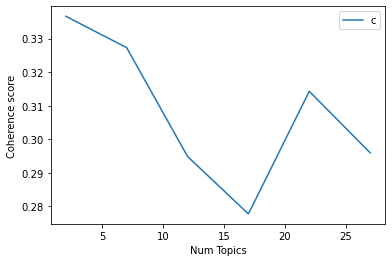

In [116]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [117]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3367
index: 1 | Num Topics = 7  has Coherence Value of 0.3273
index: 2 | Num Topics = 12  has Coherence Value of 0.2949
index: 3 | Num Topics = 17  has Coherence Value of 0.2778
index: 4 | Num Topics = 22  has Coherence Value of 0.3143
index: 5 | Num Topics = 27  has Coherence Value of 0.296


In [176]:
# Select optimal number of topics
optimal_model_ph_score1N2N3 = model_list_ph_score1N2N3[0]

In [177]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1N2N3, corpus_ph_score1N2N3, id2word_ph_score1N2N3)

In [178]:
print("pyLDAVis for ph topics for score=1,2,3:")
vis_ph_score1N2N3

pyLDAVis for ph topics for score=1,2,3:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.086716  0.0       1        1  64.363094
0     -0.086716  0.0       2        1  35.636906, topic_info=          Term        Freq       Total Category  logprob  loglift
12        post  212.000000  212.000000  Default  30.0000  30.0000
29       still  151.000000  151.000000  Default  29.0000  29.0000
0      account  286.000000  286.000000  Default  28.0000  28.0000
73      really   88.000000   88.000000  Default  27.0000  27.0000
581    suggest   25.000000   25.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
24   instagram   26.250876  147.603334   Topic2  -5.0666  -0.6950
3       change   19.977172   53.692320   Topic2  -5.3397   0.0431
32        time   24.954876  133.311071   Topic2  -5.1172  -0.6438
0      account   24.507810  286.815960   Topic2  -5.1353  -1.4281
6          fix   22.799725  172.019809   Topic2  -5.2075  -0.9891

[158 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
422       1  0.106276       acc
422       2  0.956482       acc
0         1  0.913478   account
0         2  0.087164   account
930       1  0.145657  activity
...     ...       ...       ...
723       2  1.001721   wherein
63        1  0.925837      work
63        2  0.077153      work
182       1  0.976874       yet
182       2  0.069777       yet

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [121]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_ph_2018_score1N2N3 = instagram_ios_ph_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_ph_2018_score1N2N3 = list(sent_to_words(review_ph_2018_score1N2N3))
print(review_words_ph_2018_score1N2N3[:1])

[['hi', 'instagram', 'don', 'know', 'what', 'happening', 'lately', 'that', 'whatever', 'do', 'posting', 'on', 'account', 'stories', 'or', 'following', 'accounts', 'on', 'this', 'certain', 'account', 'mainly', 'use', 'goes', 'to', 'the', 'other', 'account', 'and', 'it', 'troublesome', 'especially', 'dont', 'want', 'this', 'content', 'to', 'be', 'seen', 'by', 'others', 'please', 'fix', 'it', 'it', 'seems', 'like', 'bug', 'reinstalling', 'it', 'to', 'see', 'if', 'there', 'anything', 'that', 'will', 'change', 'thank', 'you']]


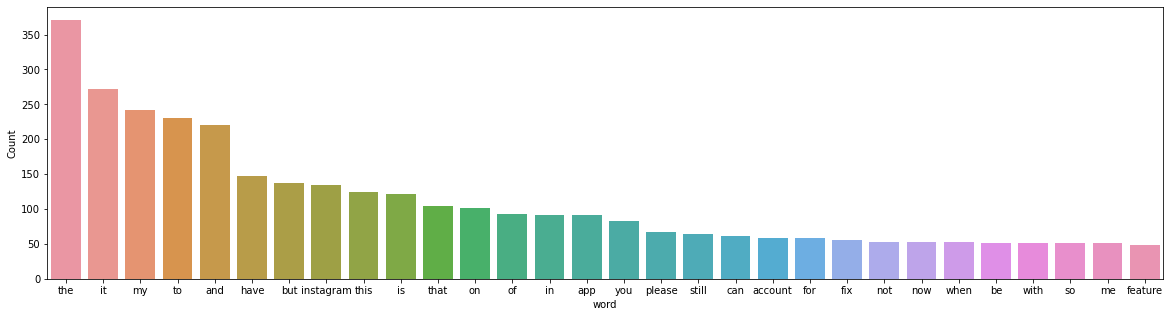

In [122]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2018_score1N2N3))

In [123]:
# Clean text
review_words_ph_ready_2018_score1N2N3 = process_words(review_words_ph_2018_score1N2N3)  # processed Text Data! - move to each section

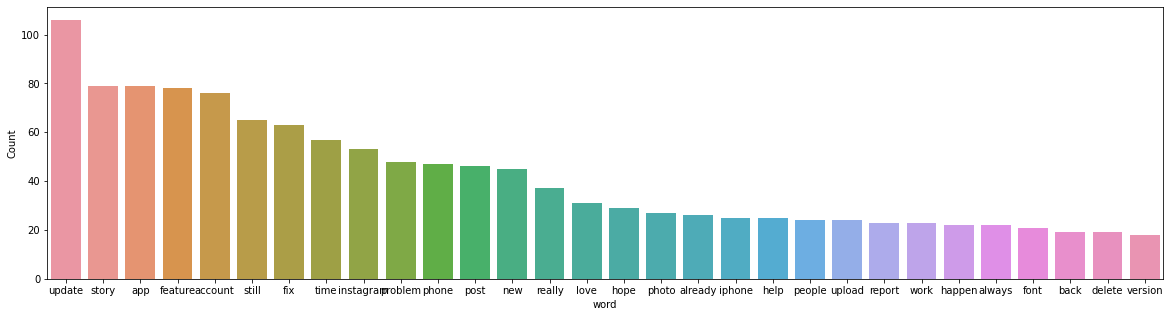

In [124]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2018_score1N2N3))


In [125]:
# Create Dictionary
id2word_ph_2018_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2018_score1N2N3)

2021-10-16 02:27:22,888 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:27:22,898 [INFO] gensim.corpora.dictionary - built Dictionary(745 unique tokens: ['account', 'bug', 'certain', 'change', 'content']...) from 124 documents (total 3250 corpus positions)
2021-10-16 02:27:22,900 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(745 unique tokens: ['account', 'bug', 'certain', 'change', 'content']...) from 124 documents (total 3250 corpus positions)", 'datetime': '2021-10-16T02:27:22.900306', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [126]:
# Create Corpus: Term Document Frequency
corpus_ph_2018_score1N2N3 = [id2word_ph_2018_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2018_score1N2N3]

In [127]:
# Training LDA model
model_list_ph_2018_score1N2N3, coherence_values_ph_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2018_score1N2N3, corpus=corpus_ph_2018_score1N2N3, 
                                                              texts=review_words_ph_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:27:22,921 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:27:22,923 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:27:22,926 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:27:22,927 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 124 documents, updating model once every 124 documents, evaluating perplexity every 124 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:27:23,413 [INFO] gensim.models.ldamodel - -7.176 per-word bound, 144.6 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:23,416 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #124/124
2021-10-16 02:27:23,896 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"update" + 0.023*"story" + 0.020*"phone" + 0.018*"app" + 0.018*"instagram" + 0.015*"fix" + 0.014*"

2021-10-16 02:27:28,535 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"update" + 0.028*"account" + 0.027*"feature" + 0.022*"story" + 0.022*"still" + 0.021*"app" + 0.017*"time" + 0.017*"fix" + 0.015*"new" + 0.013*"problem"
2021-10-16 02:27:28,536 [INFO] gensim.models.ldamodel - topic diff=0.014229, rho=0.301511
2021-10-16 02:27:28,798 [INFO] gensim.models.ldamodel - -6.063 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:28,799 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #124/124
2021-10-16 02:27:28,981 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"update" + 0.020*"post" + 0.018*"app" + 0.016*"instagram" + 0.015*"story" + 0.014*"phone" + 0.014*"fix" + 0.013*"really" + 0.012*"picture" + 0.010*"problem"
2021-10-16 02:27:29,015 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"update" + 0.028*"account" + 0.027*"feature" + 0.023*"story" + 0.022*"still" + 0.021*"app" + 0.017*"t

2021-10-16 02:27:33,171 [INFO] gensim.models.ldamodel - topic diff=0.008064, rho=0.218218
2021-10-16 02:27:33,399 [INFO] gensim.models.ldamodel - -6.055 per-word bound, 66.5 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:33,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #124/124
2021-10-16 02:27:33,611 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"post" + 0.021*"update" + 0.016*"app" + 0.015*"instagram" + 0.014*"really" + 0.013*"story" + 0.013*"fix" + 0.012*"picture" + 0.011*"phone" + 0.009*"problem"
2021-10-16 02:27:33,616 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"update" + 0.028*"account" + 0.028*"feature" + 0.023*"story" + 0.022*"still" + 0.022*"app" + 0.018*"time" + 0.017*"fix" + 0.016*"new" + 0.014*"problem"
2021-10-16 02:27:33,618 [INFO] gensim.models.ldamodel - topic diff=0.008016, rho=0.213201
2021-10-16 02:27:33,859 [INFO] gensim.models.ldamodel - -6.054 per-word bound, 66.4 perplex

2021-10-16 02:27:37,685 [INFO] gensim.models.ldamodel - -6.049 per-word bound, 66.2 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:37,687 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #124/124
2021-10-16 02:27:37,838 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"post" + 0.019*"update" + 0.015*"instagram" + 0.015*"app" + 0.014*"really" + 0.012*"picture" + 0.012*"story" + 0.012*"fix" + 0.009*"phone" + 0.009*"back"
2021-10-16 02:27:37,847 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"update" + 0.028*"feature" + 0.028*"account" + 0.024*"story" + 0.022*"still" + 0.022*"app" + 0.018*"fix" + 0.018*"time" + 0.016*"new" + 0.014*"problem"
2021-10-16 02:27:37,857 [INFO] gensim.models.ldamodel - topic diff=0.005747, rho=0.176777
2021-10-16 02:27:38,098 [INFO] gensim.models.ldamodel - -6.048 per-word bound, 66.2 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:38,

2021-10-16 02:27:41,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #124/124
2021-10-16 02:27:41,800 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 0.018*"update" + 0.015*"instagram" + 0.014*"really" + 0.014*"app" + 0.012*"picture" + 0.011*"story" + 0.011*"fix" + 0.010*"back" + 0.008*"phone"
2021-10-16 02:27:41,803 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"update" + 0.028*"feature" + 0.028*"account" + 0.024*"story" + 0.023*"app" + 0.023*"still" + 0.018*"fix" + 0.018*"time" + 0.016*"new" + 0.014*"problem"
2021-10-16 02:27:41,804 [INFO] gensim.models.ldamodel - topic diff=0.003791, rho=0.154303
2021-10-16 02:27:41,997 [INFO] gensim.models.ldamodel - -6.044 per-word bound, 66.0 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:41,998 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #124/124
2021-10-16 02:27:42,165 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" +

2021-10-16 02:27:44,828 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:27:49,192 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:27:49,238 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 124 virtual documents
2021-10-16 02:27:49,536 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:27:49,537 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:27:49,540 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:27:49,542 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 124 documents, updating model once every 124 documents, evaluating perplexity every 124 documents, iterating 50x with a con

2021-10-16 02:27:51,845 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"account" + 0.025*"time" + 0.018*"post" + 0.015*"fix" + 0.013*"feature" + 0.013*"still" + 0.012*"happen" + 0.011*"photo" + 0.011*"report" + 0.011*"story"
2021-10-16 02:27:51,847 [INFO] gensim.models.ldamodel - topic diff=0.104550, rho=0.408248
2021-10-16 02:27:52,037 [INFO] gensim.models.ldamodel - -6.279 per-word bound, 77.6 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:52,039 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #124/124
2021-10-16 02:27:52,113 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.050*"story" + 0.022*"still" + 0.021*"feature" + 0.018*"instagram" + 0.017*"update" + 0.015*"fix" + 0.015*"time" + 0.014*"type" + 0.013*"people" + 0.013*"app"
2021-10-16 02:27:52,114 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.027*"account" + 0.025*"time" + 0.018*"post" + 0.014*"fix" + 0.012*"still" + 0.012*"happen" + 0.012*"feature

2021-10-16 02:27:53,813 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.025*"account" + 0.019*"post" + 0.014*"fix" + 0.013*"happen" + 0.012*"photo" + 0.012*"still" + 0.010*"really" + 0.010*"issue" + 0.010*"report"
2021-10-16 02:27:53,814 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"story" + 0.021*"phone" + 0.017*"highlight" + 0.016*"app" + 0.016*"post" + 0.016*"iphone" + 0.016*"camera" + 0.015*"love" + 0.012*"work" + 0.012*"quality"
2021-10-16 02:27:53,815 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.026*"app" + 0.023*"feature" + 0.020*"upload" + 0.020*"still" + 0.016*"really" + 0.014*"video" + 0.014*"fix" + 0.012*"update" + 0.012*"instagram" + 0.011*"photo"
2021-10-16 02:27:53,818 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"instagram" + 0.024*"post" + 0.022*"phone" + 0.018*"really" + 0.016*"fix" + 0.013*"update" + 0.013*"app" + 0.012*"time" + 0.011*"story" + 0.011*"work"
2021-10-16 02:27:53,819 [INFO] gensim.models.ldamodel - topic di

2021-10-16 02:27:55,465 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.061*"update" + 0.042*"account" + 0.038*"feature" + 0.031*"new" + 0.030*"app" + 0.029*"still" + 0.023*"fix" + 0.023*"story" + 0.022*"problem" + 0.021*"time"
2021-10-16 02:27:55,466 [INFO] gensim.models.ldamodel - topic diff=0.008185, rho=0.242536
2021-10-16 02:27:55,632 [INFO] gensim.models.ldamodel - -6.246 per-word bound, 75.9 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:55,634 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #124/124
2021-10-16 02:27:55,784 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.050*"story" + 0.020*"feature" + 0.019*"still" + 0.017*"instagram" + 0.016*"fix" + 0.016*"update" + 0.014*"time" + 0.014*"people" + 0.014*"upload" + 0.013*"send"
2021-10-16 02:27:55,785 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.022*"account" + 0.019*"post" + 0.014*"fix" + 0.013*"happen" + 0.013*"photo" + 0.012*"still

2021-10-16 02:27:57,553 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"post" + 0.021*"story" + 0.019*"app" + 0.017*"really" + 0.016*"always" + 0.014*"picture" + 0.014*"update" + 0.012*"problem" + 0.011*"upload" + 0.011*"photo"
2021-10-16 02:27:57,556 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.061*"update" + 0.043*"account" + 0.039*"feature" + 0.031*"new" + 0.030*"app" + 0.029*"still" + 0.023*"fix" + 0.023*"story" + 0.022*"time" + 0.021*"problem"
2021-10-16 02:27:57,559 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"instagram" + 0.025*"post" + 0.019*"phone" + 0.018*"really" + 0.015*"fix" + 0.011*"update" + 0.011*"app" + 0.011*"time" + 0.011*"story" + 0.010*"last"
2021-10-16 02:27:57,562 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.021*"account" + 0.019*"post" + 0.014*"fix" + 0.013*"happen" + 0.013*"photo" + 0.012*"still" + 0.011*"issue" + 0.010*"really" + 0.010*"app"
2021-10-16 02:27:57,564 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 02:27:59,263 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"story" + 0.021*"phone" + 0.016*"highlight" + 0.016*"app" + 0.016*"iphone" + 0.016*"post" + 0.016*"camera" + 0.014*"love" + 0.012*"well" + 0.012*"work"
2021-10-16 02:27:59,264 [INFO] gensim.models.ldamodel - topic diff=0.002707, rho=0.188982
2021-10-16 02:27:59,472 [INFO] gensim.models.ldamodel - -6.241 per-word bound, 75.7 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:27:59,476 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #124/124
2021-10-16 02:27:59,591 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.021*"account" + 0.020*"post" + 0.014*"fix" + 0.013*"happen" + 0.013*"photo" + 0.012*"still" + 0.011*"issue" + 0.010*"really" + 0.010*"app"
2021-10-16 02:27:59,593 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"app" + 0.023*"feature" + 0.020*"upload" + 0.018*"still" + 0.016*"really" + 0.014*"video" + 0.012*"instagram

2021-10-16 02:28:01,286 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"instagram" + 0.025*"post" + 0.019*"phone" + 0.018*"really" + 0.015*"fix" + 0.011*"app" + 0.011*"update" + 0.011*"time" + 0.011*"story" + 0.010*"last"
2021-10-16 02:28:01,287 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.060*"update" + 0.043*"account" + 0.040*"feature" + 0.031*"new" + 0.030*"app" + 0.030*"still" + 0.024*"story" + 0.023*"fix" + 0.022*"time" + 0.021*"problem"
2021-10-16 02:28:01,289 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"app" + 0.023*"feature" + 0.020*"upload" + 0.017*"still" + 0.016*"really" + 0.014*"video" + 0.012*"instagram" + 0.012*"photo" + 0.012*"update" + 0.011*"fix"
2021-10-16 02:28:01,290 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"story" + 0.021*"phone" + 0.017*"highlight" + 0.016*"app" + 0.016*"iphone" + 0.016*"camera" + 0.016*"post" + 0.014*"love" + 0.012*"work" + 0.012*"well"
2021-10-16 02:28:01,291 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 02:28:02,922 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"story" + 0.021*"phone" + 0.018*"highlight" + 0.016*"app" + 0.016*"iphone" + 0.016*"camera" + 0.016*"post" + 0.014*"love" + 0.013*"work" + 0.012*"well"
2021-10-16 02:28:02,924 [INFO] gensim.models.ldamodel - topic diff=0.001665, rho=0.160128
2021-10-16 02:28:03,102 [INFO] gensim.models.ldamodel - -6.239 per-word bound, 75.5 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:03,106 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #124/124
2021-10-16 02:28:03,287 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"app" + 0.023*"feature" + 0.020*"upload" + 0.016*"still" + 0.016*"really" + 0.014*"video" + 0.012*"instagram" + 0.012*"photo" + 0.012*"update" + 0.011*"fix"
2021-10-16 02:28:03,289 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"instagram" + 0.025*"post" + 0.019*"phone" + 0.018*"really" + 0.015*"fix" + 0.011*"app" + 0.011*"upda

2021-10-16 02:28:04,936 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"post" + 0.021*"story" + 0.018*"app" + 0.017*"really" + 0.016*"always" + 0.015*"picture" + 0.012*"problem" + 0.012*"update" + 0.012*"photo" + 0.012*"upload"
2021-10-16 02:28:04,938 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"story" + 0.020*"feature" + 0.017*"still" + 0.016*"instagram" + 0.014*"upload" + 0.014*"fix" + 0.014*"time" + 0.014*"people" + 0.014*"send" + 0.013*"update"
2021-10-16 02:28:04,939 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.060*"update" + 0.043*"account" + 0.040*"feature" + 0.031*"new" + 0.030*"still" + 0.030*"app" + 0.024*"story" + 0.023*"fix" + 0.022*"time" + 0.021*"problem"
2021-10-16 02:28:04,940 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"instagram" + 0.025*"post" + 0.019*"phone" + 0.018*"really" + 0.015*"fix" + 0.011*"app" + 0.011*"update" + 0.011*"time" + 0.010*"story" + 0.010*"last"
2021-10-16 02:28:04,941 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:28:06,548 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"story" + 0.020*"feature" + 0.016*"still" + 0.016*"instagram" + 0.015*"upload" + 0.014*"people" + 0.014*"time" + 0.014*"fix" + 0.014*"send" + 0.013*"update"
2021-10-16 02:28:06,549 [INFO] gensim.models.ldamodel - topic diff=0.001390, rho=0.141421
2021-10-16 02:28:06,773 [INFO] gensim.models.ldamodel - -6.237 per-word bound, 75.4 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:06,778 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #124/124
2021-10-16 02:28:06,865 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"post" + 0.021*"story" + 0.018*"app" + 0.017*"really" + 0.016*"always" + 0.015*"picture" + 0.012*"problem" + 0.012*"photo" + 0.012*"upload" + 0.011*"update"
2021-10-16 02:28:06,867 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"story" + 0.021*"phone" + 0.019*"highlight" + 0.016*"app" + 0.016*"iphone" + 0.016*"camera" + 0.

2021-10-16 02:28:14,686 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"feature" + 0.023*"focus" + 0.023*"block" + 0.023*"version" + 0.016*"notification" + 0.016*"button" + 0.016*"app" + 0.015*"late" + 0.015*"instagram" + 0.015*"fix"
2021-10-16 02:28:14,690 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"app" + 0.026*"still" + 0.025*"time" + 0.023*"update" + 0.020*"fix" + 0.018*"phone" + 0.018*"story" + 0.017*"iphone" + 0.017*"problem" + 0.017*"account"
2021-10-16 02:28:14,698 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.040*"always" + 0.033*"post" + 0.031*"update" + 0.022*"back" + 0.020*"put" + 0.017*"app" + 0.013*"story" + 0.012*"day" + 0.012*"still" + 0.011*"question"
2021-10-16 02:28:14,700 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"people" + 0.028*"post" + 0.027*"story" + 0.016*"understand" + 0.016*"send" + 0.014*"picture" + 0.014*"feature" + 0.012*"facebook" + 0.012*"comment" + 0.011*"well"
2021-10-16 02:28:14,702 [INFO] gensim.models.ldamo

2021-10-16 02:28:16,671 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"always" + 0.034*"post" + 0.023*"back" + 0.023*"put" + 0.019*"update" + 0.015*"app" + 0.012*"day" + 0.012*"sure" + 0.012*"anymore" + 0.012*"scroll"
2021-10-16 02:28:16,672 [INFO] gensim.models.ldamodel - topic diff=0.031956, rho=0.316228
2021-10-16 02:28:16,852 [INFO] gensim.models.ldamodel - -6.396 per-word bound, 84.2 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:16,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #124/124
2021-10-16 02:28:16,942 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.023*"update" + 0.017*"still" + 0.017*"type" + 0.017*"mode" + 0.017*"fix" + 0.017*"story" + 0.017*"instagram" + 0.017*"account" + 0.017*"post" + 0.017*"link"
2021-10-16 02:28:16,943 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"always" + 0.035*"post" + 0.023*"back" + 0.023*"put" + 0.018*"update" + 0.015*"app" + 0.012*"day" + 0.012*"

2021-10-16 02:28:18,432 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"app" + 0.026*"still" + 0.026*"time" + 0.020*"fix" + 0.019*"update" + 0.018*"story" + 0.018*"phone" + 0.018*"iphone" + 0.017*"problem" + 0.017*"help"
2021-10-16 02:28:18,433 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.023*"update" + 0.017*"mode" + 0.017*"post" + 0.017*"type" + 0.017*"link" + 0.017*"caption" + 0.017*"let" + 0.017*"profile" + 0.017*"instagram" + 0.017*"story"
2021-10-16 02:28:18,435 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.036*"upload" + 0.027*"fix" + 0.024*"still" + 0.022*"really" + 0.015*"update" + 0.014*"people" + 0.014*"hope" + 0.014*"much" + 0.014*"follow" + 0.014*"screen"
2021-10-16 02:28:18,436 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"phone" + 0.026*"fix" + 0.026*"update" + 0.026*"really" + 0.024*"instagram" + 0.023*"app" + 0.020*"story" + 0.017*"work" + 0.014*"post" + 0.014*"press"
2021-10-16 02:28:18,437 [INFO] gensim.models.ldamodel - topic #5 (0.

2021-10-16 02:28:19,806 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"app" + 0.026*"still" + 0.026*"time" + 0.020*"fix" + 0.019*"update" + 0.019*"story" + 0.018*"iphone" + 0.018*"phone" + 0.017*"problem" + 0.017*"help"
2021-10-16 02:28:19,808 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"phone" + 0.030*"story" + 0.025*"still" + 0.020*"update" + 0.020*"post" + 0.020*"old" + 0.020*"new" + 0.020*"picture" + 0.020*"instagram" + 0.020*"version"
2021-10-16 02:28:19,809 [INFO] gensim.models.ldamodel - topic diff=0.004294, rho=0.218218
2021-10-16 02:28:19,969 [INFO] gensim.models.ldamodel - -6.384 per-word bound, 83.5 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:19,970 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #124/124
2021-10-16 02:28:20,082 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"update" + 0.047*"account" + 0.043*"feature" + 0.038*"new" + 0.028*"still" + 0.023*"app" + 0.021*"proble

2021-10-16 02:28:21,457 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:21,459 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #124/124
2021-10-16 02:28:21,595 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"update" + 0.047*"account" + 0.043*"feature" + 0.038*"new" + 0.028*"still" + 0.023*"app" + 0.021*"story" + 0.020*"problem" + 0.019*"love" + 0.015*"instagram"
2021-10-16 02:28:21,597 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"phone" + 0.030*"story" + 0.025*"still" + 0.020*"update" + 0.020*"post" + 0.020*"old" + 0.020*"new" + 0.020*"picture" + 0.020*"instagram" + 0.020*"version"
2021-10-16 02:28:21,600 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"phone" + 0.026*"fix" + 0.026*"update" + 0.026*"really" + 0.024*"instagram" + 0.023*"app" + 0.020*"story" + 0.017*"work" + 0.014*"post" + 0.014*"press"
2021-10-16 02:28:21,602 [INFO] gen

2021-10-16 02:28:23,195 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"account" + 0.032*"story" + 0.025*"photo" + 0.022*"time" + 0.019*"feature" + 0.017*"still" + 0.017*"post" + 0.013*"follow" + 0.011*"report" + 0.011*"look"
2021-10-16 02:28:23,197 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"phone" + 0.030*"story" + 0.025*"still" + 0.020*"update" + 0.020*"post" + 0.020*"old" + 0.020*"new" + 0.020*"picture" + 0.020*"instagram" + 0.020*"version"
2021-10-16 02:28:23,198 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"update" + 0.046*"account" + 0.043*"feature" + 0.038*"new" + 0.029*"still" + 0.023*"app" + 0.021*"story" + 0.020*"problem" + 0.019*"love" + 0.016*"instagram"
2021-10-16 02:28:23,201 [INFO] gensim.models.ldamodel - topic diff=0.001373, rho=0.176777
2021-10-16 02:28:23,421 [INFO] gensim.models.ldamodel - -6.381 per-word bound, 83.3 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:23,422 [INFO] gensim

2021-10-16 02:28:25,175 [INFO] gensim.models.ldamodel - topic diff=0.000852, rho=0.164399
2021-10-16 02:28:25,408 [INFO] gensim.models.ldamodel - -6.380 per-word bound, 83.3 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:25,423 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #124/124
2021-10-16 02:28:25,550 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"update" + 0.046*"account" + 0.043*"feature" + 0.038*"new" + 0.029*"still" + 0.023*"app" + 0.021*"story" + 0.020*"problem" + 0.019*"love" + 0.016*"instagram"
2021-10-16 02:28:25,554 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"app" + 0.026*"still" + 0.026*"time" + 0.020*"fix" + 0.019*"story" + 0.019*"update" + 0.018*"iphone" + 0.018*"phone" + 0.017*"problem" + 0.017*"help"
2021-10-16 02:28:25,555 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"update" + 0.027*"fix" + 0.026*"app" + 0.022*"feature" + 0.020*"time" + 0.016*"post" + 0.016*"superzoo

2021-10-16 02:28:27,758 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"phone" + 0.030*"story" + 0.025*"still" + 0.020*"update" + 0.020*"new" + 0.020*"old" + 0.020*"post" + 0.020*"picture" + 0.020*"instagram" + 0.020*"version"
2021-10-16 02:28:27,769 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"story" + 0.027*"account" + 0.025*"feature" + 0.025*"really" + 0.024*"app" + 0.019*"problem" + 0.014*"love" + 0.012*"highlight" + 0.012*"post" + 0.012*"selection"
2021-10-16 02:28:27,774 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"app" + 0.026*"still" + 0.026*"time" + 0.020*"fix" + 0.019*"story" + 0.019*"update" + 0.018*"iphone" + 0.018*"phone" + 0.017*"problem" + 0.017*"help"
2021-10-16 02:28:27,779 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"always" + 0.036*"post" + 0.024*"back" + 0.024*"put" + 0.013*"app" + 0.012*"day" + 0.012*"sure" + 0.012*"anymore" + 0.012*"instagram" + 0.012*"scroll"
2021-10-16 02:28:27,783 [INFO] gensim.models.ldamodel - top

2021-10-16 02:28:29,764 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"always" + 0.036*"post" + 0.024*"back" + 0.024*"put" + 0.013*"app" + 0.012*"day" + 0.012*"sure" + 0.012*"instagram" + 0.012*"anymore" + 0.012*"scroll"
2021-10-16 02:28:29,766 [INFO] gensim.models.ldamodel - topic diff=0.000478, rho=0.144338
2021-10-16 02:28:29,967 [INFO] gensim.models.ldamodel - -6.380 per-word bound, 83.3 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:29,970 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #124/124
2021-10-16 02:28:30,145 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"phone" + 0.026*"fix" + 0.026*"update" + 0.026*"really" + 0.024*"instagram" + 0.023*"app" + 0.020*"story" + 0.017*"work" + 0.014*"post" + 0.014*"press"
2021-10-16 02:28:30,155 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"account" + 0.032*"story" + 0.025*"photo" + 0.022*"time" + 0.019*"feature" + 0.017*"still" + 0.017*"post" 

2021-10-16 02:28:38,558 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.024*"story" + 0.021*"time" + 0.021*"log" + 0.020*"highlight" + 0.020*"problem" + 0.020*"still" + 0.018*"account" + 0.017*"instagram" + 0.017*"post" + 0.015*"phone"
2021-10-16 02:28:38,560 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.046*"feature" + 0.039*"account" + 0.036*"still" + 0.035*"story" + 0.021*"fix" + 0.018*"update" + 0.018*"phone" + 0.015*"time" + 0.014*"type" + 0.014*"app"
2021-10-16 02:28:38,562 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.031*"app" + 0.025*"story" + 0.022*"iphone" + 0.022*"green" + 0.017*"update" + 0.017*"instagram" + 0.017*"crash" + 0.017*"phone" + 0.017*"still" + 0.016*"help"
2021-10-16 02:28:38,563 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.040*"app" + 0.040*"update" + 0.024*"time" + 0.023*"still" + 0.017*"fix" + 0.016*"phone" + 0.015*"already" + 0.014*"problem" + 0.012*"feature" + 0.011*"post"
2021-10-16 02:28:38,564 [INFO] gensim.models.ldamodel - top

2021-10-16 02:28:40,101 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.051*"feature" + 0.051*"focus" + 0.018*"iphone" + 0.018*"app" + 0.018*"show" + 0.018*"instal" + 0.018*"version" + 0.018*"delete" + 0.018*"sis" + 0.018*"io"
2021-10-16 02:28:40,102 [INFO] gensim.models.ldamodel - topic diff=0.070644, rho=0.353553
2021-10-16 02:28:40,237 [INFO] gensim.models.ldamodel - -6.525 per-word bound, 92.1 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:40,238 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #124/124
2021-10-16 02:28:40,372 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"app" + 0.037*"update" + 0.024*"still" + 0.023*"time" + 0.018*"phone" + 0.017*"fix" + 0.016*"already" + 0.015*"problem" + 0.013*"feature" + 0.012*"happen"
2021-10-16 02:28:40,420 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.027*"filter" + 0.020*"story" + 0.017*"cat" + 0.017*"swear" + 0.017*"meanwhile" + 0.017*"hate" + 0.017*"wait"

2021-10-16 02:28:41,969 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.028*"filter" + 0.020*"story" + 0.017*"cat" + 0.017*"swear" + 0.017*"meanwhile" + 0.017*"hate" + 0.017*"wait" + 0.017*"face" + 0.017*"date" + 0.017*"leave"
2021-10-16 02:28:41,979 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"photo" + 0.030*"comment" + 0.030*"understand" + 0.030*"phone" + 0.020*"copy" + 0.020*"account" + 0.020*"save" + 0.011*"allow" + 0.011*"due" + 0.011*"language"
2021-10-16 02:28:41,993 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"feature" + 0.035*"update" + 0.024*"fix" + 0.024*"problem" + 0.024*"people" + 0.018*"still" + 0.018*"hope" + 0.018*"love" + 0.018*"font" + 0.018*"new"
2021-10-16 02:28:41,996 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.028*"feature" + 0.028*"app" + 0.019*"update" + 0.019*"fix" + 0.019*"time" + 0.019*"hope" + 0.014*"story" + 0.014*"datum" + 0.014*"iphone" + 0.014*"quality"
2021-10-16 02:28:42,001 [INFO] gensim.models.ldamodel - topic #6

2021-10-16 02:28:43,483 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.023*"instagram" + 0.019*"update" + 0.019*"profile" + 0.018*"fix" + 0.015*"story" + 0.015*"button" + 0.015*"well" + 0.015*"block" + 0.015*"pop" + 0.011*"much"
2021-10-16 02:28:43,486 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.043*"story" + 0.032*"update" + 0.029*"really" + 0.026*"app" + 0.025*"feature" + 0.019*"post" + 0.019*"upload" + 0.019*"instagram" + 0.017*"problem" + 0.017*"fix"
2021-10-16 02:28:43,490 [INFO] gensim.models.ldamodel - topic diff=0.004770, rho=0.229416
2021-10-16 02:28:43,681 [INFO] gensim.models.ldamodel - -6.509 per-word bound, 91.1 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:43,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #124/124
2021-10-16 02:28:43,787 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"photo" + 0.030*"understand" + 0.030*"comment" + 0.030*"phone" + 0.020*"copy" + 0.020*"account" 

2021-10-16 02:28:45,207 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:45,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #124/124
2021-10-16 02:28:45,330 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"app" + 0.024*"gif" + 0.024*"story" + 0.023*"fix" + 0.019*"still" + 0.019*"problem" + 0.018*"instal" + 0.016*"time" + 0.014*"upload" + 0.014*"version"
2021-10-16 02:28:45,333 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.022*"instagram" + 0.019*"profile" + 0.018*"update" + 0.017*"fix" + 0.015*"story" + 0.015*"button" + 0.015*"well" + 0.015*"block" + 0.015*"pop" + 0.011*"much"
2021-10-16 02:28:45,336 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"post" + 0.035*"story" + 0.024*"new" + 0.024*"picture" + 0.024*"old" + 0.024*"archived" + 0.022*"version" + 0.019*"still" + 0.018*"update" + 0.018*"instagram"
2021-10-16 02:28:45,340 [INFO] gen

2021-10-16 02:28:46,867 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.040*"app" + 0.037*"update" + 0.025*"still" + 0.022*"time" + 0.018*"phone" + 0.017*"fix" + 0.016*"already" + 0.015*"problem" + 0.013*"feature" + 0.013*"happen"
2021-10-16 02:28:46,869 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.074*"update" + 0.051*"new" + 0.050*"account" + 0.035*"feature" + 0.025*"love" + 0.022*"still" + 0.021*"time" + 0.018*"instagram" + 0.017*"superzoom" + 0.016*"hope"
2021-10-16 02:28:46,871 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.037*"always" + 0.026*"update" + 0.025*"put" + 0.024*"back" + 0.022*"app" + 0.022*"account" + 0.020*"still" + 0.020*"download" + 0.019*"delete" + 0.017*"help"
2021-10-16 02:28:46,874 [INFO] gensim.models.ldamodel - topic diff=0.001391, rho=0.182574
2021-10-16 02:28:47,091 [INFO] gensim.models.ldamodel - -6.504 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:47,094 [INFO] gensi

2021-10-16 02:28:48,627 [INFO] gensim.models.ldamodel - topic diff=0.000973, rho=0.169031
2021-10-16 02:28:48,802 [INFO] gensim.models.ldamodel - -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:48,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #124/124
2021-10-16 02:28:48,891 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.024*"story" + 0.024*"time" + 0.024*"highlight" + 0.024*"problem" + 0.022*"log" + 0.020*"still" + 0.018*"instagram" + 0.018*"post" + 0.018*"error" + 0.014*"account"
2021-10-16 02:28:48,912 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.028*"filter" + 0.019*"story" + 0.018*"cat" + 0.018*"swear" + 0.018*"meanwhile" + 0.018*"hate" + 0.018*"wait" + 0.018*"date" + 0.018*"face" + 0.018*"dog"
2021-10-16 02:28:48,930 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.047*"feature" + 0.042*"account" + 0.041*"still" + 0.038*"story" + 0.020*"fix" + 0.020*"update" + 0.020

2021-10-16 02:28:50,445 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.024*"story" + 0.024*"time" + 0.024*"highlight" + 0.024*"problem" + 0.022*"log" + 0.020*"still" + 0.018*"instagram" + 0.018*"post" + 0.018*"error" + 0.014*"account"
2021-10-16 02:28:50,446 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"feature" + 0.035*"update" + 0.024*"fix" + 0.024*"problem" + 0.024*"people" + 0.018*"still" + 0.018*"love" + 0.018*"hope" + 0.018*"font" + 0.018*"new"
2021-10-16 02:28:50,450 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.028*"filter" + 0.019*"story" + 0.018*"cat" + 0.018*"swear" + 0.018*"hate" + 0.018*"wait" + 0.018*"meanwhile" + 0.018*"face" + 0.018*"date" + 0.018*"leave"
2021-10-16 02:28:50,453 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.028*"feature" + 0.028*"app" + 0.019*"update" + 0.019*"fix" + 0.019*"time" + 0.019*"hope" + 0.014*"story" + 0.014*"datum" + 0.014*"iphone" + 0.014*"quality"
2021-10-16 02:28:50,455 [INFO] gensim.models.ldamodel - topic di

2021-10-16 02:28:51,973 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.024*"story" + 0.024*"time" + 0.024*"highlight" + 0.024*"problem" + 0.022*"log" + 0.020*"still" + 0.018*"instagram" + 0.018*"post" + 0.018*"error" + 0.014*"account"
2021-10-16 02:28:51,974 [INFO] gensim.models.ldamodel - topic diff=0.000588, rho=0.147442
2021-10-16 02:28:52,136 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:28:52,137 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #124/124
2021-10-16 02:28:52,266 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.037*"always" + 0.026*"update" + 0.025*"put" + 0.024*"back" + 0.022*"app" + 0.022*"account" + 0.020*"download" + 0.020*"still" + 0.019*"delete" + 0.017*"help"
2021-10-16 02:28:52,268 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"feature" + 0.035*"update" + 0.024*"fix" + 0.024*"problem" + 0.024*"people" + 0.018*"still" + 

2021-10-16 02:28:53,540 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:28:57,717 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:28:57,776 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 124 virtual documents
2021-10-16 02:29:00,295 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 02:29:00,297 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 02:29:00,401 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:29:00,421 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 124 documents, updating model once every 124 documents, evaluating perplexity every 124 documents, iterating 50x with a 

2021-10-16 02:29:02,554 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.033*"still" + 0.032*"time" + 0.029*"phone" + 0.027*"happen" + 0.024*"log" + 0.024*"instagram" + 0.024*"post" + 0.023*"restart" + 0.016*"update" + 0.016*"reinstall"
2021-10-16 02:29:02,555 [INFO] gensim.models.ldamodel - topic diff=0.148227, rho=0.408248
2021-10-16 02:29:02,764 [INFO] gensim.models.ldamodel - -6.597 per-word bound, 96.8 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:02,784 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #124/124
2021-10-16 02:29:02,931 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.035*"story" + 0.026*"update" + 0.025*"account" + 0.020*"well" + 0.015*"love" + 0.015*"dms" + 0.015*"reaction" + 0.015*"facebook" + 0.015*"show" + 0.015*"bring"
2021-10-16 02:29:02,932 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.032*"still" + 0.032*"time" + 0.029*"phone" + 0.028*"happen" + 0.024*"post" + 0.024*"log" + 0.024

2021-10-16 02:29:04,567 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.049*"story" + 0.039*"really" + 0.029*"problem" + 0.029*"feature" + 0.020*"app" + 0.020*"motion" + 0.020*"stop" + 0.020*"add" + 0.020*"photo" + 0.020*"post"
2021-10-16 02:29:04,568 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"post" + 0.025*"archived" + 0.025*"decide" + 0.025*"really" + 0.025*"less" + 0.017*"back" + 0.017*"video" + 0.017*"account" + 0.017*"quality" + 0.017*"facebook"
2021-10-16 02:29:04,570 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.044*"app" + 0.032*"update" + 0.029*"time" + 0.022*"video" + 0.021*"fix" + 0.021*"already" + 0.020*"account" + 0.020*"story" + 0.020*"feature" + 0.018*"iphone"
2021-10-16 02:29:04,571 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.065*"upload" + 0.041*"fix" + 0.041*"feature" + 0.033*"update" + 0.033*"really" + 0.025*"love" + 0.017*"photo" + 0.017*"still" + 0.017*"app" + 0.016*"yet"
2021-10-16 02:29:04,573 [INFO] gensim.models.ldamodel - topic 

2021-10-16 02:29:06,061 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.042*"story" + 0.035*"app" + 0.026*"block" + 0.026*"update" + 0.026*"font" + 0.026*"selection" + 0.018*"fix" + 0.018*"button" + 0.018*"love" + 0.018*"ig"
2021-10-16 02:29:06,062 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"post" + 0.025*"archived" + 0.025*"decide" + 0.025*"really" + 0.025*"less" + 0.017*"back" + 0.017*"video" + 0.017*"account" + 0.017*"quality" + 0.017*"facebook"
2021-10-16 02:29:06,063 [INFO] gensim.models.ldamodel - topic diff=0.010145, rho=0.242536
2021-10-16 02:29:06,261 [INFO] gensim.models.ldamodel - -6.536 per-word bound, 92.8 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:06,266 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #124/124
2021-10-16 02:29:06,389 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.035*"still" + 0.035*"picture" + 0.035*"font" + 0.035*"amazing" + 0.018*"update" + 0.018*"really" + 0.0

2021-10-16 02:29:07,814 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #124/124
2021-10-16 02:29:07,931 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"app" + 0.032*"update" + 0.028*"time" + 0.023*"video" + 0.021*"fix" + 0.021*"already" + 0.020*"account" + 0.020*"story" + 0.020*"feature" + 0.018*"iphone"
2021-10-16 02:29:07,933 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.040*"feature" + 0.032*"keep" + 0.027*"problem" + 0.027*"account" + 0.026*"story" + 0.023*"app" + 0.020*"hope" + 0.020*"instagram" + 0.020*"send" + 0.020*"message"
2021-10-16 02:29:07,934 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.046*"app" + 0.023*"phone" + 0.023*"still" + 0.023*"story" + 0.023*"update" + 0.023*"super" + 0.023*"already" + 0.023*"customer" + 0.023*"service" + 0.023*"upload"
2021-10-16 02:29:07,935 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.031*"update" + 0.029*"story" + 0.026*"post" + 0.026*"still" + 0.026*"feature" + 0.024*"picture" + 0.023*"account"

2021-10-16 02:29:09,407 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.046*"app" + 0.023*"phone" + 0.023*"still" + 0.023*"story" + 0.023*"update" + 0.023*"super" + 0.023*"already" + 0.023*"customer" + 0.023*"service" + 0.023*"upload"
2021-10-16 02:29:09,411 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"story" + 0.023*"post" + 0.023*"let" + 0.023*"profile" + 0.023*"link" + 0.016*"update" + 0.016*"option" + 0.016*"allow" + 0.016*"put" + 0.016*"back"
2021-10-16 02:29:09,413 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"post" + 0.025*"archived" + 0.025*"decide" + 0.025*"really" + 0.025*"less" + 0.017*"back" + 0.017*"video" + 0.017*"account" + 0.017*"quality" + 0.017*"facebook"
2021-10-16 02:29:09,414 [INFO] gensim.models.ldamodel - topic diff=0.002013, rho=0.188982
2021-10-16 02:29:09,585 [INFO] gensim.models.ldamodel - -6.529 per-word bound, 92.4 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:09,586 [INFO] gensi

2021-10-16 02:29:10,974 [INFO] gensim.models.ldamodel - topic diff=0.001476, rho=0.174078
2021-10-16 02:29:11,137 [INFO] gensim.models.ldamodel - -6.529 per-word bound, 92.3 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:11,139 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #124/124
2021-10-16 02:29:11,244 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"story" + 0.023*"post" + 0.023*"let" + 0.023*"profile" + 0.023*"link" + 0.016*"update" + 0.016*"option" + 0.016*"allow" + 0.016*"put" + 0.016*"back"
2021-10-16 02:29:11,245 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.034*"story" + 0.028*"account" + 0.022*"well" + 0.017*"update" + 0.017*"reaction" + 0.017*"dms" + 0.017*"facebook" + 0.017*"show" + 0.017*"bring" + 0.012*"instagram"
2021-10-16 02:29:11,247 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.049*"always" + 0.038*"update" + 0.028*"post" + 0.027*"app" + 0.022*"story" + 0.022*"account" + 0.022*"

2021-10-16 02:29:12,848 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"post" + 0.025*"archived" + 0.025*"decide" + 0.025*"really" + 0.025*"less" + 0.017*"back" + 0.017*"video" + 0.017*"account" + 0.017*"quality" + 0.017*"facebook"
2021-10-16 02:29:12,849 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.034*"happen" + 0.029*"time" + 0.026*"phone" + 0.026*"post" + 0.024*"restart" + 0.024*"quality" + 0.022*"still" + 0.022*"log" + 0.022*"instagram" + 0.017*"crash"
2021-10-16 02:29:12,850 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.035*"gif" + 0.034*"app" + 0.032*"story" + 0.031*"still" + 0.024*"problem" + 0.024*"hope" + 0.024*"option" + 0.023*"sure" + 0.020*"account" + 0.018*"send"
2021-10-16 02:29:12,852 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"version" + 0.028*"fix" + 0.028*"problem" + 0.028*"late" + 0.028*"font" + 0.028*"account" + 0.015*"main" + 0.015*"still" + 0.015*"stuff" + 0.015*"month"
2021-10-16 02:29:12,853 [INFO] gensim.models.ldamodel - 

2021-10-16 02:29:14,344 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.028*"version" + 0.028*"problem" + 0.028*"fix" + 0.028*"late" + 0.028*"font" + 0.028*"account" + 0.015*"main" + 0.015*"stuff" + 0.015*"still" + 0.015*"month"
2021-10-16 02:29:14,346 [INFO] gensim.models.ldamodel - topic diff=0.001339, rho=0.150756
2021-10-16 02:29:14,494 [INFO] gensim.models.ldamodel - -6.525 per-word bound, 92.1 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:14,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #124/124
2021-10-16 02:29:14,589 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"story" + 0.023*"post" + 0.023*"let" + 0.023*"profile" + 0.023*"link" + 0.016*"update" + 0.016*"allow" + 0.016*"put" + 0.016*"back" + 0.016*"anymore"
2021-10-16 02:29:14,594 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"app" + 0.032*"update" + 0.028*"time" + 0.023*"video" + 0.021*"already" + 0.021*"fix" + 0.020*"feature" + 

2021-10-16 02:29:16,156 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.027*"help" + 0.020*"back" + 0.020*"pop" + 0.020*"still" + 0.020*"follow" + 0.020*"hope" + 0.020*"photo" + 0.020*"phone" + 0.020*"comment" + 0.020*"instagram"
2021-10-16 02:29:16,179 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.049*"post" + 0.025*"archived" + 0.025*"decide" + 0.025*"really" + 0.025*"less" + 0.017*"back" + 0.017*"people" + 0.017*"video" + 0.017*"quality" + 0.017*"account"
2021-10-16 02:29:16,186 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.042*"story" + 0.036*"app" + 0.027*"block" + 0.027*"update" + 0.027*"font" + 0.027*"selection" + 0.018*"button" + 0.018*"fix" + 0.018*"love" + 0.018*"ig"
2021-10-16 02:29:16,187 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.034*"story" + 0.028*"account" + 0.022*"well" + 0.017*"update" + 0.017*"reaction" + 0.017*"dms" + 0.017*"facebook" + 0.017*"show" + 0.013*"bring" + 0.012*"instagram"
2021-10-16 02:29:16,199 [INFO] gensim.models.ldamodel 

2021-10-16 02:29:25,348 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.047*"always" + 0.033*"help" + 0.033*"put" + 0.031*"back" + 0.023*"story" + 0.022*"anymore" + 0.022*"error" + 0.022*"much" + 0.021*"hassle" + 0.018*"visit"
2021-10-16 02:29:25,349 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.033*"show" + 0.025*"story" + 0.022*"last" + 0.022*"listen" + 0.022*"play" + 0.022*"open" + 0.022*"view" + 0.014*"instagram" + 0.014*"account" + 0.012*"user"
2021-10-16 02:29:25,350 [INFO] gensim.models.ldamodel - topic diff=0.235702, rho=0.500000
2021-10-16 02:29:25,466 [INFO] gensim.models.ldamodel - -6.801 per-word bound, 111.5 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:25,467 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #124/124
2021-10-16 02:29:25,581 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.049*"app" + 0.033*"phone" + 0.033*"super" + 0.033*"zoom" + 0.033*"still" + 0.033*"already" + 0.033*"update"

2021-10-16 02:29:26,950 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #124/124
2021-10-16 02:29:27,015 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.053*"photo" + 0.032*"phone" + 0.032*"really" + 0.032*"post" + 0.021*"save" + 0.021*"already" + 0.021*"still" + 0.021*"superzoom" + 0.021*"original" + 0.021*"picture"
2021-10-16 02:29:27,016 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.043*"always" + 0.039*"help" + 0.032*"put" + 0.032*"back" + 0.022*"story" + 0.022*"anymore" + 0.022*"error" + 0.022*"much" + 0.022*"hassle" + 0.021*"visit"
2021-10-16 02:29:27,017 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.048*"still" + 0.048*"feature" + 0.036*"story" + 0.036*"type" + 0.036*"mode" + 0.024*"fix" + 0.024*"vid" + 0.024*"size" + 0.024*"photo" + 0.013*"update"
2021-10-16 02:29:27,019 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.051*"app" + 0.034*"phone" + 0.034*"super" + 0.034*"zoom" + 0.034*"still" + 0.034*"already" + 0.034*"update" + 0.017*"story" +

2021-10-16 02:29:28,511 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.035*"feature" + 0.032*"time" + 0.026*"app" + 0.025*"account" + 0.024*"already" + 0.019*"instagram" + 0.017*"poll" + 0.017*"video" + 0.017*"really" + 0.017*"post"
2021-10-16 02:29:28,513 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"phone" + 0.033*"still" + 0.033*"log" + 0.025*"update" + 0.025*"time" + 0.025*"feature" + 0.025*"version" + 0.017*"instagram" + 0.017*"delete" + 0.017*"restart"
2021-10-16 02:29:28,514 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.040*"app" + 0.030*"time" + 0.020*"account" + 0.020*"story" + 0.020*"still" + 0.015*"late" + 0.015*"version" + 0.015*"font" + 0.015*"send" + 0.015*"fix"
2021-10-16 02:29:28,515 [INFO] gensim.models.ldamodel - topic diff=0.013872, rho=0.258199
2021-10-16 02:29:28,706 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:28,710 [INFO] gensi

2021-10-16 02:29:29,985 [INFO] gensim.models.ldamodel - topic diff=0.004979, rho=0.223607
2021-10-16 02:29:30,144 [INFO] gensim.models.ldamodel - -6.652 per-word bound, 100.5 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:30,147 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #124/124
2021-10-16 02:29:30,306 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.040*"app" + 0.030*"time" + 0.020*"account" + 0.020*"story" + 0.020*"still" + 0.015*"version" + 0.015*"late" + 0.015*"font" + 0.015*"send" + 0.015*"fix"
2021-10-16 02:29:30,309 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.033*"story" + 0.026*"picture" + 0.026*"update" + 0.020*"green" + 0.020*"time" + 0.020*"people" + 0.020*"horizontal" + 0.020*"really" + 0.020*"still" + 0.013*"app"
2021-10-16 02:29:30,320 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.035*"show" + 0.024*"story" + 0.024*"last" + 0.024*"listen" + 0.024*"play" + 0.024*"open" + 0.024*"view" 

2021-10-16 02:29:31,734 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.035*"post" + 0.028*"time" + 0.026*"app" + 0.026*"really" + 0.021*"feature" + 0.021*"delete" + 0.021*"quality" + 0.016*"new" + 0.016*"update" + 0.016*"mode"
2021-10-16 02:29:31,739 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.051*"app" + 0.034*"phone" + 0.034*"super" + 0.034*"zoom" + 0.034*"still" + 0.034*"already" + 0.034*"update" + 0.017*"story" + 0.017*"iphone" + 0.017*"restart"
2021-10-16 02:29:31,743 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.048*"feature" + 0.048*"focus" + 0.032*"iphone" + 0.032*"show" + 0.032*"filter" + 0.016*"delete" + 0.016*"version" + 0.016*"io" + 0.016*"instal" + 0.016*"sis"
2021-10-16 02:29:31,748 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.093*"account" + 0.087*"update" + 0.039*"problem" + 0.037*"story" + 0.031*"feature" + 0.026*"new" + 0.026*"still" + 0.021*"app" + 0.019*"love" + 0.017*"fix"
2021-10-16 02:29:31,752 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 02:29:33,187 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.046*"understand" + 0.046*"comment" + 0.031*"new" + 0.031*"copy" + 0.031*"instagram" + 0.031*"effect" + 0.031*"late" + 0.016*"update" + 0.016*"less" + 0.016*"unfair"
2021-10-16 02:29:33,189 [INFO] gensim.models.ldamodel - topic diff=0.001029, rho=0.179605
2021-10-16 02:29:33,321 [INFO] gensim.models.ldamodel - -6.649 per-word bound, 100.3 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:33,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #124/124
2021-10-16 02:29:33,418 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.033*"story" + 0.026*"picture" + 0.026*"update" + 0.020*"green" + 0.020*"time" + 0.020*"people" + 0.020*"horizontal" + 0.020*"really" + 0.020*"still" + 0.013*"app"
2021-10-16 02:29:33,421 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.036*"app" + 0.031*"fix" + 0.031*"update" + 0.031*"superzoom" + 0.028*"work" + 0.026*"featur

2021-10-16 02:29:34,847 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.053*"story" + 0.034*"slider" + 0.034*"font" + 0.033*"selection" + 0.023*"poll" + 0.023*"ig" + 0.022*"give" + 0.021*"love" + 0.019*"update" + 0.012*"hope"
2021-10-16 02:29:34,849 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.048*"still" + 0.048*"feature" + 0.036*"story" + 0.036*"type" + 0.036*"mode" + 0.024*"fix" + 0.024*"vid" + 0.024*"size" + 0.024*"photo" + 0.012*"update"
2021-10-16 02:29:34,850 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.054*"story" + 0.028*"phone" + 0.026*"still" + 0.023*"problem" + 0.023*"fix" + 0.023*"highlight" + 0.018*"camera" + 0.018*"new" + 0.014*"time" + 0.014*"update"
2021-10-16 02:29:34,852 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.035*"feature" + 0.032*"time" + 0.025*"app" + 0.025*"account" + 0.024*"already" + 0.019*"instagram" + 0.017*"video" + 0.017*"post" + 0.017*"really" + 0.017*"poll"
2021-10-16 02:29:34,854 [INFO] gensim.models.ldamodel - topic #5 (

2021-10-16 02:29:36,332 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.048*"feature" + 0.048*"focus" + 0.032*"iphone" + 0.032*"show" + 0.032*"filter" + 0.016*"delete" + 0.016*"version" + 0.016*"io" + 0.016*"instal" + 0.016*"sis"
2021-10-16 02:29:36,334 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.035*"feature" + 0.033*"time" + 0.025*"app" + 0.025*"account" + 0.024*"already" + 0.019*"instagram" + 0.017*"video" + 0.017*"post" + 0.017*"really" + 0.017*"poll"
2021-10-16 02:29:36,336 [INFO] gensim.models.ldamodel - topic diff=0.000334, rho=0.154303
2021-10-16 02:29:36,504 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:36,506 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #124/124
2021-10-16 02:29:36,587 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.047*"account" + 0.032*"still" + 0.030*"feature" + 0.029*"work" + 0.027*"time" + 0.023*"press" + 0.02

2021-10-16 02:29:37,966 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 124 documents with 3250 words
2021-10-16 02:29:37,968 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #124/124
2021-10-16 02:29:38,092 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.034*"feature" + 0.033*"update" + 0.023*"fix" + 0.023*"love" + 0.023*"app" + 0.022*"remove" + 0.022*"ugly" + 0.022*"much" + 0.022*"mean" + 0.022*"well"
2021-10-16 02:29:38,094 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.053*"update" + 0.032*"post" + 0.026*"feature" + 0.021*"app" + 0.020*"phone" + 0.019*"instagram" + 0.018*"people" + 0.018*"profile" + 0.017*"hope" + 0.015*"new"
2021-10-16 02:29:38,095 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.053*"story" + 0.034*"slider" + 0.034*"font" + 0.033*"selection" + 0.023*"poll" + 0.023*"ig" + 0.022*"give" + 0.021*"love" + 0.019*"update" + 0.012*"hope"
2021-10-16 02:29:38,096 [INFO] gensim.model

In [128]:
%store model_list_ph_2018_score1N2N3
%store coherence_values_ph_2018_score1N2N3

Stored 'model_list_ph_2018_score1N2N3' (list)
Stored 'coherence_values_ph_2018_score1N2N3' (list)


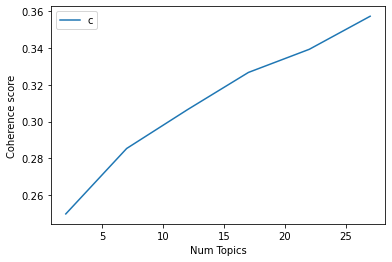

In [129]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [130]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2499
index: 1 | Num Topics = 7  has Coherence Value of 0.2854
index: 2 | Num Topics = 12  has Coherence Value of 0.3065
index: 3 | Num Topics = 17  has Coherence Value of 0.3266
index: 4 | Num Topics = 22  has Coherence Value of 0.3392
index: 5 | Num Topics = 27  has Coherence Value of 0.3571


In [179]:
# Select optimal number of topics
optimal_model_ph_2018_score1N2N3 = model_list_ph_2018_score1N2N3[5]

In [180]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2018_score1N2N3, corpus_ph_2018_score1N2N3, id2word_ph_2018_score1N2N3)

In [181]:
print("pyLDAVis for ph topics for score=1,2,3 in 2018:")
vis_ph_2018_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.103434 -0.009227       1        1  8.522637
8     -0.119864  0.020630       2        1  8.083124
25    -0.061109 -0.066911       3        1  7.666782
23    -0.056001 -0.088176       4        1  7.589812
26    -0.075011 -0.027814       5        1  6.001479
14    -0.082682  0.050934       6        1  5.818712
15    -0.099924 -0.050769       7        1  5.280952
18    -0.097563  0.076431       8        1  5.099195
9     -0.039982  0.051983       9        1  4.968143
16    -0.117510  0.009119      10        1  4.432891
20     0.025718  0.058615      11        1  4.055817
2      0.044872 -0.131478      12        1  3.862528
24    -0.037880  0.071096      13        1  3.746037
21    -0.066216  0.056975      14        1  2.879601
0      0.043632 -0.047483      15        1  2.354445
4      0.040536  0.009412      16        1  2.139413
10     0.142914  0.131228      17        1  2.111915
13     0.070770 -0.019469      18        1  2.024016
19     0.097870  0.051993      19        1  1.954821
22     0.070298 -0.140010      20        1  1.860972
11    -0.005757 -0.011250      21        1  1.799179
5      0.095804 -0.045630      22        1  1.520969
6      0.073922  0.026038      23        1  1.461301
12     0.091758  0.080792      24        1  1.276933
1      0.038321  0.035516      25        1  1.213209
7      0.081360 -0.059034      26        1  1.184883
17     0.045157 -0.033511      27        1  1.090233, topic_info=         Term       Freq      Total Category  logprob  loglift
62     update  88.000000  88.000000  Default  30.0000  30.0000
14      story  64.000000  64.000000  Default  29.0000  29.0000
21    feature  65.000000  65.000000  Default  28.0000  28.0000
73     really  30.000000  30.000000  Default  27.0000  27.0000
12       post  38.000000  38.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
74      video   0.022022  14.347313  Topic27  -7.3833  -1.9605
121      love   0.022022  26.182065  Topic27  -7.3833  -2.5620
393  whenever   0.022022   7.634357  Topic27  -7.3833  -1.3296
230   quality   0.022022   9.010487  Topic27  -7.3833  -1.4953
238       add   0.022022   7.896838  Topic27  -7.3833  -1.3634

[1333 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
332       2  0.267614  able
332       3  0.133807  able
332       9  0.401422  able
332      14  0.133807  able
332      18  0.133807  able
...     ...       ...   ...
556       5  0.611356   zap
65        4  0.193917  zoom
65       10  0.387835  zoom
65       23  0.193917  zoom
65       27  0.193917  zoom

[1870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 26, 24, 27, 15, 16, 19, 10, 17, 21, 3, 25, 22, 1, 5, 11, 14, 20, 23, 12, 6, 7, 13, 2, 8, 18])

## By-rating of 2019 (Rating=1,2,3)

In [134]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_ph_2019_score1N2N3 = instagram_ios_ph_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_ph_2019_score1N2N3 = list(sent_to_words(review_ph_2019_score1N2N3))
print(review_words_ph_2019_score1N2N3[:1])

[['after', 'updated', 'to', 'the', 'latest', 'version', 'it', 'became', 'slower', 'checking', 'stories', 'are', 'taking', 'minutes', 'before', 'it', 'will', 'pop', 'up', 'then', 'another', 'minutes', 'to', 'play', 'surely', 'it', 'wont', 'be', 'the', 'internet', 'cos', 'check', 'my', 'other', 'phone', 'ig', 'that', 'wasnt', 'updated', 'yet', 'and', 'it', 'is', 'way', 'more', 'faster', 'than', 'the', 'one', 'updated', 'please', 'fix', 'thanks', 'and', 'more', 'power']]


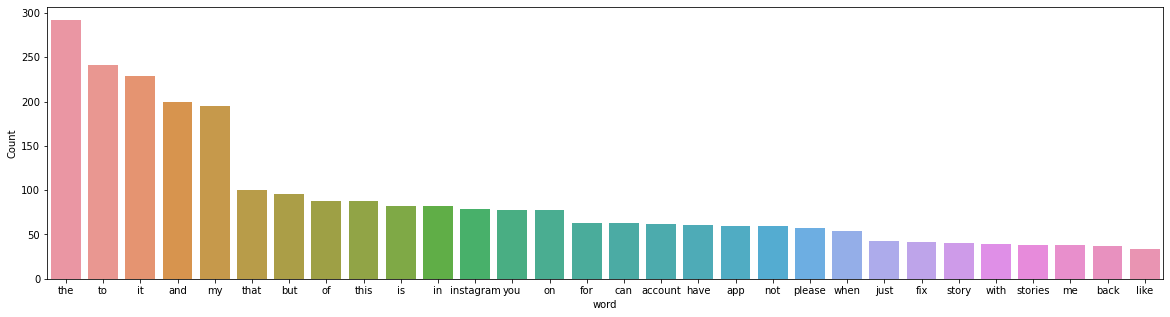

In [135]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2019_score1N2N3))

In [136]:
# Clean text
review_words_ph_ready_2019_score1N2N3 = process_words(review_words_ph_2019_score1N2N3)  # processed Text Data! - move to each section

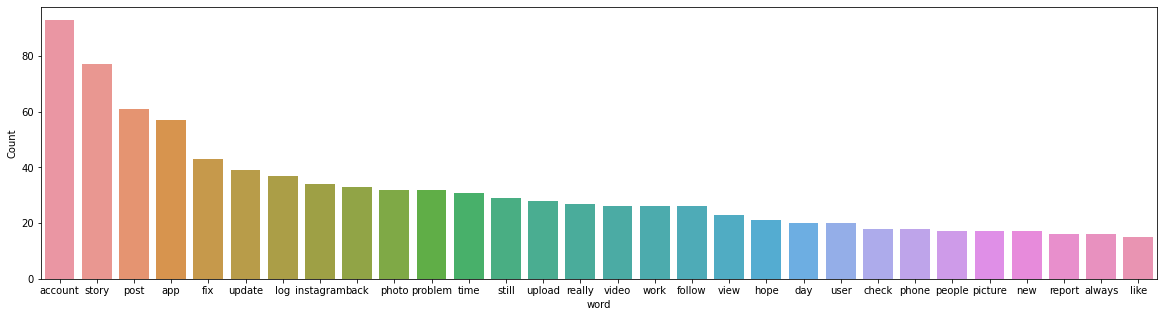

In [137]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2019_score1N2N3))


In [138]:
# Create Dictionary
id2word_ph_2019_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2019_score1N2N3)

2021-10-16 02:29:56,843 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:29:56,853 [INFO] gensim.corpora.dictionary - built Dictionary(717 unique tokens: ['become', 'check', 'fast', 'fix', 'internet']...) from 102 documents (total 2749 corpus positions)
2021-10-16 02:29:56,854 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(717 unique tokens: ['become', 'check', 'fast', 'fix', 'internet']...) from 102 documents (total 2749 corpus positions)", 'datetime': '2021-10-16T02:29:56.854422', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [139]:
# Create Corpus: Term Document Frequency
corpus_ph_2019_score1N2N3 = [id2word_ph_2019_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2019_score1N2N3]

In [140]:
# Training LDA model
model_list_ph_2019_score1N2N3, coherence_values_ph_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2019_score1N2N3, corpus=corpus_ph_2019_score1N2N3, 
                                                              texts=review_words_ph_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:29:56,891 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:29:56,892 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:29:56,894 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:29:56,896 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 102 documents, updating model once every 102 documents, evaluating perplexity every 102 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:29:57,352 [INFO] gensim.models.ldamodel - -7.146 per-word bound, 141.6 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:29:57,353 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #102/102
2021-10-16 02:29:57,646 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"account" + 0.028*"story" + 0.023*"app" + 0.014*"log" + 0.012*"post" + 0.012*"fix" + 0.011*"back" 

2021-10-16 02:30:01,651 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"account" + 0.025*"post" + 0.017*"fix" + 0.012*"update" + 0.011*"already" + 0.011*"photo" + 0.011*"instagram" + 0.010*"problem" + 0.010*"really" + 0.010*"day"
2021-10-16 02:30:01,651 [INFO] gensim.models.ldamodel - topic diff=0.010912, rho=0.301511
2021-10-16 02:30:01,907 [INFO] gensim.models.ldamodel - -6.169 per-word bound, 71.9 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:01,910 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #102/102
2021-10-16 02:30:02,101 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"story" + 0.027*"account" + 0.024*"app" + 0.014*"log" + 0.013*"back" + 0.013*"post" + 0.012*"video" + 0.011*"time" + 0.011*"update" + 0.011*"work"
2021-10-16 02:30:02,102 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"account" + 0.025*"post" + 0.017*"fix" + 0.012*"update" + 0.011*"already" + 0.011*"photo" + 0.011*"insta

2021-10-16 02:30:05,818 [INFO] gensim.models.ldamodel - topic diff=0.002567, rho=0.218218
2021-10-16 02:30:05,996 [INFO] gensim.models.ldamodel - -6.167 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:06,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #102/102
2021-10-16 02:30:06,204 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"story" + 0.027*"account" + 0.023*"app" + 0.014*"log" + 0.014*"post" + 0.013*"back" + 0.012*"video" + 0.011*"time" + 0.011*"update" + 0.011*"work"
2021-10-16 02:30:06,211 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"account" + 0.025*"post" + 0.017*"fix" + 0.012*"update" + 0.012*"already" + 0.011*"photo" + 0.011*"instagram" + 0.010*"really" + 0.010*"day" + 0.010*"problem"
2021-10-16 02:30:06,216 [INFO] gensim.models.ldamodel - topic diff=0.002398, rho=0.213201
2021-10-16 02:30:06,380 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity

2021-10-16 02:30:09,851 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:09,852 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #102/102
2021-10-16 02:30:09,979 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"story" + 0.027*"account" + 0.023*"app" + 0.014*"log" + 0.014*"post" + 0.013*"back" + 0.012*"video" + 0.011*"time" + 0.011*"update" + 0.011*"work"
2021-10-16 02:30:09,982 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"account" + 0.025*"post" + 0.017*"fix" + 0.012*"already" + 0.012*"update" + 0.011*"photo" + 0.011*"instagram" + 0.010*"really" + 0.010*"day" + 0.009*"problem"
2021-10-16 02:30:09,984 [INFO] gensim.models.ldamodel - topic diff=0.001605, rho=0.176777
2021-10-16 02:30:10,177 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:10,

2021-10-16 02:30:13,505 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #102/102
2021-10-16 02:30:13,677 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"story" + 0.027*"account" + 0.023*"app" + 0.014*"log" + 0.014*"post" + 0.013*"back" + 0.012*"video" + 0.011*"update" + 0.011*"time" + 0.011*"work"
2021-10-16 02:30:13,679 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"account" + 0.025*"post" + 0.017*"fix" + 0.012*"already" + 0.012*"update" + 0.011*"photo" + 0.011*"instagram" + 0.010*"really" + 0.010*"day" + 0.009*"user"
2021-10-16 02:30:13,682 [INFO] gensim.models.ldamodel - topic diff=0.001163, rho=0.154303
2021-10-16 02:30:13,898 [INFO] gensim.models.ldamodel - -6.166 per-word bound, 71.8 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:13,899 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #102/102
2021-10-16 02:30:14,016 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"story" + 0

2021-10-16 02:30:16,979 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:30:20,927 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:30:20,968 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 102 virtual documents
2021-10-16 02:30:21,220 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:30:21,222 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:30:21,227 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:30:21,230 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 102 documents, updating model once every 102 documents, evaluating perplexity every 102 documents, iterating 50x with a con

2021-10-16 02:30:23,585 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"account" + 0.035*"post" + 0.019*"instagram" + 0.019*"follow" + 0.017*"photo" + 0.017*"quality" + 0.015*"story" + 0.014*"friend" + 0.013*"activity" + 0.012*"feature"
2021-10-16 02:30:23,586 [INFO] gensim.models.ldamodel - topic diff=0.070823, rho=0.408248
2021-10-16 02:30:23,815 [INFO] gensim.models.ldamodel - -6.361 per-word bound, 82.2 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:23,819 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #102/102
2021-10-16 02:30:23,980 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"account" + 0.021*"app" + 0.016*"day" + 0.016*"follower" + 0.015*"log" + 0.015*"email" + 0.013*"phone" + 0.013*"different" + 0.013*"wait" + 0.011*"follow"
2021-10-16 02:30:23,987 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"story" + 0.028*"back" + 0.019*"view" + 0.019*"account" + 0.017*"app" + 0.016*"photo" + 0.

2021-10-16 02:30:25,683 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"caption" + 0.018*"fix" + 0.018*"user" + 0.015*"account" + 0.014*"post" + 0.013*"already" + 0.011*"really" + 0.011*"change" + 0.011*"update" + 0.010*"picture"
2021-10-16 02:30:25,686 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"account" + 0.038*"post" + 0.020*"instagram" + 0.019*"quality" + 0.019*"follow" + 0.018*"photo" + 0.015*"story" + 0.015*"friend" + 0.013*"activity" + 0.013*"feature"
2021-10-16 02:30:25,688 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.047*"story" + 0.030*"back" + 0.021*"view" + 0.018*"app" + 0.016*"photo" + 0.014*"account" + 0.013*"upload" + 0.013*"check" + 0.013*"bring" + 0.012*"update"
2021-10-16 02:30:25,690 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"account" + 0.021*"app" + 0.018*"day" + 0.016*"log" + 0.016*"follower" + 0.015*"email" + 0.014*"phone" + 0.013*"different" + 0.013*"wait" + 0.011*"follow"
2021-10-16 02:30:25,693 [INFO] gensim.models.lda

2021-10-16 02:30:27,017 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"account" + 0.039*"post" + 0.020*"instagram" + 0.019*"quality" + 0.019*"follow" + 0.018*"photo" + 0.015*"story" + 0.015*"friend" + 0.013*"activity" + 0.013*"feature"
2021-10-16 02:30:27,019 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"caption" + 0.018*"fix" + 0.018*"user" + 0.015*"account" + 0.015*"already" + 0.014*"post" + 0.012*"change" + 0.011*"really" + 0.011*"update" + 0.011*"iphone"
2021-10-16 02:30:27,020 [INFO] gensim.models.ldamodel - topic diff=0.005515, rho=0.242536
2021-10-16 02:30:27,158 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:27,162 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #102/102
2021-10-16 02:30:27,254 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"log" + 0.048*"account" + 0.023*"fix" + 0.022*"problem" + 0.020*"time" + 0.019*"post" 

2021-10-16 02:30:28,482 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #102/102
2021-10-16 02:30:28,552 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"story" + 0.031*"back" + 0.022*"view" + 0.018*"app" + 0.016*"check" + 0.016*"photo" + 0.014*"upload" + 0.014*"bring" + 0.012*"update" + 0.012*"always"
2021-10-16 02:30:28,554 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"story" + 0.031*"app" + 0.023*"account" + 0.023*"post" + 0.021*"work" + 0.017*"still" + 0.017*"video" + 0.017*"update" + 0.016*"hope" + 0.016*"delete"
2021-10-16 02:30:28,557 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.026*"follow" + 0.018*"feedback" + 0.009*"day" + 0.009*"work" + 0.009*"issue" + 0.009*"still" + 0.009*"unfair" + 0.009*"check" + 0.009*"date" + 0.009*"week"
2021-10-16 02:30:28,560 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"account" + 0.039*"post" + 0.020*"instagram" + 0.019*"quality" + 0.019*"follow" + 0.018*"photo" + 0.015*"story" + 0.015*"friend" +

2021-10-16 02:30:29,887 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"account" + 0.021*"app" + 0.019*"day" + 0.016*"log" + 0.016*"follower" + 0.016*"email" + 0.014*"phone" + 0.013*"different" + 0.013*"wait" + 0.012*"follow"
2021-10-16 02:30:29,892 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.049*"story" + 0.031*"back" + 0.022*"view" + 0.018*"app" + 0.017*"check" + 0.017*"photo" + 0.015*"upload" + 0.014*"bring" + 0.012*"update" + 0.012*"always"
2021-10-16 02:30:29,894 [INFO] gensim.models.ldamodel - topic diff=0.002352, rho=0.188982
2021-10-16 02:30:30,037 [INFO] gensim.models.ldamodel - -6.328 per-word bound, 80.3 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:30,038 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #102/102
2021-10-16 02:30:30,144 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"caption" + 0.018*"user" + 0.018*"fix" + 0.018*"already" + 0.015*"change" + 0.014*"account" + 0.014*"pos

2021-10-16 02:30:31,285 [INFO] gensim.models.ldamodel - -6.326 per-word bound, 80.2 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:31,289 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #102/102
2021-10-16 02:30:31,397 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"account" + 0.020*"app" + 0.019*"day" + 0.016*"log" + 0.016*"follower" + 0.016*"email" + 0.014*"phone" + 0.013*"different" + 0.013*"wait" + 0.012*"follow"
2021-10-16 02:30:31,414 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.050*"story" + 0.032*"back" + 0.022*"view" + 0.018*"app" + 0.018*"check" + 0.017*"photo" + 0.015*"upload" + 0.015*"bring" + 0.012*"update" + 0.012*"always"
2021-10-16 02:30:31,438 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"story" + 0.031*"app" + 0.023*"post" + 0.023*"account" + 0.021*"work" + 0.017*"video" + 0.017*"still" + 0.017*"update" + 0.016*"delete" + 0.016*"hope"
2021-10-16 02:30:31,469 [INFO] gensim.model

2021-10-16 02:30:32,749 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.050*"story" + 0.032*"back" + 0.022*"view" + 0.018*"app" + 0.018*"check" + 0.017*"photo" + 0.015*"upload" + 0.015*"bring" + 0.012*"update" + 0.012*"always"
2021-10-16 02:30:32,750 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"log" + 0.051*"account" + 0.023*"fix" + 0.022*"problem" + 0.021*"time" + 0.019*"post" + 0.018*"app" + 0.015*"update" + 0.011*"long" + 0.011*"back"
2021-10-16 02:30:32,753 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"story" + 0.031*"app" + 0.023*"post" + 0.023*"account" + 0.021*"work" + 0.017*"video" + 0.017*"still" + 0.017*"update" + 0.016*"delete" + 0.016*"hope"
2021-10-16 02:30:32,754 [INFO] gensim.models.ldamodel - topic diff=0.001454, rho=0.160128
2021-10-16 02:30:32,911 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:32,913 [INFO] gensim.models.ldamodel - P

2021-10-16 02:30:33,885 [INFO] gensim.models.ldamodel - topic diff=0.001053, rho=0.150756
2021-10-16 02:30:33,985 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:33,986 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #102/102
2021-10-16 02:30:34,118 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.050*"story" + 0.032*"back" + 0.022*"view" + 0.018*"check" + 0.018*"app" + 0.017*"photo" + 0.016*"upload" + 0.015*"bring" + 0.012*"update" + 0.012*"always"
2021-10-16 02:30:34,120 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.049*"account" + 0.040*"post" + 0.020*"instagram" + 0.019*"quality" + 0.019*"follow" + 0.018*"photo" + 0.016*"story" + 0.015*"friend" + 0.013*"feature" + 0.013*"activity"
2021-10-16 02:30:34,121 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"story" + 0.031*"app" + 0.023*"post" + 0.023*"account" + 0.021*"work" + 0.017*"video" + 0.017

2021-10-16 02:30:35,197 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"log" + 0.051*"account" + 0.022*"fix" + 0.022*"problem" + 0.021*"time" + 0.019*"post" + 0.018*"app" + 0.015*"update" + 0.011*"long" + 0.011*"back"
2021-10-16 02:30:35,198 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.019*"caption" + 0.018*"user" + 0.018*"already" + 0.017*"fix" + 0.016*"change" + 0.014*"account" + 0.014*"post" + 0.013*"iphone" + 0.013*"picture" + 0.012*"version"
2021-10-16 02:30:35,201 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"story" + 0.031*"app" + 0.023*"post" + 0.023*"account" + 0.021*"work" + 0.018*"video" + 0.017*"still" + 0.017*"update" + 0.016*"delete" + 0.016*"hope"
2021-10-16 02:30:35,202 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.049*"account" + 0.040*"post" + 0.020*"instagram" + 0.019*"quality" + 0.019*"follow" + 0.018*"photo" + 0.016*"story" + 0.015*"friend" + 0.013*"feature" + 0.013*"activity"
2021-10-16 02:30:35,204 [INFO] gensim.models.ldamodel - 

2021-10-16 02:30:42,020 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.036*"photo" + 0.033*"upload" + 0.020*"back" + 0.020*"post" + 0.018*"image" + 0.017*"multiple" + 0.017*"quality" + 0.016*"follow" + 0.016*"profile" + 0.013*"video"
2021-10-16 02:30:42,022 [INFO] gensim.models.ldamodel - topic diff=0.246459, rho=0.500000
2021-10-16 02:30:42,158 [INFO] gensim.models.ldamodel - -6.548 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:42,159 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #102/102
2021-10-16 02:30:42,270 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.034*"account" + 0.032*"wait" + 0.030*"day" + 0.022*"log" + 0.021*"phone" + 0.016*"violate" + 0.016*"term" + 0.014*"already" + 0.013*"kindly" + 0.013*"error"
2021-10-16 02:30:42,273 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.002*"follow" + 0.002*"feedback" + 0.002*"week" + 0.002*"unblocked" + 0.002*"day" + 0.002*"email" + 0.00

2021-10-16 02:30:43,417 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"story" + 0.033*"app" + 0.031*"video" + 0.027*"update" + 0.027*"post" + 0.022*"still" + 0.021*"problem" + 0.019*"time" + 0.018*"work" + 0.017*"fix"
2021-10-16 02:30:43,420 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.062*"log" + 0.048*"account" + 0.028*"post" + 0.023*"fix" + 0.020*"instagram" + 0.014*"time" + 0.014*"long" + 0.014*"still" + 0.014*"problem" + 0.013*"update"
2021-10-16 02:30:43,424 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.052*"post" + 0.031*"check" + 0.028*"account" + 0.026*"follower" + 0.021*"able" + 0.021*"story" + 0.017*"different" + 0.017*"instagram" + 0.015*"image" + 0.013*"day"
2021-10-16 02:30:43,428 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.036*"account" + 0.032*"wait" + 0.032*"day" + 0.022*"phone" + 0.021*"log" + 0.019*"violate" + 0.019*"term" + 0.013*"already" + 0.013*"kindly" + 0.013*"error"
2021-10-16 02:30:43,430 [INFO] gensim.models.ldamodel - topic di

2021-10-16 02:30:44,719 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.039*"account" + 0.019*"follow" + 0.016*"time" + 0.015*"story" + 0.015*"phone" + 0.014*"report" + 0.013*"app" + 0.013*"option" + 0.013*"like" + 0.011*"view"
2021-10-16 02:30:44,721 [INFO] gensim.models.ldamodel - topic diff=0.011122, rho=0.258199
2021-10-16 02:30:44,846 [INFO] gensim.models.ldamodel - -6.449 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:44,858 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #102/102
2021-10-16 02:30:44,972 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.048*"account" + 0.029*"really" + 0.024*"fix" + 0.019*"story" + 0.019*"view" + 0.018*"instagram" + 0.015*"app" + 0.015*"problem" + 0.014*"still" + 0.013*"sticker"
2021-10-16 02:30:44,975 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"post" + 0.030*"check" + 0.028*"account" + 0.025*"follower" + 0.021*"able" + 0.020*"story" + 0.019*

2021-10-16 02:30:46,242 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.001*"follow" + 0.001*"feedback" + 0.001*"week" + 0.001*"unblocked" + 0.001*"day" + 0.001*"email" + 0.001*"check" + 0.001*"still" + 0.001*"issue" + 0.001*"back"
2021-10-16 02:30:46,244 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.109*"story" + 0.051*"back" + 0.036*"view" + 0.026*"viewer" + 0.024*"really" + 0.020*"update" + 0.020*"bring" + 0.020*"app" + 0.016*"person" + 0.015*"way"
2021-10-16 02:30:46,246 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"app" + 0.025*"fix" + 0.022*"email" + 0.019*"post" + 0.019*"work" + 0.019*"story" + 0.019*"delete" + 0.019*"block" + 0.018*"caption" + 0.016*"day"
2021-10-16 02:30:46,248 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.048*"account" + 0.031*"really" + 0.024*"fix" + 0.019*"instagram" + 0.019*"view" + 0.018*"story" + 0.015*"app" + 0.014*"problem" + 0.014*"still" + 0.013*"countdown"
2021-10-16 02:30:46,251 [INFO] gensim.models.ldamodel - topic #2 

2021-10-16 02:30:47,367 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.044*"account" + 0.028*"story" + 0.018*"follow" + 0.017*"app" + 0.017*"post" + 0.016*"instagram" + 0.015*"feature" + 0.013*"activity" + 0.013*"remove" + 0.013*"photo"
2021-10-16 02:30:47,369 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.112*"story" + 0.052*"back" + 0.040*"view" + 0.027*"viewer" + 0.024*"really" + 0.021*"update" + 0.020*"bring" + 0.020*"app" + 0.016*"person" + 0.015*"way"
2021-10-16 02:30:47,370 [INFO] gensim.models.ldamodel - topic diff=0.002767, rho=0.196116
2021-10-16 02:30:47,513 [INFO] gensim.models.ldamodel - -6.440 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:47,514 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #102/102
2021-10-16 02:30:47,623 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"story" + 0.032*"app" + 0.032*"video" + 0.028*"update" + 0.027*"post" + 0.024*"problem" + 0.023*"s

2021-10-16 02:30:48,648 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:48,652 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #102/102
2021-10-16 02:30:48,747 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"account" + 0.020*"follow" + 0.017*"time" + 0.015*"phone" + 0.014*"app" + 0.014*"option" + 0.014*"like" + 0.013*"story" + 0.013*"report" + 0.011*"anymore"
2021-10-16 02:30:48,749 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.037*"account" + 0.032*"wait" + 0.032*"day" + 0.023*"phone" + 0.021*"log" + 0.020*"violate" + 0.020*"term" + 0.013*"already" + 0.013*"error" + 0.013*"kindly"
2021-10-16 02:30:48,750 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"story" + 0.032*"app" + 0.032*"video" + 0.028*"update" + 0.027*"post" + 0.024*"problem" + 0.023*"still" + 0.020*"time" + 0.019*"work" + 0.019*"fix"
2021-10-16 02:30:48,752 [INFO] gensim.models

2021-10-16 02:30:50,091 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"app" + 0.025*"fix" + 0.022*"email" + 0.019*"post" + 0.019*"work" + 0.019*"story" + 0.019*"delete" + 0.019*"block" + 0.018*"caption" + 0.017*"day"
2021-10-16 02:30:50,102 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.035*"photo" + 0.034*"upload" + 0.019*"image" + 0.019*"post" + 0.018*"back" + 0.017*"follow" + 0.017*"profile" + 0.017*"multiple" + 0.017*"quality" + 0.015*"video"
2021-10-16 02:30:50,111 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.050*"account" + 0.031*"really" + 0.025*"fix" + 0.021*"instagram" + 0.015*"app" + 0.015*"problem" + 0.014*"still" + 0.013*"sticker" + 0.013*"countdown" + 0.012*"delete"
2021-10-16 02:30:50,112 [INFO] gensim.models.ldamodel - topic diff=0.001251, rho=0.164399
2021-10-16 02:30:50,168 [INFO] gensim.models.ldamodel - -6.436 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:50,169 [INFO] gen

2021-10-16 02:30:51,299 [INFO] gensim.models.ldamodel - topic diff=0.000859, rho=0.154303
2021-10-16 02:30:51,432 [INFO] gensim.models.ldamodel - -6.436 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:30:51,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #102/102
2021-10-16 02:30:51,525 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"user" + 0.035*"account" + 0.019*"ever" + 0.019*"never" + 0.019*"view" + 0.019*"inappropriate" + 0.018*"story" + 0.010*"social" + 0.010*"already" + 0.010*"dark"
2021-10-16 02:30:51,528 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.035*"photo" + 0.034*"upload" + 0.019*"image" + 0.019*"post" + 0.018*"back" + 0.017*"follow" + 0.017*"profile" + 0.017*"multiple" + 0.017*"quality" + 0.015*"video"
2021-10-16 02:30:51,530 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"account" + 0.019*"follow" + 0.017*"time" + 0.015*"phone" + 0.014*"app" + 0.014*"option" +

2021-10-16 02:30:52,869 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"account" + 0.019*"follow" + 0.017*"time" + 0.015*"phone" + 0.014*"app" + 0.014*"option" + 0.014*"like" + 0.013*"report" + 0.013*"story" + 0.011*"anymore"
2021-10-16 02:30:52,870 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.037*"account" + 0.032*"wait" + 0.032*"day" + 0.023*"phone" + 0.021*"log" + 0.020*"violate" + 0.020*"term" + 0.013*"already" + 0.013*"error" + 0.013*"thing"
2021-10-16 02:30:52,872 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"story" + 0.032*"app" + 0.032*"video" + 0.028*"update" + 0.027*"post" + 0.024*"problem" + 0.023*"still" + 0.020*"time" + 0.019*"work" + 0.019*"fix"
2021-10-16 02:30:52,874 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.054*"post" + 0.029*"check" + 0.028*"account" + 0.025*"follower" + 0.021*"image" + 0.021*"able" + 0.020*"instagram" + 0.020*"story" + 0.017*"different" + 0.016*"well"
2021-10-16 02:30:52,875 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:31:00,279 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.031*"back" + 0.031*"story" + 0.024*"post" + 0.023*"check" + 0.023*"like" + 0.022*"follower" + 0.020*"bring" + 0.020*"people" + 0.016*"different" + 0.016*"user"
2021-10-16 02:31:00,285 [INFO] gensim.models.ldamodel - topic diff=12.472568, rho=1.000000
2021-10-16 02:31:00,496 [INFO] gensim.models.ldamodel - -6.883 per-word bound, 118.0 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:00,497 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #102/102
2021-10-16 02:31:00,618 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.052*"story" + 0.032*"app" + 0.022*"account" + 0.017*"video" + 0.016*"picture" + 0.016*"still" + 0.014*"fix" + 0.014*"work" + 0.014*"time" + 0.012*"view"
2021-10-16 02:31:00,619 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"app" + 0.027*"work" + 0.026*"properly" + 0.014*"past" + 0.014*"almost" + 0.014*"limit" + 0.014*"people

2021-10-16 02:31:01,879 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"story" + 0.031*"app" + 0.022*"account" + 0.017*"picture" + 0.016*"video" + 0.015*"still" + 0.014*"fix" + 0.014*"work" + 0.014*"time" + 0.011*"view"
2021-10-16 02:31:01,882 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.030*"caption" + 0.030*"post" + 0.030*"email" + 0.024*"fix" + 0.018*"block" + 0.018*"report" + 0.018*"reply" + 0.018*"help" + 0.015*"problem" + 0.012*"comment"
2021-10-16 02:31:01,887 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.051*"account" + 0.039*"follow" + 0.026*"learn" + 0.026*"still" + 0.026*"unfortunately" + 0.026*"feedback" + 0.026*"tab" + 0.026*"report" + 0.026*"user" + 0.013*"ban"
2021-10-16 02:31:01,888 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.075*"account" + 0.029*"post" + 0.023*"story" + 0.019*"follow" + 0.016*"instagram" + 0.013*"activity" + 0.013*"remove" + 0.013*"work" + 0.013*"feature" + 0.013*"fix"
2021-10-16 02:31:01,889 [INFO] gensim.models.ldamod

2021-10-16 02:31:02,982 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"story" + 0.031*"app" + 0.022*"account" + 0.017*"picture" + 0.016*"video" + 0.015*"still" + 0.014*"fix" + 0.014*"work" + 0.014*"time" + 0.011*"view"
2021-10-16 02:31:02,985 [INFO] gensim.models.ldamodel - topic diff=0.012563, rho=0.277350
2021-10-16 02:31:03,145 [INFO] gensim.models.ldamodel - -6.529 per-word bound, 92.3 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:03,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #102/102
2021-10-16 02:31:03,248 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.044*"account" + 0.039*"app" + 0.018*"post" + 0.018*"like" + 0.018*"always" + 0.018*"party" + 0.013*"story" + 0.013*"change" + 0.013*"old" + 0.013*"update"
2021-10-16 02:31:03,255 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.040*"account" + 0.025*"wait" + 0.020*"day" + 0.020*"phone" + 0.020*"app" + 0.015*"log" + 0.015*"error" + 0.015*"n

2021-10-16 02:31:04,439 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"story" + 0.031*"app" + 0.022*"account" + 0.017*"picture" + 0.015*"video" + 0.015*"still" + 0.014*"fix" + 0.014*"work" + 0.014*"time" + 0.011*"view"
2021-10-16 02:31:04,441 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.036*"story" + 0.033*"view" + 0.030*"account" + 0.022*"change" + 0.022*"instagram" + 0.019*"version" + 0.019*"picture" + 0.015*"post" + 0.015*"archive" + 0.015*"list"
2021-10-16 02:31:04,442 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.040*"account" + 0.025*"wait" + 0.020*"day" + 0.020*"phone" + 0.020*"app" + 0.015*"log" + 0.015*"error" + 0.015*"notification" + 0.010*"follow" + 0.010*"still"
2021-10-16 02:31:04,445 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"app" + 0.030*"work" + 0.030*"properly" + 0.016*"past" + 0.016*"almost" + 0.016*"limit" + 0.016*"people" + 0.016*"exceed" + 0.016*"upload" + 0.016*"hour"
2021-10-16 02:31:04,448 [INFO] gensim.models.ldamodel - top

2021-10-16 02:31:05,620 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.024*"account" + 0.024*"fix" + 0.023*"update" + 0.023*"post" + 0.020*"log" + 0.020*"time" + 0.016*"long" + 0.012*"back" + 0.012*"order" + 0.012*"app"
2021-10-16 02:31:05,622 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.074*"account" + 0.029*"post" + 0.023*"story" + 0.019*"follow" + 0.016*"instagram" + 0.013*"activity" + 0.013*"remove" + 0.013*"work" + 0.013*"feature" + 0.013*"fix"
2021-10-16 02:31:05,624 [INFO] gensim.models.ldamodel - topic diff=0.001340, rho=0.204124
2021-10-16 02:31:05,774 [INFO] gensim.models.ldamodel - -6.524 per-word bound, 92.0 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:05,776 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #102/102
2021-10-16 02:31:05,864 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"post" + 0.025*"caption" + 0.025*"update" + 0.025*"story" + 0.025*"video" + 0.017*"fix" + 0.017*"picture

2021-10-16 02:31:07,033 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #102/102
2021-10-16 02:31:07,125 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"app" + 0.030*"work" + 0.030*"properly" + 0.016*"past" + 0.016*"almost" + 0.016*"limit" + 0.016*"people" + 0.016*"exceed" + 0.016*"upload" + 0.016*"hour"
2021-10-16 02:31:07,126 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.051*"account" + 0.039*"follow" + 0.026*"learn" + 0.026*"still" + 0.026*"unfortunately" + 0.026*"feedback" + 0.026*"tab" + 0.026*"report" + 0.026*"user" + 0.013*"always"
2021-10-16 02:31:07,127 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.050*"follow" + 0.034*"feedback" + 0.017*"back" + 0.017*"still" + 0.017*"week" + 0.017*"issue" + 0.017*"unblocked" + 0.017*"day" + 0.017*"today" + 0.017*"email"
2021-10-16 02:31:07,129 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.036*"story" + 0.034*"view" + 0.030*"account" + 0.022*"change" + 0.022*"instagram" + 0.019*"version" + 0.019*"pi

2021-10-16 02:31:08,383 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.030*"caption" + 0.030*"post" + 0.030*"email" + 0.024*"fix" + 0.018*"block" + 0.018*"report" + 0.018*"reply" + 0.018*"help" + 0.016*"problem" + 0.012*"comment"
2021-10-16 02:31:08,385 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"post" + 0.025*"caption" + 0.025*"update" + 0.025*"story" + 0.025*"video" + 0.017*"fix" + 0.017*"picture" + 0.017*"hope" + 0.017*"well" + 0.017*"guy"
2021-10-16 02:31:08,386 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.024*"account" + 0.024*"fix" + 0.023*"update" + 0.023*"post" + 0.020*"log" + 0.020*"time" + 0.016*"long" + 0.012*"back" + 0.012*"order" + 0.012*"app"
2021-10-16 02:31:08,389 [INFO] gensim.models.ldamodel - topic diff=0.000256, rho=0.169031
2021-10-16 02:31:08,540 [INFO] gensim.models.ldamodel - -6.524 per-word bound, 92.0 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:08,543 [INFO] gensim.models.ldamodel -

2021-10-16 02:31:09,561 [INFO] gensim.models.ldamodel - topic diff=0.000114, rho=0.158114
2021-10-16 02:31:09,749 [INFO] gensim.models.ldamodel - -6.524 per-word bound, 92.0 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:09,752 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #102/102
2021-10-16 02:31:09,849 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.044*"account" + 0.039*"app" + 0.018*"post" + 0.018*"always" + 0.018*"like" + 0.018*"party" + 0.013*"story" + 0.013*"old" + 0.013*"update" + 0.013*"feature"
2021-10-16 02:31:09,863 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"app" + 0.030*"work" + 0.030*"properly" + 0.016*"past" + 0.016*"almost" + 0.016*"people" + 0.016*"limit" + 0.016*"exceed" + 0.016*"upload" + 0.016*"hour"
2021-10-16 02:31:09,877 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"story" + 0.031*"app" + 0.022*"account" + 0.017*"picture" + 0.015*"video" + 0.015*"still" + 0.014*"fix

2021-10-16 02:31:11,019 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.094*"log" + 0.053*"account" + 0.035*"app" + 0.027*"problem" + 0.022*"still" + 0.022*"instagram" + 0.017*"open" + 0.017*"user" + 0.015*"fix" + 0.015*"already"
2021-10-16 02:31:11,026 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.036*"story" + 0.034*"view" + 0.030*"account" + 0.023*"change" + 0.022*"instagram" + 0.019*"picture" + 0.019*"version" + 0.015*"post" + 0.015*"archive" + 0.015*"list"
2021-10-16 02:31:11,030 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"post" + 0.025*"caption" + 0.025*"update" + 0.025*"story" + 0.025*"video" + 0.017*"fix" + 0.017*"picture" + 0.017*"hope" + 0.017*"well" + 0.017*"guy"
2021-10-16 02:31:11,031 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.044*"account" + 0.039*"app" + 0.018*"post" + 0.018*"like" + 0.018*"always" + 0.018*"party" + 0.013*"story" + 0.013*"old" + 0.013*"update" + 0.013*"feature"
2021-10-16 02:31:11,033 [INFO] gensim.models.ldamodel - topi

2021-10-16 02:31:12,229 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.074*"upload" + 0.049*"photo" + 0.022*"story" + 0.022*"time" + 0.020*"video" + 0.019*"back" + 0.017*"profile" + 0.017*"app" + 0.017*"quality" + 0.013*"image"
2021-10-16 02:31:12,246 [INFO] gensim.models.ldamodel - topic diff=0.000020, rho=0.140028
2021-10-16 02:31:12,248 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=717, num_topics=17, decay=0.5, chunksize=1000) in 12.64s', 'datetime': '2021-10-16T02:31:12.248637', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:31:12,255 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:31:16,269 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-

2021-10-16 02:31:20,655 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.041*"app" + 0.035*"account" + 0.035*"post" + 0.023*"party" + 0.022*"image" + 0.022*"instagram" + 0.021*"quality" + 0.018*"rd" + 0.016*"well" + 0.015*"photo"
2021-10-16 02:31:20,658 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.037*"friend" + 0.037*"suggest" + 0.025*"music" + 0.025*"story" + 0.025*"follow" + 0.021*"app" + 0.019*"video" + 0.013*"available" + 0.013*"subscription" + 0.013*"ago"
2021-10-16 02:31:20,659 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.034*"time" + 0.033*"picture" + 0.033*"problem" + 0.033*"already" + 0.019*"account" + 0.018*"story" + 0.017*"app" + 0.017*"first" + 0.017*"put" + 0.017*"encounter"
2021-10-16 02:31:20,660 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.055*"account" + 0.047*"log" + 0.032*"post" + 0.029*"fix" + 0.021*"problem" + 0.017*"long" + 0.015*"love" + 0.014*"update" + 0.013*"story" + 0.013*"share"
2021-10-16 02:31:20,661 [INFO] gensim.models.ldamode

2021-10-16 02:31:21,777 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.050*"post" + 0.042*"update" + 0.041*"upload" + 0.031*"photo" + 0.031*"promote" + 0.031*"carousel" + 0.031*"uninstall" + 0.031*"video" + 0.025*"always" + 0.021*"install"
2021-10-16 02:31:21,778 [INFO] gensim.models.ldamodel - topic diff=0.041178, rho=0.301511
2021-10-16 02:31:21,878 [INFO] gensim.models.ldamodel - -6.620 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:21,880 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #102/102
2021-10-16 02:31:22,006 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.053*"account" + 0.045*"log" + 0.035*"fix" + 0.035*"post" + 0.023*"problem" + 0.018*"block" + 0.017*"long" + 0.016*"love" + 0.014*"update" + 0.013*"caption"
2021-10-16 02:31:22,009 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.041*"app" + 0.036*"story" + 0.030*"video" + 0.024*"update" + 0.024*"post" + 0.023*"hope" + 0.019

2021-10-16 02:31:23,127 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.073*"log" + 0.055*"acc" + 0.037*"account" + 0.019*"listen" + 0.019*"help" + 0.019*"happen" + 0.019*"game" + 0.019*"idk" + 0.019*"delete" + 0.019*"suppose"
2021-10-16 02:31:23,128 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.056*"account" + 0.047*"log" + 0.029*"problem" + 0.023*"still" + 0.023*"story" + 0.023*"sticker" + 0.023*"countdown" + 0.017*"version" + 0.017*"user" + 0.017*"time"
2021-10-16 02:31:23,130 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.052*"account" + 0.044*"log" + 0.038*"fix" + 0.037*"post" + 0.024*"problem" + 0.020*"block" + 0.019*"caption" + 0.016*"long" + 0.016*"love" + 0.014*"update"
2021-10-16 02:31:23,131 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.061*"account" + 0.041*"story" + 0.021*"upload" + 0.018*"photo" + 0.017*"report" + 0.017*"update" + 0.017*"instagram" + 0.015*"video" + 0.015*"fix" + 0.014*"gallery"
2021-10-16 02:31:23,133 [INFO] gensim.models.ldamodel -

2021-10-16 02:31:24,431 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.045*"email" + 0.018*"already" + 0.018*"resolution" + 0.018*"problem" + 0.018*"report" + 0.018*"reply" + 0.018*"help" + 0.018*"create" + 0.018*"find" + 0.018*"screen"
2021-10-16 02:31:24,435 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.086*"account" + 0.029*"log" + 0.026*"post" + 0.024*"fix" + 0.020*"instagram" + 0.020*"caption" + 0.020*"day" + 0.013*"option" + 0.013*"non" + 0.013*"translation"
2021-10-16 02:31:24,437 [INFO] gensim.models.ldamodel - topic diff=0.003542, rho=0.213201
2021-10-16 02:31:24,619 [INFO] gensim.models.ldamodel - -6.606 per-word bound, 97.4 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:24,620 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #102/102
2021-10-16 02:31:24,756 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.040*"app" + 0.038*"post" + 0.036*"account" + 0.024*"instagram" + 0.023*"party" + 0.023*"ima

2021-10-16 02:31:26,091 [INFO] gensim.models.ldamodel - -6.604 per-word bound, 97.3 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:26,092 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #102/102
2021-10-16 02:31:26,144 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.050*"story" + 0.029*"video" + 0.027*"still" + 0.027*"work" + 0.024*"picture" + 0.024*"archive" + 0.022*"problem" + 0.018*"view" + 0.018*"audio" + 0.018*"error"
2021-10-16 02:31:26,146 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.034*"time" + 0.034*"already" + 0.034*"problem" + 0.034*"picture" + 0.018*"account" + 0.018*"story" + 0.018*"app" + 0.018*"first" + 0.018*"edit" + 0.018*"yet"
2021-10-16 02:31:26,147 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.038*"notification" + 0.029*"app" + 0.019*"story" + 0.019*"account" + 0.019*"new" + 0.019*"page" + 0.019*"fun" + 0.019*"tab" + 0.019*"explore" + 0.013*"activity"
2021-10-16 02:31:26,150 [INFO] 

2021-10-16 02:31:27,490 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.049*"post" + 0.038*"like" + 0.034*"follower" + 0.031*"check" + 0.029*"day" + 0.024*"account" + 0.024*"follow" + 0.019*"different" + 0.019*"number" + 0.019*"able"
2021-10-16 02:31:27,492 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.073*"log" + 0.055*"acc" + 0.037*"account" + 0.019*"listen" + 0.019*"help" + 0.019*"game" + 0.019*"happen" + 0.019*"idk" + 0.019*"delete" + 0.019*"suppose"
2021-10-16 02:31:27,493 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.039*"friend" + 0.039*"suggest" + 0.026*"music" + 0.026*"story" + 0.026*"follow" + 0.019*"app" + 0.018*"video" + 0.014*"ago" + 0.014*"available" + 0.014*"region"
2021-10-16 02:31:27,494 [INFO] gensim.models.ldamodel - topic diff=0.000805, rho=0.174078
2021-10-16 02:31:27,708 [INFO] gensim.models.ldamodel - -6.603 per-word bound, 97.2 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:27,709 [INFO] gensim.m

2021-10-16 02:31:28,931 [INFO] gensim.models.ldamodel - topic diff=0.000455, rho=0.162221
2021-10-16 02:31:29,065 [INFO] gensim.models.ldamodel - -6.603 per-word bound, 97.2 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:29,066 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #102/102
2021-10-16 02:31:29,181 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.055*"account" + 0.033*"wait" + 0.033*"phone" + 0.033*"log" + 0.022*"submit" + 0.022*"still" + 0.022*"term" + 0.022*"later" + 0.022*"form" + 0.022*"thing"
2021-10-16 02:31:29,184 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.073*"log" + 0.055*"acc" + 0.037*"account" + 0.019*"listen" + 0.019*"game" + 0.019*"help" + 0.019*"happen" + 0.019*"idk" + 0.019*"delete" + 0.019*"suppose"
2021-10-16 02:31:29,187 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.050*"story" + 0.029*"video" + 0.027*"still" + 0.027*"work" + 0.024*"picture" + 0.024*"archive" + 0.021*"problem" 

2021-10-16 02:31:30,543 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.038*"notification" + 0.029*"app" + 0.019*"story" + 0.019*"account" + 0.019*"new" + 0.019*"page" + 0.019*"fun" + 0.019*"tab" + 0.019*"explore" + 0.014*"activity"
2021-10-16 02:31:30,545 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.073*"log" + 0.055*"acc" + 0.037*"account" + 0.019*"delete" + 0.019*"help" + 0.019*"game" + 0.019*"listen" + 0.019*"happen" + 0.019*"idk" + 0.019*"suppose"
2021-10-16 02:31:30,546 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.059*"follow" + 0.040*"feedback" + 0.020*"day" + 0.020*"still" + 0.020*"block" + 0.020*"back" + 0.020*"email" + 0.020*"issue" + 0.020*"today" + 0.020*"week"
2021-10-16 02:31:30,548 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.050*"story" + 0.029*"video" + 0.027*"still" + 0.027*"work" + 0.024*"picture" + 0.024*"archive" + 0.021*"problem" + 0.018*"view" + 0.018*"audio" + 0.018*"error"
2021-10-16 02:31:30,549 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:31:32,259 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.034*"time" + 0.034*"already" + 0.034*"problem" + 0.034*"picture" + 0.018*"account" + 0.018*"story" + 0.018*"app" + 0.018*"first" + 0.018*"edit" + 0.018*"yet"
2021-10-16 02:31:32,260 [INFO] gensim.models.ldamodel - topic diff=0.000114, rho=0.142857
2021-10-16 02:31:32,461 [INFO] gensim.models.ldamodel - -6.603 per-word bound, 97.2 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:32,463 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #102/102
2021-10-16 02:31:32,538 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.001*"app" + 0.001*"update" + 0.001*"downloadable" + 0.001*"ios" + 0.001*"free" + 0.001*"educational" + 0.001*"find" + 0.001*"ipad" + 0.001*"point" + 0.001*"old"
2021-10-16 02:31:32,541 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.040*"app" + 0.038*"post" + 0.036*"account" + 0.024*"instagram" + 0.023*"party" + 0.023*"image" + 0.0

2021-10-16 02:31:43,307 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.052*"account" + 0.039*"app" + 0.028*"instagram" + 0.028*"post" + 0.017*"delete" + 0.017*"hope" + 0.017*"party" + 0.017*"quality" + 0.017*"always" + 0.017*"image"
2021-10-16 02:31:43,310 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.031*"caption" + 0.022*"fun" + 0.022*"account" + 0.021*"story" + 0.021*"post" + 0.021*"put" + 0.021*"appear" + 0.021*"fix" + 0.021*"back" + 0.020*"day"
2021-10-16 02:31:43,313 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.033*"activity" + 0.033*"follow" + 0.028*"view" + 0.025*"version" + 0.023*"back" + 0.019*"image" + 0.019*"photo" + 0.019*"ipad" + 0.019*"especially" + 0.018*"choose"
2021-10-16 02:31:43,315 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.048*"update" + 0.035*"story" + 0.034*"app" + 0.028*"way" + 0.027*"back" + 0.024*"view" + 0.018*"video" + 0.016*"old" + 0.016*"version" + 0.016*"record"
2021-10-16 02:31:43,318 [INFO] gensim.models.ldamodel - topic di

2021-10-16 02:31:44,452 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.036*"log" + 0.022*"account" + 0.022*"update" + 0.022*"post" + 0.022*"back" + 0.022*"order" + 0.022*"email" + 0.014*"long" + 0.014*"share" + 0.014*"app"
2021-10-16 02:31:44,454 [INFO] gensim.models.ldamodel - topic diff=0.078190, rho=0.333333
2021-10-16 02:31:44,540 [INFO] gensim.models.ldamodel - -6.685 per-word bound, 102.9 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:44,542 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #102/102
2021-10-16 02:31:44,620 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.056*"email" + 0.051*"log" + 0.038*"app" + 0.037*"problem" + 0.028*"instagram" + 0.028*"web" + 0.028*"sign" + 0.023*"time" + 0.022*"account" + 0.019*"report"
2021-10-16 02:31:44,626 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.085*"account" + 0.037*"story" + 0.022*"log" + 0.021*"report" + 0.017*"feature" + 0.017*"upload" + 0.016*"post" +

2021-10-16 02:31:46,069 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.044*"app" + 0.044*"video" + 0.022*"become" + 0.022*"fix" + 0.022*"low" + 0.022*"iphone" + 0.022*"home" + 0.022*"properly" + 0.022*"load" + 0.022*"picture"
2021-10-16 02:31:46,080 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.047*"really" + 0.042*"fix" + 0.034*"instagram" + 0.026*"post" + 0.024*"friend" + 0.024*"update" + 0.020*"account" + 0.018*"suggest" + 0.018*"caption" + 0.012*"hope"
2021-10-16 02:31:46,082 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.065*"story" + 0.041*"video" + 0.040*"problem" + 0.033*"app" + 0.026*"post" + 0.024*"hope" + 0.023*"time" + 0.021*"upload" + 0.021*"update" + 0.020*"view"
2021-10-16 02:31:46,085 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.039*"story" + 0.033*"picture" + 0.025*"like" + 0.025*"archive" + 0.025*"list" + 0.024*"still" + 0.019*"view" + 0.019*"follow" + 0.019*"work" + 0.019*"highlight"
2021-10-16 02:31:46,086 [INFO] gensim.models.ldamodel - top

2021-10-16 02:31:47,836 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.052*"account" + 0.043*"app" + 0.029*"post" + 0.028*"instagram" + 0.022*"hope" + 0.021*"fix" + 0.017*"delete" + 0.017*"party" + 0.017*"quality" + 0.017*"image"
2021-10-16 02:31:47,838 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.038*"activity" + 0.038*"follow" + 0.031*"view" + 0.025*"version" + 0.025*"back" + 0.019*"image" + 0.019*"photo" + 0.019*"ipad" + 0.019*"especially" + 0.019*"choose"
2021-10-16 02:31:47,843 [INFO] gensim.models.ldamodel - topic diff=0.005364, rho=0.223607
2021-10-16 02:31:48,099 [INFO] gensim.models.ldamodel - -6.658 per-word bound, 101.0 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:48,101 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #102/102
2021-10-16 02:31:48,202 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.039*"app" + 0.029*"fix" + 0.029*"work" + 0.020*"crash" + 0.020*"delete" + 0.020*"view" + 0.020

2021-10-16 02:31:49,920 [INFO] gensim.models.ldamodel - -6.657 per-word bound, 100.9 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:49,921 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #102/102
2021-10-16 02:31:50,035 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.050*"account" + 0.046*"log" + 0.023*"still" + 0.019*"app" + 0.019*"problem" + 0.019*"user" + 0.019*"instagram" + 0.016*"follow" + 0.016*"fix" + 0.016*"story"
2021-10-16 02:31:50,038 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.001*"write" + 0.001*"appearance" + 0.001*"decoration" + 0.001*"drain" + 0.001*"enough" + 0.001*"frustrating" + 0.001*"lately" + 0.001*"liking" + 0.001*"simple" + 0.001*"typically"
2021-10-16 02:31:50,043 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.001*"write" + 0.001*"appearance" + 0.001*"decoration" + 0.001*"drain" + 0.001*"enough" + 0.001*"frustrating" + 0.001*"lately" + 0.001*"liking" + 0.001*"simple" + 0.001*"ty

2021-10-16 02:31:51,766 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.057*"change" + 0.038*"log" + 0.038*"error" + 0.029*"password" + 0.029*"profile" + 0.026*"account" + 0.019*"device" + 0.019*"link" + 0.019*"send" + 0.019*"internet"
2021-10-16 02:31:51,767 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.051*"story" + 0.051*"time" + 0.039*"account" + 0.026*"problem" + 0.026*"picture" + 0.026*"already" + 0.026*"app" + 0.026*"repost" + 0.013*"report" + 0.013*"still"
2021-10-16 02:31:51,768 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.038*"activity" + 0.038*"follow" + 0.031*"view" + 0.025*"version" + 0.025*"back" + 0.019*"image" + 0.019*"photo" + 0.019*"ipad" + 0.019*"especially" + 0.019*"choose"
2021-10-16 02:31:51,770 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.087*"post" + 0.044*"promote" + 0.044*"carousel" + 0.044*"update" + 0.044*"account" + 0.029*"story" + 0.029*"work" + 0.029*"reshare" + 0.015*"setting" + 0.015*"follow"
2021-10-16 02:31:51,772 [INFO] ge

2021-10-16 02:31:53,643 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.039*"story" + 0.033*"picture" + 0.025*"like" + 0.025*"archive" + 0.025*"list" + 0.024*"still" + 0.019*"view" + 0.019*"follow" + 0.019*"work" + 0.019*"highlight"
2021-10-16 02:31:53,644 [INFO] gensim.models.ldamodel - topic diff=0.000486, rho=0.166667
2021-10-16 02:31:53,857 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:53,867 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #102/102
2021-10-16 02:31:53,928 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.052*"account" + 0.044*"app" + 0.029*"post" + 0.028*"instagram" + 0.022*"hope" + 0.021*"fix" + 0.017*"delete" + 0.017*"party" + 0.017*"quality" + 0.017*"image"
2021-10-16 02:31:53,933 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.001*"write" + 0.001*"appearance" + 0.001*"decoration" + 0.001*"drain" + 0.001*"enough" + 0.001*"frus

2021-10-16 02:31:55,506 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.049*"upload" + 0.035*"photo" + 0.034*"time" + 0.019*"post" + 0.018*"account" + 0.017*"app" + 0.014*"update" + 0.014*"profile" + 0.014*"fix" + 0.014*"happen"
2021-10-16 02:31:55,510 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.039*"app" + 0.029*"fix" + 0.029*"work" + 0.020*"delete" + 0.020*"view" + 0.020*"crash" + 0.020*"post" + 0.020*"photo" + 0.020*"caption" + 0.020*"block"
2021-10-16 02:31:55,512 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.059*"follow" + 0.040*"tab" + 0.040*"report" + 0.040*"feedback" + 0.040*"user" + 0.040*"unfortunately" + 0.020*"account" + 0.020*"recently" + 0.020*"reason" + 0.020*"reactivate"
2021-10-16 02:31:55,514 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.053*"check" + 0.042*"story" + 0.032*"able" + 0.032*"phone" + 0.021*"post" + 0.021*"new" + 0.021*"people" + 0.017*"account" + 0.011*"keep" + 0.011*"bring"
2021-10-16 02:31:55,516 [INFO] gensim.models.ldamodel

2021-10-16 02:31:56,959 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.064*"story" + 0.042*"video" + 0.040*"problem" + 0.033*"app" + 0.026*"post" + 0.025*"hope" + 0.023*"time" + 0.021*"upload" + 0.021*"update" + 0.020*"view"
2021-10-16 02:31:56,962 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.085*"account" + 0.037*"story" + 0.021*"log" + 0.021*"report" + 0.017*"feature" + 0.017*"upload" + 0.016*"post" + 0.015*"video" + 0.013*"phone" + 0.013*"inappropriate"
2021-10-16 02:31:56,963 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.038*"activity" + 0.038*"follow" + 0.031*"view" + 0.025*"version" + 0.025*"back" + 0.019*"image" + 0.019*"photo" + 0.019*"especially" + 0.019*"ipad" + 0.019*"choose"
2021-10-16 02:31:56,964 [INFO] gensim.models.ldamodel - topic diff=0.000145, rho=0.145865
2021-10-16 02:31:57,147 [INFO] gensim.models.ldamodel - -6.655 per-word bound, 100.8 perplexity estimate based on a held-out corpus of 102 documents with 2749 words
2021-10-16 02:31:57,148 [INFO]

In [141]:
%store model_list_ph_2019_score1N2N3
%store coherence_values_ph_2019_score1N2N3

Stored 'model_list_ph_2019_score1N2N3' (list)
Stored 'coherence_values_ph_2019_score1N2N3' (list)


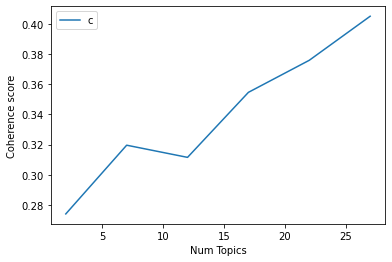

In [142]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [143]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.274
index: 1 | Num Topics = 7  has Coherence Value of 0.3196
index: 2 | Num Topics = 12  has Coherence Value of 0.3115
index: 3 | Num Topics = 17  has Coherence Value of 0.3547
index: 4 | Num Topics = 22  has Coherence Value of 0.3759
index: 5 | Num Topics = 27  has Coherence Value of 0.4052


In [182]:
# Select optimal number of topics
optimal_model_ph_2019_score1N2N3 = model_list_ph_2019_score1N2N3[5]

In [183]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2019_score1N2N3, corpus_ph_2019_score1N2N3, id2word_ph_2019_score1N2N3)

In [184]:
print("pyLDAVis for ph topics for score=1,2,3 in 2019:")
vis_ph_2019_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.028916 -0.107460       1        1  9.240877
15     0.066886 -0.082268       2        1  8.256996
2     -0.031598 -0.168869       3        1  7.753365
6     -0.026255 -0.037408       4        1  7.464057
17     0.000787 -0.142997       5        1  7.352149
11    -0.070542 -0.042323       6        1  5.078748
20    -0.093818  0.072328       7        1  4.814806
0     -0.080162 -0.067942       8        1  4.762985
4      0.089331 -0.004615       9        1  4.756323
7     -0.182339  0.048129      10        1  4.709421
5      0.010551  0.050120      11        1  4.172505
8     -0.105481  0.025888      12        1  3.479573
24     0.186975  0.029975      13        1  3.004386
16    -0.054820  0.017159      14        1  2.940217
26     0.175228  0.098620      15        1  2.911570
10     0.025695 -0.085317      16        1  2.827766
1     -0.023308 -0.005507      17        1  2.573550
19    -0.131859  0.046693      18        1  2.532641
23     0.096593 -0.094811      19        1  2.472252
12    -0.082609  0.057202      20        1  2.142655
18     0.036277 -0.038262      21        1  1.953326
14    -0.002042  0.002011      22        1  1.626471
21     0.011974  0.144867      23        1  1.078883
22     0.079409  0.072227      24        1  1.006229
25     0.013952  0.022578      25        1  0.824678
3      0.031130  0.094991      26        1  0.131785
13     0.031130  0.094991      27        1  0.131785, topic_info=      Term       Freq      Total Category  logprob  loglift
12   story  63.000000  63.000000  Default  30.0000  30.0000
52     log  31.000000  31.000000  Default  29.0000  29.0000
47     app  46.000000  46.000000  Default  28.0000  28.0000
28    post  49.000000  49.000000  Default  27.0000  27.0000
118   time  26.000000  26.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
25     fun   0.005053   7.189609  Topic27  -6.5751  -0.6287
26   later   0.005053   4.887926  Topic27  -6.5751  -0.2429
27    like   0.005053  12.618670  Topic27  -6.5751  -1.1913
28    post   0.005053  49.583358  Topic27  -6.5751  -2.5597
29    user   0.005053  16.990317  Topic27  -6.5751  -1.4887

[1386 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
229       1  0.115596  able
229       2  0.115596  able
229       3  0.115596  able
229       5  0.115596  able
229      14  0.115596  able
...     ...       ...   ...
17        9  0.261613   yet
17       11  0.261613   yet
17       12  0.261613   yet
17       21  0.261613   yet
520      14  0.683421  zoom

[1653 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 16, 3, 7, 18, 12, 21, 1, 5, 8, 6, 9, 25, 17, 27, 11, 2, 20, 24, 13, 19, 15, 22, 23, 26, 4, 14])

## By-rating of 2020 (Rating=1,2,3)

In [147]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_ph_2020_score1N2N3 = instagram_ios_ph_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_ph_2020_score1N2N3 = list(sent_to_words(review_ph_2020_score1N2N3))
print(review_words_ph_2020_score1N2N3[:1])

[['look', 'new', 'here', 'never', 'even', 'had', 'chance', 'to', 'use', 'this', 'app', 'my', 'friend', 'suggested', 'me', 'this', 'app', 'so', 'downloaded', 'it', 'immediately', 'and', 'tried', 'to', 'create', 'new', 'acc', 'but', 'it', 'always', 'said', 'they', 'can', 'register', 'my', 'account', 'and', 'stuff', 'repeated', 'it', 'using', 'gmail', 'icloud', 'and', 'another', 'gmail', 'acc', 'even', 'tried', 'using', 'my', 'fb', 'acc', 'but', 'it', 'always', 'says', 'the', 'same', 'that', 'they', 'couldn', 'register', 'my', 'account', 'deleted', 'insta', 'and', 'redownloaded', 'it', 'again', 'and', 'tried', 'creating', 'an', 'acc', 'again', 'but', 'it', 'still', 'the', 'same', 'really', 'need', 'help', 'here', 'because', 'wanna', 'use', 'instagram', 'and', 'try', 'the', 'experience', 'my', 'friend', 'said']]


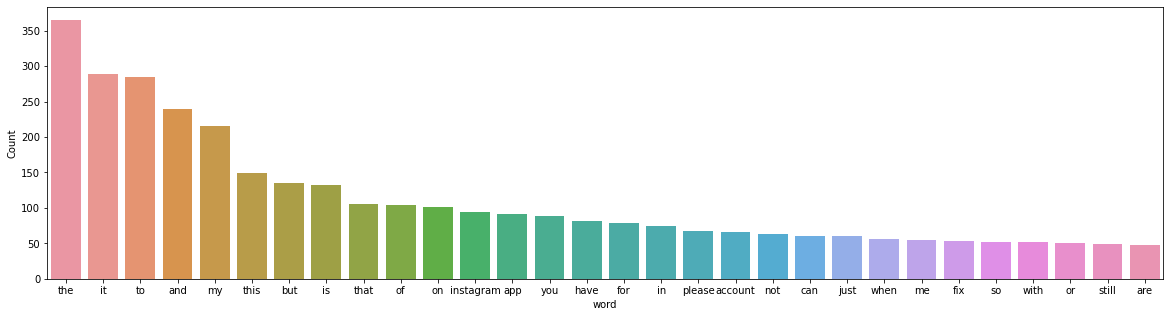

In [148]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2020_score1N2N3))

In [149]:
# Clean text
review_words_ph_ready_2020_score1N2N3 = process_words(review_words_ph_2020_score1N2N3)  # processed Text Data! - move to each section

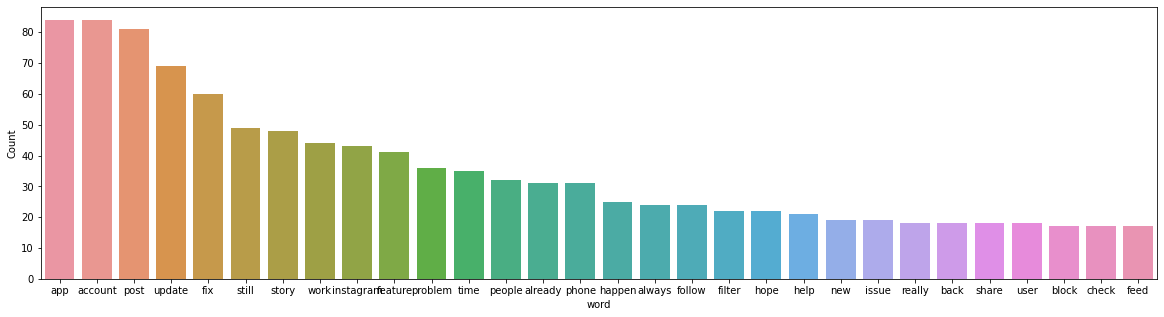

In [150]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2020_score1N2N3))


In [151]:
# Create Dictionary
id2word_ph_2020_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2020_score1N2N3)

2021-10-16 02:32:21,434 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:32:21,447 [INFO] gensim.corpora.dictionary - built Dictionary(833 unique tokens: ['acc', 'account', 'always', 'app', 'chance']...) from 123 documents (total 3273 corpus positions)
2021-10-16 02:32:21,448 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(833 unique tokens: ['acc', 'account', 'always', 'app', 'chance']...) from 123 documents (total 3273 corpus positions)", 'datetime': '2021-10-16T02:32:21.448937', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [152]:
# Create Corpus: Term Document Frequency
corpus_ph_2020_score1N2N3 = [id2word_ph_2020_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2020_score1N2N3]

In [153]:
# Training LDA model
model_list_ph_2020_score1N2N3, coherence_values_ph_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2020_score1N2N3, corpus=corpus_ph_2020_score1N2N3, 
                                                              texts=review_words_ph_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:32:21,483 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:32:21,486 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:32:21,489 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:32:21,492 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 123 documents, updating model once every 123 documents, evaluating perplexity every 123 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:32:22,270 [INFO] gensim.models.ldamodel - -7.300 per-word bound, 157.6 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:32:22,275 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #123/123
2021-10-16 02:32:22,902 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"account" + 0.021*"app" + 0.015*"fix" + 0.015*"feature" + 0.014*"post" + 0.013*"story" + 0.013*"st

2021-10-16 02:32:28,913 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"post" + 0.027*"app" + 0.025*"update" + 0.014*"fix" + 0.011*"work" + 0.011*"account" + 0.010*"still" + 0.009*"phone" + 0.009*"time" + 0.009*"story"
2021-10-16 02:32:28,914 [INFO] gensim.models.ldamodel - topic diff=0.012178, rho=0.301511
2021-10-16 02:32:29,183 [INFO] gensim.models.ldamodel - -6.279 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:32:29,187 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #123/123
2021-10-16 02:32:29,476 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"account" + 0.019*"feature" + 0.015*"story" + 0.015*"fix" + 0.014*"still" + 0.014*"app" + 0.013*"instagram" + 0.012*"post" + 0.012*"problem" + 0.010*"work"
2021-10-16 02:32:29,482 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"post" + 0.027*"app" + 0.025*"update" + 0.014*"fix" + 0.011*"work" + 0.011*"account" + 0.010*"still" + 0.0

2021-10-16 02:32:34,771 [INFO] gensim.models.ldamodel - topic diff=0.005894, rho=0.218218
2021-10-16 02:32:35,036 [INFO] gensim.models.ldamodel - -6.271 per-word bound, 77.2 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:32:35,040 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #123/123
2021-10-16 02:32:35,265 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"account" + 0.020*"feature" + 0.016*"story" + 0.016*"fix" + 0.014*"still" + 0.014*"instagram" + 0.013*"post" + 0.013*"app" + 0.012*"problem" + 0.010*"work"
2021-10-16 02:32:35,267 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"app" + 0.026*"post" + 0.025*"update" + 0.014*"fix" + 0.012*"work" + 0.010*"still" + 0.010*"time" + 0.010*"account" + 0.010*"phone" + 0.009*"issue"
2021-10-16 02:32:35,268 [INFO] gensim.models.ldamodel - topic diff=0.005609, rho=0.213201
2021-10-16 02:32:35,624 [INFO] gensim.models.ldamodel - -6.270 per-word bound, 77.2 perplexity e

2021-10-16 02:32:40,833 [INFO] gensim.models.ldamodel - -6.264 per-word bound, 76.9 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:32:40,835 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #123/123
2021-10-16 02:32:41,103 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"account" + 0.020*"feature" + 0.017*"story" + 0.016*"fix" + 0.015*"still" + 0.014*"instagram" + 0.014*"post" + 0.012*"problem" + 0.012*"app" + 0.009*"share"
2021-10-16 02:32:41,106 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"app" + 0.025*"post" + 0.025*"update" + 0.014*"fix" + 0.013*"work" + 0.010*"time" + 0.010*"still" + 0.010*"phone" + 0.009*"account" + 0.009*"issue"
2021-10-16 02:32:41,108 [INFO] gensim.models.ldamodel - topic diff=0.004852, rho=0.176777
2021-10-16 02:32:41,430 [INFO] gensim.models.ldamodel - -6.263 per-word bound, 76.8 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:32:41,4

2021-10-16 02:32:46,049 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #123/123
2021-10-16 02:32:46,230 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"account" + 0.021*"feature" + 0.016*"story" + 0.016*"fix" + 0.015*"instagram" + 0.015*"post" + 0.015*"still" + 0.012*"problem" + 0.011*"app" + 0.010*"share"
2021-10-16 02:32:46,233 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"app" + 0.025*"update" + 0.024*"post" + 0.015*"work" + 0.014*"fix" + 0.011*"time" + 0.010*"phone" + 0.010*"still" + 0.009*"issue" + 0.009*"people"
2021-10-16 02:32:46,234 [INFO] gensim.models.ldamodel - topic diff=0.003124, rho=0.154303
2021-10-16 02:32:46,533 [INFO] gensim.models.ldamodel - -6.258 per-word bound, 76.6 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:32:46,534 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #123/123
2021-10-16 02:32:46,679 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"account" 

2021-10-16 02:32:50,042 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:32:55,987 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:32:56,036 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 123 virtual documents
2021-10-16 02:32:56,367 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:32:56,381 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:32:56,395 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:32:56,398 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 123 documents, updating model once every 123 documents, evaluating perplexity every 123 documents, iterating 50x with a con

2021-10-16 02:32:58,781 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"app" + 0.020*"account" + 0.019*"time" + 0.015*"issue" + 0.015*"open" + 0.014*"like" + 0.014*"happen" + 0.014*"update" + 0.014*"follower" + 0.013*"help"
2021-10-16 02:32:58,783 [INFO] gensim.models.ldamodel - topic diff=0.109406, rho=0.408248
2021-10-16 02:32:58,995 [INFO] gensim.models.ldamodel - -6.458 per-word bound, 87.9 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:32:59,012 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #123/123
2021-10-16 02:32:59,135 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"app" + 0.021*"post" + 0.018*"story" + 0.018*"fix" + 0.018*"work" + 0.016*"account" + 0.015*"music" + 0.015*"still" + 0.014*"phone" + 0.014*"comment"
2021-10-16 02:32:59,147 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"account" + 0.024*"filter" + 0.019*"app" + 0.018*"save" + 0.017*"show" + 0.015*"work" + 0.014*"update" + 0.0

2021-10-16 02:33:00,906 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"update" + 0.027*"post" + 0.026*"instagram" + 0.023*"app" + 0.013*"work" + 0.013*"still" + 0.012*"account" + 0.011*"story" + 0.011*"new" + 0.011*"video"
2021-10-16 02:33:00,910 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.044*"feature" + 0.024*"update" + 0.019*"account" + 0.016*"hope" + 0.016*"acct" + 0.016*"instagram" + 0.014*"app" + 0.013*"add" + 0.013*"change" + 0.012*"fix"
2021-10-16 02:33:00,912 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"app" + 0.020*"post" + 0.018*"fix" + 0.018*"work" + 0.018*"story" + 0.017*"account" + 0.016*"music" + 0.015*"still" + 0.014*"phone" + 0.013*"comment"
2021-10-16 02:33:00,913 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"app" + 0.020*"account" + 0.019*"time" + 0.016*"issue" + 0.015*"like" + 0.015*"open" + 0.015*"update" + 0.014*"follower" + 0.014*"happen" + 0.013*"help"
2021-10-16 02:33:00,914 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 02:33:03,052 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"app" + 0.021*"account" + 0.020*"time" + 0.017*"issue" + 0.016*"open" + 0.016*"update" + 0.016*"like" + 0.014*"follower" + 0.014*"happen" + 0.013*"help"
2021-10-16 02:33:03,053 [INFO] gensim.models.ldamodel - topic diff=0.005789, rho=0.242536
2021-10-16 02:33:03,276 [INFO] gensim.models.ldamodel - -6.431 per-word bound, 86.3 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:03,290 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #123/123
2021-10-16 02:33:03,443 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.041*"account" + 0.036*"fix" + 0.034*"problem" + 0.033*"post" + 0.028*"story" + 0.018*"share" + 0.018*"still" + 0.014*"app" + 0.011*"update" + 0.011*"help"
2021-10-16 02:33:03,453 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"filter" + 0.022*"account" + 0.020*"save" + 0.019*"app" + 0.018*"show" + 0.015*"work" + 0.014*"update" + 0

2021-10-16 02:33:05,903 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"post" + 0.021*"feed" + 0.020*"suggest" + 0.018*"people" + 0.016*"follow" + 0.014*"update" + 0.014*"explore" + 0.014*"old" + 0.012*"page" + 0.012*"app"
2021-10-16 02:33:05,905 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"filter" + 0.021*"account" + 0.020*"save" + 0.019*"app" + 0.018*"show" + 0.015*"work" + 0.014*"update" + 0.014*"story" + 0.013*"follow" + 0.013*"post"
2021-10-16 02:33:05,907 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"app" + 0.022*"account" + 0.020*"time" + 0.017*"issue" + 0.016*"update" + 0.016*"open" + 0.015*"like" + 0.014*"follower" + 0.014*"happen" + 0.013*"help"
2021-10-16 02:33:05,908 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.041*"account" + 0.036*"fix" + 0.033*"problem" + 0.033*"post" + 0.028*"story" + 0.019*"share" + 0.018*"still" + 0.014*"app" + 0.011*"update" + 0.011*"help"
2021-10-16 02:33:05,910 [INFO] gensim.models.ldamodel - topic diff=0.0021

2021-10-16 02:33:07,836 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"update" + 0.027*"post" + 0.026*"instagram" + 0.023*"app" + 0.013*"work" + 0.013*"still" + 0.012*"account" + 0.012*"new" + 0.012*"video" + 0.012*"story"
2021-10-16 02:33:07,837 [INFO] gensim.models.ldamodel - topic diff=0.001250, rho=0.188982
2021-10-16 02:33:08,087 [INFO] gensim.models.ldamodel - -6.429 per-word bound, 86.1 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:08,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #123/123
2021-10-16 02:33:08,282 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"post" + 0.021*"feed" + 0.020*"suggest" + 0.018*"people" + 0.016*"follow" + 0.014*"update" + 0.014*"explore" + 0.014*"old" + 0.012*"page" + 0.012*"app"
2021-10-16 02:33:08,285 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"app" + 0.020*"post" + 0.018*"work" + 0.017*"story" + 0.017*"fix" + 0.017*"account" + 0.016*"music" + 0.0

2021-10-16 02:33:10,306 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"filter" + 0.021*"account" + 0.020*"save" + 0.019*"app" + 0.018*"show" + 0.015*"work" + 0.014*"story" + 0.014*"update" + 0.013*"follow" + 0.013*"post"
2021-10-16 02:33:10,309 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"account" + 0.036*"fix" + 0.033*"problem" + 0.033*"post" + 0.028*"story" + 0.020*"share" + 0.019*"still" + 0.014*"app" + 0.011*"update" + 0.011*"help"
2021-10-16 02:33:10,312 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"post" + 0.021*"feed" + 0.020*"suggest" + 0.018*"people" + 0.016*"follow" + 0.014*"update" + 0.014*"explore" + 0.014*"old" + 0.012*"page" + 0.012*"app"
2021-10-16 02:33:10,314 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"app" + 0.022*"account" + 0.020*"time" + 0.017*"issue" + 0.017*"update" + 0.016*"open" + 0.015*"like" + 0.014*"follower" + 0.014*"happen" + 0.013*"help"
2021-10-16 02:33:10,314 [INFO] gensim.models.ldamodel - topic diff=0.0007

2021-10-16 02:33:12,446 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.046*"feature" + 0.023*"update" + 0.017*"hope" + 0.016*"acct" + 0.016*"account" + 0.015*"instagram" + 0.013*"add" + 0.013*"app" + 0.012*"change" + 0.012*"fix"
2021-10-16 02:33:12,448 [INFO] gensim.models.ldamodel - topic diff=0.000639, rho=0.160128
2021-10-16 02:33:12,686 [INFO] gensim.models.ldamodel - -6.428 per-word bound, 86.1 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:12,691 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #123/123
2021-10-16 02:33:12,808 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"app" + 0.022*"account" + 0.020*"time" + 0.017*"issue" + 0.017*"update" + 0.016*"open" + 0.015*"like" + 0.014*"follower" + 0.014*"happen" + 0.013*"help"
2021-10-16 02:33:12,812 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"post" + 0.021*"feed" + 0.021*"suggest" + 0.018*"people" + 0.016*"follow" + 0.014*"update" + 0.014*"exp

2021-10-16 02:33:14,675 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"app" + 0.020*"post" + 0.018*"work" + 0.017*"story" + 0.017*"fix" + 0.016*"music" + 0.016*"still" + 0.015*"account" + 0.014*"phone" + 0.013*"comment"
2021-10-16 02:33:14,677 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.043*"account" + 0.036*"fix" + 0.033*"post" + 0.033*"problem" + 0.028*"story" + 0.020*"share" + 0.019*"still" + 0.014*"app" + 0.011*"update" + 0.011*"help"
2021-10-16 02:33:14,679 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"post" + 0.021*"feed" + 0.021*"suggest" + 0.018*"people" + 0.016*"follow" + 0.014*"update" + 0.014*"explore" + 0.014*"old" + 0.012*"page" + 0.012*"app"
2021-10-16 02:33:14,681 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.046*"feature" + 0.023*"update" + 0.017*"hope" + 0.016*"acct" + 0.015*"account" + 0.015*"instagram" + 0.013*"add" + 0.013*"app" + 0.012*"change" + 0.012*"fix"
2021-10-16 02:33:14,686 [INFO] gensim.models.ldamodel - topic diff=0.0005

2021-10-16 02:33:16,614 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.046*"feature" + 0.023*"update" + 0.017*"hope" + 0.016*"acct" + 0.015*"instagram" + 0.015*"account" + 0.013*"add" + 0.013*"app" + 0.012*"change" + 0.012*"fix"
2021-10-16 02:33:16,615 [INFO] gensim.models.ldamodel - topic diff=0.000453, rho=0.141421
2021-10-16 02:33:16,912 [INFO] gensim.models.ldamodel - -6.427 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:16,915 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #123/123
2021-10-16 02:33:17,042 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.044*"account" + 0.036*"fix" + 0.033*"post" + 0.033*"problem" + 0.028*"story" + 0.020*"share" + 0.019*"still" + 0.014*"app" + 0.011*"update" + 0.011*"help"
2021-10-16 02:33:17,044 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"app" + 0.020*"post" + 0.018*"work" + 0.017*"story" + 0.017*"fix" + 0.016*"music" + 0.016*"still" + 0.015

2021-10-16 02:33:26,430 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"update" + 0.022*"work" + 0.020*"post" + 0.019*"app" + 0.016*"instagram" + 0.016*"problem" + 0.016*"account" + 0.013*"stop" + 0.013*"follow" + 0.010*"bad"
2021-10-16 02:33:26,433 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.027*"work" + 0.026*"app" + 0.018*"appear" + 0.018*"issue" + 0.018*"acct" + 0.015*"fine" + 0.015*"account" + 0.015*"fix" + 0.015*"none" + 0.014*"version"
2021-10-16 02:33:26,434 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"feature" + 0.033*"account" + 0.020*"app" + 0.020*"follow" + 0.016*"update" + 0.014*"thing" + 0.014*"music" + 0.013*"people" + 0.012*"option" + 0.012*"instagram"
2021-10-16 02:33:26,436 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"suggest" + 0.031*"post" + 0.027*"app" + 0.026*"feed" + 0.024*"update" + 0.024*"old" + 0.019*"instagram" + 0.018*"follow" + 0.014*"company" + 0.013*"people"
2021-10-16 02:33:26,437 [INFO] gensim.models.ldamodel - 

2021-10-16 02:33:28,263 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"work" + 0.025*"app" + 0.023*"comment" + 0.022*"post" + 0.019*"story" + 0.018*"still" + 0.018*"click" + 0.016*"fix" + 0.015*"effect" + 0.015*"update"
2021-10-16 02:33:28,267 [INFO] gensim.models.ldamodel - topic diff=0.033631, rho=0.316228
2021-10-16 02:33:28,419 [INFO] gensim.models.ldamodel - -6.578 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:28,420 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #123/123
2021-10-16 02:33:28,558 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.035*"update" + 0.026*"already" + 0.024*"app" + 0.022*"still" + 0.020*"story" + 0.018*"post" + 0.015*"crash" + 0.013*"account" + 0.012*"instagram" + 0.012*"reinstall"
2021-10-16 02:33:28,561 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"feature" + 0.034*"account" + 0.020*"follow" + 0.019*"app" + 0.016*"update" + 0.015*"thing" + 0.015

2021-10-16 02:33:30,446 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"suggest" + 0.035*"post" + 0.030*"feed" + 0.026*"app" + 0.025*"old" + 0.024*"update" + 0.020*"follow" + 0.019*"instagram" + 0.015*"people" + 0.014*"company"
2021-10-16 02:33:30,448 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.022*"update" + 0.022*"work" + 0.019*"app" + 0.019*"post" + 0.016*"instagram" + 0.016*"account" + 0.016*"problem" + 0.013*"stop" + 0.013*"follow" + 0.010*"bad"
2021-10-16 02:33:30,449 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.035*"update" + 0.026*"already" + 0.024*"app" + 0.022*"still" + 0.020*"story" + 0.018*"post" + 0.015*"crash" + 0.013*"account" + 0.012*"instagram" + 0.012*"reinstall"
2021-10-16 02:33:30,450 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"explore" + 0.021*"filter" + 0.021*"action" + 0.019*"app" + 0.018*"people" + 0.017*"page" + 0.016*"block" + 0.016*"time" + 0.015*"really" + 0.014*"post"
2021-10-16 02:33:30,452 [INFO] gensim.models.ldamodel

2021-10-16 02:33:32,426 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.040*"work" + 0.025*"app" + 0.023*"comment" + 0.022*"post" + 0.019*"story" + 0.018*"still" + 0.017*"click" + 0.016*"fix" + 0.016*"effect" + 0.015*"update"
2021-10-16 02:33:32,428 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.025*"account" + 0.025*"video" + 0.025*"disabled" + 0.017*"happen" + 0.017*"still" + 0.017*"instagram" + 0.017*"year" + 0.017*"feature" + 0.017*"internet" + 0.017*"reason"
2021-10-16 02:33:32,429 [INFO] gensim.models.ldamodel - topic diff=0.003541, rho=0.218218
2021-10-16 02:33:32,673 [INFO] gensim.models.ldamodel - -6.566 per-word bound, 94.8 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:32,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #123/123
2021-10-16 02:33:32,796 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"suggest" + 0.035*"post" + 0.030*"feed" + 0.026*"app" + 0.025*"old" + 0.023*"update" + 0.020*

2021-10-16 02:33:34,679 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #123/123
2021-10-16 02:33:34,834 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"feature" + 0.034*"account" + 0.020*"follow" + 0.019*"app" + 0.015*"update" + 0.015*"thing" + 0.015*"music" + 0.014*"people" + 0.012*"option" + 0.012*"available"
2021-10-16 02:33:34,836 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"account" + 0.027*"like" + 0.024*"follower" + 0.022*"fix" + 0.021*"number" + 0.017*"app" + 0.014*"change" + 0.014*"post" + 0.014*"time" + 0.012*"screen"
2021-10-16 02:33:34,839 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.033*"account" + 0.030*"post" + 0.025*"app" + 0.025*"phone" + 0.019*"still" + 0.018*"time" + 0.017*"update" + 0.016*"happen" + 0.015*"delete" + 0.013*"fix"
2021-10-16 02:33:34,843 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"explore" + 0.021*"action" + 0.020*"filter" + 0.019*"app" + 0.018*"people" + 0.017*"page" + 0.016*"block" + 0.016*"ti

2021-10-16 02:33:36,690 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"explore" + 0.021*"action" + 0.019*"app" + 0.019*"filter" + 0.018*"people" + 0.017*"page" + 0.016*"block" + 0.016*"time" + 0.016*"really" + 0.014*"post"
2021-10-16 02:33:36,692 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"update" + 0.023*"work" + 0.020*"app" + 0.016*"instagram" + 0.016*"post" + 0.014*"account" + 0.013*"follow" + 0.013*"stop" + 0.012*"problem" + 0.010*"bad"
2021-10-16 02:33:36,693 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.033*"account" + 0.031*"post" + 0.025*"phone" + 0.025*"app" + 0.019*"still" + 0.018*"time" + 0.017*"update" + 0.016*"happen" + 0.015*"delete" + 0.013*"fix"
2021-10-16 02:33:36,694 [INFO] gensim.models.ldamodel - topic diff=0.001454, rho=0.176777
2021-10-16 02:33:36,940 [INFO] gensim.models.ldamodel - -6.563 per-word bound, 94.6 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:36,942 [INFO] gensim.models.l

2021-10-16 02:33:38,638 [INFO] gensim.models.ldamodel - topic diff=0.001366, rho=0.164399
2021-10-16 02:33:38,830 [INFO] gensim.models.ldamodel - -6.562 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:38,833 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #123/123
2021-10-16 02:33:38,968 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.023*"update" + 0.023*"work" + 0.020*"app" + 0.017*"instagram" + 0.016*"post" + 0.014*"account" + 0.013*"follow" + 0.013*"stop" + 0.011*"problem" + 0.010*"bad"
2021-10-16 02:33:38,981 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"explore" + 0.021*"action" + 0.019*"app" + 0.018*"filter" + 0.018*"people" + 0.018*"page" + 0.016*"block" + 0.016*"time" + 0.016*"really" + 0.014*"post"
2021-10-16 02:33:38,990 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.025*"account" + 0.025*"video" + 0.025*"disabled" + 0.017*"happen" + 0.017*"still" + 0.017*"year" + 0.017*"

2021-10-16 02:33:40,918 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"suggest" + 0.035*"post" + 0.030*"feed" + 0.026*"app" + 0.025*"old" + 0.023*"update" + 0.020*"follow" + 0.019*"instagram" + 0.015*"people" + 0.014*"company"
2021-10-16 02:33:40,920 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.036*"update" + 0.026*"already" + 0.024*"app" + 0.021*"still" + 0.020*"story" + 0.018*"post" + 0.015*"crash" + 0.013*"account" + 0.012*"reinstall" + 0.012*"button"
2021-10-16 02:33:40,921 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"account" + 0.027*"like" + 0.024*"follower" + 0.021*"fix" + 0.021*"number" + 0.017*"app" + 0.014*"change" + 0.014*"post" + 0.013*"time" + 0.011*"screen"
2021-10-16 02:33:40,922 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.055*"problem" + 0.041*"account" + 0.039*"fix" + 0.027*"story" + 0.025*"post" + 0.023*"still" + 0.020*"share" + 0.018*"app" + 0.017*"help" + 0.016*"update"
2021-10-16 02:33:40,923 [INFO] gensim.models.ldamodel - topi

2021-10-16 02:33:42,625 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"feature" + 0.034*"account" + 0.020*"follow" + 0.019*"app" + 0.015*"update" + 0.015*"thing" + 0.015*"music" + 0.014*"people" + 0.012*"option" + 0.012*"available"
2021-10-16 02:33:42,629 [INFO] gensim.models.ldamodel - topic diff=0.001022, rho=0.144338
2021-10-16 02:33:42,822 [INFO] gensim.models.ldamodel - -6.560 per-word bound, 94.3 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:42,823 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #123/123
2021-10-16 02:33:42,942 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.025*"account" + 0.025*"video" + 0.025*"disabled" + 0.017*"happen" + 0.017*"feature" + 0.017*"year" + 0.017*"still" + 0.017*"instagram" + 0.017*"internet" + 0.017*"reason"
2021-10-16 02:33:42,956 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"feature" + 0.034*"account" + 0.020*"follow" + 0.019*"app" + 0.015*"update" + 0.0

2021-10-16 02:33:51,285 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.035*"app" + 0.031*"account" + 0.024*"post" + 0.019*"happen" + 0.019*"delete" + 0.018*"update" + 0.015*"still" + 0.015*"phone" + 0.014*"notification" + 0.013*"always"
2021-10-16 02:33:51,288 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.034*"post" + 0.026*"update" + 0.023*"comment" + 0.022*"phone" + 0.020*"fix" + 0.020*"problem" + 0.019*"already" + 0.017*"still" + 0.017*"story" + 0.017*"account"
2021-10-16 02:33:51,291 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.034*"app" + 0.028*"story" + 0.024*"update" + 0.023*"feature" + 0.018*"check" + 0.018*"still" + 0.017*"object" + 0.017*"camera" + 0.017*"issue" + 0.017*"already"
2021-10-16 02:33:51,292 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.037*"feature" + 0.025*"remove" + 0.020*"video" + 0.019*"especially" + 0.018*"instagram" + 0.013*"call" + 0.013*"instastory" + 0.013*"disappointing" + 0.013*"inconsistent" + 0.013*"pic"
2021-10-16 02:33:51

2021-10-16 02:33:53,093 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.040*"feature" + 0.027*"remove" + 0.020*"video" + 0.020*"especially" + 0.020*"instagram" + 0.014*"call" + 0.014*"instastory" + 0.014*"disappointing" + 0.014*"inconsistent" + 0.014*"pic"
2021-10-16 02:33:53,096 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"post" + 0.027*"update" + 0.022*"comment" + 0.022*"phone" + 0.022*"already" + 0.019*"fix" + 0.019*"problem" + 0.017*"still" + 0.017*"story" + 0.017*"account"
2021-10-16 02:33:53,097 [INFO] gensim.models.ldamodel - topic diff=0.068191, rho=0.353553
2021-10-16 02:33:53,298 [INFO] gensim.models.ldamodel - -6.644 per-word bound, 100.0 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:53,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #123/123
2021-10-16 02:33:53,428 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.034*"acct" + 0.021*"post" + 0.021*"follow" + 0.021*"business" + 0.021*"di

2021-10-16 02:33:55,025 [INFO] gensim.models.ldamodel - -6.630 per-word bound, 99.0 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:55,034 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #123/123
2021-10-16 02:33:55,173 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.027*"fine" + 0.027*"effect" + 0.027*"app" + 0.014*"reinstall" + 0.014*"time" + 0.014*"unable" + 0.014*"already" + 0.014*"work" + 0.014*"wonky" + 0.014*"refresh"
2021-10-16 02:33:55,176 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"post" + 0.028*"update" + 0.022*"comment" + 0.022*"phone" + 0.022*"already" + 0.019*"fix" + 0.019*"problem" + 0.016*"still" + 0.016*"story" + 0.016*"account"
2021-10-16 02:33:55,179 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.041*"feature" + 0.027*"remove" + 0.021*"video" + 0.021*"especially" + 0.021*"instagram" + 0.014*"instastory" + 0.014*"call" + 0.014*"disappointing" + 0.014*"inconsistent" + 0.014*"pic"
2

2021-10-16 02:33:56,944 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.037*"feature" + 0.029*"instagram" + 0.023*"hope" + 0.021*"update" + 0.021*"company" + 0.012*"change" + 0.012*"effect" + 0.012*"filter" + 0.012*"camera" + 0.012*"already"
2021-10-16 02:33:56,949 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.035*"app" + 0.031*"story" + 0.023*"update" + 0.023*"feature" + 0.019*"already" + 0.019*"issue" + 0.018*"check" + 0.018*"camera" + 0.018*"object" + 0.018*"long"
2021-10-16 02:33:56,953 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.058*"app" + 0.028*"open" + 0.028*"crash" + 0.026*"work" + 0.024*"issue" + 0.024*"update" + 0.020*"time" + 0.016*"still" + 0.016*"post" + 0.016*"video"
2021-10-16 02:33:56,955 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.034*"acct" + 0.021*"post" + 0.021*"follow" + 0.021*"business" + 0.021*"disabled" + 0.021*"account" + 0.014*"people" + 0.014*"time" + 0.014*"still" + 0.014*"main"
2021-10-16 02:33:56,956 [INFO] gensim.models.ldamode

2021-10-16 02:33:58,810 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.034*"post" + 0.031*"account" + 0.026*"filter" + 0.023*"explore" + 0.021*"story" + 0.018*"page" + 0.016*"feed" + 0.016*"update" + 0.013*"always" + 0.013*"show"
2021-10-16 02:33:58,812 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"post" + 0.029*"update" + 0.022*"comment" + 0.022*"phone" + 0.022*"already" + 0.019*"fix" + 0.019*"problem" + 0.016*"still" + 0.016*"story" + 0.016*"account"
2021-10-16 02:33:58,814 [INFO] gensim.models.ldamodel - topic diff=0.002658, rho=0.204124
2021-10-16 02:33:59,014 [INFO] gensim.models.ldamodel - -6.620 per-word bound, 98.3 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:33:59,016 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #123/123
2021-10-16 02:33:59,122 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"account" + 0.049*"fix" + 0.047*"problem" + 0.040*"story" + 0.035*"post" + 0.033*"share" + 0.032

2021-10-16 02:34:00,834 [INFO] gensim.models.ldamodel - topic diff=0.001562, rho=0.185695
2021-10-16 02:34:01,076 [INFO] gensim.models.ldamodel - -6.618 per-word bound, 98.2 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:01,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #123/123
2021-10-16 02:34:01,230 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.033*"follow" + 0.025*"account" + 0.022*"people" + 0.021*"app" + 0.021*"number" + 0.018*"post" + 0.017*"time" + 0.017*"thing" + 0.013*"happen" + 0.013*"save"
2021-10-16 02:34:01,235 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.042*"feed" + 0.021*"people" + 0.021*"post" + 0.021*"suggest" + 0.021*"app" + 0.021*"setting" + 0.011*"music" + 0.011*"region" + 0.011*"update" + 0.011*"remove"
2021-10-16 02:34:01,240 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"update" + 0.029*"app" + 0.029*"instagram" + 0.019*"follow" + 0.019*"really" + 0.019*"stop" + 0.014*"

2021-10-16 02:34:02,946 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"post" + 0.029*"update" + 0.022*"comment" + 0.022*"phone" + 0.022*"already" + 0.019*"fix" + 0.019*"problem" + 0.016*"still" + 0.016*"account" + 0.016*"story"
2021-10-16 02:34:02,948 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"account" + 0.049*"fix" + 0.047*"problem" + 0.041*"story" + 0.036*"post" + 0.034*"share" + 0.033*"still" + 0.020*"button" + 0.017*"feature" + 0.013*"people"
2021-10-16 02:34:02,960 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.027*"fine" + 0.027*"effect" + 0.027*"app" + 0.014*"reinstall" + 0.014*"time" + 0.014*"work" + 0.014*"unable" + 0.014*"already" + 0.014*"wonky" + 0.014*"refresh"
2021-10-16 02:34:02,964 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.041*"action" + 0.037*"block" + 0.037*"account" + 0.031*"people" + 0.031*"fix" + 0.028*"follower" + 0.023*"time" + 0.022*"app" + 0.014*"gmail" + 0.014*"acc"
2021-10-16 02:34:02,966 [INFO] gensim.models.ldamodel 

2021-10-16 02:34:04,794 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.036*"app" + 0.033*"account" + 0.024*"post" + 0.021*"happen" + 0.021*"delete" + 0.018*"update" + 0.016*"still" + 0.014*"phone" + 0.014*"notification" + 0.014*"crash"
2021-10-16 02:34:04,799 [INFO] gensim.models.ldamodel - topic diff=0.000675, rho=0.158114
2021-10-16 02:34:05,036 [INFO] gensim.models.ldamodel - -6.617 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:05,040 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #123/123
2021-10-16 02:34:05,165 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.058*"app" + 0.028*"open" + 0.028*"crash" + 0.027*"work" + 0.024*"issue" + 0.024*"update" + 0.020*"time" + 0.016*"still" + 0.016*"post" + 0.016*"video"
2021-10-16 02:34:05,171 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.042*"feed" + 0.021*"people" + 0.021*"post" + 0.021*"suggest" + 0.021*"app" + 0.021*"setting" + 0.011*"mu

2021-10-16 02:34:06,819 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.059*"account" + 0.048*"fix" + 0.047*"problem" + 0.042*"story" + 0.037*"post" + 0.036*"share" + 0.033*"still" + 0.020*"button" + 0.019*"feature" + 0.013*"people"
2021-10-16 02:34:06,823 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.034*"post" + 0.031*"account" + 0.026*"filter" + 0.023*"explore" + 0.021*"story" + 0.018*"page" + 0.016*"feed" + 0.016*"update" + 0.013*"always" + 0.013*"show"
2021-10-16 02:34:06,829 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.042*"feed" + 0.021*"people" + 0.021*"post" + 0.021*"suggest" + 0.021*"app" + 0.021*"setting" + 0.011*"music" + 0.011*"region" + 0.011*"update" + 0.011*"remove"
2021-10-16 02:34:06,831 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.034*"acct" + 0.021*"post" + 0.021*"follow" + 0.021*"business" + 0.021*"disabled" + 0.021*"account" + 0.014*"people" + 0.014*"time" + 0.014*"still" + 0.014*"main"
2021-10-16 02:34:06,833 [INFO] gensim.models.ldamodel 

2021-10-16 02:34:08,486 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.041*"action" + 0.037*"block" + 0.037*"account" + 0.031*"people" + 0.031*"fix" + 0.028*"follower" + 0.023*"time" + 0.022*"app" + 0.014*"gmail" + 0.014*"acc"
2021-10-16 02:34:08,493 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.036*"post" + 0.032*"app" + 0.019*"update" + 0.018*"like" + 0.015*"user" + 0.013*"still" + 0.012*"follower" + 0.012*"check" + 0.010*"report" + 0.009*"caption"
2021-10-16 02:34:08,497 [INFO] gensim.models.ldamodel - topic diff=0.000337, rho=0.140028
2021-10-16 02:34:08,502 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=833, num_topics=17, decay=0.5, chunksize=1000) in 18.44s', 'datetime': '2021-10-16T02:34:08.501988', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:34:08,529 [INFO] gensim.topic_coherence.probability_estimation - us

2021-10-16 02:34:17,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #123/123
2021-10-16 02:34:17,659 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"people" + 0.032*"fix" + 0.028*"app" + 0.027*"post" + 0.025*"problem" + 0.021*"follow" + 0.021*"update" + 0.020*"story" + 0.020*"share" + 0.016*"block"
2021-10-16 02:34:17,661 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.041*"explore" + 0.032*"page" + 0.024*"always" + 0.024*"story" + 0.022*"show" + 0.020*"app" + 0.018*"update" + 0.018*"post" + 0.017*"really" + 0.016*"time"
2021-10-16 02:34:17,663 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.034*"fix" + 0.025*"post" + 0.024*"follower" + 0.024*"time" + 0.019*"story" + 0.019*"create" + 0.018*"object" + 0.018*"acc" + 0.017*"help" + 0.013*"hope"
2021-10-16 02:34:17,665 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.064*"number" + 0.026*"mobile" + 0.026*"remove" + 0.026*"change" + 0.026*"restrict" + 0.026*"back" + 0.014*"account" + 0.013*"time" + 0.

2021-10-16 02:34:19,570 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"post" + 0.038*"account" + 0.020*"delete" + 0.020*"update" + 0.017*"notification" + 0.017*"suggest" + 0.016*"feed" + 0.016*"video" + 0.016*"instagram" + 0.015*"app"
2021-10-16 02:34:19,573 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.024*"problem" + 0.024*"account" + 0.024*"already" + 0.024*"button" + 0.021*"story" + 0.021*"fix" + 0.016*"people" + 0.016*"still" + 0.016*"happen" + 0.016*"deactivate"
2021-10-16 02:34:19,575 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.040*"fix" + 0.040*"app" + 0.030*"work" + 0.030*"issue" + 0.030*"problem" + 0.020*"still" + 0.020*"reinstall" + 0.020*"open" + 0.020*"lag" + 0.020*"chat"
2021-10-16 02:34:19,576 [INFO] gensim.models.ldamodel - topic diff=0.037012, rho=0.301511
2021-10-16 02:34:19,813 [INFO] gensim.models.ldamodel - -6.732 per-word bound, 106.3 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:19,815 [

2021-10-16 02:34:21,383 [INFO] gensim.models.ldamodel - topic diff=0.012386, rho=0.250000
2021-10-16 02:34:21,596 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:21,658 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #123/123
2021-10-16 02:34:21,809 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.034*"fix" + 0.026*"post" + 0.026*"follower" + 0.024*"time" + 0.019*"story" + 0.019*"create" + 0.019*"object" + 0.019*"acc" + 0.019*"help" + 0.013*"hope"
2021-10-16 02:34:21,813 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.042*"feature" + 0.028*"text" + 0.028*"click" + 0.028*"edit" + 0.028*"always" + 0.021*"account" + 0.021*"disabled" + 0.021*"instagram" + 0.021*"annoying" + 0.021*"music"
2021-10-16 02:34:21,815 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.105*"filter" + 0.052*"save" + 0.039*"phone" + 0.028*"effect" + 0.024*"device" + 0.021*"nt" + 0.020

2021-10-16 02:34:23,718 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"post" + 0.038*"account" + 0.020*"delete" + 0.020*"update" + 0.017*"notification" + 0.017*"suggest" + 0.016*"feed" + 0.016*"video" + 0.016*"instagram" + 0.015*"app"
2021-10-16 02:34:23,721 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.042*"post" + 0.032*"suggest" + 0.023*"old" + 0.023*"app" + 0.019*"feed" + 0.019*"version" + 0.019*"update" + 0.019*"follow" + 0.014*"instagram" + 0.014*"save"
2021-10-16 02:34:23,723 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.036*"medium" + 0.036*"messenger" + 0.018*"phone" + 0.018*"work" + 0.018*"meet" + 0.018*"thing" + 0.018*"update" + 0.018*"online" + 0.018*"interact" + 0.018*"love"
2021-10-16 02:34:23,725 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.067*"app" + 0.033*"update" + 0.031*"post" + 0.022*"story" + 0.022*"work" + 0.022*"fix" + 0.020*"new" + 0.018*"crash" + 0.017*"happen" + 0.016*"time"
2021-10-16 02:34:23,727 [INFO] gensim.models.ldamodel 

2021-10-16 02:34:25,621 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"post" + 0.038*"account" + 0.020*"delete" + 0.020*"update" + 0.017*"notification" + 0.017*"suggest" + 0.016*"feed" + 0.016*"video" + 0.016*"instagram" + 0.015*"app"
2021-10-16 02:34:25,622 [INFO] gensim.models.ldamodel - topic diff=0.002010, rho=0.192450
2021-10-16 02:34:25,829 [INFO] gensim.models.ldamodel - -6.711 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:25,830 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #123/123
2021-10-16 02:34:25,953 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"account" + 0.040*"page" + 0.021*"late" + 0.021*"picture" + 0.021*"profile" + 0.021*"version" + 0.021*"black" + 0.021*"add" + 0.021*"click" + 0.021*"whole"
2021-10-16 02:34:25,955 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.034*"fix" + 0.026*"post" + 0.026*"follower" + 0.024*"time" + 0.019*"story" + 0.019*"create

2021-10-16 02:34:27,604 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #123/123
2021-10-16 02:34:27,770 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.068*"feature" + 0.023*"follow" + 0.023*"account" + 0.023*"story" + 0.017*"people" + 0.017*"update" + 0.017*"photo" + 0.017*"music" + 0.012*"always" + 0.012*"post"
2021-10-16 02:34:27,776 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.064*"number" + 0.026*"remove" + 0.026*"mobile" + 0.026*"change" + 0.026*"restrict" + 0.026*"back" + 0.013*"account" + 0.013*"time" + 0.013*"fix" + 0.013*"unknown"
2021-10-16 02:34:27,781 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.067*"app" + 0.033*"update" + 0.031*"post" + 0.022*"story" + 0.022*"work" + 0.022*"fix" + 0.020*"new" + 0.018*"crash" + 0.017*"happen" + 0.016*"time"
2021-10-16 02:34:27,786 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.027*"affect" + 0.027*"money" + 0.027*"sake" + 0.027*"negatively" + 0.027*"feature" + 0.014*"people" + 0.014*"especially" +

2021-10-16 02:34:29,592 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.042*"feature" + 0.028*"text" + 0.028*"click" + 0.028*"edit" + 0.028*"always" + 0.021*"account" + 0.021*"disabled" + 0.021*"instagram" + 0.021*"annoying" + 0.021*"music"
2021-10-16 02:34:29,595 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.033*"stop" + 0.027*"post" + 0.025*"start" + 0.025*"already" + 0.024*"instagram" + 0.017*"update" + 0.017*"bad" + 0.017*"internet" + 0.017*"notification" + 0.017*"love"
2021-10-16 02:34:29,598 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.024*"problem" + 0.024*"account" + 0.024*"already" + 0.024*"button" + 0.020*"fix" + 0.020*"story" + 0.016*"people" + 0.016*"still" + 0.016*"deactivate" + 0.016*"happen"
2021-10-16 02:34:29,599 [INFO] gensim.models.ldamodel - topic diff=0.000480, rho=0.162221
2021-10-16 02:34:29,814 [INFO] gensim.models.ldamodel - -6.709 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 0

2021-10-16 02:34:31,230 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.045*"explore" + 0.035*"page" + 0.025*"always" + 0.025*"story" + 0.022*"show" + 0.020*"app" + 0.018*"update" + 0.018*"post" + 0.017*"really" + 0.016*"time"
2021-10-16 02:34:31,231 [INFO] gensim.models.ldamodel - topic diff=0.000254, rho=0.152499
2021-10-16 02:34:31,449 [INFO] gensim.models.ldamodel - -6.709 per-word bound, 104.6 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:31,450 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #123/123
2021-10-16 02:34:31,618 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.034*"fix" + 0.026*"post" + 0.026*"follower" + 0.023*"time" + 0.019*"create" + 0.019*"story" + 0.019*"object" + 0.019*"acc" + 0.019*"help" + 0.013*"hope"
2021-10-16 02:34:31,626 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.027*"affect" + 0.027*"money" + 0.027*"sake" + 0.027*"negatively" + 0.027*"feature" + 0.014*"people" + 0.014*"rea

2021-10-16 02:34:33,225 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.107*"filter" + 0.055*"save" + 0.039*"phone" + 0.028*"effect" + 0.025*"device" + 0.021*"nt" + 0.020*"restart" + 0.019*"show" + 0.018*"camera" + 0.016*"app"
2021-10-16 02:34:33,231 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"post" + 0.038*"account" + 0.020*"delete" + 0.020*"update" + 0.017*"notification" + 0.017*"suggest" + 0.016*"feed" + 0.016*"video" + 0.016*"instagram" + 0.015*"app"
2021-10-16 02:34:33,233 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.040*"account" + 0.040*"page" + 0.021*"late" + 0.021*"picture" + 0.021*"profile" + 0.021*"version" + 0.021*"black" + 0.021*"add" + 0.021*"click" + 0.021*"whole"
2021-10-16 02:34:33,236 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.064*"number" + 0.026*"change" + 0.026*"restrict" + 0.026*"mobile" + 0.026*"back" + 0.026*"remove" + 0.013*"account" + 0.013*"time" + 0.013*"soon" + 0.013*"put"
2021-10-16 02:34:33,239 [INFO] gensim.models.lda

2021-10-16 02:34:44,333 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.030*"work" + 0.027*"like" + 0.025*"video" + 0.024*"app" + 0.023*"update" + 0.019*"less" + 0.019*"change" + 0.019*"effect" + 0.019*"acc" + 0.018*"post"
2021-10-16 02:34:44,340 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.044*"update" + 0.041*"post" + 0.031*"instagram" + 0.031*"old" + 0.021*"suggest" + 0.021*"remove" + 0.021*"profile" + 0.018*"uninstall" + 0.018*"happen" + 0.018*"different"
2021-10-16 02:34:44,346 [INFO] gensim.models.ldamodel - topic diff=0.308005, rho=0.577350
2021-10-16 02:34:44,558 [INFO] gensim.models.ldamodel - -7.027 per-word bound, 130.4 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:44,560 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #123/123
2021-10-16 02:34:44,643 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.025*"available" + 0.025*"story" + 0.024*"instagram" + 0.023*"disabled" + 0.023*"account" + 0.017*"

2021-10-16 02:34:45,994 [INFO] gensim.models.ldamodel - topic diff=0.094860, rho=0.353553
2021-10-16 02:34:46,194 [INFO] gensim.models.ldamodel - -6.783 per-word bound, 110.2 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:46,195 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #123/123
2021-10-16 02:34:46,308 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.050*"app" + 0.028*"update" + 0.018*"post" + 0.018*"action" + 0.018*"block" + 0.017*"work" + 0.017*"people" + 0.014*"stop" + 0.011*"creator" + 0.011*"caption"
2021-10-16 02:34:46,313 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.025*"available" + 0.025*"story" + 0.025*"instagram" + 0.025*"disabled" + 0.025*"account" + 0.017*"always" + 0.017*"user" + 0.017*"music" + 0.017*"archived" + 0.017*"update"
2021-10-16 02:34:46,315 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.046*"update" + 0.041*"post" + 0.032*"instagram" + 0.032*"old" + 0.021*"suggest" + 0.021*"r

2021-10-16 02:34:48,261 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.038*"comment" + 0.033*"story" + 0.029*"post" + 0.028*"still" + 0.027*"update" + 0.024*"work" + 0.019*"phone" + 0.019*"problem" + 0.014*"object" + 0.014*"instagram"
2021-10-16 02:34:48,264 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.063*"acct" + 0.038*"business" + 0.038*"app" + 0.025*"main" + 0.025*"effect" + 0.025*"work" + 0.025*"fine" + 0.025*"feature" + 0.013*"fix" + 0.013*"feed"
2021-10-16 02:34:48,266 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.032*"explore" + 0.032*"post" + 0.025*"page" + 0.021*"update" + 0.019*"really" + 0.018*"app" + 0.018*"filter" + 0.018*"show" + 0.018*"story" + 0.018*"always"
2021-10-16 02:34:48,268 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.039*"problem" + 0.039*"account" + 0.039*"still" + 0.035*"fix" + 0.025*"story" + 0.025*"update" + 0.020*"hope" + 0.020*"happen" + 0.020*"issue" + 0.020*"post"
2021-10-16 02:34:48,269 [INFO] gensim.models.ldamodel - topic 

2021-10-16 02:34:50,682 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.039*"problem" + 0.039*"account" + 0.039*"still" + 0.035*"fix" + 0.025*"story" + 0.025*"update" + 0.020*"hope" + 0.020*"happen" + 0.020*"issue" + 0.020*"post"
2021-10-16 02:34:50,683 [INFO] gensim.models.ldamodel - topic diff=0.004154, rho=0.229416
2021-10-16 02:34:50,894 [INFO] gensim.models.ldamodel - -6.765 per-word bound, 108.7 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:50,895 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #123/123
2021-10-16 02:34:51,064 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.071*"account" + 0.034*"post" + 0.020*"time" + 0.020*"phone" + 0.020*"fix" + 0.017*"app" + 0.017*"gmail" + 0.017*"notification" + 0.017*"video" + 0.014*"change"
2021-10-16 02:34:51,067 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.086*"feature" + 0.086*"story" + 0.058*"work" + 0.039*"restart" + 0.029*"music" + 0.029*"close" + 0.028

2021-10-16 02:34:52,986 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.058*"update" + 0.037*"already" + 0.032*"still" + 0.032*"fix" + 0.031*"instagram" + 0.021*"post" + 0.021*"story" + 0.021*"music" + 0.020*"feature" + 0.016*"app"
2021-10-16 02:34:52,987 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.066*"app" + 0.051*"open" + 0.039*"crash" + 0.034*"happen" + 0.028*"update" + 0.028*"still" + 0.026*"time" + 0.023*"feature" + 0.023*"fix" + 0.022*"issue"
2021-10-16 02:34:52,988 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.041*"setting" + 0.027*"photo" + 0.027*"post" + 0.027*"facebook" + 0.014*"suggestion" + 0.014*"link" + 0.014*"whole" + 0.014*"delete" + 0.014*"great" + 0.014*"instagram"
2021-10-16 02:34:52,991 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.063*"acct" + 0.038*"app" + 0.038*"business" + 0.026*"main" + 0.026*"effect" + 0.026*"feature" + 0.026*"fine" + 0.026*"work" + 0.013*"fix" + 0.013*"feed"
2021-10-16 02:34:52,993 [INFO] gensim.models.ldamodel - t

2021-10-16 02:34:54,616 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.087*"feature" + 0.086*"story" + 0.058*"work" + 0.039*"restart" + 0.029*"music" + 0.029*"close" + 0.029*"post" + 0.026*"share" + 0.020*"filter" + 0.020*"uninstall"
2021-10-16 02:34:54,618 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.052*"account" + 0.026*"update" + 0.019*"feature" + 0.019*"follow" + 0.019*"thing" + 0.019*"still" + 0.019*"post" + 0.019*"ever" + 0.019*"fix" + 0.019*"app"
2021-10-16 02:34:54,621 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.066*"app" + 0.051*"open" + 0.039*"crash" + 0.034*"happen" + 0.028*"update" + 0.028*"still" + 0.026*"time" + 0.023*"feature" + 0.023*"fix" + 0.022*"issue"
2021-10-16 02:34:54,624 [INFO] gensim.models.ldamodel - topic diff=0.000513, rho=0.182574
2021-10-16 02:34:54,830 [INFO] gensim.models.ldamodel - -6.764 per-word bound, 108.7 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:54,834 [INFO] gensim.model

2021-10-16 02:34:56,456 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.032*"explore" + 0.032*"post" + 0.025*"page" + 0.021*"update" + 0.019*"really" + 0.018*"app" + 0.018*"filter" + 0.018*"show" + 0.018*"story" + 0.018*"always"
2021-10-16 02:34:56,458 [INFO] gensim.models.ldamodel - topic diff=0.000257, rho=0.169031
2021-10-16 02:34:56,573 [INFO] gensim.models.ldamodel - -6.763 per-word bound, 108.6 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:34:56,587 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #123/123
2021-10-16 02:34:56,794 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.050*"feed" + 0.038*"suggest" + 0.038*"setting" + 0.025*"anytime" + 0.025*"let" + 0.025*"account" + 0.025*"deactivate" + 0.025*"name" + 0.025*"limit" + 0.025*"post"
2021-10-16 02:34:56,802 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.071*"account" + 0.034*"post" + 0.020*"time" + 0.020*"phone" + 0.020*"fix" + 0.017*"app" + 0.017*"gm

2021-10-16 02:34:58,381 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.026*"fix" + 0.024*"post" + 0.019*"effect" + 0.019*"already" + 0.019*"update" + 0.019*"hope" + 0.019*"message" + 0.019*"app" + 0.013*"tho" + 0.013*"camera"
2021-10-16 02:34:58,383 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.037*"post" + 0.034*"fix" + 0.033*"problem" + 0.031*"app" + 0.023*"story" + 0.023*"account" + 0.023*"button" + 0.019*"share" + 0.018*"time" + 0.016*"follow"
2021-10-16 02:34:58,385 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.076*"save" + 0.063*"filter" + 0.038*"account" + 0.036*"fix" + 0.026*"log" + 0.026*"issue" + 0.026*"update" + 0.026*"still" + 0.026*"profile" + 0.013*"time"
2021-10-16 02:34:58,387 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.025*"available" + 0.025*"story" + 0.025*"instagram" + 0.025*"disabled" + 0.025*"account" + 0.017*"always" + 0.017*"music" + 0.017*"user" + 0.017*"archived" + 0.017*"update"
2021-10-16 02:34:58,388 [INFO] gensim.models.ldamodel 

2021-10-16 02:35:00,264 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.001*"filter" + 0.001*"save" + 0.001*"feature" + 0.001*"camera" + 0.001*"notice" + 0.001*"work" + 0.001*"become" + 0.001*"already" + 0.001*"version" + 0.001*"thaf"
2021-10-16 02:35:00,266 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.050*"app" + 0.028*"update" + 0.018*"post" + 0.018*"action" + 0.018*"block" + 0.017*"work" + 0.017*"people" + 0.015*"stop" + 0.011*"caption" + 0.011*"creator"
2021-10-16 02:35:00,270 [INFO] gensim.models.ldamodel - topic diff=0.000112, rho=0.147442
2021-10-16 02:35:00,458 [INFO] gensim.models.ldamodel - -6.763 per-word bound, 108.6 perplexity estimate based on a held-out corpus of 123 documents with 3273 words
2021-10-16 02:35:00,460 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #123/123
2021-10-16 02:35:00,617 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.071*"account" + 0.034*"post" + 0.020*"time" + 0.020*"phone" + 0.020*"fix" + 0.017*"app" + 0.017*"

2021-10-16 02:35:02,104 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=833, num_topics=27, decay=0.5, chunksize=1000) in 19.04s', 'datetime': '2021-10-16T02:35:02.104744', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:35:02,115 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:35:07,128 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:35:07,197 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 123 virtual documents


In [154]:
%store model_list_ph_2020_score1N2N3
%store coherence_values_ph_2020_score1N2N3

Stored 'model_list_ph_2020_score1N2N3' (list)
Stored 'coherence_values_ph_2020_score1N2N3' (list)


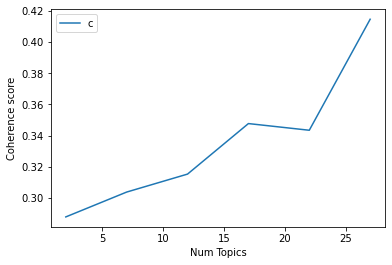

In [155]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [156]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2878
index: 1 | Num Topics = 7  has Coherence Value of 0.3037
index: 2 | Num Topics = 12  has Coherence Value of 0.3152
index: 3 | Num Topics = 17  has Coherence Value of 0.3477
index: 4 | Num Topics = 22  has Coherence Value of 0.3434
index: 5 | Num Topics = 27  has Coherence Value of 0.4147


In [185]:
# Select optimal number of topics
optimal_model_ph_2020_score1N2N3 = model_list_ph_2020_score1N2N3[5]

In [186]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2020_score1N2N3, corpus_ph_2020_score1N2N3, id2word_ph_2020_score1N2N3)

In [187]:
print("pyLDAVis for ph topics for score=1,2,3 in 2020:")
vis_ph_2020_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.087417 -0.009750       1        1  7.934530
21    -0.054057  0.022180       2        1  7.897816
9     -0.031584  0.190163       3        1  7.670350
17    -0.045132  0.044424       4        1  7.407894
26    -0.011685 -0.034884       5        1  6.031933
16    -0.105285  0.006248       6        1  5.615436
20    -0.093205  0.079048       7        1  5.541851
6     -0.151112 -0.015579       8        1  5.185742
7     -0.132536 -0.060451       9        1  4.752534
13    -0.107987 -0.093953      10        1  4.415458
3      0.011848  0.117674      11        1  4.110639
22     0.063943  0.026260      12        1  4.093723
0     -0.031481  0.053858      13        1  3.834509
8     -0.054692 -0.028140      14        1  3.826687
19    -0.021889  0.031696      15        1  3.010285
5      0.013861  0.034066      16        1  2.827135
2     -0.002238 -0.066275      17        1  2.262509
1      0.010942  0.022996      18        1  1.921200
15     0.029619 -0.066852      19        1  1.818249
4      0.141925  0.111845      20        1  1.602204
24     0.054564 -0.115116      21        1  1.571743
11    -0.013276 -0.101582      22        1  1.554270
23     0.133924  0.031120      23        1  1.447768
14     0.149245 -0.060083      24        1  1.397247
25     0.056525 -0.057093      25        1  1.297727
18     0.155242 -0.030847      26        1  0.837251
12     0.121939 -0.030975      27        1  0.133310, topic_info=       Term       Freq      Total Category  logprob  loglift
1   account  70.000000  70.000000  Default   30.000  30.0000
60    story  39.000000  39.000000  Default   29.000  29.0000
67  feature  32.000000  32.000000  Default   28.000  28.0000
68   filter  18.000000  18.000000  Default   27.000  27.0000
57     post  66.000000  66.000000  Default   26.000  26.0000
..      ...        ...        ...      ...      ...      ...
74     mine   0.005238   3.320864  Topic27   -6.725   0.1682
75     none   0.005238   4.109944  Topic27   -6.725  -0.0450
69     hope   0.005238  19.192388  Topic27   -6.725  -1.5861
73  logging   0.005238   1.586407  Topic27   -6.725   0.9070
37     back   0.005238  14.367628  Topic27   -6.725  -1.2965

[1364 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
442       4  0.599208  ability
442       6  0.299604  ability
126       2  0.271883     able
126       3  0.135941     able
126       4  0.271883     able
...     ...       ...      ...
89       14  0.111795     year
89       16  0.223590     year
228       2  0.411512      yet
228      11  0.411512      yet
197      15  0.667913       yt

[1853 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 22, 10, 18, 27, 17, 21, 7, 8, 14, 4, 23, 1, 9, 20, 6, 3, 2, 16, 5, 25, 12, 24, 15, 26, 19, 13])

## By-rating of 2021 (Rating=1,2,3)

In [160]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_ph_2021_score1N2N3 = instagram_ios_ph_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_ph_2021_score1N2N3 = list(sent_to_words(review_ph_2021_score1N2N3))
print(review_words_ph_2021_score1N2N3[:1])

[['my', 'account', 'was', 'compromised', 'even', 'though', 'haven', 'shared', 'my', 'account', 'to', 'anyone', 'nor', 'tried', 'to', 'access', 'any', 'apps', 'or', 'sites', 'that', 'would', 'make', 'me', 'gain', 'more', 'followers', 'confused', 'and', 've', 'been', 'trying', 'to', 'retrieve', 'my', 'account', 'but', 'seem', 'to', 'forgot', 'my', 'password', 'and', 'my', 'email', 'was', 'not', 'updated', 'tried', 'using', 'cell', 'no', 'but', 'the', 'site', 'sent', 'doesn', 'work']]


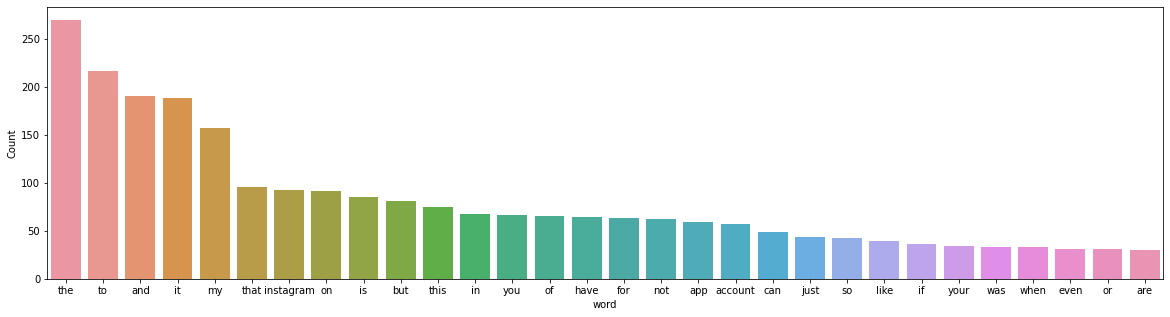

In [161]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2021_score1N2N3))

In [162]:
# Clean text
review_words_ph_ready_2021_score1N2N3 = process_words(review_words_ph_2021_score1N2N3)  # processed Text Data! - move to each section

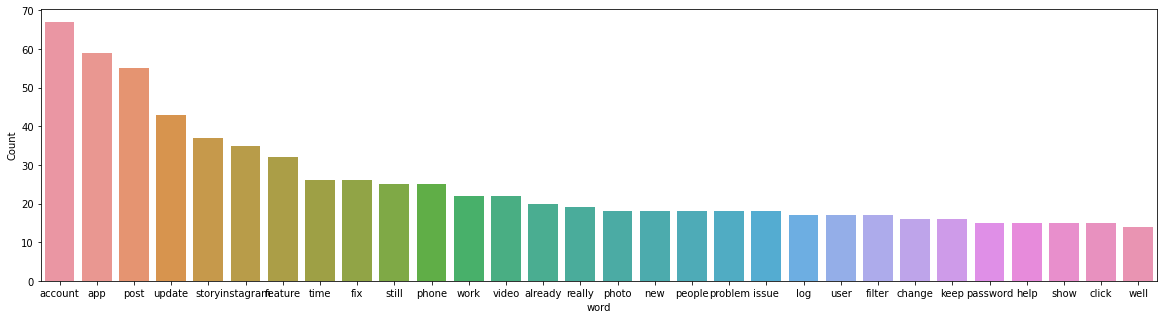

In [163]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2021_score1N2N3))


In [164]:
# Create Dictionary
id2word_ph_2021_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2021_score1N2N3)

2021-10-16 02:35:23,830 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:35:23,839 [INFO] gensim.corpora.dictionary - built Dictionary(712 unique tokens: ['access', 'account', 'app', 'cell', 'compromise']...) from 92 documents (total 2413 corpus positions)
2021-10-16 02:35:23,840 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(712 unique tokens: ['access', 'account', 'app', 'cell', 'compromise']...) from 92 documents (total 2413 corpus positions)", 'datetime': '2021-10-16T02:35:23.840213', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [165]:
# Create Corpus: Term Document Frequency
corpus_ph_2021_score1N2N3 = [id2word_ph_2021_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2021_score1N2N3]

In [166]:
# Training LDA model
model_list_ph_2021_score1N2N3, coherence_values_ph_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2021_score1N2N3, corpus=corpus_ph_2021_score1N2N3, 
                                                              texts=review_words_ph_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:35:23,860 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:35:23,861 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:35:23,864 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:35:23,865 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 92 documents, updating model once every 92 documents, evaluating perplexity every 92 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:35:24,232 [INFO] gensim.models.ldamodel - -7.162 per-word bound, 143.2 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:24,236 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #92/92
2021-10-16 02:35:24,658 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"account" + 0.019*"app" + 0.018*"update" + 0.017*"post" + 0.012*"story" + 0.011*"phone" + 0.010*"feature

2021-10-16 02:35:28,475 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.016*"still" + 0.016*"account" + 0.015*"post" + 0.014*"feature" + 0.014*"story" + 0.013*"time" + 0.013*"instagram" + 0.012*"work" + 0.012*"fix"
2021-10-16 02:35:28,476 [INFO] gensim.models.ldamodel - topic diff=0.010326, rho=0.301511
2021-10-16 02:35:28,698 [INFO] gensim.models.ldamodel - -6.250 per-word bound, 76.1 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:28,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #92/92
2021-10-16 02:35:28,772 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"account" + 0.021*"post" + 0.019*"update" + 0.018*"app" + 0.013*"phone" + 0.011*"filter" + 0.010*"story" + 0.010*"instagram" + 0.009*"password" + 0.008*"photo"
2021-10-16 02:35:28,774 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.016*"still" + 0.016*"account" + 0.015*"post" + 0.015*"feature" + 0.014*"story" + 0.013*"ti

2021-10-16 02:35:31,704 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"account" + 0.016*"still" + 0.015*"feature" + 0.015*"story" + 0.015*"post" + 0.013*"time" + 0.013*"instagram" + 0.012*"work" + 0.012*"fix"
2021-10-16 02:35:31,706 [INFO] gensim.models.ldamodel - topic diff=0.002570, rho=0.218218
2021-10-16 02:35:31,884 [INFO] gensim.models.ldamodel - -6.246 per-word bound, 75.9 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:31,917 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #92/92
2021-10-16 02:35:31,983 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"account" + 0.021*"post" + 0.019*"update" + 0.018*"app" + 0.013*"phone" + 0.011*"filter" + 0.010*"instagram" + 0.010*"story" + 0.009*"password" + 0.008*"photo"
2021-10-16 02:35:31,984 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"account" + 0.016*"still" + 0.015*"feature" + 0.015*"story" + 0.015*"post" + 0.013*"ti

2021-10-16 02:35:35,208 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"account" + 0.016*"still" + 0.015*"feature" + 0.015*"story" + 0.014*"post" + 0.013*"time" + 0.013*"instagram" + 0.012*"work" + 0.012*"fix"
2021-10-16 02:35:35,210 [INFO] gensim.models.ldamodel - topic diff=0.001189, rho=0.179605
2021-10-16 02:35:35,464 [INFO] gensim.models.ldamodel - -6.245 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:35,465 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #92/92
2021-10-16 02:35:35,579 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"account" + 0.021*"post" + 0.019*"update" + 0.018*"app" + 0.013*"phone" + 0.011*"filter" + 0.010*"instagram" + 0.009*"story" + 0.009*"password" + 0.008*"photo"
2021-10-16 02:35:35,581 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"account" + 0.016*"still" + 0.015*"feature" + 0.015*"story" + 0.014*"post" + 0.013*"ti

2021-10-16 02:35:38,785 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"account" + 0.016*"still" + 0.015*"feature" + 0.015*"story" + 0.014*"post" + 0.013*"time" + 0.013*"instagram" + 0.012*"work" + 0.012*"fix"
2021-10-16 02:35:38,790 [INFO] gensim.models.ldamodel - topic diff=0.000737, rho=0.156174
2021-10-16 02:35:38,983 [INFO] gensim.models.ldamodel - -6.245 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:38,984 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #92/92
2021-10-16 02:35:39,106 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"account" + 0.021*"post" + 0.019*"update" + 0.018*"app" + 0.013*"phone" + 0.011*"filter" + 0.011*"instagram" + 0.009*"story" + 0.009*"password" + 0.008*"photo"
2021-10-16 02:35:39,110 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"account" + 0.016*"still" + 0.015*"feature" + 0.015*"story" + 0.014*"post" + 0.013*"ti

2021-10-16 02:35:41,858 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"account" + 0.016*"still" + 0.015*"feature" + 0.015*"story" + 0.014*"post" + 0.013*"time" + 0.012*"instagram" + 0.012*"work" + 0.012*"fix"
2021-10-16 02:35:41,859 [INFO] gensim.models.ldamodel - topic diff=0.000495, rho=0.140028
2021-10-16 02:35:41,861 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=712, num_topics=2, decay=0.5, chunksize=1000) in 18.00s', 'datetime': '2021-10-16T02:35:41.861862', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:35:41,864 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:35:46,431 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-1

2021-10-16 02:35:48,418 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.019*"instagram" + 0.019*"app" + 0.019*"post" + 0.017*"work" + 0.016*"still" + 0.011*"music" + 0.010*"block" + 0.010*"story" + 0.009*"tag"
2021-10-16 02:35:48,422 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.017*"update" + 0.017*"call" + 0.017*"phone" + 0.016*"fix" + 0.014*"contact" + 0.012*"app" + 0.011*"happen" + 0.011*"filter" + 0.011*"user" + 0.011*"always"
2021-10-16 02:35:48,425 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"post" + 0.026*"account" + 0.019*"story" + 0.018*"photo" + 0.018*"app" + 0.017*"button" + 0.017*"update" + 0.017*"filter" + 0.016*"follow" + 0.015*"put"
2021-10-16 02:35:48,427 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"account" + 0.024*"post" + 0.022*"phone" + 0.021*"app" + 0.019*"fix" + 0.017*"update" + 0.016*"instagram" + 0.015*"issue" + 0.012*"story" + 0.011*"people"
2021-10-16 02:35:48,428 [INFO] gensim.models.ldamodel - topic diff=0.06

2021-10-16 02:35:49,757 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"account" + 0.024*"post" + 0.023*"phone" + 0.022*"app" + 0.019*"fix" + 0.017*"update" + 0.016*"instagram" + 0.016*"issue" + 0.012*"story" + 0.011*"people"
2021-10-16 02:35:49,758 [INFO] gensim.models.ldamodel - topic diff=0.010834, rho=0.301511
2021-10-16 02:35:49,908 [INFO] gensim.models.ldamodel - -6.432 per-word bound, 86.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:49,914 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #92/92
2021-10-16 02:35:49,982 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"account" + 0.033*"feature" + 0.026*"app" + 0.019*"password" + 0.019*"story" + 0.018*"change" + 0.018*"compromise" + 0.016*"instagram" + 0.014*"update" + 0.012*"really"
2021-10-16 02:35:49,985 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.019*"instagram" + 0.019*"post" + 0.017*"work" + 0.017*"app" + 0.015*"still" + 

2021-10-16 02:35:51,359 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"account" + 0.033*"feature" + 0.027*"app" + 0.020*"password" + 0.019*"story" + 0.018*"change" + 0.018*"compromise" + 0.016*"instagram" + 0.014*"update" + 0.012*"really"
2021-10-16 02:35:51,360 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.032*"post" + 0.026*"account" + 0.019*"photo" + 0.018*"app" + 0.018*"story" + 0.017*"click" + 0.017*"button" + 0.017*"filter" + 0.017*"update" + 0.016*"follow"
2021-10-16 02:35:51,362 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"account" + 0.024*"post" + 0.023*"phone" + 0.022*"app" + 0.019*"fix" + 0.017*"update" + 0.017*"instagram" + 0.016*"issue" + 0.013*"story" + 0.011*"people"
2021-10-16 02:35:51,364 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"video" + 0.020*"password" + 0.018*"send" + 0.014*"delete" + 0.014*"account" + 0.014*"email" + 0.009*"appeal" + 0.009*"picture" + 0.009*"camera" + 0.009*"provide"
2021-10-16 02:35:51,365 [INFO] gensim.

2021-10-16 02:35:52,875 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"app" + 0.026*"update" + 0.022*"post" + 0.018*"story" + 0.017*"feature" + 0.016*"already" + 0.014*"account" + 0.014*"still" + 0.014*"new" + 0.012*"video"
2021-10-16 02:35:52,877 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"account" + 0.024*"post" + 0.023*"phone" + 0.023*"app" + 0.019*"fix" + 0.017*"update" + 0.017*"instagram" + 0.017*"issue" + 0.013*"story" + 0.011*"people"
2021-10-16 02:35:52,879 [INFO] gensim.models.ldamodel - topic diff=0.001570, rho=0.213201
2021-10-16 02:35:53,036 [INFO] gensim.models.ldamodel - -6.427 per-word bound, 86.1 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:53,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #92/92
2021-10-16 02:35:53,110 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"post" + 0.026*"account" + 0.019*"photo" + 0.018*"like" + 0.018*"click" + 0.018*"app" + 0.018*"story" + 

2021-10-16 02:35:54,212 [INFO] gensim.models.ldamodel - -6.427 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:54,213 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #92/92
2021-10-16 02:35:54,337 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.019*"instagram" + 0.018*"post" + 0.018*"work" + 0.016*"app" + 0.015*"still" + 0.011*"music" + 0.011*"block" + 0.009*"guideline" + 0.009*"tag"
2021-10-16 02:35:54,339 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"app" + 0.026*"update" + 0.021*"post" + 0.018*"story" + 0.017*"feature" + 0.016*"already" + 0.014*"account" + 0.014*"still" + 0.014*"new" + 0.012*"video"
2021-10-16 02:35:54,340 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"post" + 0.026*"account" + 0.020*"like" + 0.019*"click" + 0.019*"photo" + 0.018*"app" + 0.018*"story" + 0.017*"button" + 0.016*"filter" + 0.016*"update"
2021-10-16 02:35:54,341 [INFO] gensim.model

2021-10-16 02:35:55,342 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"account" + 0.025*"post" + 0.023*"phone" + 0.023*"app" + 0.019*"fix" + 0.017*"update" + 0.017*"issue" + 0.017*"instagram" + 0.014*"story" + 0.011*"people"
2021-10-16 02:35:55,343 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"app" + 0.026*"update" + 0.021*"post" + 0.018*"story" + 0.017*"feature" + 0.016*"already" + 0.014*"still" + 0.014*"account" + 0.014*"new" + 0.012*"video"
2021-10-16 02:35:55,344 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"account" + 0.033*"feature" + 0.027*"app" + 0.020*"password" + 0.019*"story" + 0.018*"change" + 0.018*"compromise" + 0.016*"instagram" + 0.014*"update" + 0.012*"really"
2021-10-16 02:35:55,345 [INFO] gensim.models.ldamodel - topic diff=0.000562, rho=0.174078
2021-10-16 02:35:55,466 [INFO] gensim.models.ldamodel - -6.426 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:55,467 [INFO

2021-10-16 02:35:56,352 [INFO] gensim.models.ldamodel - topic diff=0.000420, rho=0.162221
2021-10-16 02:35:56,426 [INFO] gensim.models.ldamodel - -6.426 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:56,427 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #92/92
2021-10-16 02:35:56,519 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.019*"instagram" + 0.018*"post" + 0.018*"work" + 0.016*"app" + 0.015*"still" + 0.011*"music" + 0.011*"block" + 0.009*"guideline" + 0.009*"tag"
2021-10-16 02:35:56,521 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.017*"update" + 0.017*"call" + 0.017*"phone" + 0.016*"fix" + 0.014*"contact" + 0.012*"user" + 0.012*"always" + 0.012*"filter" + 0.012*"happen" + 0.010*"app"
2021-10-16 02:35:56,523 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"video" + 0.018*"password" + 0.018*"send" + 0.014*"email" + 0.014*"delete" + 0.014*"account" + 0.009*"well" 

2021-10-16 02:35:57,760 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"app" + 0.026*"update" + 0.021*"post" + 0.018*"story" + 0.017*"feature" + 0.016*"already" + 0.014*"still" + 0.014*"account" + 0.013*"new" + 0.012*"video"
2021-10-16 02:35:57,762 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"video" + 0.018*"send" + 0.018*"password" + 0.014*"email" + 0.014*"delete" + 0.014*"account" + 0.009*"well" + 0.009*"picture" + 0.009*"number" + 0.009*"camera"
2021-10-16 02:35:57,764 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"account" + 0.033*"feature" + 0.027*"app" + 0.021*"password" + 0.019*"story" + 0.018*"change" + 0.018*"compromise" + 0.016*"instagram" + 0.014*"update" + 0.012*"really"
2021-10-16 02:35:57,768 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"post" + 0.026*"account" + 0.021*"like" + 0.019*"click" + 0.018*"photo" + 0.018*"app" + 0.018*"story" + 0.017*"button" + 0.016*"filter" + 0.016*"update"
2021-10-16 02:35:57,770 [INFO] gensim.models

2021-10-16 02:35:58,856 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.025*"time" + 0.019*"instagram" + 0.018*"post" + 0.018*"work" + 0.016*"app" + 0.015*"still" + 0.011*"music" + 0.011*"block" + 0.009*"guideline" + 0.009*"tag"
2021-10-16 02:35:58,857 [INFO] gensim.models.ldamodel - topic diff=0.000185, rho=0.142857
2021-10-16 02:35:58,974 [INFO] gensim.models.ldamodel - -6.426 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:35:58,977 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #92/92
2021-10-16 02:35:59,062 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.062*"account" + 0.033*"feature" + 0.027*"app" + 0.021*"password" + 0.019*"story" + 0.018*"change" + 0.018*"compromise" + 0.016*"instagram" + 0.014*"update" + 0.012*"really"
2021-10-16 02:35:59,065 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.017*"update" + 0.017*"call" + 0.017*"phone" + 0.016*"fix" + 0.014*"contact" + 0.012*"user" + 0.

2021-10-16 02:36:06,605 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"filter" + 0.028*"well" + 0.028*"put" + 0.028*"feature" + 0.021*"roll" + 0.021*"camera" + 0.021*"picture" + 0.021*"video" + 0.015*"phone" + 0.015*"music"
2021-10-16 02:36:06,609 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.084*"post" + 0.042*"account" + 0.023*"tag" + 0.023*"suggest" + 0.022*"story" + 0.021*"follow" + 0.016*"update" + 0.015*"friend" + 0.015*"scroll" + 0.014*"medium"
2021-10-16 02:36:06,610 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"feature" + 0.035*"app" + 0.027*"update" + 0.023*"new" + 0.022*"already" + 0.021*"video" + 0.020*"still" + 0.019*"available" + 0.017*"account" + 0.016*"live"
2021-10-16 02:36:06,611 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.028*"app" + 0.022*"fix" + 0.022*"call" + 0.018*"contact" + 0.015*"back" + 0.015*"show" + 0.015*"time" + 0.014*"happen" + 0.014*"user" + 0.014*"phone"
2021-10-16 02:36:06,612 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:36:07,781 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"app" + 0.026*"update" + 0.022*"story" + 0.022*"click" + 0.022*"back" + 0.017*"frame" + 0.017*"account" + 0.017*"photo" + 0.017*"tiktok" + 0.017*"user"
2021-10-16 02:36:07,800 [INFO] gensim.models.ldamodel - topic diff=0.029263, rho=0.333333
2021-10-16 02:36:07,883 [INFO] gensim.models.ldamodel - -6.514 per-word bound, 91.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:07,885 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #92/92
2021-10-16 02:36:07,965 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.027*"time" + 0.024*"profile" + 0.020*"work" + 0.020*"block" + 0.017*"still" + 0.017*"guideline" + 0.017*"app" + 0.017*"story" + 0.014*"instagram" + 0.014*"post"
2021-10-16 02:36:07,971 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.026*"instagram" + 0.021*"post" + 0.017*"notification" + 0.017*"password" + 0.016*"app" + 0.015*"log" + 0.014

2021-10-16 02:36:09,126 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.032*"account" + 0.030*"post" + 0.022*"download" + 0.018*"fix" + 0.018*"already" + 0.018*"keep" + 0.014*"app" + 0.014*"story" + 0.014*"business" + 0.014*"problem"
2021-10-16 02:36:09,133 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.048*"feature" + 0.036*"app" + 0.032*"update" + 0.025*"new" + 0.023*"still" + 0.023*"video" + 0.022*"already" + 0.019*"available" + 0.017*"account" + 0.016*"story"
2021-10-16 02:36:09,136 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"filter" + 0.028*"well" + 0.028*"put" + 0.028*"feature" + 0.022*"roll" + 0.022*"camera" + 0.022*"picture" + 0.022*"video" + 0.015*"phone" + 0.015*"music"
2021-10-16 02:36:09,143 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"send" + 0.023*"delete" + 0.023*"account" + 0.023*"video" + 0.023*"email" + 0.015*"appeal" + 0.015*"provide" + 0.015*"avail" + 0.015*"number" + 0.015*"selfie"
2021-10-16 02:36:09,148 [INFO] gensim.models.ldam

2021-10-16 02:36:10,242 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"account" + 0.024*"compromise" + 0.022*"feature" + 0.021*"password" + 0.020*"app" + 0.016*"really" + 0.015*"story" + 0.014*"already" + 0.014*"instagram" + 0.014*"show"
2021-10-16 02:36:10,243 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.026*"instagram" + 0.021*"post" + 0.017*"notification" + 0.017*"password" + 0.016*"app" + 0.015*"log" + 0.014*"still" + 0.014*"avail" + 0.011*"music" + 0.011*"picture"
2021-10-16 02:36:10,245 [INFO] gensim.models.ldamodel - topic diff=0.002141, rho=0.223607
2021-10-16 02:36:10,352 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:10,353 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #92/92
2021-10-16 02:36:10,407 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"app" + 0.026*"update" + 0.022*"story" + 0.022*"click" + 0.022*"back" + 0.018*"fr

2021-10-16 02:36:11,610 [INFO] gensim.models.ldamodel - -6.505 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:11,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #92/92
2021-10-16 02:36:11,698 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"app" + 0.028*"account" + 0.027*"phone" + 0.022*"update" + 0.018*"io" + 0.015*"issue" + 0.015*"download" + 0.014*"fix" + 0.012*"people" + 0.012*"change"
2021-10-16 02:36:11,704 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"app" + 0.026*"update" + 0.022*"story" + 0.022*"click" + 0.022*"back" + 0.018*"frame" + 0.017*"photo" + 0.017*"account" + 0.017*"user" + 0.017*"tiktok"
2021-10-16 02:36:11,713 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"filter" + 0.028*"well" + 0.028*"put" + 0.028*"feature" + 0.022*"roll" + 0.022*"picture" + 0.022*"camera" + 0.022*"video" + 0.015*"phone" + 0.015*"music"
2021-10-16 02:36:11,714 [INFO] gensim.model

2021-10-16 02:36:12,727 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.025*"app" + 0.023*"call" + 0.022*"fix" + 0.019*"contact" + 0.016*"show" + 0.016*"user" + 0.016*"happen" + 0.015*"time" + 0.015*"phone" + 0.012*"update"
2021-10-16 02:36:12,728 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"send" + 0.023*"delete" + 0.023*"account" + 0.023*"video" + 0.023*"email" + 0.015*"appeal" + 0.015*"provide" + 0.015*"avail" + 0.015*"number" + 0.015*"selfie"
2021-10-16 02:36:12,729 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"account" + 0.024*"compromise" + 0.022*"feature" + 0.021*"password" + 0.021*"app" + 0.016*"really" + 0.015*"story" + 0.014*"already" + 0.014*"instagram" + 0.014*"show"
2021-10-16 02:36:12,730 [INFO] gensim.models.ldamodel - topic diff=0.000740, rho=0.179605
2021-10-16 02:36:12,845 [INFO] gensim.models.ldamodel - -6.504 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:12,847 [INFO] g

2021-10-16 02:36:13,984 [INFO] gensim.models.ldamodel - topic diff=0.000585, rho=0.166667
2021-10-16 02:36:14,121 [INFO] gensim.models.ldamodel - -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:14,123 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #92/92
2021-10-16 02:36:14,253 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"account" + 0.024*"compromise" + 0.022*"feature" + 0.021*"app" + 0.021*"password" + 0.016*"really" + 0.015*"story" + 0.014*"already" + 0.014*"instagram" + 0.014*"show"
2021-10-16 02:36:14,255 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.032*"account" + 0.030*"post" + 0.022*"download" + 0.018*"fix" + 0.018*"already" + 0.018*"keep" + 0.014*"business" + 0.014*"problem" + 0.014*"page" + 0.014*"app"
2021-10-16 02:36:14,257 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.026*"app" + 0.026*"update" + 0.022*"story" + 0.022*"click" + 0.022*"back" + 0.018*"frame" + 

2021-10-16 02:36:15,730 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.024*"message" + 0.024*"post" + 0.021*"like" + 0.021*"number" + 0.021*"account" + 0.021*"instagram" + 0.021*"update" + 0.018*"issue" + 0.018*"friend" + 0.018*"conversation"
2021-10-16 02:36:15,735 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.048*"feature" + 0.037*"app" + 0.033*"update" + 0.025*"new" + 0.024*"still" + 0.022*"video" + 0.022*"already" + 0.019*"available" + 0.017*"account" + 0.016*"story"
2021-10-16 02:36:15,738 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"send" + 0.023*"delete" + 0.023*"video" + 0.023*"account" + 0.023*"email" + 0.015*"appeal" + 0.015*"avail" + 0.015*"provide" + 0.015*"number" + 0.015*"selfie"
2021-10-16 02:36:15,741 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.087*"post" + 0.041*"account" + 0.023*"suggest" + 0.023*"tag" + 0.023*"follow" + 0.023*"story" + 0.014*"update" + 0.014*"friend" + 0.014*"scroll" + 0.014*"day"
2021-10-16 02:36:15,744 [INFO] gensim.m

2021-10-16 02:36:17,496 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"app" + 0.028*"account" + 0.027*"phone" + 0.022*"update" + 0.018*"io" + 0.015*"issue" + 0.015*"download" + 0.014*"fix" + 0.012*"people" + 0.012*"change"
2021-10-16 02:36:17,498 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"filter" + 0.028*"well" + 0.028*"feature" + 0.028*"put" + 0.022*"video" + 0.022*"picture" + 0.022*"camera" + 0.022*"roll" + 0.015*"photo" + 0.015*"phone"
2021-10-16 02:36:17,500 [INFO] gensim.models.ldamodel - topic diff=0.000340, rho=0.145865
2021-10-16 02:36:17,622 [INFO] gensim.models.ldamodel - -6.502 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:17,625 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #92/92
2021-10-16 02:36:17,751 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.027*"instagram" + 0.022*"post" + 0.017*"notification" + 0.017*"password" + 0.016*"app" + 0.015*"log" + 0.014

2021-10-16 02:36:27,355 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #92/92
2021-10-16 02:36:27,619 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.030*"post" + 0.027*"number" + 0.026*"like" + 0.025*"story" + 0.022*"friend" + 0.018*"account" + 0.018*"message" + 0.017*"app" + 0.016*"time" + 0.015*"still"
2021-10-16 02:36:27,621 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.028*"picture" + 0.022*"still" + 0.019*"tap" + 0.019*"change" + 0.019*"feature" + 0.019*"old" + 0.019*"post" + 0.019*"dumb" + 0.019*"much" + 0.019*"photo"
2021-10-16 02:36:27,623 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"update" + 0.025*"fix" + 0.024*"call" + 0.021*"app" + 0.020*"contact" + 0.019*"happen" + 0.019*"filter" + 0.017*"account" + 0.016*"back" + 0.013*"user"
2021-10-16 02:36:27,625 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.053*"post" + 0.033*"tag" + 0.025*"medium" + 0.025*"first" + 0.024*"update" + 0.022*"friend" + 0.021*"story" + 0.017*"account" + 0.017*"

2021-10-16 02:36:28,871 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.040*"app" + 0.033*"time" + 0.027*"live" + 0.026*"keep" + 0.024*"story" + 0.022*"still" + 0.022*"fix" + 0.020*"video" + 0.019*"post" + 0.017*"watch"
2021-10-16 02:36:28,872 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.073*"account" + 0.028*"feature" + 0.022*"password" + 0.022*"app" + 0.021*"update" + 0.020*"story" + 0.018*"compromise" + 0.018*"still" + 0.015*"work" + 0.015*"click"
2021-10-16 02:36:28,873 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.037*"password" + 0.025*"instagram" + 0.025*"notification" + 0.025*"app" + 0.019*"suddenly" + 0.019*"log" + 0.019*"issue" + 0.013*"people" + 0.013*"current" + 0.013*"really"
2021-10-16 02:36:28,874 [INFO] gensim.models.ldamodel - topic diff=0.069721, rho=0.377964
2021-10-16 02:36:28,946 [INFO] gensim.models.ldamodel - -6.614 per-word bound, 97.9 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:28,947 [INFO]

2021-10-16 02:36:29,915 [INFO] gensim.models.ldamodel - topic diff=0.015565, rho=0.288675
2021-10-16 02:36:30,104 [INFO] gensim.models.ldamodel - -6.599 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:30,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #92/92
2021-10-16 02:36:30,162 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.041*"frame" + 0.031*"filter" + 0.031*"feature" + 0.021*"option" + 0.021*"available" + 0.021*"click" + 0.021*"story" + 0.021*"app" + 0.021*"open" + 0.011*"double"
2021-10-16 02:36:30,165 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.037*"password" + 0.025*"instagram" + 0.025*"notification" + 0.025*"app" + 0.019*"suddenly" + 0.019*"log" + 0.019*"issue" + 0.013*"people" + 0.013*"current" + 0.013*"really"
2021-10-16 02:36:30,167 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.030*"fix" + 0.027*"update" + 0.027*"call" + 0.026*"happen" + 0.022*"contact" + 0.022*"fi

2021-10-16 02:36:31,372 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.032*"update" + 0.026*"conversation" + 0.021*"change" + 0.021*"name" + 0.019*"already" + 0.016*"log" + 0.016*"available" + 0.016*"download" + 0.016*"stop" + 0.016*"region"
2021-10-16 02:36:31,373 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.032*"picture" + 0.021*"still" + 0.021*"tap" + 0.021*"dumb" + 0.021*"post" + 0.021*"photo" + 0.021*"old" + 0.021*"much" + 0.021*"change" + 0.021*"feature"
2021-10-16 02:36:31,375 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.045*"post" + 0.032*"account" + 0.020*"link" + 0.020*"page" + 0.020*"fix" + 0.020*"problem" + 0.020*"app" + 0.020*"able" + 0.020*"issue" + 0.014*"instagram"
2021-10-16 02:36:31,376 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.024*"app" + 0.021*"profile" + 0.021*"guideline" + 0.017*"work" + 0.017*"feature" + 0.017*"new" + 0.017*"time" + 0.017*"block" + 0.014*"instagram" + 0.014*"update"
2021-10-16 02:36:31,379 [INFO] gensim.models.ldamo

2021-10-16 02:36:32,841 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.065*"filter" + 0.044*"well" + 0.033*"camera" + 0.033*"feature" + 0.033*"roll" + 0.033*"put" + 0.022*"video" + 0.022*"save" + 0.022*"picture" + 0.022*"photo"
2021-10-16 02:36:32,847 [INFO] gensim.models.ldamodel - topic diff=0.001394, rho=0.208514
2021-10-16 02:36:32,947 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:32,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #92/92
2021-10-16 02:36:33,105 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.043*"app" + 0.031*"time" + 0.031*"keep" + 0.030*"video" + 0.026*"live" + 0.026*"fix" + 0.026*"still" + 0.022*"story" + 0.020*"upload" + 0.019*"already"
2021-10-16 02:36:33,108 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.074*"account" + 0.028*"feature" + 0.022*"password" + 0.022*"story" + 0.021*"update" + 0.021*"app" + 0.018*"comprom

2021-10-16 02:36:34,355 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.045*"post" + 0.033*"account" + 0.020*"link" + 0.020*"page" + 0.020*"fix" + 0.020*"problem" + 0.020*"app" + 0.020*"able" + 0.020*"issue" + 0.014*"instagram"
2021-10-16 02:36:34,357 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.045*"account" + 0.030*"instagram" + 0.026*"feature" + 0.025*"update" + 0.024*"post" + 0.024*"problem" + 0.019*"issue" + 0.016*"already" + 0.015*"app" + 0.014*"translate"
2021-10-16 02:36:34,359 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.032*"update" + 0.027*"conversation" + 0.022*"name" + 0.022*"change" + 0.018*"already" + 0.016*"log" + 0.016*"available" + 0.016*"download" + 0.016*"stop" + 0.016*"region"
2021-10-16 02:36:34,362 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.062*"post" + 0.043*"tag" + 0.032*"medium" + 0.032*"first" + 0.032*"friend" + 0.022*"story" + 0.022*"media" + 0.022*"account" + 0.022*"private" + 0.022*"scroll"
2021-10-16 02:36:34,367 [INFO] gensim

2021-10-16 02:36:35,537 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.043*"app" + 0.031*"time" + 0.031*"keep" + 0.031*"video" + 0.026*"live" + 0.026*"fix" + 0.026*"still" + 0.022*"story" + 0.021*"upload" + 0.019*"already"
2021-10-16 02:36:35,538 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.031*"post" + 0.027*"number" + 0.027*"like" + 0.026*"story" + 0.023*"friend" + 0.018*"message" + 0.018*"crash" + 0.017*"app" + 0.014*"account" + 0.014*"time"
2021-10-16 02:36:35,540 [INFO] gensim.models.ldamodel - topic diff=0.000265, rho=0.171499
2021-10-16 02:36:35,700 [INFO] gensim.models.ldamodel - -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:35,702 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #92/92
2021-10-16 02:36:35,758 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.031*"update" + 0.030*"fix" + 0.026*"call" + 0.026*"happen" + 0.022*"contact" + 0.022*"filter" + 0.020*"app" + 0.018

2021-10-16 02:36:37,113 [INFO] gensim.models.ldamodel - -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:37,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #92/92
2021-10-16 02:36:37,230 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.037*"password" + 0.025*"instagram" + 0.025*"notification" + 0.025*"app" + 0.019*"suddenly" + 0.019*"log" + 0.019*"issue" + 0.013*"people" + 0.013*"forget" + 0.013*"current"
2021-10-16 02:36:37,237 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.074*"account" + 0.028*"feature" + 0.022*"password" + 0.022*"story" + 0.021*"update" + 0.021*"app" + 0.018*"compromise" + 0.018*"still" + 0.015*"work" + 0.015*"click"
2021-10-16 02:36:37,241 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.065*"filter" + 0.044*"well" + 0.033*"camera" + 0.033*"feature" + 0.033*"roll" + 0.033*"put" + 0.022*"video" + 0.022*"save" + 0.022*"picture" + 0.022*"photo"
2021-10-16 02:36:

2021-10-16 02:36:38,522 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.041*"frame" + 0.031*"filter" + 0.031*"feature" + 0.021*"click" + 0.021*"option" + 0.021*"app" + 0.021*"available" + 0.021*"story" + 0.021*"open" + 0.011*"correspond"
2021-10-16 02:36:38,523 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.062*"post" + 0.043*"tag" + 0.032*"medium" + 0.032*"first" + 0.032*"friend" + 0.022*"story" + 0.022*"media" + 0.022*"account" + 0.022*"private" + 0.022*"scroll"
2021-10-16 02:36:38,524 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.065*"filter" + 0.044*"well" + 0.033*"camera" + 0.033*"feature" + 0.033*"roll" + 0.033*"put" + 0.022*"video" + 0.022*"save" + 0.022*"picture" + 0.022*"medium"
2021-10-16 02:36:38,525 [INFO] gensim.models.ldamodel - topic diff=0.000046, rho=0.149071
2021-10-16 02:36:38,746 [INFO] gensim.models.ldamodel - -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:38,747 [INFO] ge

2021-10-16 02:36:39,871 [INFO] gensim.models.ldamodel - topic diff=0.000021, rho=0.141421
2021-10-16 02:36:40,044 [INFO] gensim.models.ldamodel - -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:40,046 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #92/92
2021-10-16 02:36:40,121 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.043*"app" + 0.031*"time" + 0.031*"keep" + 0.031*"video" + 0.026*"live" + 0.026*"fix" + 0.026*"still" + 0.022*"story" + 0.021*"upload" + 0.019*"already"
2021-10-16 02:36:40,127 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.062*"post" + 0.043*"tag" + 0.032*"medium" + 0.032*"first" + 0.032*"friend" + 0.022*"story" + 0.022*"media" + 0.022*"account" + 0.022*"private" + 0.022*"scroll"
2021-10-16 02:36:40,130 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.027*"app" + 0.027*"phone" + 0.019*"account" + 0.019*"video" + 0.016*"io" + 0.014*"people" + 0.013*"really" + 0.0

2021-10-16 02:36:50,037 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.051*"feature" + 0.044*"app" + 0.034*"work" + 0.033*"still" + 0.026*"new" + 0.022*"time" + 0.021*"profile" + 0.021*"already" + 0.017*"update" + 0.017*"story"
2021-10-16 02:36:50,039 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.029*"fix" + 0.023*"love" + 0.023*"app" + 0.023*"picture" + 0.022*"filter" + 0.022*"really" + 0.021*"post" + 0.019*"back" + 0.017*"update" + 0.016*"keep"
2021-10-16 02:36:50,042 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"instagram" + 0.033*"music" + 0.025*"post" + 0.025*"available" + 0.025*"region" + 0.025*"suddenly" + 0.017*"phone" + 0.016*"ginza" + 0.016*"ashby" + 0.016*"really"
2021-10-16 02:36:50,044 [INFO] gensim.models.ldamodel - topic diff=0.150474, rho=0.447214
2021-10-16 02:36:50,235 [INFO] gensim.models.ldamodel - -6.709 per-word bound, 104.6 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:50,236 [INFO] gensim.m

2021-10-16 02:36:51,320 [INFO] gensim.models.ldamodel - topic diff=0.040236, rho=0.316228
2021-10-16 02:36:51,487 [INFO] gensim.models.ldamodel - -6.635 per-word bound, 99.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:51,489 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #92/92
2021-10-16 02:36:51,538 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.074*"account" + 0.032*"password" + 0.025*"compromise" + 0.025*"story" + 0.025*"click" + 0.019*"app" + 0.019*"instagram" + 0.019*"forgot" + 0.019*"change" + 0.018*"really"
2021-10-16 02:36:51,545 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.041*"call" + 0.034*"contact" + 0.021*"app" + 0.021*"stop" + 0.021*"download" + 0.020*"person" + 0.014*"issue" + 0.014*"time" + 0.014*"work" + 0.014*"reply"
2021-10-16 02:36:51,548 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.028*"app" + 0.028*"tiktok" + 0.028*"filter" + 0.028*"frame" + 0.021*"update" + 0.021*"back" + 0.02

2021-10-16 02:36:52,917 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.059*"app" + 0.036*"time" + 0.024*"phone" + 0.024*"today" + 0.024*"work" + 0.024*"icon" + 0.024*"still" + 0.024*"show" + 0.024*"problem" + 0.024*"screen"
2021-10-16 02:36:52,919 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"instagram" + 0.033*"music" + 0.025*"post" + 0.025*"available" + 0.025*"suddenly" + 0.025*"region" + 0.017*"phone" + 0.017*"skyline" + 0.017*"ginza" + 0.017*"ashby"
2021-10-16 02:36:52,921 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.043*"never" + 0.043*"follow" + 0.043*"account" + 0.043*"post" + 0.022*"plan" + 0.022*"day" + 0.022*"fix" + 0.022*"log" + 0.022*"idea" + 0.022*"people"
2021-10-16 02:36:52,925 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.073*"filter" + 0.049*"well" + 0.037*"camera" + 0.037*"feature" + 0.037*"roll" + 0.037*"put" + 0.025*"video" + 0.025*"picture" + 0.025*"save" + 0.025*"medium"
2021-10-16 02:36:52,928 [INFO] gensim.models.ldamodel - topic

2021-10-16 02:36:54,239 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.028*"app" + 0.028*"tiktok" + 0.028*"filter" + 0.028*"frame" + 0.021*"update" + 0.021*"back" + 0.021*"user" + 0.021*"photo" + 0.014*"io" + 0.014*"new"
2021-10-16 02:36:54,241 [INFO] gensim.models.ldamodel - topic diff=0.002742, rho=0.218218
2021-10-16 02:36:54,315 [INFO] gensim.models.ldamodel - -6.622 per-word bound, 98.5 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:54,316 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #92/92
2021-10-16 02:36:54,500 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.025*"message" + 0.025*"show" + 0.020*"friend" + 0.019*"story" + 0.019*"follower" + 0.019*"still" + 0.019*"feature" + 0.019*"notification" + 0.016*"number" + 0.012*"update"
2021-10-16 02:36:54,502 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.059*"app" + 0.036*"time" + 0.024*"phone" + 0.024*"today" + 0.024*"work" + 0.024*"icon" + 0.024*"still"

2021-10-16 02:36:55,643 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.049*"send" + 0.037*"video" + 0.037*"email" + 0.025*"avail" + 0.025*"selfie" + 0.025*"number" + 0.013*"later" + 0.013*"school" + 0.013*"assist" + 0.013*"recovery"
2021-10-16 02:36:55,648 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.075*"account" + 0.032*"password" + 0.025*"compromise" + 0.025*"story" + 0.025*"click" + 0.019*"app" + 0.019*"instagram" + 0.019*"forgot" + 0.019*"change" + 0.019*"really"
2021-10-16 02:36:55,649 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.039*"app" + 0.028*"phone" + 0.027*"update" + 0.020*"people" + 0.020*"download" + 0.020*"help" + 0.016*"post" + 0.016*"io" + 0.014*"account" + 0.013*"issue"
2021-10-16 02:36:55,651 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.046*"notification" + 0.034*"suspend" + 0.023*"picture" + 0.023*"save" + 0.023*"appear" + 0.023*"bar" + 0.023*"feature" + 0.023*"country" + 0.023*"update" + 0.012*"video"
2021-10-16 02:36:55,655 [INFO] gensi

2021-10-16 02:36:56,998 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.054*"feature" + 0.046*"app" + 0.035*"work" + 0.034*"still" + 0.025*"new" + 0.024*"time" + 0.022*"update" + 0.020*"profile" + 0.020*"already" + 0.019*"account"
2021-10-16 02:36:57,000 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.075*"account" + 0.032*"password" + 0.025*"compromise" + 0.025*"story" + 0.025*"click" + 0.019*"app" + 0.019*"instagram" + 0.019*"forgot" + 0.019*"change" + 0.019*"really"
2021-10-16 02:36:57,001 [INFO] gensim.models.ldamodel - topic diff=0.000452, rho=0.176777
2021-10-16 02:36:57,126 [INFO] gensim.models.ldamodel - -6.621 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:36:57,129 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #92/92
2021-10-16 02:36:57,230 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.045*"post" + 0.045*"update" + 0.038*"conversation" + 0.030*"tag" + 0.023*"medium" + 0.023*"firs

2021-10-16 02:36:58,517 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #92/92
2021-10-16 02:36:58,637 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"instagram" + 0.033*"music" + 0.025*"post" + 0.025*"available" + 0.025*"suddenly" + 0.025*"region" + 0.017*"phone" + 0.017*"filter" + 0.017*"user" + 0.017*"skyline"
2021-10-16 02:36:58,639 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.073*"filter" + 0.049*"well" + 0.037*"camera" + 0.037*"roll" + 0.037*"feature" + 0.037*"put" + 0.025*"video" + 0.025*"save" + 0.025*"picture" + 0.025*"photo"
2021-10-16 02:36:58,644 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.054*"feature" + 0.046*"app" + 0.035*"work" + 0.034*"still" + 0.025*"new" + 0.024*"time" + 0.022*"update" + 0.020*"profile" + 0.020*"already" + 0.019*"account"
2021-10-16 02:36:58,646 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.039*"app" + 0.029*"phone" + 0.027*"update" + 0.020*"people" + 0.020*"download" + 0.020*"help" + 0.016*"post" + 0.01

2021-10-16 02:37:00,420 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.045*"account" + 0.032*"feature" + 0.031*"instagram" + 0.025*"post" + 0.023*"app" + 0.023*"password" + 0.023*"update" + 0.022*"issue" + 0.018*"log" + 0.014*"version"
2021-10-16 02:37:00,424 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.073*"filter" + 0.049*"well" + 0.037*"camera" + 0.037*"roll" + 0.037*"feature" + 0.037*"put" + 0.025*"video" + 0.025*"save" + 0.025*"picture" + 0.025*"medium"
2021-10-16 02:37:00,426 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.028*"app" + 0.028*"tiktok" + 0.028*"filter" + 0.028*"frame" + 0.021*"update" + 0.021*"back" + 0.021*"user" + 0.021*"photo" + 0.014*"io" + 0.014*"new"
2021-10-16 02:37:00,428 [INFO] gensim.models.ldamodel - topic diff=0.000142, rho=0.152499
2021-10-16 02:37:00,547 [INFO] gensim.models.ldamodel - -6.621 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:00,555 [INFO] gensim.models

2021-10-16 02:37:01,834 [INFO] gensim.models.ldamodel - topic diff=0.000088, rho=0.144338
2021-10-16 02:37:02,041 [INFO] gensim.models.ldamodel - -6.621 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:02,046 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #92/92
2021-10-16 02:37:02,231 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.041*"call" + 0.034*"contact" + 0.021*"app" + 0.021*"download" + 0.021*"stop" + 0.021*"person" + 0.014*"issue" + 0.014*"enable" + 0.014*"time" + 0.014*"reply"
2021-10-16 02:37:02,232 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.049*"send" + 0.037*"video" + 0.037*"email" + 0.025*"avail" + 0.025*"selfie" + 0.025*"number" + 0.013*"later" + 0.013*"school" + 0.013*"assist" + 0.013*"recovery"
2021-10-16 02:37:02,235 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.047*"post" + 0.037*"account" + 0.031*"story" + 0.021*"delete" + 0.021*"guideline" + 0.021*"instagram" +

2021-10-16 02:37:14,305 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.023*"app" + 0.021*"photo" + 0.020*"follow" + 0.020*"account" + 0.017*"tool" + 0.017*"edit" + 0.017*"end" + 0.017*"trim" + 0.017*"begin" + 0.017*"whenever"
2021-10-16 02:37:14,308 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.032*"account" + 0.023*"story" + 0.021*"really" + 0.020*"time" + 0.018*"block" + 0.017*"share" + 0.015*"user" + 0.013*"app" + 0.011*"work" + 0.011*"hack"
2021-10-16 02:37:14,310 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.030*"instagram" + 0.029*"setting" + 0.029*"work" + 0.028*"camera" + 0.019*"promote" + 0.019*"ad" + 0.019*"reason" + 0.018*"look" + 0.017*"filter" + 0.013*"photo"
2021-10-16 02:37:14,312 [INFO] gensim.models.ldamodel - topic diff=0.219507, rho=0.577350
2021-10-16 02:37:14,416 [INFO] gensim.models.ldamodel - -6.993 per-word bound, 127.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:14,425 [INFO] gensim.models.l

2021-10-16 02:37:15,356 [INFO] gensim.models.ldamodel - topic diff=0.071691, rho=0.353553
2021-10-16 02:37:15,487 [INFO] gensim.models.ldamodel - -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:15,491 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #92/92
2021-10-16 02:37:15,584 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.025*"feature" + 0.025*"new" + 0.025*"page" + 0.025*"account" + 0.019*"profile" + 0.019*"instagram" + 0.019*"allow" + 0.019*"app" + 0.019*"still" + 0.019*"post"
2021-10-16 02:37:15,596 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.031*"report" + 0.025*"guideline" + 0.025*"profile" + 0.019*"follower" + 0.019*"still" + 0.019*"community" + 0.019*"violate" + 0.019*"app" + 0.019*"issue" + 0.013*"account"
2021-10-16 02:37:15,605 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"app" + 0.033*"phone" + 0.022*"io" + 0.020*"update" + 0.019*"download" + 0.019*"video" + 

2021-10-16 02:37:16,791 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.042*"phone" + 0.042*"today" + 0.042*"app" + 0.021*"connection" + 0.021*"restart" + 0.021*"anymore" + 0.021*"automatically" + 0.021*"still" + 0.021*"multiple" + 0.021*"check"
2021-10-16 02:37:16,798 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.069*"post" + 0.047*"account" + 0.035*"issue" + 0.028*"instagram" + 0.021*"app" + 0.018*"show" + 0.016*"fix" + 0.015*"story" + 0.015*"problem" + 0.012*"follow"
2021-10-16 02:37:16,804 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.002*"account" + 0.002*"compromise" + 0.002*"bug" + 0.001*"password" + 0.001*"instagram" + 0.001*"really" + 0.001*"yesterday" + 0.001*"pass" + 0.001*"notification" + 0.001*"fix"
2021-10-16 02:37:16,807 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.036*"account" + 0.026*"story" + 0.024*"really" + 0.023*"time" + 0.020*"block" + 0.020*"share" + 0.014*"app" + 0.012*"user" + 0.012*"work" + 0.012*"hack"
2021-10-16 02:37:16,810 [INFO

2021-10-16 02:37:17,954 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"app" + 0.033*"phone" + 0.023*"io" + 0.019*"download" + 0.019*"video" + 0.019*"update" + 0.015*"people" + 0.015*"send" + 0.014*"story" + 0.011*"user"
2021-10-16 02:37:17,959 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.091*"filter" + 0.068*"put" + 0.046*"feature" + 0.046*"photo" + 0.046*"well" + 0.023*"camera" + 0.023*"exist" + 0.023*"medium" + 0.023*"roll" + 0.023*"specific"
2021-10-16 02:37:17,964 [INFO] gensim.models.ldamodel - topic diff=0.002902, rho=0.229416
2021-10-16 02:37:18,122 [INFO] gensim.models.ldamodel - -6.761 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:18,123 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #92/92
2021-10-16 02:37:18,237 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.056*"account" + 0.053*"update" + 0.053*"feature" + 0.030*"log" + 0.024*"phone" + 0.024*"app" + 0.023*"alread

2021-10-16 02:37:19,254 [INFO] gensim.models.ldamodel - topic diff=0.000877, rho=0.204124
2021-10-16 02:37:19,390 [INFO] gensim.models.ldamodel - -6.761 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:19,391 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #92/92
2021-10-16 02:37:19,432 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.056*"account" + 0.054*"update" + 0.053*"feature" + 0.030*"log" + 0.024*"phone" + 0.024*"app" + 0.023*"already" + 0.023*"problem" + 0.023*"new" + 0.023*"version"
2021-10-16 02:37:19,434 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.069*"post" + 0.047*"account" + 0.035*"issue" + 0.028*"instagram" + 0.021*"app" + 0.018*"show" + 0.016*"fix" + 0.015*"story" + 0.015*"problem" + 0.012*"follow"
2021-10-16 02:37:19,435 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.038*"filter" + 0.038*"ashby" + 0.038*"ginza" + 0.038*"skyline" + 0.038*"happen" + 0.019*"issue" + 0.0

2021-10-16 02:37:20,879 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.038*"account" + 0.031*"post" + 0.025*"available" + 0.019*"app" + 0.019*"feature" + 0.019*"video" + 0.019*"instagram" + 0.019*"suggest" + 0.019*"compromise" + 0.013*"country"
2021-10-16 02:37:20,883 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.031*"report" + 0.025*"guideline" + 0.025*"profile" + 0.019*"follower" + 0.019*"still" + 0.019*"community" + 0.019*"violate" + 0.019*"app" + 0.019*"issue" + 0.013*"account"
2021-10-16 02:37:20,884 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.082*"account" + 0.032*"back" + 0.025*"app" + 0.025*"feature" + 0.025*"already" + 0.019*"love" + 0.019*"message" + 0.019*"compromise" + 0.019*"password" + 0.019*"still"
2021-10-16 02:37:20,886 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"app" + 0.033*"phone" + 0.023*"io" + 0.019*"download" + 0.019*"video" + 0.018*"update" + 0.015*"people" + 0.015*"send" + 0.014*"story" + 0.011*"user"
2021-10-16 02:37:20,887 [INF

2021-10-16 02:37:22,044 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.025*"feature" + 0.025*"new" + 0.025*"page" + 0.025*"account" + 0.019*"allow" + 0.019*"instagram" + 0.019*"app" + 0.019*"profile" + 0.019*"still" + 0.019*"post"
2021-10-16 02:37:22,045 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.031*"instagram" + 0.031*"setting" + 0.031*"work" + 0.031*"camera" + 0.021*"ad" + 0.021*"reason" + 0.021*"promote" + 0.021*"look" + 0.021*"filter" + 0.011*"photo"
2021-10-16 02:37:22,046 [INFO] gensim.models.ldamodel - topic diff=0.000145, rho=0.169031
2021-10-16 02:37:22,232 [INFO] gensim.models.ldamodel - -6.760 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:22,234 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #92/92
2021-10-16 02:37:22,283 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"app" + 0.033*"phone" + 0.023*"io" + 0.019*"download" + 0.019*"video" + 0.018*"update" + 0.015*"pe

2021-10-16 02:37:23,233 [INFO] gensim.models.ldamodel - -6.760 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 92 documents with 2413 words
2021-10-16 02:37:23,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #92/92
2021-10-16 02:37:23,275 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.001*"phone" + 0.001*"somehow" + 0.001*"last" + 0.001*"second" + 0.001*"problem" + 0.001*"almost" + 0.001*"find" + 0.001*"audio" + 0.001*"sure" + 0.001*"couple"
2021-10-16 02:37:23,276 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.069*"post" + 0.047*"account" + 0.035*"issue" + 0.029*"instagram" + 0.021*"app" + 0.018*"show" + 0.016*"fix" + 0.015*"story" + 0.015*"problem" + 0.012*"follow"
2021-10-16 02:37:23,279 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.035*"post" + 0.022*"account" + 0.022*"conversation" + 0.018*"tag" + 0.018*"instagram" + 0.018*"delete" + 0.013*"medium" + 0.013*"first" + 0.013*"story" + 0.013*"media"
2021-10-16 02:37:23,281 

2021-10-16 02:37:24,322 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.043*"photo" + 0.043*"picture" + 0.043*"old" + 0.043*"post" + 0.022*"previous" + 0.022*"curation" + 0.022*"set" + 0.022*"arrangement" + 0.022*"miss" + 0.022*"bug"
2021-10-16 02:37:24,324 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.091*"filter" + 0.068*"put" + 0.046*"feature" + 0.046*"photo" + 0.046*"well" + 0.023*"camera" + 0.023*"exist" + 0.023*"medium" + 0.023*"roll" + 0.023*"specific"
2021-10-16 02:37:24,327 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.082*"account" + 0.032*"back" + 0.025*"app" + 0.025*"feature" + 0.025*"already" + 0.019*"message" + 0.019*"love" + 0.019*"compromise" + 0.019*"password" + 0.019*"still"
2021-10-16 02:37:24,329 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.025*"feature" + 0.025*"new" + 0.025*"page" + 0.025*"account" + 0.019*"instagram" + 0.019*"allow" + 0.019*"app" + 0.019*"still" + 0.019*"post" + 0.019*"link"
2021-10-16 02:37:24,331 [INFO] gensim.models.ld

2021-10-16 02:37:25,268 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.042*"today" + 0.042*"phone" + 0.042*"app" + 0.021*"anymore" + 0.021*"check" + 0.021*"still" + 0.021*"story" + 0.021*"restart" + 0.021*"automatically" + 0.021*"multiple"
2021-10-16 02:37:25,269 [INFO] gensim.models.ldamodel - topic diff=0.000018, rho=0.140028
2021-10-16 02:37:25,270 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=712, num_topics=27, decay=0.5, chunksize=1000) in 11.77s', 'datetime': '2021-10-16T02:37:25.270848', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:37:25,281 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:37:30,229 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output q

In [167]:
%store model_list_ph_2021_score1N2N3
%store coherence_values_ph_2021_score1N2N3

Stored 'model_list_ph_2021_score1N2N3' (list)
Stored 'coherence_values_ph_2021_score1N2N3' (list)


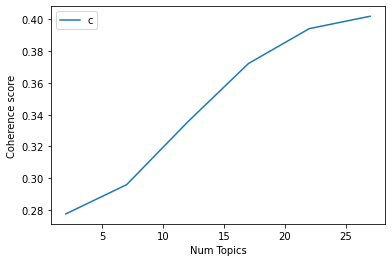

In [168]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [169]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2775
index: 1 | Num Topics = 7  has Coherence Value of 0.296
index: 2 | Num Topics = 12  has Coherence Value of 0.3353
index: 3 | Num Topics = 17  has Coherence Value of 0.3722
index: 4 | Num Topics = 22  has Coherence Value of 0.3942
index: 5 | Num Topics = 27  has Coherence Value of 0.402


In [188]:
# Select optimal number of topics
optimal_model_ph_2021_score1N2N3 = model_list_ph_2021_score1N2N3[5]

In [189]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2021_score1N2N3, corpus_ph_2021_score1N2N3, id2word_ph_2021_score1N2N3)

In [190]:
print("pyLDAVis for ph topics for score=1,2,3 in 2021:")
vis_ph_2021_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.081381 -0.054008       1        1  9.772390
20    -0.080939 -0.017921       2        1  9.238220
13    -0.054398  0.089359       3        1  8.185500
18    -0.103949  0.074712       4        1  5.938413
8     -0.018274 -0.002422       5        1  5.530928
5     -0.058960 -0.018906       6        1  5.489859
1     -0.081231 -0.058762       7        1  5.451241
2     -0.148156  0.008189       8        1  5.444293
3     -0.103714  0.163801       9        1  4.856293
11     0.107078 -0.102548      10        1  4.707233
15    -0.105329 -0.097357      11        1  4.442104
19     0.055489 -0.086421      12        1  4.341716
21    -0.055726  0.066296      13        1  4.200423
16    -0.064967 -0.079478      14        1  3.624230
9      0.016580 -0.068226      15        1  3.000284
22     0.011703 -0.059527      16        1  2.917708
0     -0.015869 -0.020068      17        1  2.862072
7      0.027664 -0.057612      18        1  2.586545
14     0.035095  0.061160      19        1  1.301009
26     0.093862  0.042698      20        1  1.214425
23     0.051604 -0.011744      21        1  1.007536
17     0.007276  0.051457      22        1  1.007536
12     0.132312  0.084357      23        1  0.966175
10     0.146670  0.012328      24        1  0.842146
6      0.109598  0.006703      25        1  0.800825
24     0.088981  0.036971      26        1  0.135448
25     0.088981  0.036971      27        1  0.135448, topic_info=         Term      Freq      Total Category  logprob  loglift
34      story  29.00000  29.000000  Default  30.0000  30.0000
118      post  43.00000  43.000000  Default  29.0000  29.0000
1     account  55.00000  55.000000  Default  28.0000  28.0000
89    feature  24.00000  24.000000  Default  27.0000  27.0000
271    filter  12.00000  12.000000  Default  26.0000  26.0000
..        ...       ...        ...      ...      ...      ...
8      forgot   0.00459   4.824948  Topic27  -6.5681  -0.3533
9        gain   0.00459   1.553819  Topic27  -6.5681   0.7798
10   password   0.00459  12.761607  Topic27  -6.5681  -1.3259
11   retrieve   0.00459   1.553819  Topic27  -6.5681   0.7798
12       send   0.00459   9.206260  Topic27  -6.5681  -0.9993

[1384 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
258       8  0.667637    ability
295       2  0.516821       able
295       3  0.172274       able
295       9  0.172274       able
295      10  0.172274       able
...     ...       ...        ...
194       5  0.311830  yesterday
194       6  0.311830  yesterday
360       2  0.248676        yet
360       5  0.248676        yet
360       7  0.497352        yet

[1516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 21, 14, 19, 9, 6, 2, 3, 4, 12, 16, 20, 22, 17, 10, 23, 1, 8, 15, 27, 24, 18, 13, 11, 7, 25, 26])

# Export pyLDAvis as html

In [191]:
# Overall
pyLDAvis.save_html(vis_ph,'instagram_vis_ph.html')

# By-rating 
pyLDAvis.save_html(vis_ph_score1,'instagram_vis_ph_score1.html')
pyLDAvis.save_html(vis_ph_score2,'instagram_vis_ph_score2.html')
pyLDAvis.save_html(vis_ph_score3,'instagram_vis_ph_score3.html')
pyLDAvis.save_html(vis_ph_score4,'instagram_vis_ph_score4.html')
pyLDAvis.save_html(vis_ph_score5,'instagram_vis_ph_score5.html')
pyLDAvis.save_html(vis_ph_score1N2N3,'instagram_vis_ph_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_ph_2021_score1N2N3,'instagram_vis_ph_2021_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2020_score1N2N3,'instagram_vis_ph_2020_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2019_score1N2N3,'instagram_vis_ph_2019_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2018_score1N2N3,'instagram_vis_ph_2018_score1N2N3.html')

